In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.applications import vgg16, inception_v3
from keras.models import Sequential, Model
from keras.layers import * 
from keras.utils.np_utils import to_categorical
from keras import regularizers
import tensorflow as tf
from keras import initializers, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, Adadelta, SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
np.random.seed(1337)
from PIL import Image
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dataset-master', 'dataset2-master']


In [2]:
# reset
K.clear_session()

K.set_image_data_format('channels_last')

# This one is to test whether Keras can see the GPUs
K.get_session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 569489490),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 569489490)]

In [3]:
dict_characters = {0:'NEUTROPHIL', 1:'EOSINOPHIL', 2:'MONOCYTE', 3:'LYMPHOCYTE'}
dict_characters2 = {0:'Polynuclear', 1:'Mononuclear'}

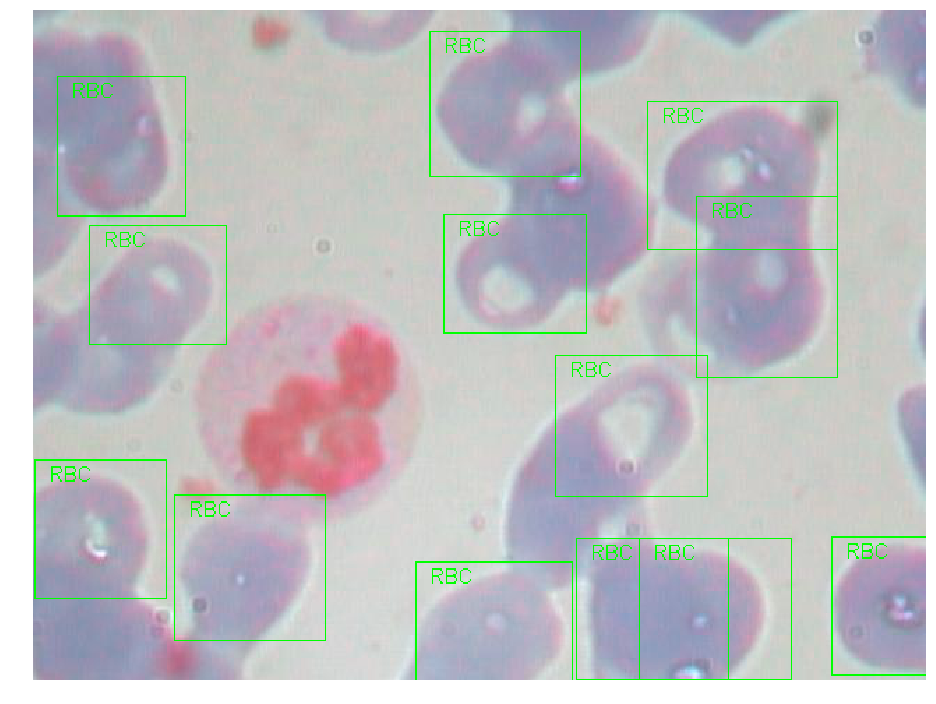

In [4]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread("../input/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("../input/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.axis('off') 
plt.show()

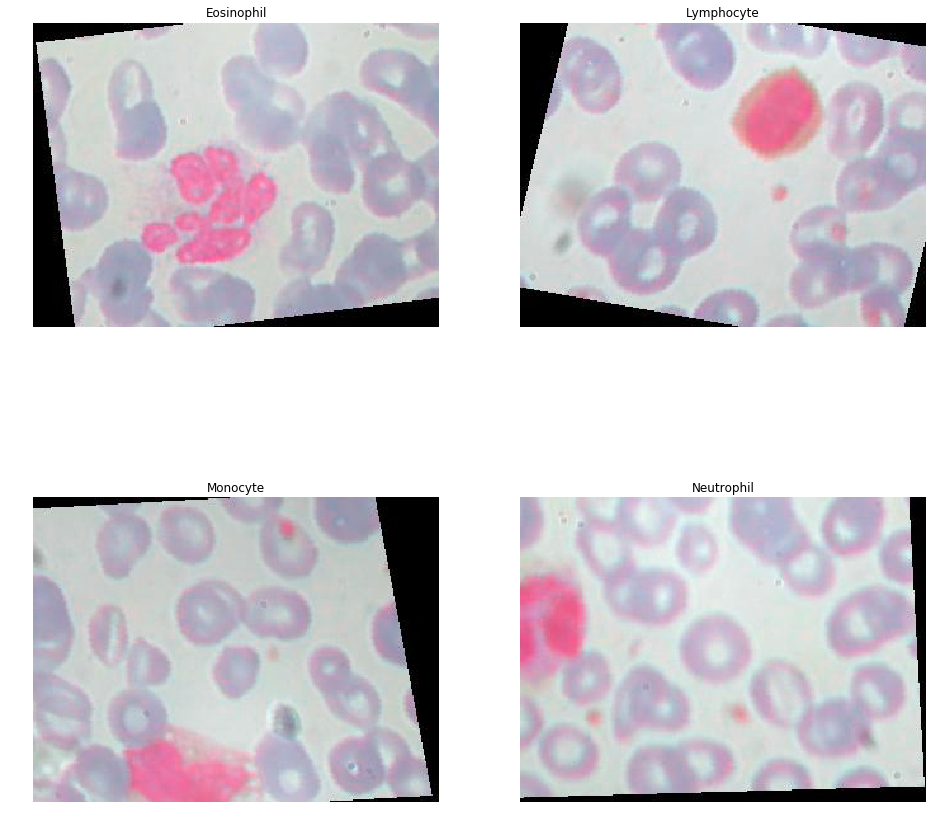

In [5]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return

image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

In [6]:
def replaceBlackBackground(image, colour):
    image_data = np.array(image)
    red, green, blue = image_data.T
    # Replace black with color...
    black_areas = (red < 60) & (blue < 60) & (green < 60)
    image_data[black_areas.T] = colour
    return Image.fromarray(image_data)

new_background_colour = (210, 215, 213)

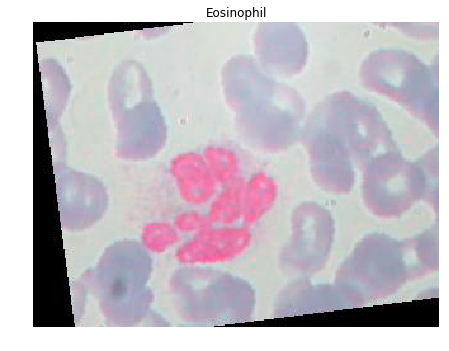

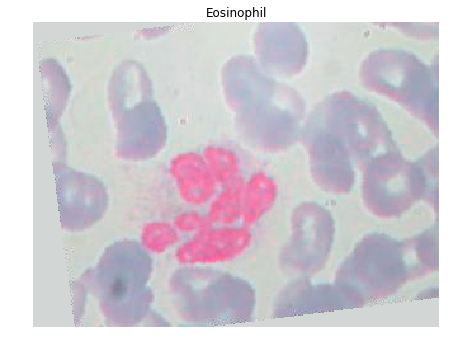

In [7]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    image2 = replaceBlackBackground(image, colour=new_background_colour)
    plt.figure(figsize=(16,16))
    plt.subplot(121)
    plt.title('Eosinophil')
    plt.axis('off') 
    plt.imshow(image)
    plt.figure(figsize=(16,16))
    plt.subplot(122)
    plt.title('Eosinophil')
    plt.axis('off') 
    plt.imshow(image2)
    return

image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plotImage(image_name)

[  3  88  33  21 207]


Text(0,0.5,'Counts')

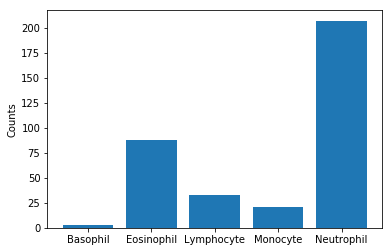

In [8]:
reader = csv.reader(open('../input/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

In [9]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 0
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 0
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 1
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3
                label2 = 1
            # else:
            #     label = 4
            #     label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = replaceBlackBackground(img_file, new_background_colour)
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 538.89it/s]


In [10]:
def get_data2(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 0
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 0
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 1
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3
                label2 = 1
            # else:
            #     label = 4
            #     label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    #img_file = replaceBlackBackground(img_file, new_background_colour)
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train_2, y_train_2, z_train = get_data2('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test_2, y_test_2, z_test = get_data2('../input/dataset2-master/dataset2-master/images/TEST/')

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:00<00:00, 773.36it/s]


In [11]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
y_trainHot_2 = to_categorical(y_train_2, num_classes = 4)
y_testHot_2 = to_categorical(y_test_2, num_classes = 4)

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}


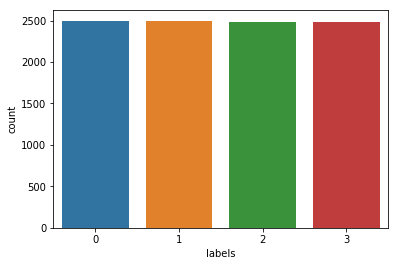

In [12]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

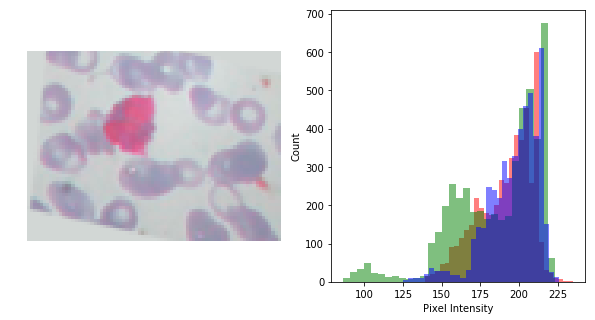

In [13]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[5])

In [14]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

X_train_2=np.array(X_train_2)
X_train_2=X_train_2/255.0

X_test_2=np.array(X_test_2)
X_test_2=X_test_2/255.0

In [16]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [17]:
X_train.shape

(9957, 60, 80, 3)

In [18]:
img_rows, img_cols, img_num_channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
input_shape = (img_rows, img_cols, img_num_channels)
num_classes = len(y_trainHot[0])
print("input shape:", input_shape)
print("num classes:", num_classes)

input shape: (60, 80, 3)
num classes: 4


In [19]:
def build_keras_model(model_name, num_classes, input_shape):
    if model_name == 'vgg16':
        base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'inception_v3':
        base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:        
        return

    for layer in base_model.layers:
        layer.trainable = False
    
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    # predictions = Dense(num_classes, activation='softmax')(x)

    # model = Model(inputs=base_model.input, outputs=predictions)
    
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    # add_model.add(Flatten(input_shape=input_shape))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dropout(0.5))
    add_model.add(Dense(num_classes, activation='softmax'))
        
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    return model

In [20]:
def build_custom_model(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [21]:
def build_our_model(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [22]:
def build_our_model2(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [23]:
def build_lenet5_model(num_classes, input_shape):
    model = Sequential()
    # For an explanation on conv layers see http://cs231n.github.io/convolutional-networks/#conv
    # By default the stride/subsample is 1 and there is no zero-padding.
    # If you want zero-padding add a ZeroPadding layer or, if stride is 1 use border_mode="same"
    model.add(Conv2D(12, kernel_size=(5, 5), activation = 'relu', input_shape=input_shape, init='he_normal'))

    # For an explanation on pooling layers see http://cs231n.github.io/convolutional-networks/#pool
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(25, kernel_size=(5, 5), activation = 'relu', init='he_normal'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the 3D output to 1D tensor for a fully connected layer to accept the input
    model.add(Flatten())
    model.add(Dense(180, activation = 'relu', init='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = 'relu', init='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax', init='he_normal')) #Last layer with one output per class

    return model

In [24]:
def train_model(model, x_train, y_train, x_test, y_test, learning_rate=1.0, lr_decay=0,
                metrics=['accuracy'], batch_size=100, epochs=30, shift_fraction=0.1, rotation_range=10, 
                shift_range=0.1, horizontal_flip=True, vertical_flip=False, optimizer='Adadelta',
                save_dir='./result'):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """

    # callbacks
    checkpoint = ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=0)

    # compile the model
    if optimizer == 'Adadelta':
        optimizer_obj = Adadelta(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'Adam':
        optimizer_obj = Adam(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'SGD':
        optimizer_obj = SGD(lr=learning_rate, decay=lr_decay)
        
    model.compile(optimizer=optimizer_obj, loss=['categorical_crossentropy'], metrics=['accuracy'])

    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=shift_range,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=shift_range,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=horizontal_flip,  # randomly flip images
        vertical_flip=vertical_flip)  # randomly flip images
    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size), 
        steps_per_epoch=len(x_train) / batch_size, 
        epochs=epochs, 
        validation_data = [x_test, y_test],
        # callbacks = [checkpoint, lr_decay_callback]
        callbacks = [checkpoint, MetricsCheckpoint('logs')]
    )
    
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)

    return history

In [25]:
def test_model(model, x_test, y_test, history, best_weight_file):
    score = model.evaluate(x_test, y_test, verbose=True)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(x_test)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(y_test,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

In [45]:
def test_model_2(model, x_test, y_test, best_weight_file, learning_rate=1.0, lr_decay=0, optimizer='Adadelta'):
    model.load_weights(best_weight_file)
    
    # compile the model
    if optimizer == 'Adadelta':
        optimizer_obj = Adadelta(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'Adam':
        optimizer_obj = Adam(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'SGD':
        optimizer_obj = SGD(lr=learning_rate, decay=lr_decay)
        
    model.compile(optimizer=optimizer_obj, loss=['categorical_crossentropy'], metrics=['accuracy'])

    score = model.evaluate(x_test, y_test, verbose=True)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(x_test)
    map_characters = dict_characters
    print(sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(y_test,axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

Epoch 1/30
312/311 [==============================] - ETA: 2:45 - loss: 1.4347 - acc: 0.250 - ETA: 1:00 - loss: 3.4330 - acc: 0.208 - ETA: 32s - loss: 2.4890 - acc: 0.255 - ETA: 23s - loss: 2.1281 - acc: 0.25 - ETA: 18s - loss: 1.9442 - acc: 0.26 - ETA: 16s - loss: 1.8325 - acc: 0.26 - ETA: 14s - loss: 1.7796 - acc: 0.26 - ETA: 14s - loss: 1.7406 - acc: 0.25 - ETA: 13s - loss: 1.7066 - acc: 0.26 - ETA: 13s - loss: 1.6788 - acc: 0.27 - ETA: 12s - loss: 1.6548 - acc: 0.27 - ETA: 12s - loss: 1.6348 - acc: 0.27 - ETA: 12s - loss: 1.6182 - acc: 0.27 - ETA: 11s - loss: 1.6037 - acc: 0.27 - ETA: 11s - loss: 1.5905 - acc: 0.27 - ETA: 11s - loss: 1.5789 - acc: 0.26 - ETA: 11s - loss: 1.5685 - acc: 0.27 - ETA: 10s - loss: 1.5593 - acc: 0.26 - ETA: 10s - loss: 1.5508 - acc: 0.26 - ETA: 10s - loss: 1.5429 - acc: 0.26 - ETA: 10s - loss: 1.5329 - acc: 0.26 - ETA: 10s - loss: 1.5269 - acc: 0.26 - ETA: 9s - loss: 1.5214 - acc: 0.2644 - ETA: 9s - loss: 1.5163 - acc: 0.262 - ETA: 9s - loss: 1.5116 - acc

312/311 [==============================] - ETA: 10s - loss: 1.1235 - acc: 0.50 - ETA: 7s - loss: 1.1765 - acc: 0.4609 - ETA: 6s - loss: 1.2062 - acc: 0.442 - ETA: 6s - loss: 1.2065 - acc: 0.440 - ETA: 6s - loss: 1.2070 - acc: 0.437 - ETA: 6s - loss: 1.2197 - acc: 0.424 - ETA: 6s - loss: 1.2231 - acc: 0.427 - ETA: 6s - loss: 1.2413 - acc: 0.422 - ETA: 6s - loss: 1.2385 - acc: 0.426 - ETA: 6s - loss: 1.2429 - acc: 0.433 - ETA: 6s - loss: 1.2423 - acc: 0.430 - ETA: 6s - loss: 1.2371 - acc: 0.428 - ETA: 6s - loss: 1.2398 - acc: 0.426 - ETA: 6s - loss: 1.2399 - acc: 0.421 - ETA: 6s - loss: 1.2446 - acc: 0.417 - ETA: 6s - loss: 1.2450 - acc: 0.419 - ETA: 6s - loss: 1.2430 - acc: 0.418 - ETA: 6s - loss: 1.2373 - acc: 0.423 - ETA: 6s - loss: 1.2465 - acc: 0.418 - ETA: 6s - loss: 1.2432 - acc: 0.423 - ETA: 6s - loss: 1.2387 - acc: 0.427 - ETA: 6s - loss: 1.2323 - acc: 0.430 - ETA: 6s - loss: 1.2285 - acc: 0.430 - ETA: 6s - loss: 1.2281 - acc: 0.429 - ETA: 6s - loss: 1.2306 - acc: 0.430 - ETA: 6

312/311 [==============================] - ETA: 8s - loss: 0.8030 - acc: 0.687 - ETA: 6s - loss: 0.8779 - acc: 0.617 - ETA: 5s - loss: 0.9333 - acc: 0.575 - ETA: 5s - loss: 0.9463 - acc: 0.568 - ETA: 5s - loss: 0.9403 - acc: 0.569 - ETA: 5s - loss: 0.9706 - acc: 0.566 - ETA: 5s - loss: 0.9807 - acc: 0.564 - ETA: 5s - loss: 1.0115 - acc: 0.554 - ETA: 5s - loss: 1.0004 - acc: 0.562 - ETA: 6s - loss: 1.0014 - acc: 0.557 - ETA: 6s - loss: 1.0054 - acc: 0.562 - ETA: 6s - loss: 1.0066 - acc: 0.557 - ETA: 6s - loss: 1.0107 - acc: 0.553 - ETA: 6s - loss: 1.0126 - acc: 0.556 - ETA: 6s - loss: 1.0074 - acc: 0.559 - ETA: 6s - loss: 0.9953 - acc: 0.567 - ETA: 6s - loss: 0.9904 - acc: 0.569 - ETA: 6s - loss: 0.9838 - acc: 0.570 - ETA: 7s - loss: 0.9800 - acc: 0.576 - ETA: 6s - loss: 0.9871 - acc: 0.570 - ETA: 6s - loss: 0.9863 - acc: 0.568 - ETA: 6s - loss: 0.9830 - acc: 0.568 - ETA: 6s - loss: 0.9820 - acc: 0.567 - ETA: 6s - loss: 0.9820 - acc: 0.567 - ETA: 6s - loss: 0.9770 - acc: 0.571 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.6358 - acc: 0.687 - ETA: 6s - loss: 0.6883 - acc: 0.703 - ETA: 6s - loss: 0.7619 - acc: 0.687 - ETA: 5s - loss: 0.7703 - acc: 0.671 - ETA: 5s - loss: 0.8503 - acc: 0.629 - ETA: 5s - loss: 0.8600 - acc: 0.627 - ETA: 5s - loss: 0.8585 - acc: 0.621 - ETA: 5s - loss: 0.8576 - acc: 0.620 - ETA: 5s - loss: 0.8550 - acc: 0.627 - ETA: 5s - loss: 0.8458 - acc: 0.633 - ETA: 6s - loss: 0.8522 - acc: 0.634 - ETA: 6s - loss: 0.8821 - acc: 0.622 - ETA: 6s - loss: 0.9243 - acc: 0.608 - ETA: 6s - loss: 0.9419 - acc: 0.597 - ETA: 6s - loss: 0.9394 - acc: 0.598 - ETA: 6s - loss: 0.9391 - acc: 0.601 - ETA: 6s - loss: 0.9337 - acc: 0.604 - ETA: 6s - loss: 0.9308 - acc: 0.604 - ETA: 6s - loss: 0.9241 - acc: 0.608 - ETA: 6s - loss: 0.9132 - acc: 0.612 - ETA: 6s - loss: 0.9047 - acc: 0.616 - ETA: 6s - loss: 0.8999 - acc: 0.619 - ETA: 6s - loss: 0.8875 - acc: 0.624 - ETA: 6s - loss: 0.8818 - acc: 0.627 - ETA: 6s - loss: 0.8893 - acc: 0.621 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.7216 - acc: 0.718 - ETA: 7s - loss: 0.6640 - acc: 0.710 - ETA: 7s - loss: 0.6696 - acc: 0.692 - ETA: 7s - loss: 0.6992 - acc: 0.677 - ETA: 8s - loss: 0.6819 - acc: 0.701 - ETA: 8s - loss: 0.6666 - acc: 0.713 - ETA: 8s - loss: 0.6571 - acc: 0.714 - ETA: 7s - loss: 0.6930 - acc: 0.703 - ETA: 7s - loss: 0.7290 - acc: 0.689 - ETA: 7s - loss: 0.7330 - acc: 0.683 - ETA: 7s - loss: 0.7564 - acc: 0.680 - ETA: 7s - loss: 0.7731 - acc: 0.671 - ETA: 7s - loss: 0.7670 - acc: 0.676 - ETA: 6s - loss: 0.7651 - acc: 0.678 - ETA: 6s - loss: 0.7659 - acc: 0.679 - ETA: 6s - loss: 0.7691 - acc: 0.677 - ETA: 6s - loss: 0.7602 - acc: 0.681 - ETA: 6s - loss: 0.7483 - acc: 0.688 - ETA: 6s - loss: 0.7439 - acc: 0.691 - ETA: 6s - loss: 0.7347 - acc: 0.694 - ETA: 6s - loss: 0.7277 - acc: 0.697 - ETA: 6s - loss: 0.7243 - acc: 0.699 - ETA: 6s - loss: 0.7169 - acc: 0.704 - ETA: 6s - loss: 0.7148 - acc: 0.704 - ETA: 6s - loss: 0.7125 - acc: 0.703 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.0523 - acc: 0.593 - ETA: 5s - loss: 0.7880 - acc: 0.726 - ETA: 5s - loss: 1.1021 - acc: 0.607 - ETA: 5s - loss: 0.9752 - acc: 0.653 - ETA: 5s - loss: 0.9239 - acc: 0.661 - ETA: 5s - loss: 0.8566 - acc: 0.685 - ETA: 5s - loss: 0.8119 - acc: 0.701 - ETA: 5s - loss: 0.7866 - acc: 0.709 - ETA: 5s - loss: 0.7740 - acc: 0.708 - ETA: 5s - loss: 0.7500 - acc: 0.711 - ETA: 6s - loss: 0.7327 - acc: 0.719 - ETA: 6s - loss: 0.7248 - acc: 0.719 - ETA: 6s - loss: 0.7256 - acc: 0.714 - ETA: 6s - loss: 0.7257 - acc: 0.717 - ETA: 6s - loss: 0.7071 - acc: 0.724 - ETA: 6s - loss: 0.6985 - acc: 0.727 - ETA: 6s - loss: 0.7149 - acc: 0.718 - ETA: 6s - loss: 0.7137 - acc: 0.717 - ETA: 6s - loss: 0.7074 - acc: 0.719 - ETA: 6s - loss: 0.7145 - acc: 0.717 - ETA: 6s - loss: 0.7090 - acc: 0.719 - ETA: 6s - loss: 0.6998 - acc: 0.723 - ETA: 6s - loss: 0.6935 - acc: 0.729 - ETA: 6s - loss: 0.6888 - acc: 0.729 - ETA: 6s - loss: 0.6875 - acc: 0.727 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.5337 - acc: 0.781 - ETA: 6s - loss: 0.4646 - acc: 0.828 - ETA: 6s - loss: 0.4678 - acc: 0.834 - ETA: 6s - loss: 0.4605 - acc: 0.825 - ETA: 6s - loss: 0.4599 - acc: 0.831 - ETA: 5s - loss: 0.4786 - acc: 0.812 - ETA: 5s - loss: 0.5501 - acc: 0.784 - ETA: 5s - loss: 0.5923 - acc: 0.750 - ETA: 5s - loss: 0.6068 - acc: 0.749 - ETA: 5s - loss: 0.5942 - acc: 0.751 - ETA: 5s - loss: 0.5909 - acc: 0.753 - ETA: 6s - loss: 0.5856 - acc: 0.753 - ETA: 6s - loss: 0.5781 - acc: 0.754 - ETA: 6s - loss: 0.5806 - acc: 0.751 - ETA: 6s - loss: 0.5706 - acc: 0.755 - ETA: 6s - loss: 0.5730 - acc: 0.756 - ETA: 6s - loss: 0.5761 - acc: 0.754 - ETA: 6s - loss: 0.5700 - acc: 0.755 - ETA: 6s - loss: 0.5657 - acc: 0.755 - ETA: 6s - loss: 0.5624 - acc: 0.756 - ETA: 6s - loss: 0.5608 - acc: 0.757 - ETA: 6s - loss: 0.5538 - acc: 0.762 - ETA: 6s - loss: 0.5473 - acc: 0.764 - ETA: 6s - loss: 0.5498 - acc: 0.763 - ETA: 6s - loss: 0.5475 - acc: 0.764 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.6040 - acc: 0.781 - ETA: 5s - loss: 0.5732 - acc: 0.750 - ETA: 5s - loss: 0.5958 - acc: 0.725 - ETA: 5s - loss: 0.6026 - acc: 0.735 - ETA: 5s - loss: 0.6118 - acc: 0.745 - ETA: 5s - loss: 0.5871 - acc: 0.755 - ETA: 5s - loss: 0.5549 - acc: 0.763 - ETA: 5s - loss: 0.5421 - acc: 0.768 - ETA: 5s - loss: 0.5314 - acc: 0.776 - ETA: 5s - loss: 0.5204 - acc: 0.782 - ETA: 6s - loss: 0.5127 - acc: 0.785 - ETA: 6s - loss: 0.5071 - acc: 0.789 - ETA: 6s - loss: 0.5078 - acc: 0.787 - ETA: 6s - loss: 0.5007 - acc: 0.791 - ETA: 6s - loss: 0.4992 - acc: 0.795 - ETA: 6s - loss: 0.4877 - acc: 0.799 - ETA: 6s - loss: 0.4828 - acc: 0.801 - ETA: 6s - loss: 0.4766 - acc: 0.805 - ETA: 6s - loss: 0.4740 - acc: 0.806 - ETA: 6s - loss: 0.4800 - acc: 0.803 - ETA: 6s - loss: 0.4781 - acc: 0.802 - ETA: 6s - loss: 0.4822 - acc: 0.800 - ETA: 6s - loss: 0.4864 - acc: 0.799 - ETA: 6s - loss: 0.4832 - acc: 0.801 - ETA: 6s - loss: 0.4790 - acc: 0.802 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.5227 - acc: 0.875 - ETA: 6s - loss: 0.3962 - acc: 0.867 - ETA: 6s - loss: 0.4040 - acc: 0.839 - ETA: 5s - loss: 0.3974 - acc: 0.831 - ETA: 5s - loss: 0.4321 - acc: 0.817 - ETA: 5s - loss: 0.4214 - acc: 0.824 - ETA: 5s - loss: 0.4328 - acc: 0.812 - ETA: 5s - loss: 0.4216 - acc: 0.815 - ETA: 5s - loss: 0.4175 - acc: 0.819 - ETA: 6s - loss: 0.4058 - acc: 0.824 - ETA: 6s - loss: 0.4044 - acc: 0.822 - ETA: 6s - loss: 0.4038 - acc: 0.824 - ETA: 6s - loss: 0.3988 - acc: 0.827 - ETA: 6s - loss: 0.3886 - acc: 0.830 - ETA: 6s - loss: 0.3904 - acc: 0.831 - ETA: 6s - loss: 0.3944 - acc: 0.829 - ETA: 6s - loss: 0.3942 - acc: 0.831 - ETA: 6s - loss: 0.3924 - acc: 0.835 - ETA: 6s - loss: 0.3916 - acc: 0.835 - ETA: 6s - loss: 0.3891 - acc: 0.837 - ETA: 6s - loss: 0.3832 - acc: 0.840 - ETA: 6s - loss: 0.3840 - acc: 0.838 - ETA: 6s - loss: 0.3827 - acc: 0.839 - ETA: 6s - loss: 0.3817 - acc: 0.838 - ETA: 6s - loss: 0.3875 - acc: 0.836 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.4782 - acc: 0.781 - ETA: 5s - loss: 0.5627 - acc: 0.765 - ETA: 5s - loss: 0.4796 - acc: 0.790 - ETA: 5s - loss: 0.5212 - acc: 0.787 - ETA: 5s - loss: 0.4937 - acc: 0.793 - ETA: 5s - loss: 0.4918 - acc: 0.789 - ETA: 5s - loss: 0.4720 - acc: 0.799 - ETA: 5s - loss: 0.4604 - acc: 0.804 - ETA: 5s - loss: 0.4451 - acc: 0.811 - ETA: 5s - loss: 0.4468 - acc: 0.812 - ETA: 5s - loss: 0.4386 - acc: 0.816 - ETA: 6s - loss: 0.4366 - acc: 0.815 - ETA: 6s - loss: 0.4307 - acc: 0.819 - ETA: 6s - loss: 0.4390 - acc: 0.817 - ETA: 6s - loss: 0.4375 - acc: 0.818 - ETA: 6s - loss: 0.4267 - acc: 0.823 - ETA: 6s - loss: 0.4159 - acc: 0.827 - ETA: 6s - loss: 0.4141 - acc: 0.827 - ETA: 6s - loss: 0.4175 - acc: 0.825 - ETA: 6s - loss: 0.4903 - acc: 0.815 - ETA: 6s - loss: 0.5052 - acc: 0.810 - ETA: 6s - loss: 0.5079 - acc: 0.810 - ETA: 6s - loss: 0.5063 - acc: 0.810 - ETA: 6s - loss: 0.5049 - acc: 0.813 - ETA: 6s - loss: 0.5006 - acc: 0.816 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.2867 - acc: 0.906 - ETA: 5s - loss: 0.4284 - acc: 0.828 - ETA: 5s - loss: 0.3983 - acc: 0.825 - ETA: 5s - loss: 0.4184 - acc: 0.834 - ETA: 5s - loss: 0.4291 - acc: 0.829 - ETA: 5s - loss: 0.3999 - acc: 0.843 - ETA: 5s - loss: 0.3856 - acc: 0.848 - ETA: 5s - loss: 0.3728 - acc: 0.856 - ETA: 5s - loss: 0.3585 - acc: 0.860 - ETA: 5s - loss: 0.3718 - acc: 0.855 - ETA: 5s - loss: 0.4374 - acc: 0.838 - ETA: 6s - loss: 0.4379 - acc: 0.834 - ETA: 6s - loss: 0.4371 - acc: 0.836 - ETA: 6s - loss: 0.4312 - acc: 0.837 - ETA: 6s - loss: 0.4262 - acc: 0.838 - ETA: 6s - loss: 0.4208 - acc: 0.841 - ETA: 6s - loss: 0.4177 - acc: 0.845 - ETA: 6s - loss: 0.4092 - acc: 0.846 - ETA: 6s - loss: 0.4034 - acc: 0.848 - ETA: 6s - loss: 0.3952 - acc: 0.851 - ETA: 6s - loss: 0.3884 - acc: 0.855 - ETA: 6s - loss: 0.3832 - acc: 0.856 - ETA: 6s - loss: 0.3795 - acc: 0.857 - ETA: 6s - loss: 0.3775 - acc: 0.856 - ETA: 6s - loss: 0.3836 - acc: 0.851 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.4966 - acc: 0.750 - ETA: 5s - loss: 0.3713 - acc: 0.820 - ETA: 5s - loss: 0.2914 - acc: 0.883 - ETA: 5s - loss: 0.3296 - acc: 0.853 - ETA: 5s - loss: 0.3578 - acc: 0.851 - ETA: 5s - loss: 0.3456 - acc: 0.855 - ETA: 5s - loss: 0.3435 - acc: 0.858 - ETA: 5s - loss: 0.3361 - acc: 0.859 - ETA: 5s - loss: 0.3291 - acc: 0.857 - ETA: 5s - loss: 0.3308 - acc: 0.858 - ETA: 5s - loss: 0.3255 - acc: 0.856 - ETA: 5s - loss: 0.3293 - acc: 0.856 - ETA: 6s - loss: 0.3369 - acc: 0.850 - ETA: 6s - loss: 0.3406 - acc: 0.848 - ETA: 6s - loss: 0.3469 - acc: 0.846 - ETA: 6s - loss: 0.3700 - acc: 0.841 - ETA: 6s - loss: 0.3738 - acc: 0.838 - ETA: 6s - loss: 0.3742 - acc: 0.835 - ETA: 6s - loss: 0.3722 - acc: 0.835 - ETA: 6s - loss: 0.3654 - acc: 0.839 - ETA: 6s - loss: 0.3661 - acc: 0.839 - ETA: 6s - loss: 0.3760 - acc: 0.834 - ETA: 6s - loss: 0.3729 - acc: 0.837 - ETA: 6s - loss: 0.3678 - acc: 0.839 - ETA: 6s - loss: 0.3648 - acc: 0.842 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.2472 - acc: 0.875 - ETA: 6s - loss: 0.2823 - acc: 0.893 - ETA: 6s - loss: 0.2792 - acc: 0.882 - ETA: 5s - loss: 0.2564 - acc: 0.894 - ETA: 5s - loss: 0.2718 - acc: 0.883 - ETA: 5s - loss: 0.2885 - acc: 0.876 - ETA: 5s - loss: 0.3005 - acc: 0.864 - ETA: 5s - loss: 0.3141 - acc: 0.860 - ETA: 5s - loss: 0.3096 - acc: 0.863 - ETA: 5s - loss: 0.3262 - acc: 0.860 - ETA: 6s - loss: 0.3185 - acc: 0.864 - ETA: 6s - loss: 0.3140 - acc: 0.864 - ETA: 6s - loss: 0.3276 - acc: 0.860 - ETA: 6s - loss: 0.3374 - acc: 0.854 - ETA: 6s - loss: 0.3406 - acc: 0.853 - ETA: 6s - loss: 0.3370 - acc: 0.855 - ETA: 6s - loss: 0.3537 - acc: 0.849 - ETA: 6s - loss: 0.3696 - acc: 0.844 - ETA: 6s - loss: 0.3752 - acc: 0.842 - ETA: 6s - loss: 0.3716 - acc: 0.845 - ETA: 6s - loss: 0.3685 - acc: 0.848 - ETA: 6s - loss: 0.3642 - acc: 0.851 - ETA: 6s - loss: 0.3660 - acc: 0.849 - ETA: 6s - loss: 0.3668 - acc: 0.849 - ETA: 6s - loss: 0.3665 - acc: 0.847 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.2768 - acc: 0.875 - ETA: 5s - loss: 0.2524 - acc: 0.890 - ETA: 5s - loss: 0.2482 - acc: 0.906 - ETA: 5s - loss: 0.2594 - acc: 0.896 - ETA: 5s - loss: 0.2399 - acc: 0.899 - ETA: 5s - loss: 0.2469 - acc: 0.900 - ETA: 5s - loss: 0.2429 - acc: 0.904 - ETA: 5s - loss: 0.2482 - acc: 0.902 - ETA: 5s - loss: 0.2404 - acc: 0.902 - ETA: 5s - loss: 0.2464 - acc: 0.897 - ETA: 5s - loss: 0.2563 - acc: 0.892 - ETA: 6s - loss: 0.2681 - acc: 0.888 - ETA: 6s - loss: 0.2637 - acc: 0.892 - ETA: 6s - loss: 0.2706 - acc: 0.889 - ETA: 6s - loss: 0.2692 - acc: 0.891 - ETA: 6s - loss: 0.2658 - acc: 0.894 - ETA: 6s - loss: 0.2611 - acc: 0.897 - ETA: 6s - loss: 0.2611 - acc: 0.898 - ETA: 6s - loss: 0.2708 - acc: 0.896 - ETA: 6s - loss: 0.2782 - acc: 0.891 - ETA: 6s - loss: 0.2804 - acc: 0.890 - ETA: 6s - loss: 0.3086 - acc: 0.883 - ETA: 6s - loss: 0.3222 - acc: 0.876 - ETA: 6s - loss: 0.3304 - acc: 0.873 - ETA: 6s - loss: 0.3309 - acc: 0.872 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.4203 - acc: 0.843 - ETA: 6s - loss: 0.2551 - acc: 0.890 - ETA: 5s - loss: 0.2494 - acc: 0.892 - ETA: 5s - loss: 0.2511 - acc: 0.890 - ETA: 5s - loss: 0.2387 - acc: 0.896 - ETA: 5s - loss: 0.2474 - acc: 0.896 - ETA: 5s - loss: 0.2332 - acc: 0.901 - ETA: 5s - loss: 0.2298 - acc: 0.903 - ETA: 5s - loss: 0.2293 - acc: 0.902 - ETA: 5s - loss: 0.2253 - acc: 0.903 - ETA: 6s - loss: 0.2411 - acc: 0.897 - ETA: 6s - loss: 0.2559 - acc: 0.894 - ETA: 6s - loss: 0.2550 - acc: 0.895 - ETA: 6s - loss: 0.2504 - acc: 0.897 - ETA: 6s - loss: 0.2477 - acc: 0.897 - ETA: 6s - loss: 0.2485 - acc: 0.899 - ETA: 6s - loss: 0.2534 - acc: 0.900 - ETA: 6s - loss: 0.2515 - acc: 0.903 - ETA: 6s - loss: 0.2603 - acc: 0.897 - ETA: 6s - loss: 0.2591 - acc: 0.898 - ETA: 6s - loss: 0.2616 - acc: 0.896 - ETA: 6s - loss: 0.2610 - acc: 0.897 - ETA: 6s - loss: 0.2668 - acc: 0.897 - ETA: 6s - loss: 0.2627 - acc: 0.899 - ETA: 6s - loss: 0.2598 - acc: 0.900 - ETA: 6s

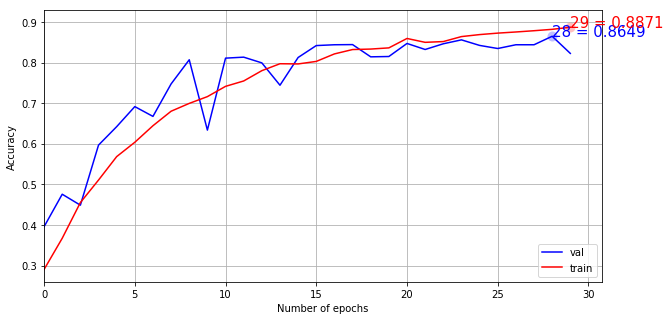

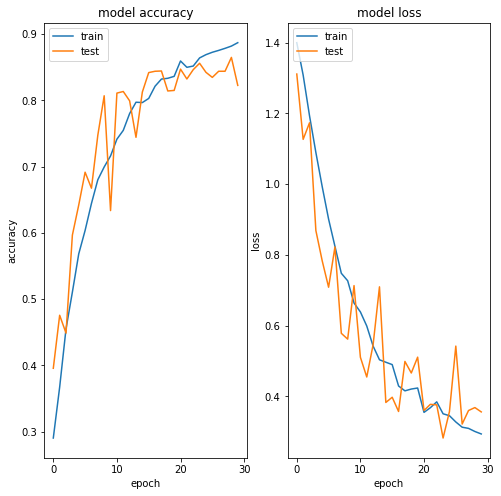

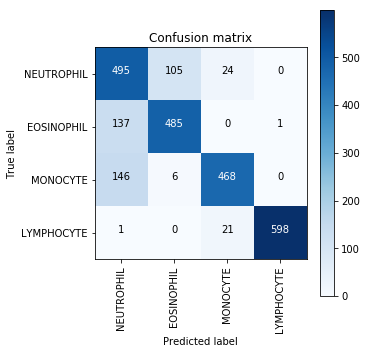

In [31]:
def runCustomModel(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, 
                   learning_rate=1.0, lr_decay=0.0, shift_fraction=0.1,
                    save_dir='./result_custom'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_custom_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runCustomModel(X_train, y_trainHot, X_test, y_testHot)


2487/2487 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 294us/step

Keras CNN #1C - accuracy: 0.8648974670192349 

             precision    recall  f1-score   support

 NEUTROPHIL       0.73      0.82      0.77       624
 EOSINOPHIL       0.82      0.90      0.86       623
   MONOCYTE       0.97      0.75      0.84       620
 LYMPHOCYTE       0.99      0.99      0.99       620

avg / total       0.88      0.86      0.87      2487



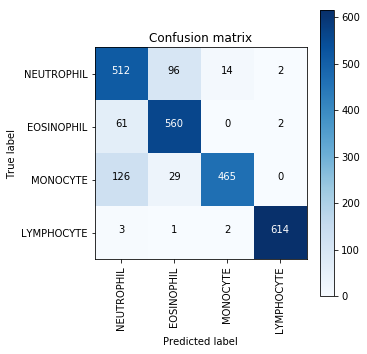

In [48]:
def testCustomModel(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, 
                    learning_rate=1.0, lr_decay=0.0, shift_fraction=0.1,
                    save_dir='./result_custom', file_name='/weights-29.h5'):
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_custom_model(num_classes, input_shape)
    
    print("")
    test_model_2(model, x_test, y_test, save_dir + file_name, learning_rate=1.0, lr_decay=0.0)
    
testCustomModel(X_train, y_trainHot, X_test, y_testHot, save_dir='./result_custom', file_name='/weights-29.h5')

Epoch 1/30
312/311 [==============================] - ETA: 2:49 - loss: 1.5351 - acc: 0.218 - ETA: 1:01 - loss: 5.5803 - acc: 0.197 - ETA: 33s - loss: 3.5457 - acc: 0.224 - ETA: 23s - loss: 2.8179 - acc: 0.25 - ETA: 19s - loss: 2.4727 - acc: 0.26 - ETA: 16s - loss: 2.2582 - acc: 0.24 - ETA: 14s - loss: 2.1122 - acc: 0.24 - ETA: 13s - loss: 2.0373 - acc: 0.26 - ETA: 13s - loss: 1.9745 - acc: 0.27 - ETA: 12s - loss: 1.9299 - acc: 0.27 - ETA: 12s - loss: 1.8889 - acc: 0.26 - ETA: 12s - loss: 1.8524 - acc: 0.26 - ETA: 12s - loss: 1.8201 - acc: 0.27 - ETA: 11s - loss: 1.7940 - acc: 0.27 - ETA: 11s - loss: 1.7697 - acc: 0.27 - ETA: 11s - loss: 1.7490 - acc: 0.27 - ETA: 11s - loss: 1.7295 - acc: 0.27 - ETA: 10s - loss: 1.7119 - acc: 0.27 - ETA: 10s - loss: 1.6961 - acc: 0.27 - ETA: 10s - loss: 1.6825 - acc: 0.27 - ETA: 10s - loss: 1.6700 - acc: 0.27 - ETA: 10s - loss: 1.6583 - acc: 0.27 - ETA: 10s - loss: 1.6474 - acc: 0.27 - ETA: 10s - loss: 1.6373 - acc: 0.27 - ETA: 9s - loss: 1.6277 - acc:

312/311 [==============================] - ETA: 8s - loss: 1.3529 - acc: 0.343 - ETA: 6s - loss: 1.3558 - acc: 0.320 - ETA: 5s - loss: 1.3454 - acc: 0.348 - ETA: 5s - loss: 1.3450 - acc: 0.334 - ETA: 5s - loss: 1.3326 - acc: 0.360 - ETA: 5s - loss: 1.3303 - acc: 0.369 - ETA: 5s - loss: 1.3361 - acc: 0.352 - ETA: 5s - loss: 1.3339 - acc: 0.358 - ETA: 5s - loss: 1.3315 - acc: 0.371 - ETA: 5s - loss: 1.3337 - acc: 0.366 - ETA: 6s - loss: 1.3296 - acc: 0.372 - ETA: 6s - loss: 1.3261 - acc: 0.379 - ETA: 6s - loss: 1.3304 - acc: 0.373 - ETA: 6s - loss: 1.3311 - acc: 0.368 - ETA: 6s - loss: 1.3280 - acc: 0.372 - ETA: 6s - loss: 1.3284 - acc: 0.367 - ETA: 6s - loss: 1.3243 - acc: 0.372 - ETA: 6s - loss: 1.3279 - acc: 0.368 - ETA: 6s - loss: 1.3297 - acc: 0.363 - ETA: 6s - loss: 1.3302 - acc: 0.365 - ETA: 6s - loss: 1.3275 - acc: 0.367 - ETA: 6s - loss: 1.3266 - acc: 0.367 - ETA: 6s - loss: 1.3272 - acc: 0.367 - ETA: 6s - loss: 1.3281 - acc: 0.367 - ETA: 6s - loss: 1.3271 - acc: 0.372 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.0751 - acc: 0.468 - ETA: 6s - loss: 1.0851 - acc: 0.515 - ETA: 6s - loss: 1.1093 - acc: 0.508 - ETA: 5s - loss: 1.1183 - acc: 0.496 - ETA: 5s - loss: 1.1297 - acc: 0.471 - ETA: 5s - loss: 1.1418 - acc: 0.462 - ETA: 5s - loss: 1.1409 - acc: 0.475 - ETA: 5s - loss: 1.1303 - acc: 0.487 - ETA: 5s - loss: 1.1178 - acc: 0.492 - ETA: 5s - loss: 1.1235 - acc: 0.488 - ETA: 5s - loss: 1.1232 - acc: 0.488 - ETA: 6s - loss: 1.1148 - acc: 0.486 - ETA: 6s - loss: 1.1194 - acc: 0.483 - ETA: 6s - loss: 1.1178 - acc: 0.487 - ETA: 6s - loss: 1.1140 - acc: 0.489 - ETA: 6s - loss: 1.1438 - acc: 0.479 - ETA: 6s - loss: 1.1494 - acc: 0.475 - ETA: 6s - loss: 1.1535 - acc: 0.474 - ETA: 6s - loss: 1.1549 - acc: 0.474 - ETA: 6s - loss: 1.1530 - acc: 0.476 - ETA: 6s - loss: 1.1466 - acc: 0.481 - ETA: 6s - loss: 1.1423 - acc: 0.482 - ETA: 6s - loss: 1.1319 - acc: 0.488 - ETA: 6s - loss: 1.1264 - acc: 0.488 - ETA: 6s - loss: 1.1275 - acc: 0.486 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.8875 - acc: 0.625 - ETA: 5s - loss: 0.9564 - acc: 0.593 - ETA: 5s - loss: 0.8771 - acc: 0.642 - ETA: 5s - loss: 0.9908 - acc: 0.576 - ETA: 5s - loss: 0.9725 - acc: 0.582 - ETA: 5s - loss: 0.9742 - acc: 0.579 - ETA: 5s - loss: 0.9787 - acc: 0.573 - ETA: 5s - loss: 0.9726 - acc: 0.577 - ETA: 5s - loss: 0.9645 - acc: 0.585 - ETA: 5s - loss: 0.9704 - acc: 0.576 - ETA: 6s - loss: 0.9788 - acc: 0.575 - ETA: 6s - loss: 0.9875 - acc: 0.567 - ETA: 6s - loss: 1.0008 - acc: 0.557 - ETA: 6s - loss: 1.0041 - acc: 0.557 - ETA: 6s - loss: 1.0050 - acc: 0.553 - ETA: 6s - loss: 1.0004 - acc: 0.555 - ETA: 6s - loss: 0.9976 - acc: 0.552 - ETA: 6s - loss: 0.9983 - acc: 0.554 - ETA: 6s - loss: 0.9992 - acc: 0.557 - ETA: 6s - loss: 1.0015 - acc: 0.557 - ETA: 6s - loss: 0.9972 - acc: 0.562 - ETA: 6s - loss: 1.0018 - acc: 0.558 - ETA: 6s - loss: 1.0012 - acc: 0.558 - ETA: 6s - loss: 0.9968 - acc: 0.560 - ETA: 6s - loss: 0.9944 - acc: 0.562 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.7894 - acc: 0.656 - ETA: 5s - loss: 0.8753 - acc: 0.632 - ETA: 5s - loss: 0.8281 - acc: 0.656 - ETA: 5s - loss: 0.8494 - acc: 0.640 - ETA: 5s - loss: 0.8699 - acc: 0.639 - ETA: 5s - loss: 0.8639 - acc: 0.644 - ETA: 5s - loss: 0.8909 - acc: 0.633 - ETA: 5s - loss: 0.8918 - acc: 0.632 - ETA: 5s - loss: 0.8979 - acc: 0.628 - ETA: 5s - loss: 0.9055 - acc: 0.620 - ETA: 5s - loss: 0.9099 - acc: 0.618 - ETA: 6s - loss: 0.9056 - acc: 0.620 - ETA: 6s - loss: 0.9196 - acc: 0.615 - ETA: 6s - loss: 0.9141 - acc: 0.621 - ETA: 6s - loss: 0.9077 - acc: 0.625 - ETA: 6s - loss: 0.9006 - acc: 0.628 - ETA: 6s - loss: 0.9042 - acc: 0.626 - ETA: 6s - loss: 0.9072 - acc: 0.620 - ETA: 6s - loss: 0.9076 - acc: 0.624 - ETA: 6s - loss: 0.9070 - acc: 0.623 - ETA: 6s - loss: 0.8999 - acc: 0.625 - ETA: 6s - loss: 0.8984 - acc: 0.624 - ETA: 6s - loss: 0.8995 - acc: 0.620 - ETA: 6s - loss: 0.8938 - acc: 0.625 - ETA: 6s - loss: 0.8892 - acc: 0.626 - ETA: 6s

312/311 [==============================] - ETA: 8s - loss: 0.8353 - acc: 0.562 - ETA: 6s - loss: 0.7198 - acc: 0.679 - ETA: 6s - loss: 0.9235 - acc: 0.616 - ETA: 6s - loss: 0.8756 - acc: 0.627 - ETA: 6s - loss: 0.8434 - acc: 0.651 - ETA: 5s - loss: 0.8138 - acc: 0.663 - ETA: 5s - loss: 0.8066 - acc: 0.662 - ETA: 5s - loss: 0.8126 - acc: 0.659 - ETA: 5s - loss: 0.8054 - acc: 0.653 - ETA: 5s - loss: 0.7998 - acc: 0.650 - ETA: 6s - loss: 0.8110 - acc: 0.645 - ETA: 6s - loss: 0.8074 - acc: 0.647 - ETA: 6s - loss: 0.8178 - acc: 0.644 - ETA: 6s - loss: 0.8278 - acc: 0.641 - ETA: 6s - loss: 0.8211 - acc: 0.645 - ETA: 6s - loss: 0.8217 - acc: 0.639 - ETA: 6s - loss: 0.8168 - acc: 0.641 - ETA: 6s - loss: 0.8121 - acc: 0.643 - ETA: 6s - loss: 0.8085 - acc: 0.644 - ETA: 6s - loss: 0.8092 - acc: 0.645 - ETA: 6s - loss: 0.8016 - acc: 0.650 - ETA: 6s - loss: 0.7965 - acc: 0.651 - ETA: 6s - loss: 0.7882 - acc: 0.657 - ETA: 6s - loss: 0.8015 - acc: 0.653 - ETA: 6s - loss: 0.8109 - acc: 0.648 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.7883 - acc: 0.656 - ETA: 5s - loss: 0.7985 - acc: 0.609 - ETA: 5s - loss: 0.7819 - acc: 0.656 - ETA: 5s - loss: 0.7945 - acc: 0.653 - ETA: 5s - loss: 0.7521 - acc: 0.680 - ETA: 5s - loss: 0.7247 - acc: 0.691 - ETA: 5s - loss: 0.7140 - acc: 0.687 - ETA: 5s - loss: 0.7094 - acc: 0.691 - ETA: 5s - loss: 0.6958 - acc: 0.696 - ETA: 5s - loss: 0.7111 - acc: 0.697 - ETA: 5s - loss: 0.7453 - acc: 0.683 - ETA: 6s - loss: 0.7369 - acc: 0.687 - ETA: 6s - loss: 0.7282 - acc: 0.691 - ETA: 6s - loss: 0.7353 - acc: 0.687 - ETA: 6s - loss: 0.7267 - acc: 0.692 - ETA: 6s - loss: 0.7256 - acc: 0.693 - ETA: 6s - loss: 0.7204 - acc: 0.695 - ETA: 6s - loss: 0.7300 - acc: 0.691 - ETA: 6s - loss: 0.7228 - acc: 0.693 - ETA: 6s - loss: 0.7248 - acc: 0.689 - ETA: 6s - loss: 0.7274 - acc: 0.687 - ETA: 6s - loss: 0.7238 - acc: 0.690 - ETA: 6s - loss: 0.7147 - acc: 0.694 - ETA: 6s - loss: 0.7159 - acc: 0.695 - ETA: 6s - loss: 0.7246 - acc: 0.692 - ETA: 6s

312/311 [==============================] - ETA: 10s - loss: 0.7003 - acc: 0.71 - ETA: 6s - loss: 0.6656 - acc: 0.6953 - ETA: 6s - loss: 0.6385 - acc: 0.736 - ETA: 6s - loss: 0.6344 - acc: 0.750 - ETA: 5s - loss: 0.6487 - acc: 0.740 - ETA: 5s - loss: 0.6142 - acc: 0.753 - ETA: 5s - loss: 0.6050 - acc: 0.753 - ETA: 5s - loss: 0.6071 - acc: 0.751 - ETA: 5s - loss: 0.5924 - acc: 0.756 - ETA: 5s - loss: 0.6133 - acc: 0.740 - ETA: 5s - loss: 0.6056 - acc: 0.743 - ETA: 6s - loss: 0.6042 - acc: 0.748 - ETA: 6s - loss: 0.5962 - acc: 0.751 - ETA: 6s - loss: 0.6092 - acc: 0.745 - ETA: 6s - loss: 0.6070 - acc: 0.745 - ETA: 6s - loss: 0.6098 - acc: 0.744 - ETA: 6s - loss: 0.6143 - acc: 0.740 - ETA: 6s - loss: 0.6221 - acc: 0.736 - ETA: 6s - loss: 0.6176 - acc: 0.742 - ETA: 6s - loss: 0.6189 - acc: 0.741 - ETA: 6s - loss: 0.6201 - acc: 0.744 - ETA: 6s - loss: 0.6173 - acc: 0.745 - ETA: 6s - loss: 0.6189 - acc: 0.744 - ETA: 6s - loss: 0.6193 - acc: 0.744 - ETA: 6s - loss: 0.6247 - acc: 0.740 - ETA: 6

312/311 [==============================] - ETA: 7s - loss: 0.6774 - acc: 0.718 - ETA: 6s - loss: 0.5448 - acc: 0.804 - ETA: 5s - loss: 0.5457 - acc: 0.799 - ETA: 5s - loss: 0.5503 - acc: 0.796 - ETA: 5s - loss: 0.5490 - acc: 0.793 - ETA: 5s - loss: 0.5398 - acc: 0.793 - ETA: 5s - loss: 0.5615 - acc: 0.781 - ETA: 5s - loss: 0.5619 - acc: 0.785 - ETA: 5s - loss: 0.5442 - acc: 0.793 - ETA: 6s - loss: 0.5427 - acc: 0.790 - ETA: 6s - loss: 0.5319 - acc: 0.795 - ETA: 6s - loss: 0.5223 - acc: 0.800 - ETA: 6s - loss: 0.5227 - acc: 0.798 - ETA: 6s - loss: 0.5183 - acc: 0.799 - ETA: 6s - loss: 0.5327 - acc: 0.795 - ETA: 6s - loss: 0.5448 - acc: 0.787 - ETA: 6s - loss: 0.5527 - acc: 0.779 - ETA: 6s - loss: 0.5525 - acc: 0.781 - ETA: 6s - loss: 0.5531 - acc: 0.782 - ETA: 6s - loss: 0.5484 - acc: 0.786 - ETA: 6s - loss: 0.5434 - acc: 0.789 - ETA: 7s - loss: 0.5453 - acc: 0.788 - ETA: 6s - loss: 0.5466 - acc: 0.783 - ETA: 6s - loss: 0.5536 - acc: 0.780 - ETA: 6s - loss: 0.5651 - acc: 0.773 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.7129 - acc: 0.781 - ETA: 7s - loss: 0.5313 - acc: 0.812 - ETA: 7s - loss: 0.4823 - acc: 0.799 - ETA: 6s - loss: 0.4722 - acc: 0.806 - ETA: 6s - loss: 0.4700 - acc: 0.810 - ETA: 6s - loss: 0.4846 - acc: 0.808 - ETA: 6s - loss: 0.4828 - acc: 0.804 - ETA: 5s - loss: 0.5096 - acc: 0.789 - ETA: 5s - loss: 0.5064 - acc: 0.793 - ETA: 5s - loss: 0.4955 - acc: 0.802 - ETA: 6s - loss: 0.5021 - acc: 0.798 - ETA: 6s - loss: 0.5046 - acc: 0.797 - ETA: 6s - loss: 0.5021 - acc: 0.797 - ETA: 6s - loss: 0.5011 - acc: 0.797 - ETA: 6s - loss: 0.5013 - acc: 0.795 - ETA: 6s - loss: 0.5359 - acc: 0.782 - ETA: 6s - loss: 0.5483 - acc: 0.775 - ETA: 6s - loss: 0.5446 - acc: 0.778 - ETA: 6s - loss: 0.5348 - acc: 0.785 - ETA: 6s - loss: 0.5321 - acc: 0.785 - ETA: 6s - loss: 0.5337 - acc: 0.788 - ETA: 6s - loss: 0.5283 - acc: 0.788 - ETA: 6s - loss: 0.5271 - acc: 0.789 - ETA: 6s - loss: 0.5311 - acc: 0.788 - ETA: 7s - loss: 0.5288 - acc: 0.788 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.4940 - acc: 0.812 - ETA: 6s - loss: 0.3898 - acc: 0.859 - ETA: 5s - loss: 0.3653 - acc: 0.848 - ETA: 5s - loss: 0.3583 - acc: 0.845 - ETA: 5s - loss: 0.4028 - acc: 0.826 - ETA: 5s - loss: 0.3947 - acc: 0.843 - ETA: 5s - loss: 0.4025 - acc: 0.839 - ETA: 5s - loss: 0.4223 - acc: 0.834 - ETA: 5s - loss: 0.4268 - acc: 0.831 - ETA: 5s - loss: 0.4217 - acc: 0.832 - ETA: 6s - loss: 0.4150 - acc: 0.837 - ETA: 6s - loss: 0.4146 - acc: 0.836 - ETA: 6s - loss: 0.4184 - acc: 0.836 - ETA: 6s - loss: 0.4159 - acc: 0.836 - ETA: 6s - loss: 0.4136 - acc: 0.839 - ETA: 6s - loss: 0.4159 - acc: 0.836 - ETA: 6s - loss: 0.4295 - acc: 0.832 - ETA: 6s - loss: 0.4374 - acc: 0.827 - ETA: 6s - loss: 0.4372 - acc: 0.826 - ETA: 6s - loss: 0.4351 - acc: 0.827 - ETA: 6s - loss: 0.4418 - acc: 0.826 - ETA: 6s - loss: 0.4437 - acc: 0.823 - ETA: 6s - loss: 0.4409 - acc: 0.823 - ETA: 6s - loss: 0.4345 - acc: 0.826 - ETA: 6s - loss: 0.4343 - acc: 0.826 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.2141 - acc: 0.937 - ETA: 5s - loss: 0.3159 - acc: 0.867 - ETA: 6s - loss: 0.3331 - acc: 0.861 - ETA: 6s - loss: 0.3446 - acc: 0.865 - ETA: 5s - loss: 0.3512 - acc: 0.867 - ETA: 5s - loss: 0.3595 - acc: 0.865 - ETA: 5s - loss: 0.3955 - acc: 0.845 - ETA: 5s - loss: 0.4054 - acc: 0.845 - ETA: 5s - loss: 0.4202 - acc: 0.837 - ETA: 5s - loss: 0.4334 - acc: 0.827 - ETA: 6s - loss: 0.4310 - acc: 0.829 - ETA: 6s - loss: 0.4314 - acc: 0.829 - ETA: 6s - loss: 0.4640 - acc: 0.822 - ETA: 6s - loss: 0.5038 - acc: 0.806 - ETA: 6s - loss: 0.5096 - acc: 0.803 - ETA: 6s - loss: 0.5055 - acc: 0.804 - ETA: 6s - loss: 0.4958 - acc: 0.811 - ETA: 6s - loss: 0.4900 - acc: 0.811 - ETA: 6s - loss: 0.4893 - acc: 0.807 - ETA: 6s - loss: 0.4889 - acc: 0.807 - ETA: 6s - loss: 0.4936 - acc: 0.804 - ETA: 6s - loss: 0.4900 - acc: 0.807 - ETA: 6s - loss: 0.5218 - acc: 0.800 - ETA: 6s - loss: 0.5312 - acc: 0.797 - ETA: 6s - loss: 0.5315 - acc: 0.795 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.7328 - acc: 0.625 - ETA: 5s - loss: 0.4261 - acc: 0.781 - ETA: 5s - loss: 0.3789 - acc: 0.821 - ETA: 5s - loss: 0.3449 - acc: 0.846 - ETA: 5s - loss: 0.3415 - acc: 0.848 - ETA: 5s - loss: 0.3324 - acc: 0.853 - ETA: 5s - loss: 0.3343 - acc: 0.848 - ETA: 5s - loss: 0.3490 - acc: 0.848 - ETA: 5s - loss: 0.3471 - acc: 0.845 - ETA: 5s - loss: 0.3415 - acc: 0.847 - ETA: 6s - loss: 0.3509 - acc: 0.844 - ETA: 6s - loss: 0.3539 - acc: 0.842 - ETA: 6s - loss: 0.3584 - acc: 0.840 - ETA: 6s - loss: 0.3747 - acc: 0.834 - ETA: 6s - loss: 0.3733 - acc: 0.837 - ETA: 6s - loss: 0.3706 - acc: 0.840 - ETA: 6s - loss: 0.3660 - acc: 0.844 - ETA: 6s - loss: 0.3675 - acc: 0.843 - ETA: 6s - loss: 0.3723 - acc: 0.839 - ETA: 6s - loss: 0.3701 - acc: 0.840 - ETA: 6s - loss: 0.3704 - acc: 0.841 - ETA: 6s - loss: 0.3676 - acc: 0.842 - ETA: 6s - loss: 0.3704 - acc: 0.839 - ETA: 6s - loss: 0.3674 - acc: 0.840 - ETA: 6s - loss: 0.3670 - acc: 0.841 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.3546 - acc: 0.812 - ETA: 6s - loss: 0.3232 - acc: 0.851 - ETA: 5s - loss: 0.3496 - acc: 0.843 - ETA: 5s - loss: 0.3312 - acc: 0.856 - ETA: 5s - loss: 0.3925 - acc: 0.834 - ETA: 5s - loss: 0.3711 - acc: 0.841 - ETA: 5s - loss: 0.3624 - acc: 0.845 - ETA: 5s - loss: 0.3651 - acc: 0.839 - ETA: 5s - loss: 0.3557 - acc: 0.843 - ETA: 6s - loss: 0.3480 - acc: 0.847 - ETA: 6s - loss: 0.3599 - acc: 0.844 - ETA: 6s - loss: 0.3807 - acc: 0.835 - ETA: 6s - loss: 0.3797 - acc: 0.836 - ETA: 6s - loss: 0.3739 - acc: 0.841 - ETA: 6s - loss: 0.3668 - acc: 0.842 - ETA: 6s - loss: 0.3673 - acc: 0.841 - ETA: 6s - loss: 0.3673 - acc: 0.839 - ETA: 6s - loss: 0.3659 - acc: 0.843 - ETA: 6s - loss: 0.3631 - acc: 0.844 - ETA: 7s - loss: 0.3614 - acc: 0.845 - ETA: 6s - loss: 0.3694 - acc: 0.842 - ETA: 6s - loss: 0.3739 - acc: 0.841 - ETA: 6s - loss: 0.3757 - acc: 0.842 - ETA: 6s - loss: 0.4220 - acc: 0.828 - ETA: 6s - loss: 0.4233 - acc: 0.828 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.3161 - acc: 0.843 - ETA: 5s - loss: 0.3340 - acc: 0.835 - ETA: 5s - loss: 0.3085 - acc: 0.857 - ETA: 5s - loss: 0.3386 - acc: 0.853 - ETA: 5s - loss: 0.3312 - acc: 0.860 - ETA: 5s - loss: 0.3710 - acc: 0.841 - ETA: 5s - loss: 0.3734 - acc: 0.836 - ETA: 5s - loss: 0.3722 - acc: 0.837 - ETA: 5s - loss: 0.3631 - acc: 0.843 - ETA: 5s - loss: 0.3695 - acc: 0.842 - ETA: 5s - loss: 0.3639 - acc: 0.842 - ETA: 6s - loss: 0.3531 - acc: 0.846 - ETA: 6s - loss: 0.3496 - acc: 0.849 - ETA: 6s - loss: 0.3523 - acc: 0.847 - ETA: 6s - loss: 0.3496 - acc: 0.848 - ETA: 6s - loss: 0.3526 - acc: 0.846 - ETA: 6s - loss: 0.3484 - acc: 0.849 - ETA: 6s - loss: 0.3433 - acc: 0.852 - ETA: 6s - loss: 0.3624 - acc: 0.846 - ETA: 6s - loss: 0.3934 - acc: 0.838 - ETA: 6s - loss: 0.4145 - acc: 0.830 - ETA: 6s - loss: 0.4326 - acc: 0.823 - ETA: 6s - loss: 0.4313 - acc: 0.825 - ETA: 6s - loss: 0.4267 - acc: 0.827 - ETA: 6s - loss: 0.4272 - acc: 0.826 - ETA: 6s

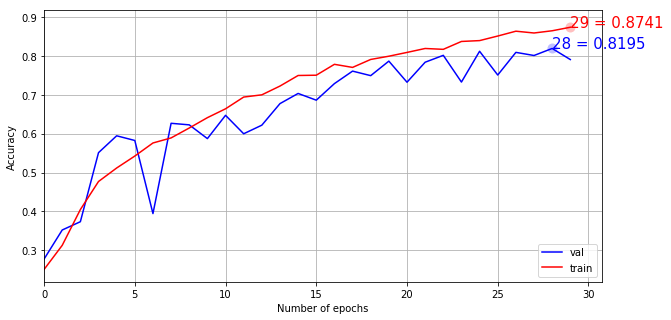

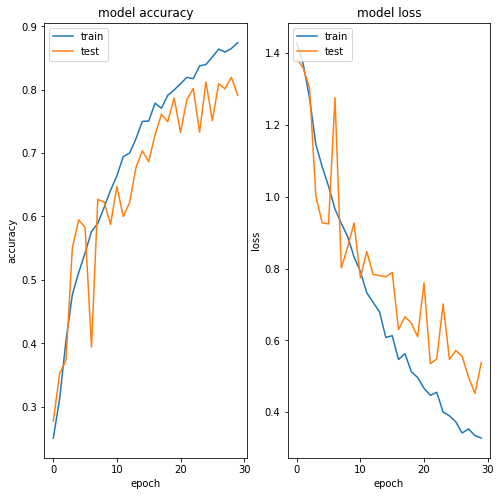

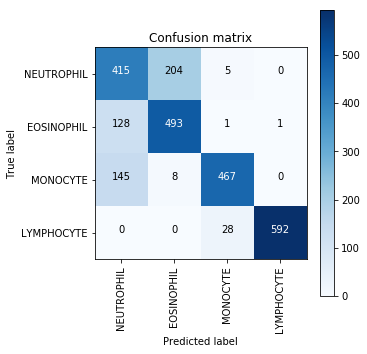

In [32]:
def runCustomModel2(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, 
                   learning_rate=1.0, lr_decay=0.0, shift_fraction=0.1,
                    save_dir='./result_custom_2'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_custom_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runCustomModel2(X_train_2, y_trainHot_2, X_test_2, y_testHot_2)


2487/2487 [==============================] - ETA: 10 - ETA: 2 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 305us/step

Keras CNN #1C - accuracy: 0.8158423804738314 

             precision    recall  f1-score   support

 NEUTROPHIL       0.59      0.94      0.73       624
 EOSINOPHIL       0.90      0.61      0.73       623
   MONOCYTE       1.00      0.73      0.84       620
 LYMPHOCYTE       0.98      0.98      0.98       620

avg / total       0.87      0.82      0.82      2487



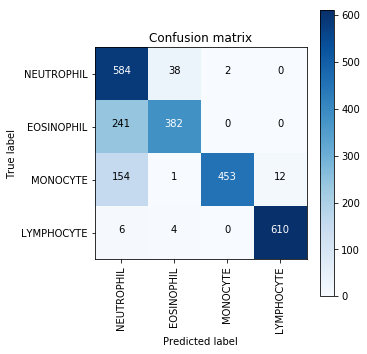

In [49]:
testCustomModel(X_train, y_trainHot, X_test, y_testHot, save_dir='./result_custom_2', file_name='/weights-29.h5')

Epoch 1/50
312/311 [==============================] - ETA: 9:34 - loss: 3.1051 - acc: 0.281 - ETA: 2:26 - loss: 5.6325 - acc: 0.257 - ETA: 1:25 - loss: 4.4743 - acc: 0.276 - ETA: 1:00 - loss: 3.9897 - acc: 0.262 - ETA: 47s - loss: 3.7161 - acc: 0.264 - ETA: 39s - loss: 3.5324 - acc: 0.25 - ETA: 33s - loss: 3.3960 - acc: 0.24 - ETA: 29s - loss: 3.2883 - acc: 0.24 - ETA: 26s - loss: 3.1993 - acc: 0.24 - ETA: 24s - loss: 3.1242 - acc: 0.23 - ETA: 23s - loss: 3.0795 - acc: 0.23 - ETA: 22s - loss: 3.0385 - acc: 0.23 - ETA: 21s - loss: 3.0004 - acc: 0.24 - ETA: 20s - loss: 2.9650 - acc: 0.24 - ETA: 19s - loss: 2.9320 - acc: 0.24 - ETA: 19s - loss: 2.9011 - acc: 0.24 - ETA: 18s - loss: 2.8716 - acc: 0.24 - ETA: 17s - loss: 2.8438 - acc: 0.24 - ETA: 17s - loss: 2.8174 - acc: 0.24 - ETA: 16s - loss: 2.7922 - acc: 0.24 - ETA: 16s - loss: 2.7680 - acc: 0.24 - ETA: 15s - loss: 2.7451 - acc: 0.24 - ETA: 15s - loss: 2.7231 - acc: 0.24 - ETA: 15s - loss: 2.7019 - acc: 0.24 - ETA: 14s - loss: 2.6816 -

312/311 [==============================] - ETA: 6s - loss: 1.3838 - acc: 0.312 - ETA: 5s - loss: 1.3817 - acc: 0.281 - ETA: 5s - loss: 1.3830 - acc: 0.267 - ETA: 5s - loss: 1.3830 - acc: 0.262 - ETA: 5s - loss: 1.3853 - acc: 0.252 - ETA: 5s - loss: 1.3859 - acc: 0.232 - ETA: 5s - loss: 1.3861 - acc: 0.228 - ETA: 5s - loss: 1.3861 - acc: 0.240 - ETA: 5s - loss: 1.3862 - acc: 0.233 - ETA: 6s - loss: 1.3859 - acc: 0.246 - ETA: 6s - loss: 1.3860 - acc: 0.248 - ETA: 6s - loss: 1.3861 - acc: 0.251 - ETA: 6s - loss: 1.3859 - acc: 0.257 - ETA: 6s - loss: 1.3861 - acc: 0.253 - ETA: 6s - loss: 1.3860 - acc: 0.258 - ETA: 6s - loss: 1.3861 - acc: 0.258 - ETA: 7s - loss: 1.3861 - acc: 0.259 - ETA: 7s - loss: 1.3863 - acc: 0.256 - ETA: 7s - loss: 1.3863 - acc: 0.257 - ETA: 7s - loss: 1.3863 - acc: 0.256 - ETA: 7s - loss: 1.3864 - acc: 0.259 - ETA: 7s - loss: 1.3864 - acc: 0.258 - ETA: 7s - loss: 1.3863 - acc: 0.260 - ETA: 7s - loss: 1.3863 - acc: 0.259 - ETA: 7s - loss: 1.3863 - acc: 0.260 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 1.3853 - acc: 0.343 - ETA: 6s - loss: 1.3768 - acc: 0.328 - ETA: 5s - loss: 1.3753 - acc: 0.330 - ETA: 5s - loss: 1.3746 - acc: 0.325 - ETA: 5s - loss: 1.3752 - acc: 0.322 - ETA: 5s - loss: 1.3726 - acc: 0.324 - ETA: 5s - loss: 1.3750 - acc: 0.314 - ETA: 5s - loss: 1.3733 - acc: 0.315 - ETA: 5s - loss: 1.3741 - acc: 0.313 - ETA: 6s - loss: 1.3741 - acc: 0.318 - ETA: 6s - loss: 1.3744 - acc: 0.321 - ETA: 6s - loss: 1.3741 - acc: 0.318 - ETA: 6s - loss: 1.3733 - acc: 0.320 - ETA: 6s - loss: 1.3720 - acc: 0.320 - ETA: 6s - loss: 1.3712 - acc: 0.321 - ETA: 6s - loss: 1.3698 - acc: 0.326 - ETA: 6s - loss: 1.3689 - acc: 0.326 - ETA: 6s - loss: 1.3690 - acc: 0.327 - ETA: 7s - loss: 1.3683 - acc: 0.328 - ETA: 7s - loss: 1.3690 - acc: 0.326 - ETA: 7s - loss: 1.3689 - acc: 0.327 - ETA: 7s - loss: 1.3694 - acc: 0.325 - ETA: 7s - loss: 1.3689 - acc: 0.327 - ETA: 7s - loss: 1.3691 - acc: 0.327 - ETA: 7s - loss: 1.3698 - acc: 0.324 - ETA: 7s

312/311 [==============================] - ETA: 7s - loss: 1.0485 - acc: 0.531 - ETA: 6s - loss: 1.1738 - acc: 0.421 - ETA: 6s - loss: 1.1661 - acc: 0.468 - ETA: 5s - loss: 1.2232 - acc: 0.456 - ETA: 5s - loss: 1.2193 - acc: 0.461 - ETA: 5s - loss: 1.1974 - acc: 0.472 - ETA: 5s - loss: 1.2001 - acc: 0.475 - ETA: 5s - loss: 1.1837 - acc: 0.481 - ETA: 5s - loss: 1.1692 - acc: 0.488 - ETA: 6s - loss: 1.1665 - acc: 0.480 - ETA: 6s - loss: 1.1622 - acc: 0.481 - ETA: 6s - loss: 1.1724 - acc: 0.470 - ETA: 6s - loss: 1.1731 - acc: 0.463 - ETA: 6s - loss: 1.1683 - acc: 0.462 - ETA: 6s - loss: 1.1674 - acc: 0.459 - ETA: 6s - loss: 1.1700 - acc: 0.456 - ETA: 6s - loss: 1.1707 - acc: 0.460 - ETA: 6s - loss: 1.1671 - acc: 0.465 - ETA: 7s - loss: 1.1651 - acc: 0.468 - ETA: 7s - loss: 1.1640 - acc: 0.468 - ETA: 7s - loss: 1.1644 - acc: 0.472 - ETA: 7s - loss: 1.1720 - acc: 0.470 - ETA: 7s - loss: 1.1748 - acc: 0.467 - ETA: 7s - loss: 1.1698 - acc: 0.469 - ETA: 7s - loss: 1.1721 - acc: 0.471 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 1.0497 - acc: 0.531 - ETA: 5s - loss: 1.0764 - acc: 0.484 - ETA: 5s - loss: 1.0904 - acc: 0.522 - ETA: 5s - loss: 1.0893 - acc: 0.546 - ETA: 5s - loss: 1.0923 - acc: 0.540 - ETA: 5s - loss: 1.0962 - acc: 0.523 - ETA: 5s - loss: 1.0768 - acc: 0.519 - ETA: 5s - loss: 1.0793 - acc: 0.522 - ETA: 5s - loss: 1.0835 - acc: 0.528 - ETA: 6s - loss: 1.0937 - acc: 0.521 - ETA: 6s - loss: 1.1068 - acc: 0.521 - ETA: 6s - loss: 1.1071 - acc: 0.526 - ETA: 6s - loss: 1.1151 - acc: 0.518 - ETA: 6s - loss: 1.1110 - acc: 0.516 - ETA: 6s - loss: 1.1016 - acc: 0.520 - ETA: 6s - loss: 1.1019 - acc: 0.520 - ETA: 7s - loss: 1.0909 - acc: 0.524 - ETA: 7s - loss: 1.0921 - acc: 0.525 - ETA: 7s - loss: 1.0919 - acc: 0.524 - ETA: 7s - loss: 1.0940 - acc: 0.520 - ETA: 7s - loss: 1.0906 - acc: 0.521 - ETA: 7s - loss: 1.0957 - acc: 0.518 - ETA: 7s - loss: 1.0956 - acc: 0.518 - ETA: 7s - loss: 1.0952 - acc: 0.518 - ETA: 7s - loss: 1.0996 - acc: 0.515 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.8965 - acc: 0.500 - ETA: 5s - loss: 0.9481 - acc: 0.593 - ETA: 5s - loss: 0.9763 - acc: 0.589 - ETA: 5s - loss: 1.0713 - acc: 0.543 - ETA: 5s - loss: 1.0491 - acc: 0.540 - ETA: 5s - loss: 1.0454 - acc: 0.537 - ETA: 5s - loss: 1.0433 - acc: 0.539 - ETA: 5s - loss: 1.0412 - acc: 0.539 - ETA: 5s - loss: 1.0507 - acc: 0.535 - ETA: 5s - loss: 1.0514 - acc: 0.530 - ETA: 6s - loss: 1.0492 - acc: 0.528 - ETA: 6s - loss: 1.0435 - acc: 0.533 - ETA: 6s - loss: 1.0451 - acc: 0.538 - ETA: 6s - loss: 1.0364 - acc: 0.540 - ETA: 6s - loss: 1.0388 - acc: 0.540 - ETA: 6s - loss: 1.0355 - acc: 0.547 - ETA: 6s - loss: 1.0389 - acc: 0.545 - ETA: 6s - loss: 1.0300 - acc: 0.549 - ETA: 6s - loss: 1.0284 - acc: 0.549 - ETA: 6s - loss: 1.0279 - acc: 0.549 - ETA: 6s - loss: 1.0297 - acc: 0.548 - ETA: 6s - loss: 1.0269 - acc: 0.549 - ETA: 6s - loss: 1.0250 - acc: 0.547 - ETA: 6s - loss: 1.0274 - acc: 0.547 - ETA: 6s - loss: 1.0369 - acc: 0.543 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.8165 - acc: 0.625 - ETA: 6s - loss: 0.8722 - acc: 0.656 - ETA: 6s - loss: 0.8724 - acc: 0.660 - ETA: 5s - loss: 0.9129 - acc: 0.640 - ETA: 5s - loss: 0.9145 - acc: 0.627 - ETA: 5s - loss: 0.9475 - acc: 0.617 - ETA: 5s - loss: 0.9396 - acc: 0.613 - ETA: 5s - loss: 0.9350 - acc: 0.616 - ETA: 5s - loss: 0.9230 - acc: 0.617 - ETA: 6s - loss: 0.9214 - acc: 0.616 - ETA: 6s - loss: 0.9229 - acc: 0.611 - ETA: 6s - loss: 0.9203 - acc: 0.609 - ETA: 6s - loss: 0.9190 - acc: 0.611 - ETA: 6s - loss: 0.9179 - acc: 0.613 - ETA: 6s - loss: 0.9355 - acc: 0.601 - ETA: 6s - loss: 0.9331 - acc: 0.599 - ETA: 6s - loss: 0.9288 - acc: 0.596 - ETA: 7s - loss: 0.9299 - acc: 0.591 - ETA: 7s - loss: 0.9337 - acc: 0.586 - ETA: 7s - loss: 0.9281 - acc: 0.593 - ETA: 7s - loss: 0.9204 - acc: 0.597 - ETA: 7s - loss: 0.9192 - acc: 0.595 - ETA: 7s - loss: 0.9161 - acc: 0.593 - ETA: 7s - loss: 0.9182 - acc: 0.593 - ETA: 7s - loss: 0.9189 - acc: 0.595 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.7636 - acc: 0.687 - ETA: 5s - loss: 0.6854 - acc: 0.726 - ETA: 5s - loss: 0.7235 - acc: 0.692 - ETA: 5s - loss: 0.7917 - acc: 0.659 - ETA: 5s - loss: 0.7868 - acc: 0.680 - ETA: 5s - loss: 0.7738 - acc: 0.681 - ETA: 5s - loss: 0.7654 - acc: 0.684 - ETA: 5s - loss: 0.7662 - acc: 0.683 - ETA: 5s - loss: 0.7591 - acc: 0.686 - ETA: 6s - loss: 0.7654 - acc: 0.681 - ETA: 6s - loss: 0.7711 - acc: 0.675 - ETA: 6s - loss: 0.7772 - acc: 0.670 - ETA: 6s - loss: 0.7811 - acc: 0.665 - ETA: 6s - loss: 0.7720 - acc: 0.668 - ETA: 6s - loss: 0.7763 - acc: 0.664 - ETA: 6s - loss: 0.7805 - acc: 0.662 - ETA: 7s - loss: 0.7793 - acc: 0.658 - ETA: 7s - loss: 0.7735 - acc: 0.663 - ETA: 7s - loss: 0.7733 - acc: 0.661 - ETA: 7s - loss: 0.7792 - acc: 0.655 - ETA: 7s - loss: 0.7712 - acc: 0.660 - ETA: 7s - loss: 0.7779 - acc: 0.656 - ETA: 7s - loss: 0.7775 - acc: 0.658 - ETA: 7s - loss: 0.7851 - acc: 0.649 - ETA: 7s - loss: 0.7892 - acc: 0.648 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.4200 - acc: 0.906 - ETA: 6s - loss: 0.5271 - acc: 0.812 - ETA: 6s - loss: 0.6119 - acc: 0.754 - ETA: 6s - loss: 0.7161 - acc: 0.709 - ETA: 6s - loss: 0.7271 - acc: 0.704 - ETA: 6s - loss: 0.7333 - acc: 0.687 - ETA: 5s - loss: 0.7323 - acc: 0.679 - ETA: 5s - loss: 0.7526 - acc: 0.667 - ETA: 5s - loss: 0.7368 - acc: 0.678 - ETA: 6s - loss: 0.7414 - acc: 0.675 - ETA: 6s - loss: 0.7425 - acc: 0.671 - ETA: 6s - loss: 0.7437 - acc: 0.667 - ETA: 6s - loss: 0.7382 - acc: 0.668 - ETA: 6s - loss: 0.7407 - acc: 0.662 - ETA: 6s - loss: 0.7403 - acc: 0.660 - ETA: 7s - loss: 0.7380 - acc: 0.662 - ETA: 7s - loss: 0.7335 - acc: 0.668 - ETA: 7s - loss: 0.7277 - acc: 0.671 - ETA: 7s - loss: 0.7216 - acc: 0.675 - ETA: 7s - loss: 0.7238 - acc: 0.672 - ETA: 7s - loss: 0.7206 - acc: 0.671 - ETA: 7s - loss: 0.7161 - acc: 0.671 - ETA: 7s - loss: 0.7160 - acc: 0.670 - ETA: 7s - loss: 0.7122 - acc: 0.674 - ETA: 7s - loss: 0.7123 - acc: 0.673 - ETA: 7s

312/311 [==============================] - ETA: 7s - loss: 0.5763 - acc: 0.687 - ETA: 6s - loss: 0.7588 - acc: 0.664 - ETA: 5s - loss: 0.7838 - acc: 0.651 - ETA: 5s - loss: 0.7344 - acc: 0.675 - ETA: 5s - loss: 0.7430 - acc: 0.677 - ETA: 5s - loss: 0.7121 - acc: 0.685 - ETA: 5s - loss: 0.6971 - acc: 0.690 - ETA: 5s - loss: 0.6973 - acc: 0.693 - ETA: 5s - loss: 0.7072 - acc: 0.679 - ETA: 6s - loss: 0.7102 - acc: 0.676 - ETA: 6s - loss: 0.7157 - acc: 0.675 - ETA: 6s - loss: 0.7097 - acc: 0.677 - ETA: 6s - loss: 0.7039 - acc: 0.681 - ETA: 6s - loss: 0.7055 - acc: 0.679 - ETA: 6s - loss: 0.7211 - acc: 0.674 - ETA: 6s - loss: 0.7279 - acc: 0.675 - ETA: 6s - loss: 0.7263 - acc: 0.673 - ETA: 6s - loss: 0.7261 - acc: 0.676 - ETA: 6s - loss: 0.7229 - acc: 0.676 - ETA: 6s - loss: 0.7226 - acc: 0.675 - ETA: 7s - loss: 0.7232 - acc: 0.674 - ETA: 7s - loss: 0.7165 - acc: 0.675 - ETA: 7s - loss: 0.7106 - acc: 0.676 - ETA: 7s - loss: 0.7127 - acc: 0.675 - ETA: 7s - loss: 0.7111 - acc: 0.675 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 0.9106 - acc: 0.687 - ETA: 5s - loss: 0.6508 - acc: 0.710 - ETA: 5s - loss: 0.6391 - acc: 0.678 - ETA: 5s - loss: 0.6204 - acc: 0.690 - ETA: 5s - loss: 0.5935 - acc: 0.706 - ETA: 5s - loss: 0.5956 - acc: 0.714 - ETA: 5s - loss: 0.6099 - acc: 0.718 - ETA: 5s - loss: 0.6263 - acc: 0.714 - ETA: 5s - loss: 0.6397 - acc: 0.712 - ETA: 5s - loss: 0.6344 - acc: 0.716 - ETA: 6s - loss: 0.6257 - acc: 0.715 - ETA: 6s - loss: 0.6248 - acc: 0.713 - ETA: 6s - loss: 0.6246 - acc: 0.706 - ETA: 6s - loss: 0.6184 - acc: 0.710 - ETA: 6s - loss: 0.6220 - acc: 0.710 - ETA: 6s - loss: 0.6175 - acc: 0.713 - ETA: 6s - loss: 0.6194 - acc: 0.712 - ETA: 6s - loss: 0.6129 - acc: 0.714 - ETA: 7s - loss: 0.6179 - acc: 0.709 - ETA: 7s - loss: 0.6161 - acc: 0.710 - ETA: 7s - loss: 0.6238 - acc: 0.709 - ETA: 7s - loss: 0.6258 - acc: 0.708 - ETA: 7s - loss: 0.6234 - acc: 0.709 - ETA: 7s - loss: 0.6189 - acc: 0.713 - ETA: 7s - loss: 0.6176 - acc: 0.712 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 0.8234 - acc: 0.625 - ETA: 5s - loss: 0.5975 - acc: 0.726 - ETA: 5s - loss: 0.6191 - acc: 0.736 - ETA: 5s - loss: 0.6223 - acc: 0.746 - ETA: 5s - loss: 0.6193 - acc: 0.745 - ETA: 5s - loss: 0.6024 - acc: 0.755 - ETA: 5s - loss: 0.5925 - acc: 0.766 - ETA: 5s - loss: 0.5998 - acc: 0.762 - ETA: 5s - loss: 0.6291 - acc: 0.759 - ETA: 5s - loss: 0.6689 - acc: 0.736 - ETA: 6s - loss: 0.6636 - acc: 0.735 - ETA: 6s - loss: 0.6613 - acc: 0.737 - ETA: 6s - loss: 0.6556 - acc: 0.740 - ETA: 6s - loss: 0.6400 - acc: 0.743 - ETA: 6s - loss: 0.6384 - acc: 0.740 - ETA: 6s - loss: 0.6410 - acc: 0.742 - ETA: 6s - loss: 0.6399 - acc: 0.741 - ETA: 6s - loss: 0.6393 - acc: 0.745 - ETA: 6s - loss: 0.6335 - acc: 0.747 - ETA: 6s - loss: 0.6340 - acc: 0.745 - ETA: 6s - loss: 0.6441 - acc: 0.741 - ETA: 6s - loss: 0.6374 - acc: 0.744 - ETA: 6s - loss: 0.6342 - acc: 0.744 - ETA: 6s - loss: 0.6287 - acc: 0.745 - ETA: 6s - loss: 0.6251 - acc: 0.745 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 0.7305 - acc: 0.656 - ETA: 5s - loss: 0.5938 - acc: 0.765 - ETA: 5s - loss: 0.5877 - acc: 0.758 - ETA: 5s - loss: 0.5590 - acc: 0.781 - ETA: 5s - loss: 0.5570 - acc: 0.783 - ETA: 5s - loss: 0.5469 - acc: 0.777 - ETA: 5s - loss: 0.5473 - acc: 0.779 - ETA: 5s - loss: 0.5316 - acc: 0.785 - ETA: 5s - loss: 0.5303 - acc: 0.786 - ETA: 5s - loss: 0.5295 - acc: 0.787 - ETA: 6s - loss: 0.5471 - acc: 0.781 - ETA: 6s - loss: 0.5521 - acc: 0.782 - ETA: 6s - loss: 0.5808 - acc: 0.774 - ETA: 6s - loss: 0.5901 - acc: 0.763 - ETA: 6s - loss: 0.5939 - acc: 0.762 - ETA: 6s - loss: 0.5885 - acc: 0.768 - ETA: 6s - loss: 0.5873 - acc: 0.769 - ETA: 6s - loss: 0.5837 - acc: 0.770 - ETA: 6s - loss: 0.5830 - acc: 0.766 - ETA: 6s - loss: 0.5823 - acc: 0.764 - ETA: 6s - loss: 0.5790 - acc: 0.765 - ETA: 6s - loss: 0.5735 - acc: 0.767 - ETA: 6s - loss: 0.5719 - acc: 0.768 - ETA: 6s - loss: 0.5727 - acc: 0.770 - ETA: 6s - loss: 0.5688 - acc: 0.771 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.4628 - acc: 0.781 - ETA: 5s - loss: 0.5432 - acc: 0.820 - ETA: 5s - loss: 0.5187 - acc: 0.808 - ETA: 5s - loss: 0.4969 - acc: 0.809 - ETA: 5s - loss: 0.5317 - acc: 0.798 - ETA: 5s - loss: 0.5155 - acc: 0.808 - ETA: 5s - loss: 0.5343 - acc: 0.794 - ETA: 5s - loss: 0.5286 - acc: 0.801 - ETA: 5s - loss: 0.5259 - acc: 0.805 - ETA: 5s - loss: 0.5224 - acc: 0.805 - ETA: 6s - loss: 0.5181 - acc: 0.807 - ETA: 6s - loss: 0.5199 - acc: 0.803 - ETA: 6s - loss: 0.5250 - acc: 0.801 - ETA: 6s - loss: 0.5282 - acc: 0.799 - ETA: 6s - loss: 0.5349 - acc: 0.797 - ETA: 6s - loss: 0.5329 - acc: 0.800 - ETA: 6s - loss: 0.5286 - acc: 0.804 - ETA: 6s - loss: 0.5347 - acc: 0.805 - ETA: 6s - loss: 0.5477 - acc: 0.800 - ETA: 6s - loss: 0.5470 - acc: 0.800 - ETA: 6s - loss: 0.5403 - acc: 0.804 - ETA: 6s - loss: 0.5353 - acc: 0.805 - ETA: 7s - loss: 0.5322 - acc: 0.806 - ETA: 7s - loss: 0.5295 - acc: 0.806 - ETA: 7s - loss: 0.5249 - acc: 0.808 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.4178 - acc: 0.906 - ETA: 6s - loss: 0.5245 - acc: 0.796 - ETA: 5s - loss: 0.5424 - acc: 0.785 - ETA: 5s - loss: 0.5375 - acc: 0.771 - ETA: 5s - loss: 0.5152 - acc: 0.774 - ETA: 5s - loss: 0.5070 - acc: 0.783 - ETA: 5s - loss: 0.5248 - acc: 0.786 - ETA: 5s - loss: 0.5334 - acc: 0.782 - ETA: 6s - loss: 0.5289 - acc: 0.787 - ETA: 6s - loss: 0.5231 - acc: 0.793 - ETA: 6s - loss: 0.5193 - acc: 0.794 - ETA: 6s - loss: 0.5135 - acc: 0.795 - ETA: 6s - loss: 0.5061 - acc: 0.795 - ETA: 7s - loss: 0.5028 - acc: 0.798 - ETA: 7s - loss: 0.5027 - acc: 0.796 - ETA: 7s - loss: 0.4942 - acc: 0.799 - ETA: 7s - loss: 0.4871 - acc: 0.802 - ETA: 7s - loss: 0.4812 - acc: 0.807 - ETA: 7s - loss: 0.4843 - acc: 0.806 - ETA: 7s - loss: 0.4812 - acc: 0.809 - ETA: 7s - loss: 0.4772 - acc: 0.812 - ETA: 7s - loss: 0.4787 - acc: 0.810 - ETA: 7s - loss: 0.4791 - acc: 0.811 - ETA: 7s - loss: 0.4766 - acc: 0.814 - ETA: 7s - loss: 0.4747 - acc: 0.814 - ETA: 7s

312/311 [==============================] - ETA: 9s - loss: 0.2752 - acc: 0.906 - ETA: 10s - loss: 0.3040 - acc: 0.87 - ETA: 9s - loss: 0.2911 - acc: 0.8875 - ETA: 9s - loss: 0.3645 - acc: 0.870 - ETA: 9s - loss: 0.3332 - acc: 0.881 - ETA: 9s - loss: 0.4115 - acc: 0.860 - ETA: 9s - loss: 0.4166 - acc: 0.864 - ETA: 9s - loss: 0.4172 - acc: 0.858 - ETA: 8s - loss: 0.4156 - acc: 0.863 - ETA: 9s - loss: 0.4114 - acc: 0.861 - ETA: 9s - loss: 0.4089 - acc: 0.860 - ETA: 8s - loss: 0.4144 - acc: 0.855 - ETA: 8s - loss: 0.4297 - acc: 0.848 - ETA: 8s - loss: 0.4332 - acc: 0.846 - ETA: 8s - loss: 0.4334 - acc: 0.846 - ETA: 8s - loss: 0.4426 - acc: 0.841 - ETA: 8s - loss: 0.4444 - acc: 0.840 - ETA: 8s - loss: 0.4487 - acc: 0.842 - ETA: 8s - loss: 0.4480 - acc: 0.842 - ETA: 8s - loss: 0.4496 - acc: 0.840 - ETA: 8s - loss: 0.4494 - acc: 0.839 - ETA: 8s - loss: 0.4474 - acc: 0.839 - ETA: 8s - loss: 0.4432 - acc: 0.839 - ETA: 8s - loss: 0.4425 - acc: 0.838 - ETA: 8s - loss: 0.4382 - acc: 0.839 - ETA: 8

312/311 [==============================] - ETA: 6s - loss: 0.6277 - acc: 0.875 - ETA: 8s - loss: 0.5837 - acc: 0.802 - ETA: 9s - loss: 0.5609 - acc: 0.818 - ETA: 7s - loss: 0.5229 - acc: 0.804 - ETA: 8s - loss: 0.5045 - acc: 0.821 - ETA: 9s - loss: 0.5134 - acc: 0.828 - ETA: 9s - loss: 0.4837 - acc: 0.843 - ETA: 9s - loss: 0.5005 - acc: 0.837 - ETA: 9s - loss: 0.5057 - acc: 0.831 - ETA: 9s - loss: 0.5029 - acc: 0.831 - ETA: 9s - loss: 0.4939 - acc: 0.831 - ETA: 9s - loss: 0.4893 - acc: 0.829 - ETA: 9s - loss: 0.5057 - acc: 0.829 - ETA: 9s - loss: 0.5045 - acc: 0.828 - ETA: 8s - loss: 0.4916 - acc: 0.829 - ETA: 8s - loss: 0.4818 - acc: 0.828 - ETA: 8s - loss: 0.4829 - acc: 0.825 - ETA: 8s - loss: 0.4673 - acc: 0.829 - ETA: 8s - loss: 0.4643 - acc: 0.832 - ETA: 8s - loss: 0.4654 - acc: 0.831 - ETA: 8s - loss: 0.4601 - acc: 0.834 - ETA: 8s - loss: 0.4572 - acc: 0.834 - ETA: 8s - loss: 0.4603 - acc: 0.835 - ETA: 8s - loss: 0.4563 - acc: 0.836 - ETA: 8s - loss: 0.4521 - acc: 0.837 - ETA: 8s

312/311 [==============================] - ETA: 9s - loss: 0.4474 - acc: 0.812 - ETA: 9s - loss: 0.3051 - acc: 0.875 - ETA: 9s - loss: 0.3139 - acc: 0.868 - ETA: 8s - loss: 0.3361 - acc: 0.859 - ETA: 8s - loss: 0.3531 - acc: 0.853 - ETA: 8s - loss: 0.3405 - acc: 0.863 - ETA: 8s - loss: 0.3407 - acc: 0.858 - ETA: 8s - loss: 0.3445 - acc: 0.864 - ETA: 8s - loss: 0.3565 - acc: 0.856 - ETA: 8s - loss: 0.3783 - acc: 0.854 - ETA: 8s - loss: 0.4170 - acc: 0.843 - ETA: 8s - loss: 0.5181 - acc: 0.810 - ETA: 7s - loss: 0.5223 - acc: 0.808 - ETA: 7s - loss: 0.5257 - acc: 0.802 - ETA: 7s - loss: 0.5208 - acc: 0.800 - ETA: 7s - loss: 0.5100 - acc: 0.806 - ETA: 7s - loss: 0.5019 - acc: 0.809 - ETA: 7s - loss: 0.4965 - acc: 0.811 - ETA: 7s - loss: 0.4866 - acc: 0.814 - ETA: 7s - loss: 0.4843 - acc: 0.813 - ETA: 7s - loss: 0.4778 - acc: 0.817 - ETA: 7s - loss: 0.4723 - acc: 0.820 - ETA: 7s - loss: 0.4735 - acc: 0.819 - ETA: 7s - loss: 0.4710 - acc: 0.820 - ETA: 7s - loss: 0.4670 - acc: 0.822 - ETA: 7s

312/311 [==============================] - ETA: 7s - loss: 0.4938 - acc: 0.781 - ETA: 8s - loss: 0.5561 - acc: 0.791 - ETA: 8s - loss: 0.5561 - acc: 0.787 - ETA: 7s - loss: 0.5007 - acc: 0.816 - ETA: 7s - loss: 0.4645 - acc: 0.835 - ETA: 7s - loss: 0.4830 - acc: 0.819 - ETA: 7s - loss: 0.4624 - acc: 0.828 - ETA: 6s - loss: 0.4423 - acc: 0.838 - ETA: 6s - loss: 0.4359 - acc: 0.845 - ETA: 6s - loss: 0.4108 - acc: 0.856 - ETA: 6s - loss: 0.4007 - acc: 0.856 - ETA: 6s - loss: 0.3971 - acc: 0.858 - ETA: 6s - loss: 0.3991 - acc: 0.854 - ETA: 6s - loss: 0.3954 - acc: 0.854 - ETA: 6s - loss: 0.3885 - acc: 0.859 - ETA: 6s - loss: 0.3935 - acc: 0.859 - ETA: 6s - loss: 0.3977 - acc: 0.855 - ETA: 6s - loss: 0.3992 - acc: 0.853 - ETA: 6s - loss: 0.4020 - acc: 0.852 - ETA: 6s - loss: 0.3974 - acc: 0.853 - ETA: 6s - loss: 0.3986 - acc: 0.854 - ETA: 7s - loss: 0.3947 - acc: 0.855 - ETA: 6s - loss: 0.4028 - acc: 0.851 - ETA: 7s - loss: 0.4034 - acc: 0.849 - ETA: 6s - loss: 0.3971 - acc: 0.852 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 0.2480 - acc: 0.937 - ETA: 7s - loss: 0.2195 - acc: 0.914 - ETA: 7s - loss: 0.2647 - acc: 0.901 - ETA: 7s - loss: 0.2486 - acc: 0.909 - ETA: 8s - loss: 0.2579 - acc: 0.906 - ETA: 8s - loss: 0.2596 - acc: 0.908 - ETA: 8s - loss: 0.2759 - acc: 0.900 - ETA: 8s - loss: 0.2848 - acc: 0.895 - ETA: 8s - loss: 0.3060 - acc: 0.888 - ETA: 8s - loss: 0.3098 - acc: 0.888 - ETA: 8s - loss: 0.3100 - acc: 0.888 - ETA: 8s - loss: 0.3077 - acc: 0.890 - ETA: 8s - loss: 0.3038 - acc: 0.888 - ETA: 8s - loss: 0.3061 - acc: 0.885 - ETA: 8s - loss: 0.3056 - acc: 0.883 - ETA: 8s - loss: 0.3042 - acc: 0.883 - ETA: 8s - loss: 0.3032 - acc: 0.882 - ETA: 8s - loss: 0.3094 - acc: 0.883 - ETA: 8s - loss: 0.3045 - acc: 0.887 - ETA: 7s - loss: 0.3084 - acc: 0.883 - ETA: 7s - loss: 0.3100 - acc: 0.885 - ETA: 7s - loss: 0.3072 - acc: 0.885 - ETA: 7s - loss: 0.3112 - acc: 0.886 - ETA: 7s - loss: 0.3134 - acc: 0.885 - ETA: 7s - loss: 0.3140 - acc: 0.884 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.2219 - acc: 0.968 - ETA: 5s - loss: 0.2302 - acc: 0.960 - ETA: 5s - loss: 0.2623 - acc: 0.928 - ETA: 5s - loss: 0.2762 - acc: 0.921 - ETA: 5s - loss: 0.2792 - acc: 0.911 - ETA: 5s - loss: 0.2914 - acc: 0.906 - ETA: 5s - loss: 0.2836 - acc: 0.907 - ETA: 5s - loss: 0.2996 - acc: 0.897 - ETA: 5s - loss: 0.3612 - acc: 0.875 - ETA: 5s - loss: 0.3644 - acc: 0.872 - ETA: 6s - loss: 0.3629 - acc: 0.875 - ETA: 6s - loss: 0.3626 - acc: 0.875 - ETA: 6s - loss: 0.3619 - acc: 0.875 - ETA: 6s - loss: 0.3659 - acc: 0.873 - ETA: 6s - loss: 0.3656 - acc: 0.869 - ETA: 6s - loss: 0.3653 - acc: 0.868 - ETA: 6s - loss: 0.3832 - acc: 0.865 - ETA: 6s - loss: 0.3868 - acc: 0.863 - ETA: 6s - loss: 0.3846 - acc: 0.865 - ETA: 6s - loss: 0.3868 - acc: 0.865 - ETA: 6s - loss: 0.3796 - acc: 0.867 - ETA: 6s - loss: 0.3766 - acc: 0.867 - ETA: 6s - loss: 0.3803 - acc: 0.867 - ETA: 6s - loss: 0.3809 - acc: 0.865 - ETA: 6s - loss: 0.3774 - acc: 0.866 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.7991 - acc: 0.781 - ETA: 5s - loss: 0.6934 - acc: 0.773 - ETA: 5s - loss: 0.6572 - acc: 0.790 - ETA: 5s - loss: 0.7375 - acc: 0.762 - ETA: 5s - loss: 0.6780 - acc: 0.778 - ETA: 5s - loss: 0.6202 - acc: 0.796 - ETA: 5s - loss: 0.5647 - acc: 0.812 - ETA: 5s - loss: 0.5225 - acc: 0.828 - ETA: 5s - loss: 0.4930 - acc: 0.841 - ETA: 5s - loss: 0.4728 - acc: 0.846 - ETA: 6s - loss: 0.4635 - acc: 0.846 - ETA: 6s - loss: 0.4510 - acc: 0.849 - ETA: 6s - loss: 0.4360 - acc: 0.853 - ETA: 6s - loss: 0.4299 - acc: 0.855 - ETA: 6s - loss: 0.4185 - acc: 0.859 - ETA: 6s - loss: 0.4144 - acc: 0.860 - ETA: 6s - loss: 0.4166 - acc: 0.858 - ETA: 6s - loss: 0.4085 - acc: 0.859 - ETA: 6s - loss: 0.4053 - acc: 0.859 - ETA: 6s - loss: 0.3980 - acc: 0.863 - ETA: 6s - loss: 0.3939 - acc: 0.864 - ETA: 6s - loss: 0.3840 - acc: 0.867 - ETA: 6s - loss: 0.3828 - acc: 0.866 - ETA: 6s - loss: 0.3775 - acc: 0.868 - ETA: 6s - loss: 0.3771 - acc: 0.869 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.2350 - acc: 0.906 - ETA: 5s - loss: 0.4160 - acc: 0.843 - ETA: 5s - loss: 0.3419 - acc: 0.866 - ETA: 5s - loss: 0.3058 - acc: 0.896 - ETA: 5s - loss: 0.3183 - acc: 0.896 - ETA: 5s - loss: 0.3031 - acc: 0.902 - ETA: 5s - loss: 0.3041 - acc: 0.899 - ETA: 5s - loss: 0.3010 - acc: 0.903 - ETA: 5s - loss: 0.2923 - acc: 0.905 - ETA: 6s - loss: 0.2956 - acc: 0.906 - ETA: 6s - loss: 0.2975 - acc: 0.906 - ETA: 6s - loss: 0.2960 - acc: 0.904 - ETA: 6s - loss: 0.2985 - acc: 0.903 - ETA: 6s - loss: 0.3026 - acc: 0.902 - ETA: 6s - loss: 0.2973 - acc: 0.902 - ETA: 6s - loss: 0.2935 - acc: 0.901 - ETA: 6s - loss: 0.2944 - acc: 0.901 - ETA: 6s - loss: 0.2933 - acc: 0.902 - ETA: 6s - loss: 0.2908 - acc: 0.902 - ETA: 6s - loss: 0.2976 - acc: 0.900 - ETA: 7s - loss: 0.2970 - acc: 0.901 - ETA: 7s - loss: 0.2966 - acc: 0.902 - ETA: 7s - loss: 0.2943 - acc: 0.903 - ETA: 7s - loss: 0.2921 - acc: 0.904 - ETA: 7s - loss: 0.2908 - acc: 0.903 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 0.3568 - acc: 0.937 - ETA: 5s - loss: 0.2619 - acc: 0.912 - ETA: 6s - loss: 0.2630 - acc: 0.898 - ETA: 6s - loss: 0.2608 - acc: 0.897 - ETA: 5s - loss: 0.2724 - acc: 0.890 - ETA: 5s - loss: 0.2658 - acc: 0.898 - ETA: 5s - loss: 0.2669 - acc: 0.900 - ETA: 5s - loss: 0.2615 - acc: 0.903 - ETA: 6s - loss: 0.2633 - acc: 0.905 - ETA: 6s - loss: 0.2880 - acc: 0.894 - ETA: 6s - loss: 0.2875 - acc: 0.892 - ETA: 6s - loss: 0.2832 - acc: 0.894 - ETA: 6s - loss: 0.2804 - acc: 0.895 - ETA: 6s - loss: 0.2762 - acc: 0.898 - ETA: 6s - loss: 0.2782 - acc: 0.897 - ETA: 6s - loss: 0.2755 - acc: 0.899 - ETA: 6s - loss: 0.2813 - acc: 0.900 - ETA: 6s - loss: 0.2768 - acc: 0.902 - ETA: 6s - loss: 0.2760 - acc: 0.902 - ETA: 7s - loss: 0.2772 - acc: 0.899 - ETA: 7s - loss: 0.2741 - acc: 0.900 - ETA: 7s - loss: 0.2698 - acc: 0.901 - ETA: 7s - loss: 0.2732 - acc: 0.899 - ETA: 7s - loss: 0.2730 - acc: 0.898 - ETA: 7s - loss: 0.2785 - acc: 0.897 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.0985 - acc: 1.000 - ETA: 5s - loss: 0.2883 - acc: 0.937 - ETA: 5s - loss: 0.3872 - acc: 0.879 - ETA: 5s - loss: 0.4468 - acc: 0.846 - ETA: 5s - loss: 0.4640 - acc: 0.838 - ETA: 5s - loss: 0.4323 - acc: 0.855 - ETA: 5s - loss: 0.4137 - acc: 0.863 - ETA: 5s - loss: 0.3963 - acc: 0.867 - ETA: 5s - loss: 0.3768 - acc: 0.873 - ETA: 5s - loss: 0.3647 - acc: 0.876 - ETA: 6s - loss: 0.3648 - acc: 0.877 - ETA: 6s - loss: 0.3575 - acc: 0.880 - ETA: 6s - loss: 0.3543 - acc: 0.879 - ETA: 6s - loss: 0.3561 - acc: 0.878 - ETA: 6s - loss: 0.3505 - acc: 0.880 - ETA: 6s - loss: 0.3522 - acc: 0.877 - ETA: 6s - loss: 0.3446 - acc: 0.880 - ETA: 6s - loss: 0.3379 - acc: 0.883 - ETA: 6s - loss: 0.3302 - acc: 0.887 - ETA: 6s - loss: 0.3298 - acc: 0.887 - ETA: 6s - loss: 0.3240 - acc: 0.889 - ETA: 6s - loss: 0.3167 - acc: 0.892 - ETA: 6s - loss: 0.3165 - acc: 0.890 - ETA: 6s - loss: 0.3109 - acc: 0.892 - ETA: 6s - loss: 0.3048 - acc: 0.894 - ETA: 6s

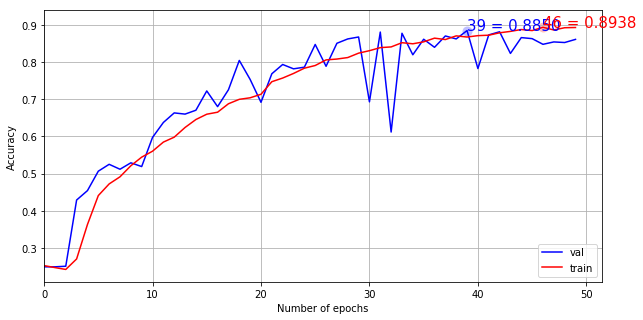

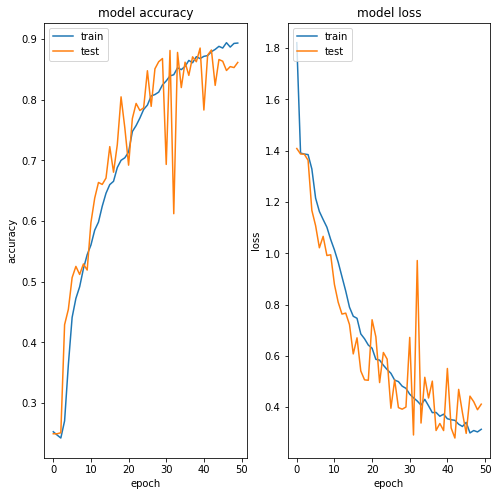

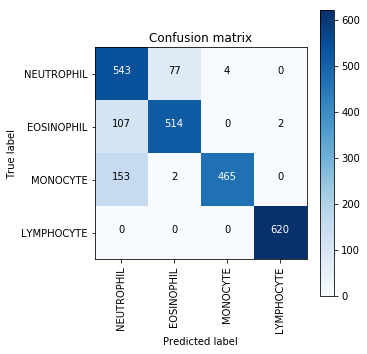

In [68]:
def runOurModel(x_train, y_train, x_test, y_test, epochs=50, batch_size=32, 
                          learning_rate=1.0, lr_decay=0.0, shift_fraction=0.1, rotation_range=10, 
                          shift_range=0.1, horizontal_flip=True, vertical_flip=False, optimizer='Adadelta',
                          save_dir='./result_ourself'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_our_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        shift_fraction=shift_fraction, rotation_range=rotation_range, shift_range=shift_range, 
        horizontal_flip=horizontal_flip, vertical_flip=vertical_flip, optimizer=optimizer,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runOurModel(X_train, y_trainHot, X_test, y_testHot)

Epoch 1/50
312/311 [==============================] - ETA: 6:35 - loss: 3.0987 - acc: 0.250 - ETA: 1:42 - loss: 3.9514 - acc: 0.203 - ETA: 1:00 - loss: 3.5297 - acc: 0.209 - ETA: 43s - loss: 3.3305 - acc: 0.237 - ETA: 34s - loss: 3.2071 - acc: 0.24 - ETA: 29s - loss: 3.1171 - acc: 0.23 - ETA: 25s - loss: 3.0459 - acc: 0.24 - ETA: 22s - loss: 2.9860 - acc: 0.24 - ETA: 20s - loss: 2.9341 - acc: 0.24 - ETA: 19s - loss: 2.9024 - acc: 0.25 - ETA: 18s - loss: 2.8731 - acc: 0.25 - ETA: 17s - loss: 2.8457 - acc: 0.25 - ETA: 17s - loss: 2.8195 - acc: 0.25 - ETA: 16s - loss: 2.7949 - acc: 0.24 - ETA: 15s - loss: 2.7714 - acc: 0.24 - ETA: 15s - loss: 2.7487 - acc: 0.24 - ETA: 15s - loss: 2.7270 - acc: 0.24 - ETA: 14s - loss: 2.7063 - acc: 0.24 - ETA: 14s - loss: 2.6864 - acc: 0.24 - ETA: 13s - loss: 2.6670 - acc: 0.24 - ETA: 13s - loss: 2.6484 - acc: 0.24 - ETA: 13s - loss: 2.6305 - acc: 0.24 - ETA: 13s - loss: 2.6134 - acc: 0.24 - ETA: 12s - loss: 2.5968 - acc: 0.24 - ETA: 12s - loss: 2.5805 - a

312/311 [==============================] - ETA: 5s - loss: 1.3878 - acc: 0.250 - ETA: 5s - loss: 1.3874 - acc: 0.218 - ETA: 5s - loss: 1.3877 - acc: 0.205 - ETA: 5s - loss: 1.3875 - acc: 0.200 - ETA: 5s - loss: 1.3876 - acc: 0.194 - ETA: 5s - loss: 1.3876 - acc: 0.199 - ETA: 5s - loss: 1.3874 - acc: 0.208 - ETA: 5s - loss: 1.3875 - acc: 0.213 - ETA: 5s - loss: 1.3874 - acc: 0.213 - ETA: 5s - loss: 1.3872 - acc: 0.226 - ETA: 6s - loss: 1.3872 - acc: 0.223 - ETA: 6s - loss: 1.3871 - acc: 0.222 - ETA: 6s - loss: 1.3870 - acc: 0.225 - ETA: 6s - loss: 1.3869 - acc: 0.228 - ETA: 6s - loss: 1.3869 - acc: 0.227 - ETA: 6s - loss: 1.3868 - acc: 0.227 - ETA: 6s - loss: 1.3868 - acc: 0.228 - ETA: 6s - loss: 1.3868 - acc: 0.227 - ETA: 6s - loss: 1.3866 - acc: 0.233 - ETA: 6s - loss: 1.3867 - acc: 0.228 - ETA: 6s - loss: 1.3866 - acc: 0.229 - ETA: 6s - loss: 1.3865 - acc: 0.228 - ETA: 6s - loss: 1.3866 - acc: 0.229 - ETA: 6s - loss: 1.3866 - acc: 0.230 - ETA: 6s - loss: 1.3865 - acc: 0.233 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3872 - acc: 0.156 - ETA: 5s - loss: 1.3873 - acc: 0.226 - ETA: 5s - loss: 1.3877 - acc: 0.209 - ETA: 5s - loss: 1.3871 - acc: 0.225 - ETA: 5s - loss: 1.3874 - acc: 0.213 - ETA: 5s - loss: 1.3872 - acc: 0.220 - ETA: 5s - loss: 1.3867 - acc: 0.236 - ETA: 5s - loss: 1.3865 - acc: 0.247 - ETA: 5s - loss: 1.3865 - acc: 0.244 - ETA: 5s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3866 - acc: 0.240 - ETA: 6s - loss: 1.3865 - acc: 0.244 - ETA: 6s - loss: 1.3865 - acc: 0.246 - ETA: 6s - loss: 1.3865 - acc: 0.249 - ETA: 6s - loss: 1.3864 - acc: 0.246 - ETA: 6s - loss: 1.3864 - acc: 0.247 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3863 - acc: 0.248 - ETA: 6s - loss: 1.3863 - acc: 0.248 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3862 - acc: 0.247 - ETA: 6s - loss: 1.3862 - acc: 0.249 - ETA: 6s - loss: 1.3863 - acc: 0.248 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3863 - acc: 0.248 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3892 - acc: 0.156 - ETA: 5s - loss: 1.3873 - acc: 0.187 - ETA: 5s - loss: 1.3882 - acc: 0.225 - ETA: 5s - loss: 1.3881 - acc: 0.220 - ETA: 5s - loss: 1.3876 - acc: 0.219 - ETA: 5s - loss: 1.3873 - acc: 0.228 - ETA: 5s - loss: 1.3873 - acc: 0.231 - ETA: 5s - loss: 1.3872 - acc: 0.230 - ETA: 5s - loss: 1.3869 - acc: 0.233 - ETA: 6s - loss: 1.3870 - acc: 0.233 - ETA: 6s - loss: 1.3869 - acc: 0.234 - ETA: 6s - loss: 1.3871 - acc: 0.233 - ETA: 6s - loss: 1.3871 - acc: 0.235 - ETA: 6s - loss: 1.3870 - acc: 0.232 - ETA: 6s - loss: 1.3871 - acc: 0.231 - ETA: 6s - loss: 1.3870 - acc: 0.231 - ETA: 6s - loss: 1.3870 - acc: 0.228 - ETA: 6s - loss: 1.3870 - acc: 0.227 - ETA: 6s - loss: 1.3869 - acc: 0.232 - ETA: 6s - loss: 1.3868 - acc: 0.237 - ETA: 6s - loss: 1.3868 - acc: 0.236 - ETA: 7s - loss: 1.3869 - acc: 0.236 - ETA: 7s - loss: 1.3868 - acc: 0.234 - ETA: 7s - loss: 1.3869 - acc: 0.233 - ETA: 6s - loss: 1.3868 - acc: 0.236 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.3899 - acc: 0.250 - ETA: 7s - loss: 1.3868 - acc: 0.257 - ETA: 6s - loss: 1.3867 - acc: 0.227 - ETA: 6s - loss: 1.3864 - acc: 0.256 - ETA: 6s - loss: 1.3859 - acc: 0.262 - ETA: 5s - loss: 1.3864 - acc: 0.257 - ETA: 5s - loss: 1.3859 - acc: 0.263 - ETA: 5s - loss: 1.3858 - acc: 0.264 - ETA: 5s - loss: 1.3858 - acc: 0.262 - ETA: 5s - loss: 1.3858 - acc: 0.259 - ETA: 6s - loss: 1.3857 - acc: 0.264 - ETA: 6s - loss: 1.3857 - acc: 0.261 - ETA: 6s - loss: 1.3856 - acc: 0.267 - ETA: 6s - loss: 1.3856 - acc: 0.263 - ETA: 6s - loss: 1.3857 - acc: 0.261 - ETA: 6s - loss: 1.3858 - acc: 0.258 - ETA: 6s - loss: 1.3861 - acc: 0.254 - ETA: 6s - loss: 1.3861 - acc: 0.256 - ETA: 6s - loss: 1.3861 - acc: 0.256 - ETA: 6s - loss: 1.3860 - acc: 0.254 - ETA: 6s - loss: 1.3862 - acc: 0.255 - ETA: 6s - loss: 1.3861 - acc: 0.258 - ETA: 6s - loss: 1.3860 - acc: 0.259 - ETA: 6s - loss: 1.3860 - acc: 0.261 - ETA: 6s - loss: 1.3859 - acc: 0.265 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3860 - acc: 0.187 - ETA: 5s - loss: 1.3865 - acc: 0.248 - ETA: 5s - loss: 1.3864 - acc: 0.249 - ETA: 5s - loss: 1.3860 - acc: 0.283 - ETA: 5s - loss: 1.3861 - acc: 0.276 - ETA: 5s - loss: 1.3861 - acc: 0.271 - ETA: 5s - loss: 1.3861 - acc: 0.266 - ETA: 5s - loss: 1.3860 - acc: 0.268 - ETA: 5s - loss: 1.3860 - acc: 0.269 - ETA: 6s - loss: 1.3860 - acc: 0.271 - ETA: 6s - loss: 1.3861 - acc: 0.268 - ETA: 6s - loss: 1.3861 - acc: 0.271 - ETA: 6s - loss: 1.3861 - acc: 0.268 - ETA: 6s - loss: 1.3862 - acc: 0.263 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 6s - loss: 1.3863 - acc: 0.261 - ETA: 6s - loss: 1.3862 - acc: 0.264 - ETA: 6s - loss: 1.3863 - acc: 0.265 - ETA: 6s - loss: 1.3863 - acc: 0.264 - ETA: 6s - loss: 1.3863 - acc: 0.263 - ETA: 7s - loss: 1.3862 - acc: 0.263 - ETA: 6s - loss: 1.3863 - acc: 0.262 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3864 - acc: 0.255 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.3870 - acc: 0.250 - ETA: 6s - loss: 1.3868 - acc: 0.250 - ETA: 5s - loss: 1.3862 - acc: 0.281 - ETA: 5s - loss: 1.3861 - acc: 0.265 - ETA: 5s - loss: 1.3859 - acc: 0.269 - ETA: 5s - loss: 1.3862 - acc: 0.257 - ETA: 5s - loss: 1.3862 - acc: 0.261 - ETA: 5s - loss: 1.3863 - acc: 0.257 - ETA: 5s - loss: 1.3862 - acc: 0.256 - ETA: 5s - loss: 1.3862 - acc: 0.264 - ETA: 6s - loss: 1.3862 - acc: 0.257 - ETA: 6s - loss: 1.3861 - acc: 0.264 - ETA: 6s - loss: 1.3861 - acc: 0.267 - ETA: 6s - loss: 1.3860 - acc: 0.273 - ETA: 6s - loss: 1.3859 - acc: 0.274 - ETA: 6s - loss: 1.3860 - acc: 0.268 - ETA: 6s - loss: 1.3861 - acc: 0.271 - ETA: 6s - loss: 1.3861 - acc: 0.267 - ETA: 6s - loss: 1.3861 - acc: 0.267 - ETA: 6s - loss: 1.3862 - acc: 0.266 - ETA: 6s - loss: 1.3862 - acc: 0.265 - ETA: 6s - loss: 1.3863 - acc: 0.264 - ETA: 7s - loss: 1.3863 - acc: 0.263 - ETA: 7s - loss: 1.3863 - acc: 0.266 - ETA: 7s - loss: 1.3863 - acc: 0.263 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 1.3860 - acc: 0.281 - ETA: 5s - loss: 1.3848 - acc: 0.335 - ETA: 5s - loss: 1.3861 - acc: 0.285 - ETA: 5s - loss: 1.3863 - acc: 0.275 - ETA: 5s - loss: 1.3860 - acc: 0.274 - ETA: 5s - loss: 1.3860 - acc: 0.283 - ETA: 5s - loss: 1.3860 - acc: 0.278 - ETA: 5s - loss: 1.3861 - acc: 0.272 - ETA: 5s - loss: 1.3862 - acc: 0.273 - ETA: 5s - loss: 1.3862 - acc: 0.274 - ETA: 6s - loss: 1.3863 - acc: 0.258 - ETA: 6s - loss: 1.3863 - acc: 0.260 - ETA: 6s - loss: 1.3863 - acc: 0.261 - ETA: 6s - loss: 1.3863 - acc: 0.264 - ETA: 6s - loss: 1.3863 - acc: 0.261 - ETA: 6s - loss: 1.3863 - acc: 0.263 - ETA: 6s - loss: 1.3862 - acc: 0.263 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 6s - loss: 1.3864 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 6s - loss: 1.3863 - acc: 0.258 - ETA: 6s - loss: 1.3864 - acc: 0.255 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.251 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3864 - acc: 0.187 - ETA: 5s - loss: 1.3862 - acc: 0.226 - ETA: 5s - loss: 1.3870 - acc: 0.209 - ETA: 5s - loss: 1.3869 - acc: 0.196 - ETA: 5s - loss: 1.3867 - acc: 0.204 - ETA: 5s - loss: 1.3864 - acc: 0.234 - ETA: 5s - loss: 1.3862 - acc: 0.250 - ETA: 5s - loss: 1.3863 - acc: 0.247 - ETA: 5s - loss: 1.3860 - acc: 0.272 - ETA: 5s - loss: 1.3860 - acc: 0.269 - ETA: 6s - loss: 1.3860 - acc: 0.268 - ETA: 6s - loss: 1.3861 - acc: 0.264 - ETA: 6s - loss: 1.3861 - acc: 0.267 - ETA: 6s - loss: 1.3861 - acc: 0.267 - ETA: 6s - loss: 1.3861 - acc: 0.266 - ETA: 6s - loss: 1.3860 - acc: 0.266 - ETA: 6s - loss: 1.3860 - acc: 0.263 - ETA: 6s - loss: 1.3861 - acc: 0.263 - ETA: 6s - loss: 1.3861 - acc: 0.262 - ETA: 6s - loss: 1.3860 - acc: 0.266 - ETA: 6s - loss: 1.3861 - acc: 0.262 - ETA: 6s - loss: 1.3862 - acc: 0.259 - ETA: 6s - loss: 1.3862 - acc: 0.258 - ETA: 6s - loss: 1.3862 - acc: 0.256 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3889 - acc: 0.156 - ETA: 5s - loss: 1.3874 - acc: 0.226 - ETA: 5s - loss: 1.3871 - acc: 0.218 - ETA: 5s - loss: 1.3870 - acc: 0.206 - ETA: 5s - loss: 1.3869 - acc: 0.221 - ETA: 5s - loss: 1.3867 - acc: 0.238 - ETA: 5s - loss: 1.3866 - acc: 0.246 - ETA: 5s - loss: 1.3865 - acc: 0.248 - ETA: 5s - loss: 1.3864 - acc: 0.244 - ETA: 5s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3864 - acc: 0.247 - ETA: 6s - loss: 1.3864 - acc: 0.255 - ETA: 6s - loss: 1.3864 - acc: 0.255 - ETA: 6s - loss: 1.3864 - acc: 0.256 - ETA: 6s - loss: 1.3862 - acc: 0.260 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.260 - ETA: 6s - loss: 1.3863 - acc: 0.260 - ETA: 6s - loss: 1.3863 - acc: 0.261 - ETA: 6s - loss: 1.3863 - acc: 0.260 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3864 - acc: 0.254 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 6s - loss: 1.3863 - acc: 0.260 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3815 - acc: 0.375 - ETA: 5s - loss: 1.3858 - acc: 0.257 - ETA: 5s - loss: 1.3869 - acc: 0.218 - ETA: 5s - loss: 1.3862 - acc: 0.246 - ETA: 5s - loss: 1.3861 - acc: 0.254 - ETA: 5s - loss: 1.3868 - acc: 0.240 - ETA: 5s - loss: 1.3865 - acc: 0.253 - ETA: 5s - loss: 1.3863 - acc: 0.257 - ETA: 5s - loss: 1.3861 - acc: 0.261 - ETA: 5s - loss: 1.3862 - acc: 0.259 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.256 - ETA: 6s - loss: 1.3865 - acc: 0.251 - ETA: 6s - loss: 1.3865 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3865 - acc: 0.246 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3866 - acc: 0.247 - ETA: 6s - loss: 1.3865 - acc: 0.249 - ETA: 6s - loss: 1.3865 - acc: 0.249 - ETA: 6s - loss: 1.3865 - acc: 0.246 - ETA: 6s - loss: 1.3865 - acc: 0.250 - ETA: 6s - loss: 1.3865 - acc: 0.247 - ETA: 6s - loss: 1.3866 - acc: 0.245 - ETA: 6s - loss: 1.3867 - acc: 0.240 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3877 - acc: 0.218 - ETA: 5s - loss: 1.3863 - acc: 0.242 - ETA: 5s - loss: 1.3857 - acc: 0.250 - ETA: 5s - loss: 1.3854 - acc: 0.262 - ETA: 5s - loss: 1.3860 - acc: 0.252 - ETA: 5s - loss: 1.3864 - acc: 0.248 - ETA: 5s - loss: 1.3861 - acc: 0.256 - ETA: 5s - loss: 1.3861 - acc: 0.251 - ETA: 5s - loss: 1.3860 - acc: 0.255 - ETA: 5s - loss: 1.3860 - acc: 0.254 - ETA: 6s - loss: 1.3859 - acc: 0.258 - ETA: 6s - loss: 1.3859 - acc: 0.262 - ETA: 6s - loss: 1.3860 - acc: 0.260 - ETA: 6s - loss: 1.3861 - acc: 0.255 - ETA: 6s - loss: 1.3859 - acc: 0.257 - ETA: 6s - loss: 1.3860 - acc: 0.255 - ETA: 6s - loss: 1.3861 - acc: 0.252 - ETA: 6s - loss: 1.3861 - acc: 0.250 - ETA: 6s - loss: 1.3861 - acc: 0.250 - ETA: 6s - loss: 1.3863 - acc: 0.245 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3863 - acc: 0.244 - ETA: 6s - loss: 1.3864 - acc: 0.245 - ETA: 6s - loss: 1.3863 - acc: 0.247 - ETA: 6s - loss: 1.3864 - acc: 0.246 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3896 - acc: 0.156 - ETA: 5s - loss: 1.3863 - acc: 0.265 - ETA: 5s - loss: 1.3867 - acc: 0.250 - ETA: 5s - loss: 1.3868 - acc: 0.224 - ETA: 5s - loss: 1.3869 - acc: 0.218 - ETA: 5s - loss: 1.3865 - acc: 0.240 - ETA: 5s - loss: 1.3868 - acc: 0.228 - ETA: 5s - loss: 1.3869 - acc: 0.227 - ETA: 5s - loss: 1.3870 - acc: 0.225 - ETA: 6s - loss: 1.3871 - acc: 0.221 - ETA: 6s - loss: 1.3869 - acc: 0.227 - ETA: 6s - loss: 1.3869 - acc: 0.224 - ETA: 6s - loss: 1.3868 - acc: 0.227 - ETA: 6s - loss: 1.3867 - acc: 0.228 - ETA: 6s - loss: 1.3867 - acc: 0.234 - ETA: 6s - loss: 1.3866 - acc: 0.234 - ETA: 6s - loss: 1.3865 - acc: 0.233 - ETA: 6s - loss: 1.3865 - acc: 0.235 - ETA: 6s - loss: 1.3864 - acc: 0.242 - ETA: 6s - loss: 1.3863 - acc: 0.247 - ETA: 6s - loss: 1.3863 - acc: 0.248 - ETA: 6s - loss: 1.3862 - acc: 0.247 - ETA: 6s - loss: 1.3862 - acc: 0.247 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3862 - acc: 0.249 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3877 - acc: 0.218 - ETA: 6s - loss: 1.3870 - acc: 0.226 - ETA: 6s - loss: 1.3869 - acc: 0.236 - ETA: 5s - loss: 1.3872 - acc: 0.228 - ETA: 5s - loss: 1.3869 - acc: 0.242 - ETA: 5s - loss: 1.3865 - acc: 0.252 - ETA: 5s - loss: 1.3865 - acc: 0.248 - ETA: 5s - loss: 1.3863 - acc: 0.250 - ETA: 5s - loss: 1.3865 - acc: 0.236 - ETA: 5s - loss: 1.3865 - acc: 0.239 - ETA: 6s - loss: 1.3864 - acc: 0.244 - ETA: 6s - loss: 1.3865 - acc: 0.248 - ETA: 6s - loss: 1.3865 - acc: 0.245 - ETA: 6s - loss: 1.3865 - acc: 0.242 - ETA: 6s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3866 - acc: 0.240 - ETA: 6s - loss: 1.3865 - acc: 0.244 - ETA: 6s - loss: 1.3864 - acc: 0.245 - ETA: 6s - loss: 1.3864 - acc: 0.243 - ETA: 6s - loss: 1.3864 - acc: 0.244 - ETA: 6s - loss: 1.3864 - acc: 0.245 - ETA: 6s - loss: 1.3864 - acc: 0.249 - ETA: 6s - loss: 1.3864 - acc: 0.247 - ETA: 6s - loss: 1.3864 - acc: 0.243 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.3870 - acc: 0.312 - ETA: 6s - loss: 1.3863 - acc: 0.265 - ETA: 5s - loss: 1.3863 - acc: 0.241 - ETA: 5s - loss: 1.3864 - acc: 0.243 - ETA: 5s - loss: 1.3863 - acc: 0.257 - ETA: 5s - loss: 1.3867 - acc: 0.240 - ETA: 5s - loss: 1.3867 - acc: 0.238 - ETA: 5s - loss: 1.3866 - acc: 0.238 - ETA: 5s - loss: 1.3866 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.243 - ETA: 6s - loss: 1.3866 - acc: 0.242 - ETA: 6s - loss: 1.3865 - acc: 0.240 - ETA: 6s - loss: 1.3866 - acc: 0.242 - ETA: 6s - loss: 1.3866 - acc: 0.242 - ETA: 6s - loss: 1.3866 - acc: 0.244 - ETA: 6s - loss: 1.3866 - acc: 0.245 - ETA: 6s - loss: 1.3866 - acc: 0.245 - ETA: 6s - loss: 1.3865 - acc: 0.245 - ETA: 6s - loss: 1.3865 - acc: 0.242 - ETA: 6s - loss: 1.3864 - acc: 0.246 - ETA: 7s - loss: 1.3865 - acc: 0.246 - ETA: 7s - loss: 1.3864 - acc: 0.245 - ETA: 7s - loss: 1.3865 - acc: 0.247 - ETA: 7s - loss: 1.3865 - acc: 0.247 - ETA: 7s - loss: 1.3865 - acc: 0.247 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 1.3845 - acc: 0.281 - ETA: 6s - loss: 1.3854 - acc: 0.281 - ETA: 5s - loss: 1.3859 - acc: 0.258 - ETA: 5s - loss: 1.3860 - acc: 0.256 - ETA: 5s - loss: 1.3857 - acc: 0.269 - ETA: 5s - loss: 1.3861 - acc: 0.252 - ETA: 5s - loss: 1.3860 - acc: 0.263 - ETA: 5s - loss: 1.3859 - acc: 0.271 - ETA: 5s - loss: 1.3860 - acc: 0.266 - ETA: 6s - loss: 1.3859 - acc: 0.266 - ETA: 6s - loss: 1.3861 - acc: 0.266 - ETA: 6s - loss: 1.3862 - acc: 0.263 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3864 - acc: 0.253 - ETA: 6s - loss: 1.3865 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.254 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3865 - acc: 0.247 - ETA: 7s - loss: 1.3865 - acc: 0.248 - ETA: 7s - loss: 1.3865 - acc: 0.244 - ETA: 7s - loss: 1.3865 - acc: 0.244 - ETA: 7s - loss: 1.3865 - acc: 0.243 - ETA: 7s - loss: 1.3865 - acc: 0.243 - ETA: 7s - loss: 1.3864 - acc: 0.243 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 1.3870 - acc: 0.156 - ETA: 6s - loss: 1.3876 - acc: 0.218 - ETA: 5s - loss: 1.3871 - acc: 0.232 - ETA: 5s - loss: 1.3865 - acc: 0.250 - ETA: 5s - loss: 1.3865 - acc: 0.242 - ETA: 5s - loss: 1.3865 - acc: 0.244 - ETA: 5s - loss: 1.3863 - acc: 0.254 - ETA: 5s - loss: 1.3862 - acc: 0.254 - ETA: 5s - loss: 1.3864 - acc: 0.236 - ETA: 5s - loss: 1.3861 - acc: 0.238 - ETA: 6s - loss: 1.3861 - acc: 0.240 - ETA: 6s - loss: 1.3862 - acc: 0.242 - ETA: 6s - loss: 1.3861 - acc: 0.243 - ETA: 6s - loss: 1.3860 - acc: 0.246 - ETA: 6s - loss: 1.3858 - acc: 0.253 - ETA: 6s - loss: 1.3859 - acc: 0.252 - ETA: 6s - loss: 1.3859 - acc: 0.245 - ETA: 6s - loss: 1.3859 - acc: 0.247 - ETA: 6s - loss: 1.3860 - acc: 0.244 - ETA: 6s - loss: 1.3860 - acc: 0.240 - ETA: 6s - loss: 1.3860 - acc: 0.241 - ETA: 6s - loss: 1.3859 - acc: 0.243 - ETA: 6s - loss: 1.3860 - acc: 0.242 - ETA: 6s - loss: 1.3860 - acc: 0.240 - ETA: 6s - loss: 1.3860 - acc: 0.237 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3881 - acc: 0.218 - ETA: 6s - loss: 1.3859 - acc: 0.287 - ETA: 6s - loss: 1.3863 - acc: 0.261 - ETA: 6s - loss: 1.3860 - acc: 0.250 - ETA: 6s - loss: 1.3862 - acc: 0.252 - ETA: 6s - loss: 1.3861 - acc: 0.253 - ETA: 6s - loss: 1.3859 - acc: 0.257 - ETA: 5s - loss: 1.3860 - acc: 0.256 - ETA: 5s - loss: 1.3861 - acc: 0.250 - ETA: 6s - loss: 1.3862 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3863 - acc: 0.254 - ETA: 6s - loss: 1.3863 - acc: 0.253 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.253 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3863 - acc: 0.248 - ETA: 6s - loss: 1.3863 - acc: 0.245 - ETA: 6s - loss: 1.3862 - acc: 0.249 - ETA: 6s - loss: 1.3864 - acc: 0.249 - ETA: 6s - loss: 1.3863 - acc: 0.249 - ETA: 6s - loss: 1.3863 - acc: 0.250 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3838 - acc: 0.343 - ETA: 5s - loss: 1.3857 - acc: 0.304 - ETA: 5s - loss: 1.3864 - acc: 0.272 - ETA: 5s - loss: 1.3865 - acc: 0.256 - ETA: 5s - loss: 1.3862 - acc: 0.269 - ETA: 5s - loss: 1.3864 - acc: 0.257 - ETA: 5s - loss: 1.3863 - acc: 0.264 - ETA: 5s - loss: 1.3862 - acc: 0.259 - ETA: 5s - loss: 1.3863 - acc: 0.255 - ETA: 5s - loss: 1.3862 - acc: 0.256 - ETA: 6s - loss: 1.3862 - acc: 0.251 - ETA: 6s - loss: 1.3862 - acc: 0.249 - ETA: 6s - loss: 1.3863 - acc: 0.249 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3862 - acc: 0.257 - ETA: 6s - loss: 1.3862 - acc: 0.254 - ETA: 6s - loss: 1.3863 - acc: 0.249 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3863 - acc: 0.251 - ETA: 6s - loss: 1.3863 - acc: 0.250 - ETA: 6s - loss: 1.3863 - acc: 0.249 - ETA: 6s - loss: 1.3864 - acc: 0.248 - ETA: 6s - loss: 1.3864 - acc: 0.248 - ETA: 6s - loss: 1.3864 - acc: 0.251 - ETA: 6s - loss: 1.3864 - acc: 0.251 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3857 - acc: 0.250 - ETA: 5s - loss: 1.3849 - acc: 0.304 - ETA: 5s - loss: 1.3861 - acc: 0.232 - ETA: 5s - loss: 1.3862 - acc: 0.234 - ETA: 5s - loss: 1.3865 - acc: 0.228 - ETA: 5s - loss: 1.3866 - acc: 0.220 - ETA: 5s - loss: 1.3866 - acc: 0.230 - ETA: 5s - loss: 1.3867 - acc: 0.215 - ETA: 5s - loss: 1.3867 - acc: 0.220 - ETA: 5s - loss: 1.3867 - acc: 0.220 - ETA: 6s - loss: 1.3866 - acc: 0.218 - ETA: 6s - loss: 1.3866 - acc: 0.214 - ETA: 6s - loss: 1.3866 - acc: 0.213 - ETA: 6s - loss: 1.3866 - acc: 0.213 - ETA: 6s - loss: 1.3866 - acc: 0.210 - ETA: 6s - loss: 1.3866 - acc: 0.214 - ETA: 6s - loss: 1.3866 - acc: 0.212 - ETA: 6s - loss: 1.3866 - acc: 0.212 - ETA: 6s - loss: 1.3866 - acc: 0.213 - ETA: 6s - loss: 1.3866 - acc: 0.214 - ETA: 6s - loss: 1.3865 - acc: 0.217 - ETA: 6s - loss: 1.3866 - acc: 0.218 - ETA: 6s - loss: 1.3866 - acc: 0.216 - ETA: 6s - loss: 1.3865 - acc: 0.219 - ETA: 6s - loss: 1.3865 - acc: 0.222 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.3853 - acc: 0.406 - ETA: 5s - loss: 1.3868 - acc: 0.218 - ETA: 5s - loss: 1.3866 - acc: 0.236 - ETA: 5s - loss: 1.3865 - acc: 0.240 - ETA: 5s - loss: 1.3866 - acc: 0.240 - ETA: 5s - loss: 1.3866 - acc: 0.240 - ETA: 5s - loss: 1.3866 - acc: 0.230 - ETA: 5s - loss: 1.3865 - acc: 0.240 - ETA: 5s - loss: 1.3865 - acc: 0.248 - ETA: 5s - loss: 1.3865 - acc: 0.245 - ETA: 6s - loss: 1.3865 - acc: 0.246 - ETA: 6s - loss: 1.3865 - acc: 0.246 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.254 - ETA: 6s - loss: 1.3864 - acc: 0.251 - ETA: 6s - loss: 1.3865 - acc: 0.249 - ETA: 6s - loss: 1.3865 - acc: 0.245 - ETA: 6s - loss: 1.3865 - acc: 0.240 - ETA: 6s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.244 - ETA: 6s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.242 - ETA: 6s - loss: 1.3865 - acc: 0.240 - ETA: 6s - loss: 1.3865 - acc: 0.240 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3867 - acc: 0.281 - ETA: 5s - loss: 1.3862 - acc: 0.273 - ETA: 6s - loss: 1.3864 - acc: 0.265 - ETA: 6s - loss: 1.3863 - acc: 0.263 - ETA: 5s - loss: 1.3863 - acc: 0.263 - ETA: 5s - loss: 1.3863 - acc: 0.258 - ETA: 5s - loss: 1.3865 - acc: 0.239 - ETA: 5s - loss: 1.3864 - acc: 0.247 - ETA: 5s - loss: 1.3863 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.248 - ETA: 6s - loss: 1.3864 - acc: 0.244 - ETA: 6s - loss: 1.3864 - acc: 0.246 - ETA: 6s - loss: 1.3863 - acc: 0.247 - ETA: 6s - loss: 1.3863 - acc: 0.247 - ETA: 7s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 6s - loss: 1.3864 - acc: 0.243 - ETA: 6s - loss: 1.3864 - acc: 0.244 - ETA: 6s - loss: 1.3864 - acc: 0.245 - ETA: 7s - loss: 1.3864 - acc: 0.245 - ETA: 7s - loss: 1.3864 - acc: 0.246 - ETA: 7s - loss: 1.3864 - acc: 0.246 - ETA: 7s - loss: 1.3864 - acc: 0.247 - ETA: 7s - loss: 1.3864 - acc: 0.245 - ETA: 7s - loss: 1.3864 - acc: 0.245 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 1.3867 - acc: 0.343 - ETA: 6s - loss: 1.3857 - acc: 0.304 - ETA: 5s - loss: 1.3865 - acc: 0.241 - ETA: 5s - loss: 1.3868 - acc: 0.234 - ETA: 5s - loss: 1.3867 - acc: 0.245 - ETA: 5s - loss: 1.3865 - acc: 0.248 - ETA: 5s - loss: 1.3864 - acc: 0.250 - ETA: 5s - loss: 1.3864 - acc: 0.244 - ETA: 5s - loss: 1.3864 - acc: 0.247 - ETA: 6s - loss: 1.3865 - acc: 0.238 - ETA: 6s - loss: 1.3865 - acc: 0.239 - ETA: 6s - loss: 1.3865 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.242 - ETA: 6s - loss: 1.3865 - acc: 0.242 - ETA: 6s - loss: 1.3864 - acc: 0.249 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3865 - acc: 0.248 - ETA: 6s - loss: 1.3865 - acc: 0.248 - ETA: 6s - loss: 1.3864 - acc: 0.251 - ETA: 6s - loss: 1.3865 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.253 - ETA: 6s - loss: 1.3864 - acc: 0.254 - ETA: 6s - loss: 1.3864 - acc: 0.254 - ETA: 6s - loss: 1.3865 - acc: 0.250 - ETA: 6s - loss: 1.3865 - acc: 0.250 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3857 - acc: 0.250 - ETA: 6s - loss: 1.3865 - acc: 0.231 - ETA: 6s - loss: 1.3863 - acc: 0.246 - ETA: 5s - loss: 1.3864 - acc: 0.250 - ETA: 5s - loss: 1.3865 - acc: 0.243 - ETA: 5s - loss: 1.3865 - acc: 0.240 - ETA: 5s - loss: 1.3864 - acc: 0.237 - ETA: 5s - loss: 1.3864 - acc: 0.236 - ETA: 5s - loss: 1.3864 - acc: 0.240 - ETA: 6s - loss: 1.3864 - acc: 0.243 - ETA: 6s - loss: 1.3864 - acc: 0.246 - ETA: 6s - loss: 1.3864 - acc: 0.249 - ETA: 6s - loss: 1.3865 - acc: 0.248 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.248 - ETA: 6s - loss: 1.3864 - acc: 0.249 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3863 - acc: 0.252 - ETA: 7s - loss: 1.3863 - acc: 0.254 - ETA: 6s - loss: 1.3864 - acc: 0.250 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 6s - loss: 1.3864 - acc: 0.253 - ETA: 6s - loss: 1.3864 - acc: 0.253 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3876 - acc: 0.156 - ETA: 5s - loss: 1.3868 - acc: 0.210 - ETA: 5s - loss: 1.3866 - acc: 0.250 - ETA: 5s - loss: 1.3865 - acc: 0.234 - ETA: 5s - loss: 1.3865 - acc: 0.242 - ETA: 5s - loss: 1.3864 - acc: 0.252 - ETA: 5s - loss: 1.3864 - acc: 0.256 - ETA: 5s - loss: 1.3865 - acc: 0.250 - ETA: 5s - loss: 1.3865 - acc: 0.248 - ETA: 5s - loss: 1.3865 - acc: 0.253 - ETA: 6s - loss: 1.3864 - acc: 0.254 - ETA: 6s - loss: 1.3864 - acc: 0.256 - ETA: 6s - loss: 1.3864 - acc: 0.260 - ETA: 6s - loss: 1.3864 - acc: 0.258 - ETA: 6s - loss: 1.3862 - acc: 0.264 - ETA: 6s - loss: 1.3862 - acc: 0.264 - ETA: 6s - loss: 1.3862 - acc: 0.262 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 6s - loss: 1.3863 - acc: 0.256 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.257 - ETA: 6s - loss: 1.3863 - acc: 0.259 - ETA: 7s - loss: 1.3864 - acc: 0.258 - ETA: 7s - loss: 1.3864 - acc: 0.258 - ETA: 6s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



             precision    recall  f1-score   support

 NEUTROPHIL       0.00      0.00      0.00       624
 EOSINOPHIL       0.25      1.00      0.40       623
   MONOCYTE       0.00      0.00      0.00       620
 LYMPHOCYTE       0.00      0.00      0.00       620

avg / total       0.06      0.25      0.10      2487



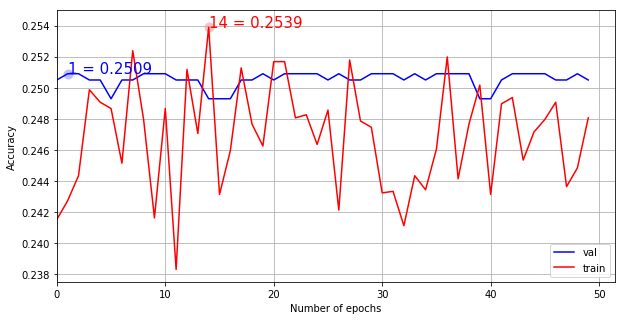

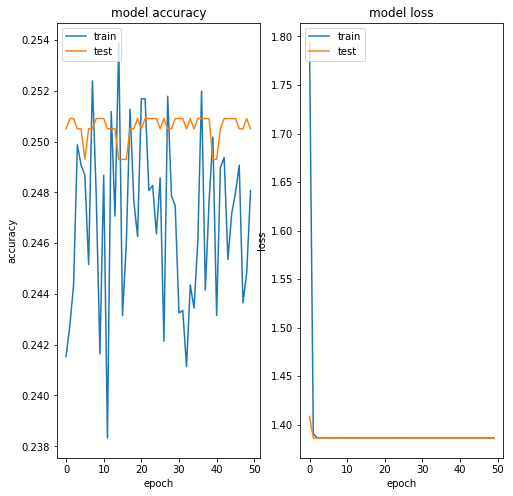

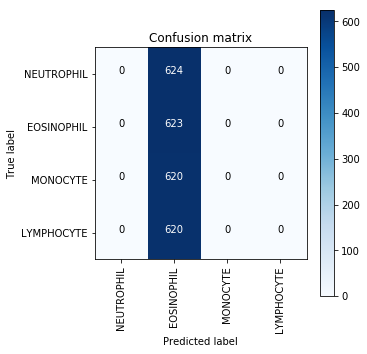

In [69]:
runOurModel(X_train_2, y_trainHot_2, X_test_2, y_testHot_2, save_dir='./result_ourself_2')

In [27]:
def runOurModel2(x_train, y_train, x_test, y_test, epochs=50, batch_size=32, 
                          learning_rate=1.0, lr_decay=0.0, 
                          save_dir='./result_ourself2'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_our_model2(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)

Epoch 1/50


277/311 [=========================>....] - ETA: 17:12 - loss: 6.5421 - acc: 0.15 - ETA: 8:42 - loss: 9.7841 - acc: 0.2344 - ETA: 5:52 - loss: 11.8184 - acc: 0.23 - ETA: 4:27 - loss: 10.5911 - acc: 0.22 - ETA: 3:36 - loss: 9.6610 - acc: 0.2562 - ETA: 3:02 - loss: 9.0590 - acc: 0.255 - ETA: 2:19 - loss: 8.2420 - acc: 0.265 - ETA: 2:05 - loss: 7.9260 - acc: 0.267 - ETA: 1:54 - loss: 7.6620 - acc: 0.265 - ETA: 1:45 - loss: 7.4327 - acc: 0.267 - ETA: 1:37 - loss: 7.2304 - acc: 0.268 - ETA: 1:30 - loss: 7.0504 - acc: 0.262 - ETA: 1:19 - loss: 6.7381 - acc: 0.264 - ETA: 1:11 - loss: 6.4720 - acc: 0.275 - ETA: 1:05 - loss: 6.2405 - acc: 0.282 - ETA: 1:00 - loss: 6.0379 - acc: 0.281 - ETA: 57s - loss: 5.9430 - acc: 0.279 - ETA: 53s - loss: 5.7662 - acc: 0.27 - ETA: 52s - loss: 5.6834 - acc: 0.27 - ETA: 50s - loss: 5.6041 - acc: 0.27 - ETA: 47s - loss: 5.4546 - acc: 0.27 - ETA: 46s - loss: 5.3837 - acc: 0.26 - ETA: 43s - loss: 5.2493 - acc: 0.26 - ETA: 42s - loss: 5.1854 - acc: 0.26 - ETA: 41s -

291/311 [===========================>..] - ETA: 15s - loss: 1.3819 - acc: 0.37 - ETA: 15s - loss: 1.3913 - acc: 0.31 - ETA: 15s - loss: 1.4092 - acc: 0.29 - ETA: 15s - loss: 1.4063 - acc: 0.33 - ETA: 15s - loss: 1.4038 - acc: 0.34 - ETA: 15s - loss: 1.4070 - acc: 0.33 - ETA: 15s - loss: 1.4038 - acc: 0.32 - ETA: 15s - loss: 1.4178 - acc: 0.30 - ETA: 15s - loss: 1.4185 - acc: 0.29 - ETA: 15s - loss: 1.4157 - acc: 0.30 - ETA: 15s - loss: 1.4078 - acc: 0.31 - ETA: 15s - loss: 1.4075 - acc: 0.32 - ETA: 15s - loss: 1.4042 - acc: 0.32 - ETA: 14s - loss: 1.3998 - acc: 0.33 - ETA: 14s - loss: 1.4014 - acc: 0.33 - ETA: 14s - loss: 1.4008 - acc: 0.32 - ETA: 14s - loss: 1.3998 - acc: 0.32 - ETA: 14s - loss: 1.3994 - acc: 0.32 - ETA: 14s - loss: 1.4000 - acc: 0.32 - ETA: 14s - loss: 1.4007 - acc: 0.32 - ETA: 14s - loss: 1.4000 - acc: 0.32 - ETA: 14s - loss: 1.3952 - acc: 0.33 - ETA: 14s - loss: 1.3953 - acc: 0.32 - ETA: 14s - loss: 1.3983 - acc: 0.32 - ETA: 14s - loss: 1.3977 - acc: 0.32 - ETA: 14

312/311 [==============================] - ETA: 0s - loss: 1.3884 - acc: 0.331 - ETA: 0s - loss: 1.3885 - acc: 0.331 - ETA: 0s - loss: 1.3886 - acc: 0.331 - ETA: 0s - loss: 1.3883 - acc: 0.331 - ETA: 0s - loss: 1.3881 - acc: 0.331 - ETA: 0s - loss: 1.3880 - acc: 0.331 - ETA: 0s - loss: 1.3879 - acc: 0.331 - ETA: 0s - loss: 1.3876 - acc: 0.332 - ETA: 0s - loss: 1.3874 - acc: 0.332 - ETA: 0s - loss: 1.3872 - acc: 0.332 - ETA: 0s - loss: 1.3876 - acc: 0.331 - ETA: 0s - loss: 1.3877 - acc: 0.331 - ETA: 0s - loss: 1.3873 - acc: 0.332 - ETA: 0s - loss: 1.3872 - acc: 0.332 - ETA: 0s - loss: 1.3868 - acc: 0.333 - ETA: 0s - loss: 1.3876 - acc: 0.332 - ETA: 0s - loss: 1.3879 - acc: 0.332 - 17s 54ms/step - loss: 1.3880 - acc: 0.3322 - val_loss: 1.3562 - val_acc: 0.4435
Epoch 3/50


283/311 [==========================>...] - ETA: 16s - loss: 1.3371 - acc: 0.37 - ETA: 16s - loss: 1.3593 - acc: 0.35 - ETA: 16s - loss: 1.4197 - acc: 0.31 - ETA: 15s - loss: 1.4022 - acc: 0.35 - ETA: 15s - loss: 1.3824 - acc: 0.35 - ETA: 15s - loss: 1.3693 - acc: 0.36 - ETA: 15s - loss: 1.3779 - acc: 0.35 - ETA: 15s - loss: 1.3670 - acc: 0.36 - ETA: 15s - loss: 1.3710 - acc: 0.36 - ETA: 15s - loss: 1.3594 - acc: 0.37 - ETA: 15s - loss: 1.3559 - acc: 0.37 - ETA: 14s - loss: 1.3309 - acc: 0.39 - ETA: 14s - loss: 1.3262 - acc: 0.39 - ETA: 14s - loss: 1.3428 - acc: 0.38 - ETA: 14s - loss: 1.3510 - acc: 0.36 - ETA: 14s - loss: 1.3509 - acc: 0.37 - ETA: 14s - loss: 1.3552 - acc: 0.37 - ETA: 14s - loss: 1.3539 - acc: 0.37 - ETA: 14s - loss: 1.3555 - acc: 0.37 - ETA: 14s - loss: 1.3543 - acc: 0.37 - ETA: 14s - loss: 1.3529 - acc: 0.37 - ETA: 13s - loss: 1.3467 - acc: 0.38 - ETA: 13s - loss: 1.3504 - acc: 0.37 - ETA: 13s - loss: 1.3474 - acc: 0.38 - ETA: 13s - loss: 1.3453 - acc: 0.38 - ETA: 13

286/311 [==========================>...] - ETA: 15s - loss: 0.9322 - acc: 0.65 - ETA: 15s - loss: 1.1317 - acc: 0.48 - ETA: 15s - loss: 1.1321 - acc: 0.50 - ETA: 15s - loss: 1.2654 - acc: 0.45 - ETA: 15s - loss: 1.3056 - acc: 0.42 - ETA: 15s - loss: 1.3118 - acc: 0.44 - ETA: 15s - loss: 1.2918 - acc: 0.47 - ETA: 15s - loss: 1.2935 - acc: 0.46 - ETA: 15s - loss: 1.2928 - acc: 0.46 - ETA: 15s - loss: 1.2844 - acc: 0.45 - ETA: 15s - loss: 1.2800 - acc: 0.46 - ETA: 14s - loss: 1.2679 - acc: 0.48 - ETA: 14s - loss: 1.2669 - acc: 0.47 - ETA: 14s - loss: 1.2631 - acc: 0.47 - ETA: 14s - loss: 1.2791 - acc: 0.46 - ETA: 14s - loss: 1.2795 - acc: 0.46 - ETA: 14s - loss: 1.2877 - acc: 0.46 - ETA: 14s - loss: 1.2889 - acc: 0.46 - ETA: 14s - loss: 1.2827 - acc: 0.47 - ETA: 14s - loss: 1.2811 - acc: 0.47 - ETA: 14s - loss: 1.2797 - acc: 0.46 - ETA: 14s - loss: 1.2816 - acc: 0.46 - ETA: 14s - loss: 1.2771 - acc: 0.46 - ETA: 14s - loss: 1.2724 - acc: 0.46 - ETA: 14s - loss: 1.2683 - acc: 0.46 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 1.2359 - acc: 0.489 - ETA: 1s - loss: 1.2359 - acc: 0.489 - ETA: 1s - loss: 1.2347 - acc: 0.490 - ETA: 1s - loss: 1.2344 - acc: 0.490 - ETA: 0s - loss: 1.2339 - acc: 0.490 - ETA: 0s - loss: 1.2338 - acc: 0.489 - ETA: 0s - loss: 1.2333 - acc: 0.490 - ETA: 0s - loss: 1.2332 - acc: 0.490 - ETA: 0s - loss: 1.2321 - acc: 0.490 - ETA: 0s - loss: 1.2309 - acc: 0.491 - ETA: 0s - loss: 1.2320 - acc: 0.490 - ETA: 0s - loss: 1.2312 - acc: 0.491 - ETA: 0s - loss: 1.2305 - acc: 0.491 - ETA: 0s - loss: 1.2307 - acc: 0.492 - ETA: 0s - loss: 1.2305 - acc: 0.492 - ETA: 0s - loss: 1.2303 - acc: 0.492 - ETA: 0s - loss: 1.2305 - acc: 0.492 - 17s 54ms/step - loss: 1.2308 - acc: 0.4926 - val_loss: 1.1057 - val_acc: 0.5557
Epoch 5/50


298/311 [===========================>..] - ETA: 16s - loss: 1.1521 - acc: 0.59 - ETA: 16s - loss: 1.1134 - acc: 0.67 - ETA: 16s - loss: 1.1063 - acc: 0.61 - ETA: 15s - loss: 1.0860 - acc: 0.60 - ETA: 15s - loss: 1.0738 - acc: 0.60 - ETA: 15s - loss: 1.0799 - acc: 0.61 - ETA: 15s - loss: 1.1696 - acc: 0.55 - ETA: 15s - loss: 1.1703 - acc: 0.56 - ETA: 15s - loss: 1.1771 - acc: 0.55 - ETA: 15s - loss: 1.1783 - acc: 0.55 - ETA: 15s - loss: 1.1757 - acc: 0.55 - ETA: 15s - loss: 1.1766 - acc: 0.56 - ETA: 15s - loss: 1.1690 - acc: 0.55 - ETA: 15s - loss: 1.1697 - acc: 0.55 - ETA: 15s - loss: 1.1746 - acc: 0.54 - ETA: 15s - loss: 1.1713 - acc: 0.54 - ETA: 14s - loss: 1.1722 - acc: 0.54 - ETA: 14s - loss: 1.1720 - acc: 0.54 - ETA: 14s - loss: 1.1673 - acc: 0.54 - ETA: 14s - loss: 1.1686 - acc: 0.54 - ETA: 14s - loss: 1.1489 - acc: 0.55 - ETA: 14s - loss: 1.1525 - acc: 0.54 - ETA: 14s - loss: 1.1504 - acc: 0.55 - ETA: 14s - loss: 1.1495 - acc: 0.54 - ETA: 14s - loss: 1.1483 - acc: 0.54 - ETA: 14

292/311 [===========================>..] - ETA: 15s - loss: 1.1177 - acc: 0.46 - ETA: 16s - loss: 1.1516 - acc: 0.42 - ETA: 15s - loss: 1.0632 - acc: 0.52 - ETA: 15s - loss: 1.0006 - acc: 0.56 - ETA: 15s - loss: 1.0265 - acc: 0.56 - ETA: 15s - loss: 1.0491 - acc: 0.55 - ETA: 15s - loss: 1.0593 - acc: 0.56 - ETA: 15s - loss: 1.2052 - acc: 0.52 - ETA: 15s - loss: 1.2245 - acc: 0.51 - ETA: 15s - loss: 1.2130 - acc: 0.52 - ETA: 15s - loss: 1.1913 - acc: 0.53 - ETA: 15s - loss: 1.1764 - acc: 0.55 - ETA: 15s - loss: 1.1696 - acc: 0.55 - ETA: 15s - loss: 1.1654 - acc: 0.55 - ETA: 14s - loss: 1.1600 - acc: 0.56 - ETA: 14s - loss: 1.1548 - acc: 0.56 - ETA: 14s - loss: 1.2628 - acc: 0.55 - ETA: 14s - loss: 1.2777 - acc: 0.54 - ETA: 14s - loss: 1.2999 - acc: 0.52 - ETA: 14s - loss: 1.2976 - acc: 0.51 - ETA: 14s - loss: 1.2948 - acc: 0.51 - ETA: 14s - loss: 1.2806 - acc: 0.52 - ETA: 14s - loss: 1.2754 - acc: 0.52 - ETA: 14s - loss: 1.2713 - acc: 0.52 - ETA: 13s - loss: 1.2553 - acc: 0.53 - ETA: 13

312/311 [==============================] - ETA: 0s - loss: 1.0722 - acc: 0.593 - ETA: 0s - loss: 1.0716 - acc: 0.593 - ETA: 0s - loss: 1.0701 - acc: 0.594 - ETA: 0s - loss: 1.0695 - acc: 0.595 - ETA: 0s - loss: 1.0699 - acc: 0.594 - ETA: 0s - loss: 1.0693 - acc: 0.594 - ETA: 0s - loss: 1.0687 - acc: 0.595 - ETA: 0s - loss: 1.0677 - acc: 0.595 - ETA: 0s - loss: 1.0671 - acc: 0.596 - ETA: 0s - loss: 1.0667 - acc: 0.596 - ETA: 0s - loss: 1.0673 - acc: 0.596 - ETA: 0s - loss: 1.0675 - acc: 0.596 - ETA: 0s - loss: 1.0677 - acc: 0.595 - ETA: 0s - loss: 1.0682 - acc: 0.596 - ETA: 0s - loss: 1.0695 - acc: 0.595 - ETA: 0s - loss: 1.0704 - acc: 0.595 - 17s 54ms/step - loss: 1.0702 - acc: 0.5950 - val_loss: 0.8730 - val_acc: 0.6976
Epoch 7/50
312/311 [==============================] - ETA: 16s - loss: 0.8842 - acc: 0.62 - ETA: 15s - loss: 1.0005 - acc: 0.60 - ETA: 15s - loss: 0.9489 - acc: 0.63 - ETA: 15s - loss: 0.9466 - acc: 0.63 - ETA: 14s - loss: 0.9444 - acc: 0.63 - ETA: 15s - loss: 1.0046 -

312/311 [==============================] - ETA: 15s - loss: 3.1678 - acc: 0.28 - ETA: 15s - loss: 1.7888 - acc: 0.48 - ETA: 15s - loss: 1.5952 - acc: 0.50 - ETA: 14s - loss: 1.3881 - acc: 0.57 - ETA: 14s - loss: 1.3360 - acc: 0.58 - ETA: 15s - loss: 1.2765 - acc: 0.59 - ETA: 14s - loss: 1.1881 - acc: 0.62 - ETA: 14s - loss: 1.1225 - acc: 0.63 - ETA: 14s - loss: 1.1124 - acc: 0.62 - ETA: 14s - loss: 1.1068 - acc: 0.61 - ETA: 14s - loss: 1.0996 - acc: 0.62 - ETA: 14s - loss: 1.0828 - acc: 0.62 - ETA: 14s - loss: 1.0751 - acc: 0.62 - ETA: 14s - loss: 1.0682 - acc: 0.62 - ETA: 14s - loss: 1.0611 - acc: 0.62 - ETA: 14s - loss: 1.0515 - acc: 0.62 - ETA: 14s - loss: 1.0473 - acc: 0.63 - ETA: 14s - loss: 1.0379 - acc: 0.63 - ETA: 14s - loss: 1.0269 - acc: 0.63 - ETA: 14s - loss: 1.0268 - acc: 0.63 - ETA: 14s - loss: 1.0249 - acc: 0.63 - ETA: 14s - loss: 1.0220 - acc: 0.63 - ETA: 13s - loss: 1.0192 - acc: 0.63 - ETA: 13s - loss: 1.0062 - acc: 0.64 - ETA: 13s - loss: 0.9943 - acc: 0.64 - ETA: 13

278/311 [=========================>....] - ETA: 15s - loss: 0.8924 - acc: 0.75 - ETA: 15s - loss: 0.8596 - acc: 0.70 - ETA: 15s - loss: 0.8243 - acc: 0.71 - ETA: 15s - loss: 0.8614 - acc: 0.71 - ETA: 15s - loss: 0.8952 - acc: 0.68 - ETA: 15s - loss: 0.8886 - acc: 0.68 - ETA: 15s - loss: 0.9475 - acc: 0.66 - ETA: 15s - loss: 0.9211 - acc: 0.68 - ETA: 15s - loss: 0.9117 - acc: 0.68 - ETA: 15s - loss: 0.9021 - acc: 0.68 - ETA: 14s - loss: 0.9019 - acc: 0.68 - ETA: 14s - loss: 0.8963 - acc: 0.69 - ETA: 14s - loss: 0.8907 - acc: 0.68 - ETA: 14s - loss: 0.8891 - acc: 0.68 - ETA: 14s - loss: 0.8979 - acc: 0.67 - ETA: 14s - loss: 0.9250 - acc: 0.66 - ETA: 14s - loss: 0.9501 - acc: 0.64 - ETA: 14s - loss: 0.9650 - acc: 0.64 - ETA: 14s - loss: 0.9589 - acc: 0.64 - ETA: 14s - loss: 0.9597 - acc: 0.64 - ETA: 14s - loss: 0.9595 - acc: 0.64 - ETA: 14s - loss: 0.9598 - acc: 0.64 - ETA: 14s - loss: 0.9563 - acc: 0.64 - ETA: 14s - loss: 0.9479 - acc: 0.64 - ETA: 14s - loss: 0.9451 - acc: 0.64 - ETA: 14

298/311 [===========================>..] - ETA: 15s - loss: 0.7929 - acc: 0.65 - ETA: 15s - loss: 0.7957 - acc: 0.70 - ETA: 15s - loss: 0.7671 - acc: 0.73 - ETA: 15s - loss: 0.7550 - acc: 0.76 - ETA: 15s - loss: 0.7508 - acc: 0.75 - ETA: 15s - loss: 0.7655 - acc: 0.73 - ETA: 15s - loss: 0.7760 - acc: 0.73 - ETA: 15s - loss: 0.7757 - acc: 0.73 - ETA: 15s - loss: 0.7813 - acc: 0.72 - ETA: 15s - loss: 0.8493 - acc: 0.69 - ETA: 15s - loss: 0.9128 - acc: 0.66 - ETA: 15s - loss: 0.9116 - acc: 0.66 - ETA: 15s - loss: 0.8966 - acc: 0.67 - ETA: 15s - loss: 0.8947 - acc: 0.68 - ETA: 14s - loss: 0.8830 - acc: 0.69 - ETA: 14s - loss: 0.8734 - acc: 0.68 - ETA: 14s - loss: 0.8671 - acc: 0.69 - ETA: 14s - loss: 0.8610 - acc: 0.69 - ETA: 14s - loss: 0.8596 - acc: 0.69 - ETA: 14s - loss: 0.8516 - acc: 0.69 - ETA: 14s - loss: 0.8483 - acc: 0.69 - ETA: 14s - loss: 0.8449 - acc: 0.70 - ETA: 14s - loss: 0.8443 - acc: 0.70 - ETA: 14s - loss: 0.8496 - acc: 0.69 - ETA: 14s - loss: 0.8525 - acc: 0.70 - ETA: 13

312/311 [==============================] - ETA: 0s - loss: 0.8760 - acc: 0.704 - ETA: 0s - loss: 0.8758 - acc: 0.704 - ETA: 0s - loss: 0.8752 - acc: 0.704 - ETA: 0s - loss: 0.8736 - acc: 0.705 - ETA: 0s - loss: 0.8726 - acc: 0.705 - ETA: 0s - loss: 0.8717 - acc: 0.706 - ETA: 0s - loss: 0.8710 - acc: 0.706 - ETA: 0s - loss: 0.8704 - acc: 0.706 - ETA: 0s - loss: 0.8697 - acc: 0.707 - ETA: 0s - loss: 0.8687 - acc: 0.707 - 17s 53ms/step - loss: 0.8683 - acc: 0.7073 - val_loss: 0.7417 - val_acc: 0.7776
Epoch 11/50


294/311 [===========================>..] - ETA: 15s - loss: 0.6205 - acc: 0.87 - ETA: 15s - loss: 0.8439 - acc: 0.71 - ETA: 15s - loss: 0.8639 - acc: 0.69 - ETA: 15s - loss: 0.7965 - acc: 0.73 - ETA: 15s - loss: 0.7811 - acc: 0.74 - ETA: 15s - loss: 0.7737 - acc: 0.74 - ETA: 15s - loss: 0.7750 - acc: 0.74 - ETA: 14s - loss: 0.7549 - acc: 0.73 - ETA: 14s - loss: 0.7412 - acc: 0.74 - ETA: 14s - loss: 0.7392 - acc: 0.75 - ETA: 14s - loss: 0.7328 - acc: 0.75 - ETA: 14s - loss: 0.7368 - acc: 0.75 - ETA: 14s - loss: 0.7320 - acc: 0.75 - ETA: 14s - loss: 0.7316 - acc: 0.74 - ETA: 14s - loss: 0.7431 - acc: 0.74 - ETA: 14s - loss: 0.7351 - acc: 0.75 - ETA: 14s - loss: 0.7302 - acc: 0.75 - ETA: 14s - loss: 0.7224 - acc: 0.75 - ETA: 14s - loss: 0.7221 - acc: 0.75 - ETA: 14s - loss: 0.7219 - acc: 0.75 - ETA: 14s - loss: 0.7220 - acc: 0.75 - ETA: 14s - loss: 0.7247 - acc: 0.75 - ETA: 14s - loss: 0.7208 - acc: 0.75 - ETA: 14s - loss: 0.7208 - acc: 0.75 - ETA: 14s - loss: 0.7122 - acc: 0.76 - ETA: 13

279/311 [=========================>....] - ETA: 15s - loss: 0.6657 - acc: 0.81 - ETA: 15s - loss: 0.7870 - acc: 0.75 - ETA: 15s - loss: 1.0340 - acc: 0.66 - ETA: 15s - loss: 1.0335 - acc: 0.63 - ETA: 15s - loss: 0.9801 - acc: 0.64 - ETA: 15s - loss: 0.9564 - acc: 0.65 - ETA: 15s - loss: 0.9257 - acc: 0.66 - ETA: 15s - loss: 0.9075 - acc: 0.67 - ETA: 15s - loss: 0.8774 - acc: 0.69 - ETA: 15s - loss: 0.8786 - acc: 0.68 - ETA: 15s - loss: 0.8631 - acc: 0.69 - ETA: 15s - loss: 0.8534 - acc: 0.70 - ETA: 14s - loss: 0.8366 - acc: 0.71 - ETA: 14s - loss: 0.8199 - acc: 0.72 - ETA: 14s - loss: 0.8133 - acc: 0.72 - ETA: 14s - loss: 0.8241 - acc: 0.72 - ETA: 14s - loss: 0.8143 - acc: 0.72 - ETA: 14s - loss: 0.8073 - acc: 0.72 - ETA: 14s - loss: 0.8094 - acc: 0.72 - ETA: 14s - loss: 0.8059 - acc: 0.72 - ETA: 14s - loss: 0.7968 - acc: 0.73 - ETA: 14s - loss: 0.7994 - acc: 0.73 - ETA: 14s - loss: 0.7983 - acc: 0.73 - ETA: 14s - loss: 0.7940 - acc: 0.73 - ETA: 14s - loss: 0.7918 - acc: 0.73 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.7537 - acc: 0.757 - ETA: 1s - loss: 0.7530 - acc: 0.757 - ETA: 1s - loss: 0.7528 - acc: 0.757 - ETA: 1s - loss: 0.7537 - acc: 0.757 - ETA: 1s - loss: 0.7534 - acc: 0.757 - ETA: 1s - loss: 0.7542 - acc: 0.757 - ETA: 1s - loss: 0.7549 - acc: 0.757 - ETA: 1s - loss: 0.7552 - acc: 0.757 - ETA: 1s - loss: 0.7541 - acc: 0.758 - ETA: 1s - loss: 0.7543 - acc: 0.758 - ETA: 1s - loss: 0.7539 - acc: 0.758 - ETA: 0s - loss: 0.7542 - acc: 0.758 - ETA: 0s - loss: 0.7540 - acc: 0.758 - ETA: 0s - loss: 0.7529 - acc: 0.758 - ETA: 0s - loss: 0.7514 - acc: 0.759 - ETA: 0s - loss: 0.7516 - acc: 0.759 - ETA: 0s - loss: 0.7521 - acc: 0.758 - ETA: 0s - loss: 0.7521 - acc: 0.758 - ETA: 0s - loss: 0.7522 - acc: 0.758 - ETA: 0s - loss: 0.7523 - acc: 0.759 - ETA: 0s - loss: 0.7515 - acc: 0.759 - ETA: 0s - loss: 0.7517 - acc: 0.759 - ETA: 0s - loss: 0.7514 - acc: 0.759 - ETA: 0s - loss: 0.7511 - acc: 0.760 - ETA: 0s - loss: 0.7505 - acc: 0.760 - 17s 54m

282/311 [==========================>...] - ETA: 15s - loss: 0.9386 - acc: 0.65 - ETA: 15s - loss: 0.9659 - acc: 0.67 - ETA: 15s - loss: 0.8672 - acc: 0.72 - ETA: 15s - loss: 0.7627 - acc: 0.74 - ETA: 15s - loss: 0.7404 - acc: 0.76 - ETA: 15s - loss: 0.7556 - acc: 0.75 - ETA: 15s - loss: 0.7531 - acc: 0.75 - ETA: 15s - loss: 0.7426 - acc: 0.75 - ETA: 15s - loss: 0.7596 - acc: 0.74 - ETA: 15s - loss: 0.7474 - acc: 0.75 - ETA: 15s - loss: 0.7355 - acc: 0.75 - ETA: 15s - loss: 0.7323 - acc: 0.76 - ETA: 14s - loss: 0.7299 - acc: 0.76 - ETA: 14s - loss: 0.7152 - acc: 0.77 - ETA: 14s - loss: 0.7175 - acc: 0.76 - ETA: 14s - loss: 0.7175 - acc: 0.76 - ETA: 14s - loss: 0.7339 - acc: 0.76 - ETA: 14s - loss: 0.7636 - acc: 0.75 - ETA: 14s - loss: 0.7770 - acc: 0.74 - ETA: 14s - loss: 0.7733 - acc: 0.75 - ETA: 14s - loss: 0.7663 - acc: 0.75 - ETA: 14s - loss: 0.7704 - acc: 0.75 - ETA: 14s - loss: 0.7777 - acc: 0.74 - ETA: 14s - loss: 0.7743 - acc: 0.74 - ETA: 14s - loss: 0.7702 - acc: 0.74 - ETA: 14

301/311 [============================>.] - ETA: 15s - loss: 0.6586 - acc: 0.81 - ETA: 15s - loss: 0.6718 - acc: 0.78 - ETA: 15s - loss: 0.6765 - acc: 0.78 - ETA: 15s - loss: 0.6522 - acc: 0.81 - ETA: 15s - loss: 0.6314 - acc: 0.82 - ETA: 15s - loss: 0.6394 - acc: 0.82 - ETA: 15s - loss: 0.6226 - acc: 0.82 - ETA: 15s - loss: 0.6241 - acc: 0.82 - ETA: 15s - loss: 0.6132 - acc: 0.82 - ETA: 15s - loss: 0.6159 - acc: 0.82 - ETA: 15s - loss: 0.6348 - acc: 0.81 - ETA: 14s - loss: 0.6417 - acc: 0.80 - ETA: 14s - loss: 0.6360 - acc: 0.80 - ETA: 14s - loss: 0.6272 - acc: 0.80 - ETA: 14s - loss: 0.6351 - acc: 0.80 - ETA: 14s - loss: 0.6341 - acc: 0.80 - ETA: 14s - loss: 0.6334 - acc: 0.80 - ETA: 14s - loss: 0.6411 - acc: 0.80 - ETA: 14s - loss: 0.6384 - acc: 0.80 - ETA: 14s - loss: 0.6374 - acc: 0.80 - ETA: 14s - loss: 0.6321 - acc: 0.80 - ETA: 14s - loss: 0.6304 - acc: 0.80 - ETA: 14s - loss: 0.6241 - acc: 0.81 - ETA: 14s - loss: 0.6206 - acc: 0.81 - ETA: 14s - loss: 0.6201 - acc: 0.81 - ETA: 13

312/311 [==============================] - ETA: 0s - loss: 0.6814 - acc: 0.790 - ETA: 0s - loss: 0.6824 - acc: 0.789 - ETA: 0s - loss: 0.6820 - acc: 0.790 - ETA: 0s - loss: 0.6818 - acc: 0.790 - ETA: 0s - loss: 0.6807 - acc: 0.790 - ETA: 0s - loss: 0.6804 - acc: 0.790 - ETA: 0s - loss: 0.6802 - acc: 0.790 - ETA: 0s - loss: 0.6807 - acc: 0.790 - ETA: 0s - loss: 0.6807 - acc: 0.790 - ETA: 0s - loss: 0.6803 - acc: 0.790 - 17s 53ms/step - loss: 0.6798 - acc: 0.7909 - val_loss: 0.6216 - val_acc: 0.8118
Epoch 15/50


288/311 [==========================>...] - ETA: 15s - loss: 0.5912 - acc: 0.68 - ETA: 15s - loss: 0.5864 - acc: 0.71 - ETA: 15s - loss: 0.5654 - acc: 0.76 - ETA: 15s - loss: 0.5941 - acc: 0.74 - ETA: 15s - loss: 0.5918 - acc: 0.78 - ETA: 15s - loss: 0.5726 - acc: 0.79 - ETA: 15s - loss: 0.5971 - acc: 0.77 - ETA: 15s - loss: 0.6271 - acc: 0.77 - ETA: 15s - loss: 0.6902 - acc: 0.75 - ETA: 15s - loss: 0.7170 - acc: 0.74 - ETA: 15s - loss: 0.7297 - acc: 0.73 - ETA: 15s - loss: 0.7186 - acc: 0.75 - ETA: 15s - loss: 0.7270 - acc: 0.74 - ETA: 15s - loss: 0.7272 - acc: 0.75 - ETA: 14s - loss: 0.7185 - acc: 0.76 - ETA: 14s - loss: 0.7151 - acc: 0.76 - ETA: 14s - loss: 0.7220 - acc: 0.75 - ETA: 14s - loss: 0.7340 - acc: 0.75 - ETA: 14s - loss: 0.7378 - acc: 0.75 - ETA: 14s - loss: 0.7331 - acc: 0.75 - ETA: 14s - loss: 0.7228 - acc: 0.75 - ETA: 14s - loss: 0.7224 - acc: 0.75 - ETA: 14s - loss: 0.7136 - acc: 0.76 - ETA: 14s - loss: 0.7139 - acc: 0.76 - ETA: 14s - loss: 0.7108 - acc: 0.76 - ETA: 14

285/311 [==========================>...] - ETA: 15s - loss: 0.7738 - acc: 0.65 - ETA: 15s - loss: 0.6538 - acc: 0.76 - ETA: 15s - loss: 0.6819 - acc: 0.79 - ETA: 15s - loss: 0.7215 - acc: 0.78 - ETA: 15s - loss: 0.7394 - acc: 0.78 - ETA: 15s - loss: 0.7024 - acc: 0.79 - ETA: 15s - loss: 0.6619 - acc: 0.80 - ETA: 15s - loss: 0.6716 - acc: 0.79 - ETA: 15s - loss: 0.6720 - acc: 0.79 - ETA: 15s - loss: 0.6750 - acc: 0.79 - ETA: 15s - loss: 0.6612 - acc: 0.80 - ETA: 15s - loss: 0.6601 - acc: 0.80 - ETA: 14s - loss: 0.6752 - acc: 0.79 - ETA: 14s - loss: 0.6777 - acc: 0.79 - ETA: 14s - loss: 0.7338 - acc: 0.78 - ETA: 14s - loss: 0.7513 - acc: 0.78 - ETA: 14s - loss: 0.7700 - acc: 0.77 - ETA: 14s - loss: 0.7826 - acc: 0.76 - ETA: 14s - loss: 0.7818 - acc: 0.76 - ETA: 14s - loss: 0.7784 - acc: 0.76 - ETA: 14s - loss: 0.7720 - acc: 0.76 - ETA: 14s - loss: 0.7775 - acc: 0.75 - ETA: 14s - loss: 0.7703 - acc: 0.76 - ETA: 14s - loss: 0.7672 - acc: 0.76 - ETA: 14s - loss: 0.7680 - acc: 0.76 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.6635 - acc: 0.800 - ETA: 1s - loss: 0.6650 - acc: 0.799 - ETA: 1s - loss: 0.6649 - acc: 0.800 - ETA: 1s - loss: 0.6644 - acc: 0.800 - ETA: 1s - loss: 0.6644 - acc: 0.800 - ETA: 0s - loss: 0.6636 - acc: 0.800 - ETA: 0s - loss: 0.6632 - acc: 0.801 - ETA: 0s - loss: 0.6630 - acc: 0.801 - ETA: 0s - loss: 0.6624 - acc: 0.801 - ETA: 0s - loss: 0.6621 - acc: 0.801 - ETA: 0s - loss: 0.6619 - acc: 0.802 - ETA: 0s - loss: 0.6618 - acc: 0.802 - ETA: 0s - loss: 0.6615 - acc: 0.802 - ETA: 0s - loss: 0.6613 - acc: 0.802 - ETA: 0s - loss: 0.6607 - acc: 0.802 - ETA: 0s - loss: 0.6608 - acc: 0.802 - ETA: 0s - loss: 0.6600 - acc: 0.802 - ETA: 0s - loss: 0.6603 - acc: 0.802 - ETA: 0s - loss: 0.6607 - acc: 0.802 - ETA: 0s - loss: 0.6609 - acc: 0.802 - ETA: 0s - loss: 0.6604 - acc: 0.802 - 17s 54ms/step - loss: 0.6602 - acc: 0.8025 - val_loss: 0.6568 - val_acc: 0.8717
Epoch 17/50


272/311 [=========================>....] - ETA: 14s - loss: 0.5283 - acc: 0.81 - ETA: 15s - loss: 0.5761 - acc: 0.80 - ETA: 15s - loss: 0.5500 - acc: 0.82 - ETA: 15s - loss: 0.5254 - acc: 0.84 - ETA: 15s - loss: 0.5103 - acc: 0.85 - ETA: 15s - loss: 0.5344 - acc: 0.85 - ETA: 15s - loss: 0.5442 - acc: 0.84 - ETA: 15s - loss: 0.5406 - acc: 0.85 - ETA: 15s - loss: 0.5410 - acc: 0.85 - ETA: 15s - loss: 0.5394 - acc: 0.84 - ETA: 15s - loss: 0.5665 - acc: 0.83 - ETA: 15s - loss: 0.5606 - acc: 0.84 - ETA: 15s - loss: 0.5648 - acc: 0.84 - ETA: 15s - loss: 0.5654 - acc: 0.83 - ETA: 15s - loss: 0.5765 - acc: 0.82 - ETA: 14s - loss: 0.5901 - acc: 0.82 - ETA: 14s - loss: 0.5848 - acc: 0.83 - ETA: 14s - loss: 0.5812 - acc: 0.83 - ETA: 14s - loss: 0.5724 - acc: 0.84 - ETA: 14s - loss: 0.5693 - acc: 0.83 - ETA: 14s - loss: 0.5660 - acc: 0.84 - ETA: 14s - loss: 0.5624 - acc: 0.84 - ETA: 14s - loss: 0.5641 - acc: 0.84 - ETA: 14s - loss: 0.5654 - acc: 0.84 - ETA: 14s - loss: 0.5769 - acc: 0.83 - ETA: 14

274/311 [=========================>....] - ETA: 15s - loss: 0.5173 - acc: 0.75 - ETA: 15s - loss: 0.5773 - acc: 0.78 - ETA: 15s - loss: 0.5688 - acc: 0.79 - ETA: 15s - loss: 0.5601 - acc: 0.80 - ETA: 15s - loss: 0.5426 - acc: 0.82 - ETA: 15s - loss: 0.5418 - acc: 0.82 - ETA: 15s - loss: 0.5472 - acc: 0.82 - ETA: 15s - loss: 0.5517 - acc: 0.82 - ETA: 14s - loss: 0.5463 - acc: 0.82 - ETA: 14s - loss: 0.5477 - acc: 0.83 - ETA: 14s - loss: 0.5502 - acc: 0.83 - ETA: 14s - loss: 0.5557 - acc: 0.82 - ETA: 14s - loss: 0.5540 - acc: 0.82 - ETA: 14s - loss: 0.5595 - acc: 0.82 - ETA: 14s - loss: 0.5600 - acc: 0.83 - ETA: 14s - loss: 0.5527 - acc: 0.83 - ETA: 14s - loss: 0.5619 - acc: 0.82 - ETA: 14s - loss: 0.6432 - acc: 0.80 - ETA: 14s - loss: 0.6997 - acc: 0.78 - ETA: 14s - loss: 0.7185 - acc: 0.77 - ETA: 14s - loss: 0.7459 - acc: 0.77 - ETA: 14s - loss: 0.7418 - acc: 0.78 - ETA: 14s - loss: 0.7441 - acc: 0.77 - ETA: 14s - loss: 0.7418 - acc: 0.77 - ETA: 14s - loss: 0.7393 - acc: 0.78 - ETA: 13

312/311 [==============================] - ETA: 1s - loss: 0.6245 - acc: 0.824 - ETA: 1s - loss: 0.6238 - acc: 0.824 - ETA: 1s - loss: 0.6236 - acc: 0.824 - ETA: 1s - loss: 0.6233 - acc: 0.824 - ETA: 1s - loss: 0.6229 - acc: 0.824 - ETA: 1s - loss: 0.6219 - acc: 0.825 - ETA: 1s - loss: 0.6209 - acc: 0.825 - ETA: 1s - loss: 0.6200 - acc: 0.825 - ETA: 1s - loss: 0.6194 - acc: 0.826 - ETA: 1s - loss: 0.6202 - acc: 0.825 - ETA: 1s - loss: 0.6200 - acc: 0.825 - ETA: 1s - loss: 0.6198 - acc: 0.826 - ETA: 0s - loss: 0.6190 - acc: 0.826 - ETA: 0s - loss: 0.6182 - acc: 0.826 - ETA: 0s - loss: 0.6182 - acc: 0.826 - ETA: 0s - loss: 0.6180 - acc: 0.826 - ETA: 0s - loss: 0.6174 - acc: 0.826 - ETA: 0s - loss: 0.6167 - acc: 0.827 - ETA: 0s - loss: 0.6165 - acc: 0.827 - ETA: 0s - loss: 0.6163 - acc: 0.827 - ETA: 0s - loss: 0.6156 - acc: 0.827 - ETA: 0s - loss: 0.6156 - acc: 0.827 - ETA: 0s - loss: 0.6152 - acc: 0.827 - ETA: 0s - loss: 0.6154 - acc: 0.827 - ETA: 0s - loss: 0.6151 - acc: 0.827 - ETA: 0s

254/311 [=======================>......] - ETA: 15s - loss: 0.5074 - acc: 0.90 - ETA: 15s - loss: 0.4983 - acc: 0.93 - ETA: 15s - loss: 0.4691 - acc: 0.91 - ETA: 15s - loss: 0.4966 - acc: 0.89 - ETA: 15s - loss: 0.4722 - acc: 0.90 - ETA: 15s - loss: 0.5111 - acc: 0.87 - ETA: 15s - loss: 0.5179 - acc: 0.87 - ETA: 15s - loss: 0.5399 - acc: 0.87 - ETA: 15s - loss: 0.5317 - acc: 0.87 - ETA: 15s - loss: 0.5295 - acc: 0.88 - ETA: 15s - loss: 0.5322 - acc: 0.88 - ETA: 15s - loss: 0.5251 - acc: 0.88 - ETA: 15s - loss: 0.5398 - acc: 0.87 - ETA: 15s - loss: 0.5696 - acc: 0.85 - ETA: 14s - loss: 0.5748 - acc: 0.85 - ETA: 14s - loss: 0.5740 - acc: 0.85 - ETA: 14s - loss: 0.5790 - acc: 0.85 - ETA: 14s - loss: 0.5695 - acc: 0.85 - ETA: 14s - loss: 0.5680 - acc: 0.85 - ETA: 14s - loss: 0.5797 - acc: 0.85 - ETA: 14s - loss: 0.5811 - acc: 0.84 - ETA: 14s - loss: 0.5774 - acc: 0.84 - ETA: 14s - loss: 0.5762 - acc: 0.84 - ETA: 14s - loss: 0.5748 - acc: 0.84 - ETA: 14s - loss: 0.5702 - acc: 0.84 - ETA: 14

282/311 [==========================>...] - ETA: 16s - loss: 0.3802 - acc: 0.90 - ETA: 15s - loss: 0.4019 - acc: 0.90 - ETA: 15s - loss: 0.4315 - acc: 0.88 - ETA: 15s - loss: 0.4333 - acc: 0.86 - ETA: 15s - loss: 0.5131 - acc: 0.83 - ETA: 15s - loss: 0.5139 - acc: 0.84 - ETA: 15s - loss: 0.5235 - acc: 0.84 - ETA: 15s - loss: 0.5206 - acc: 0.84 - ETA: 15s - loss: 0.5076 - acc: 0.85 - ETA: 15s - loss: 0.5001 - acc: 0.85 - ETA: 14s - loss: 0.5014 - acc: 0.85 - ETA: 14s - loss: 0.5175 - acc: 0.84 - ETA: 14s - loss: 0.5231 - acc: 0.84 - ETA: 14s - loss: 0.5197 - acc: 0.85 - ETA: 14s - loss: 0.5215 - acc: 0.84 - ETA: 14s - loss: 0.5284 - acc: 0.84 - ETA: 14s - loss: 0.5368 - acc: 0.83 - ETA: 14s - loss: 0.5308 - acc: 0.83 - ETA: 14s - loss: 0.5495 - acc: 0.83 - ETA: 14s - loss: 0.5579 - acc: 0.82 - ETA: 14s - loss: 0.5552 - acc: 0.82 - ETA: 14s - loss: 0.5542 - acc: 0.82 - ETA: 14s - loss: 0.5635 - acc: 0.82 - ETA: 14s - loss: 0.5694 - acc: 0.82 - ETA: 14s - loss: 0.5714 - acc: 0.82 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.6008 - acc: 0.823 - ETA: 1s - loss: 0.6019 - acc: 0.823 - ETA: 1s - loss: 0.6010 - acc: 0.824 - ETA: 1s - loss: 0.6003 - acc: 0.824 - ETA: 1s - loss: 0.5996 - acc: 0.824 - ETA: 0s - loss: 0.5982 - acc: 0.825 - ETA: 0s - loss: 0.5977 - acc: 0.825 - ETA: 0s - loss: 0.5979 - acc: 0.825 - ETA: 0s - loss: 0.5982 - acc: 0.825 - ETA: 0s - loss: 0.5978 - acc: 0.825 - ETA: 0s - loss: 0.5969 - acc: 0.825 - ETA: 0s - loss: 0.5970 - acc: 0.825 - ETA: 0s - loss: 0.5977 - acc: 0.824 - ETA: 0s - loss: 0.5987 - acc: 0.824 - ETA: 0s - loss: 0.5996 - acc: 0.823 - ETA: 0s - loss: 0.5999 - acc: 0.823 - ETA: 0s - loss: 0.6004 - acc: 0.823 - ETA: 0s - loss: 0.6010 - acc: 0.823 - ETA: 0s - loss: 0.6015 - acc: 0.823 - 17s 54ms/step - loss: 0.6019 - acc: 0.8238 - val_loss: 0.5830 - val_acc: 0.8412
Epoch 21/50


262/311 [========================>.....] - ETA: 16s - loss: 0.5309 - acc: 0.87 - ETA: 16s - loss: 0.5446 - acc: 0.87 - ETA: 15s - loss: 0.5361 - acc: 0.85 - ETA: 15s - loss: 0.5658 - acc: 0.83 - ETA: 15s - loss: 0.5979 - acc: 0.82 - ETA: 15s - loss: 0.5968 - acc: 0.82 - ETA: 15s - loss: 0.5880 - acc: 0.82 - ETA: 15s - loss: 0.5859 - acc: 0.82 - ETA: 15s - loss: 0.5835 - acc: 0.82 - ETA: 15s - loss: 0.5798 - acc: 0.83 - ETA: 15s - loss: 0.5822 - acc: 0.83 - ETA: 15s - loss: 0.6011 - acc: 0.83 - ETA: 15s - loss: 0.6028 - acc: 0.82 - ETA: 15s - loss: 0.6182 - acc: 0.82 - ETA: 15s - loss: 0.6169 - acc: 0.82 - ETA: 14s - loss: 0.6037 - acc: 0.83 - ETA: 14s - loss: 0.5936 - acc: 0.83 - ETA: 14s - loss: 0.5874 - acc: 0.83 - ETA: 14s - loss: 0.5989 - acc: 0.83 - ETA: 14s - loss: 0.6029 - acc: 0.82 - ETA: 14s - loss: 0.6215 - acc: 0.82 - ETA: 14s - loss: 0.6500 - acc: 0.81 - ETA: 14s - loss: 0.6557 - acc: 0.80 - ETA: 14s - loss: 0.6585 - acc: 0.80 - ETA: 14s - loss: 0.6527 - acc: 0.80 - ETA: 14

273/311 [=========================>....] - ETA: 15s - loss: 0.5098 - acc: 0.87 - ETA: 15s - loss: 0.4998 - acc: 0.86 - ETA: 15s - loss: 0.4692 - acc: 0.88 - ETA: 15s - loss: 0.4924 - acc: 0.86 - ETA: 15s - loss: 0.4997 - acc: 0.85 - ETA: 15s - loss: 0.5283 - acc: 0.85 - ETA: 15s - loss: 0.5188 - acc: 0.85 - ETA: 15s - loss: 0.5189 - acc: 0.86 - ETA: 15s - loss: 0.5040 - acc: 0.87 - ETA: 15s - loss: 0.4991 - acc: 0.87 - ETA: 15s - loss: 0.4959 - acc: 0.87 - ETA: 15s - loss: 0.4836 - acc: 0.88 - ETA: 15s - loss: 0.4850 - acc: 0.88 - ETA: 15s - loss: 0.4872 - acc: 0.88 - ETA: 15s - loss: 0.4831 - acc: 0.88 - ETA: 15s - loss: 0.5000 - acc: 0.88 - ETA: 14s - loss: 0.4908 - acc: 0.88 - ETA: 14s - loss: 0.4880 - acc: 0.88 - ETA: 14s - loss: 0.4984 - acc: 0.87 - ETA: 14s - loss: 0.4938 - acc: 0.87 - ETA: 14s - loss: 0.4956 - acc: 0.87 - ETA: 14s - loss: 0.5022 - acc: 0.86 - ETA: 14s - loss: 0.5115 - acc: 0.86 - ETA: 14s - loss: 0.5197 - acc: 0.86 - ETA: 14s - loss: 0.5181 - acc: 0.86 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.5822 - acc: 0.839 - ETA: 1s - loss: 0.5818 - acc: 0.839 - ETA: 1s - loss: 0.5812 - acc: 0.839 - ETA: 1s - loss: 0.5814 - acc: 0.839 - ETA: 1s - loss: 0.5822 - acc: 0.839 - ETA: 1s - loss: 0.5814 - acc: 0.839 - ETA: 1s - loss: 0.5808 - acc: 0.839 - ETA: 1s - loss: 0.5800 - acc: 0.839 - ETA: 1s - loss: 0.5796 - acc: 0.840 - ETA: 1s - loss: 0.5788 - acc: 0.840 - ETA: 1s - loss: 0.5791 - acc: 0.840 - ETA: 1s - loss: 0.5795 - acc: 0.840 - ETA: 1s - loss: 0.5793 - acc: 0.840 - ETA: 1s - loss: 0.5801 - acc: 0.839 - ETA: 0s - loss: 0.5796 - acc: 0.839 - ETA: 0s - loss: 0.5795 - acc: 0.840 - ETA: 0s - loss: 0.5795 - acc: 0.840 - ETA: 0s - loss: 0.5792 - acc: 0.840 - ETA: 0s - loss: 0.5793 - acc: 0.840 - ETA: 0s - loss: 0.5790 - acc: 0.840 - ETA: 0s - loss: 0.5786 - acc: 0.840 - ETA: 0s - loss: 0.5781 - acc: 0.840 - ETA: 0s - loss: 0.5776 - acc: 0.841 - ETA: 0s - loss: 0.5777 - acc: 0.841 - ETA: 0s - loss: 0.5779 - acc: 0.841 - ETA: 0s

Epoch 24/50
312/311 [==============================] - ETA: 14s - loss: 0.4260 - acc: 0.90 - ETA: 14s - loss: 0.5580 - acc: 0.82 - ETA: 14s - loss: 0.4843 - acc: 0.86 - ETA: 14s - loss: 0.4839 - acc: 0.87 - ETA: 14s - loss: 0.5401 - acc: 0.84 - ETA: 14s - loss: 0.5315 - acc: 0.84 - ETA: 14s - loss: 0.5229 - acc: 0.84 - ETA: 14s - loss: 0.5116 - acc: 0.85 - ETA: 14s - loss: 0.5156 - acc: 0.85 - ETA: 14s - loss: 0.5060 - acc: 0.86 - ETA: 14s - loss: 0.5060 - acc: 0.85 - ETA: 14s - loss: 0.4955 - acc: 0.86 - ETA: 14s - loss: 0.4889 - acc: 0.86 - ETA: 14s - loss: 0.4909 - acc: 0.86 - ETA: 14s - loss: 0.4954 - acc: 0.86 - ETA: 14s - loss: 0.5018 - acc: 0.86 - ETA: 14s - loss: 0.5062 - acc: 0.85 - ETA: 14s - loss: 0.5064 - acc: 0.85 - ETA: 13s - loss: 0.5285 - acc: 0.85 - ETA: 13s - loss: 0.5251 - acc: 0.85 - ETA: 13s - loss: 0.5291 - acc: 0.84 - ETA: 13s - loss: 0.5309 - acc: 0.84 - ETA: 13s - loss: 0.5323 - acc: 0.84 - ETA: 13s - loss: 0.5653 - acc: 0.82 - ETA: 13s - loss: 0.5792 - acc: 0.

312/311 [==============================] - ETA: 15s - loss: 0.6400 - acc: 0.84 - ETA: 15s - loss: 0.6207 - acc: 0.80 - ETA: 15s - loss: 0.5530 - acc: 0.84 - ETA: 15s - loss: 0.5225 - acc: 0.86 - ETA: 15s - loss: 0.4829 - acc: 0.88 - ETA: 15s - loss: 0.4660 - acc: 0.89 - ETA: 15s - loss: 0.4540 - acc: 0.89 - ETA: 15s - loss: 0.4815 - acc: 0.88 - ETA: 14s - loss: 0.4873 - acc: 0.88 - ETA: 14s - loss: 0.4780 - acc: 0.89 - ETA: 14s - loss: 0.4856 - acc: 0.88 - ETA: 14s - loss: 0.4972 - acc: 0.88 - ETA: 14s - loss: 0.5111 - acc: 0.86 - ETA: 14s - loss: 0.5054 - acc: 0.87 - ETA: 14s - loss: 0.5035 - acc: 0.87 - ETA: 14s - loss: 0.5017 - acc: 0.87 - ETA: 14s - loss: 0.4906 - acc: 0.87 - ETA: 14s - loss: 0.4872 - acc: 0.87 - ETA: 14s - loss: 0.4960 - acc: 0.87 - ETA: 14s - loss: 0.5001 - acc: 0.86 - ETA: 13s - loss: 0.4966 - acc: 0.86 - ETA: 13s - loss: 0.4950 - acc: 0.86 - ETA: 13s - loss: 0.4940 - acc: 0.87 - ETA: 13s - loss: 0.4902 - acc: 0.87 - ETA: 13s - loss: 0.4867 - acc: 0.87 - ETA: 13

306/311 [============================>.] - ETA: 15s - loss: 0.3074 - acc: 0.93 - ETA: 15s - loss: 0.4059 - acc: 0.87 - ETA: 15s - loss: 0.4413 - acc: 0.87 - ETA: 15s - loss: 0.4505 - acc: 0.87 - ETA: 14s - loss: 0.4862 - acc: 0.85 - ETA: 14s - loss: 0.4966 - acc: 0.85 - ETA: 14s - loss: 0.4881 - acc: 0.85 - ETA: 14s - loss: 0.4719 - acc: 0.86 - ETA: 14s - loss: 0.4612 - acc: 0.87 - ETA: 14s - loss: 0.4610 - acc: 0.86 - ETA: 14s - loss: 0.4554 - acc: 0.86 - ETA: 14s - loss: 0.4906 - acc: 0.84 - ETA: 14s - loss: 0.5045 - acc: 0.84 - ETA: 14s - loss: 0.5070 - acc: 0.84 - ETA: 14s - loss: 0.5062 - acc: 0.84 - ETA: 14s - loss: 0.4976 - acc: 0.85 - ETA: 14s - loss: 0.4956 - acc: 0.85 - ETA: 14s - loss: 0.4876 - acc: 0.85 - ETA: 14s - loss: 0.4881 - acc: 0.85 - ETA: 13s - loss: 0.4790 - acc: 0.86 - ETA: 13s - loss: 0.4774 - acc: 0.86 - ETA: 13s - loss: 0.4857 - acc: 0.86 - ETA: 13s - loss: 0.4836 - acc: 0.86 - ETA: 13s - loss: 0.4800 - acc: 0.86 - ETA: 13s - loss: 0.4767 - acc: 0.86 - ETA: 13

312/311 [==============================] - ETA: 0s - loss: 0.4963 - acc: 0.864 - ETA: 0s - loss: 0.4960 - acc: 0.864 - ETA: 0s - loss: 0.4955 - acc: 0.864 - ETA: 0s - loss: 0.4953 - acc: 0.865 - 17s 53ms/step - loss: 0.4952 - acc: 0.8652 - val_loss: 0.7125 - val_acc: 0.8637
Epoch 29/50


272/311 [=========================>....] - ETA: 15s - loss: 0.4644 - acc: 0.87 - ETA: 15s - loss: 0.6081 - acc: 0.82 - ETA: 15s - loss: 0.5566 - acc: 0.84 - ETA: 15s - loss: 0.5069 - acc: 0.86 - ETA: 15s - loss: 0.4939 - acc: 0.86 - ETA: 15s - loss: 0.4802 - acc: 0.87 - ETA: 15s - loss: 0.5224 - acc: 0.85 - ETA: 15s - loss: 0.5856 - acc: 0.81 - ETA: 15s - loss: 0.5610 - acc: 0.82 - ETA: 15s - loss: 0.5523 - acc: 0.83 - ETA: 15s - loss: 0.5624 - acc: 0.82 - ETA: 15s - loss: 0.5585 - acc: 0.82 - ETA: 15s - loss: 0.5484 - acc: 0.83 - ETA: 14s - loss: 0.5264 - acc: 0.84 - ETA: 14s - loss: 0.5199 - acc: 0.85 - ETA: 14s - loss: 0.5098 - acc: 0.85 - ETA: 14s - loss: 0.5029 - acc: 0.85 - ETA: 14s - loss: 0.5028 - acc: 0.85 - ETA: 14s - loss: 0.5018 - acc: 0.85 - ETA: 14s - loss: 0.4970 - acc: 0.85 - ETA: 14s - loss: 0.4991 - acc: 0.85 - ETA: 14s - loss: 0.5009 - acc: 0.85 - ETA: 14s - loss: 0.4997 - acc: 0.86 - ETA: 14s - loss: 0.4990 - acc: 0.85 - ETA: 14s - loss: 0.5006 - acc: 0.85 - ETA: 14

267/311 [========================>.....] - ETA: 15s - loss: 0.3954 - acc: 0.93 - ETA: 15s - loss: 0.4783 - acc: 0.90 - ETA: 15s - loss: 0.4994 - acc: 0.87 - ETA: 15s - loss: 0.5056 - acc: 0.85 - ETA: 15s - loss: 0.4835 - acc: 0.86 - ETA: 15s - loss: 0.4838 - acc: 0.86 - ETA: 15s - loss: 0.4679 - acc: 0.87 - ETA: 15s - loss: 0.4515 - acc: 0.88 - ETA: 15s - loss: 0.4262 - acc: 0.89 - ETA: 15s - loss: 0.4534 - acc: 0.88 - ETA: 15s - loss: 0.4491 - acc: 0.88 - ETA: 14s - loss: 0.4497 - acc: 0.88 - ETA: 14s - loss: 0.4588 - acc: 0.88 - ETA: 14s - loss: 0.4499 - acc: 0.88 - ETA: 14s - loss: 0.4525 - acc: 0.88 - ETA: 14s - loss: 0.4475 - acc: 0.89 - ETA: 14s - loss: 0.4453 - acc: 0.89 - ETA: 14s - loss: 0.4416 - acc: 0.89 - ETA: 14s - loss: 0.4400 - acc: 0.89 - ETA: 14s - loss: 0.4428 - acc: 0.88 - ETA: 14s - loss: 0.4580 - acc: 0.87 - ETA: 14s - loss: 0.4615 - acc: 0.87 - ETA: 14s - loss: 0.4614 - acc: 0.88 - ETA: 14s - loss: 0.4586 - acc: 0.88 - ETA: 14s - loss: 0.4586 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4670 - acc: 0.873 - ETA: 2s - loss: 0.4674 - acc: 0.873 - ETA: 1s - loss: 0.4695 - acc: 0.872 - ETA: 1s - loss: 0.4695 - acc: 0.872 - ETA: 1s - loss: 0.4692 - acc: 0.872 - ETA: 1s - loss: 0.4688 - acc: 0.872 - ETA: 1s - loss: 0.4682 - acc: 0.872 - ETA: 1s - loss: 0.4675 - acc: 0.872 - ETA: 1s - loss: 0.4666 - acc: 0.873 - ETA: 1s - loss: 0.4656 - acc: 0.873 - ETA: 1s - loss: 0.4664 - acc: 0.873 - ETA: 1s - loss: 0.4657 - acc: 0.874 - ETA: 1s - loss: 0.4657 - acc: 0.874 - ETA: 1s - loss: 0.4662 - acc: 0.873 - ETA: 1s - loss: 0.4670 - acc: 0.873 - ETA: 1s - loss: 0.4670 - acc: 0.873 - ETA: 0s - loss: 0.4670 - acc: 0.873 - ETA: 0s - loss: 0.4666 - acc: 0.873 - ETA: 0s - loss: 0.4666 - acc: 0.873 - ETA: 0s - loss: 0.4661 - acc: 0.873 - ETA: 0s - loss: 0.4664 - acc: 0.873 - ETA: 0s - loss: 0.4658 - acc: 0.873 - ETA: 0s - loss: 0.4657 - acc: 0.873 - ETA: 0s - loss: 0.4654 - acc: 0.874 - ETA: 0s - loss: 0.4653 - acc: 0.874 - ETA: 0s

257/311 [=======================>......] - ETA: 15s - loss: 0.4636 - acc: 0.90 - ETA: 15s - loss: 0.5326 - acc: 0.87 - ETA: 15s - loss: 0.4681 - acc: 0.88 - ETA: 15s - loss: 0.4612 - acc: 0.88 - ETA: 15s - loss: 0.4663 - acc: 0.86 - ETA: 15s - loss: 0.4415 - acc: 0.88 - ETA: 15s - loss: 0.4316 - acc: 0.88 - ETA: 15s - loss: 0.4230 - acc: 0.88 - ETA: 15s - loss: 0.4132 - acc: 0.89 - ETA: 15s - loss: 0.4014 - acc: 0.89 - ETA: 15s - loss: 0.3900 - acc: 0.90 - ETA: 15s - loss: 0.3837 - acc: 0.90 - ETA: 15s - loss: 0.3805 - acc: 0.90 - ETA: 15s - loss: 0.3917 - acc: 0.90 - ETA: 15s - loss: 0.3910 - acc: 0.90 - ETA: 14s - loss: 0.5101 - acc: 0.87 - ETA: 14s - loss: 0.5416 - acc: 0.86 - ETA: 14s - loss: 0.7390 - acc: 0.83 - ETA: 14s - loss: 0.7287 - acc: 0.83 - ETA: 14s - loss: 0.7172 - acc: 0.83 - ETA: 14s - loss: 0.7046 - acc: 0.83 - ETA: 14s - loss: 0.6895 - acc: 0.84 - ETA: 14s - loss: 0.6887 - acc: 0.84 - ETA: 14s - loss: 0.6870 - acc: 0.83 - ETA: 14s - loss: 0.6811 - acc: 0.84 - ETA: 14

248/311 [======================>.......] - ETA: 15s - loss: 0.2801 - acc: 0.96 - ETA: 15s - loss: 0.3037 - acc: 0.93 - ETA: 15s - loss: 0.3192 - acc: 0.94 - ETA: 15s - loss: 0.3270 - acc: 0.94 - ETA: 15s - loss: 0.3390 - acc: 0.93 - ETA: 15s - loss: 0.3507 - acc: 0.92 - ETA: 15s - loss: 0.3786 - acc: 0.90 - ETA: 15s - loss: 0.3756 - acc: 0.90 - ETA: 15s - loss: 0.3807 - acc: 0.90 - ETA: 15s - loss: 0.3850 - acc: 0.90 - ETA: 15s - loss: 0.3808 - acc: 0.90 - ETA: 15s - loss: 0.3809 - acc: 0.90 - ETA: 15s - loss: 0.3948 - acc: 0.89 - ETA: 15s - loss: 0.4207 - acc: 0.89 - ETA: 15s - loss: 0.4203 - acc: 0.89 - ETA: 15s - loss: 0.4164 - acc: 0.89 - ETA: 15s - loss: 0.4192 - acc: 0.89 - ETA: 15s - loss: 0.4184 - acc: 0.89 - ETA: 14s - loss: 0.4189 - acc: 0.89 - ETA: 14s - loss: 0.4281 - acc: 0.89 - ETA: 14s - loss: 0.4237 - acc: 0.89 - ETA: 14s - loss: 0.4222 - acc: 0.89 - ETA: 14s - loss: 0.4204 - acc: 0.89 - ETA: 14s - loss: 0.4166 - acc: 0.89 - ETA: 14s - loss: 0.4161 - acc: 0.89 - ETA: 14

312/311 [==============================] - ETA: 3s - loss: 0.4728 - acc: 0.877 - ETA: 3s - loss: 0.4731 - acc: 0.877 - ETA: 3s - loss: 0.4728 - acc: 0.877 - ETA: 2s - loss: 0.4727 - acc: 0.877 - ETA: 2s - loss: 0.4719 - acc: 0.877 - ETA: 2s - loss: 0.4723 - acc: 0.877 - ETA: 2s - loss: 0.4720 - acc: 0.878 - ETA: 2s - loss: 0.4714 - acc: 0.878 - ETA: 2s - loss: 0.4716 - acc: 0.878 - ETA: 2s - loss: 0.4714 - acc: 0.878 - ETA: 2s - loss: 0.4708 - acc: 0.878 - ETA: 2s - loss: 0.4704 - acc: 0.878 - ETA: 2s - loss: 0.4711 - acc: 0.878 - ETA: 2s - loss: 0.4705 - acc: 0.878 - ETA: 2s - loss: 0.4691 - acc: 0.879 - ETA: 2s - loss: 0.4678 - acc: 0.879 - ETA: 2s - loss: 0.4670 - acc: 0.879 - ETA: 2s - loss: 0.4664 - acc: 0.879 - ETA: 1s - loss: 0.4659 - acc: 0.879 - ETA: 1s - loss: 0.4650 - acc: 0.880 - ETA: 1s - loss: 0.4650 - acc: 0.880 - ETA: 1s - loss: 0.4651 - acc: 0.880 - ETA: 1s - loss: 0.4646 - acc: 0.880 - ETA: 1s - loss: 0.4639 - acc: 0.880 - ETA: 1s - loss: 0.4637 - acc: 0.880 - ETA: 1s

252/311 [=======================>......] - ETA: 15s - loss: 0.4180 - acc: 0.90 - ETA: 15s - loss: 0.4597 - acc: 0.85 - ETA: 15s - loss: 0.5076 - acc: 0.85 - ETA: 15s - loss: 0.4918 - acc: 0.86 - ETA: 15s - loss: 0.4700 - acc: 0.87 - ETA: 15s - loss: 0.4551 - acc: 0.87 - ETA: 15s - loss: 0.4468 - acc: 0.88 - ETA: 15s - loss: 0.4764 - acc: 0.85 - ETA: 14s - loss: 0.5278 - acc: 0.83 - ETA: 14s - loss: 0.5168 - acc: 0.84 - ETA: 14s - loss: 0.5044 - acc: 0.85 - ETA: 14s - loss: 0.4947 - acc: 0.85 - ETA: 14s - loss: 0.4966 - acc: 0.85 - ETA: 14s - loss: 0.4943 - acc: 0.86 - ETA: 14s - loss: 0.4968 - acc: 0.86 - ETA: 14s - loss: 0.4908 - acc: 0.86 - ETA: 14s - loss: 0.4842 - acc: 0.86 - ETA: 14s - loss: 0.4812 - acc: 0.86 - ETA: 14s - loss: 0.4799 - acc: 0.86 - ETA: 14s - loss: 0.4742 - acc: 0.86 - ETA: 14s - loss: 0.4753 - acc: 0.86 - ETA: 14s - loss: 0.4729 - acc: 0.86 - ETA: 14s - loss: 0.4750 - acc: 0.86 - ETA: 14s - loss: 0.4770 - acc: 0.86 - ETA: 14s - loss: 0.4741 - acc: 0.86 - ETA: 14

257/311 [=======================>......] - ETA: 15s - loss: 0.3243 - acc: 0.93 - ETA: 15s - loss: 0.3130 - acc: 0.92 - ETA: 15s - loss: 0.3657 - acc: 0.90 - ETA: 15s - loss: 0.4100 - acc: 0.88 - ETA: 15s - loss: 0.4006 - acc: 0.89 - ETA: 15s - loss: 0.3913 - acc: 0.90 - ETA: 15s - loss: 0.4036 - acc: 0.90 - ETA: 15s - loss: 0.3940 - acc: 0.90 - ETA: 15s - loss: 0.3871 - acc: 0.91 - ETA: 15s - loss: 0.3737 - acc: 0.92 - ETA: 15s - loss: 0.3827 - acc: 0.91 - ETA: 15s - loss: 0.3906 - acc: 0.90 - ETA: 15s - loss: 0.4038 - acc: 0.89 - ETA: 15s - loss: 0.3973 - acc: 0.90 - ETA: 15s - loss: 0.4104 - acc: 0.90 - ETA: 14s - loss: 0.4214 - acc: 0.89 - ETA: 14s - loss: 0.4139 - acc: 0.89 - ETA: 14s - loss: 0.3987 - acc: 0.90 - ETA: 14s - loss: 0.3961 - acc: 0.90 - ETA: 14s - loss: 0.3962 - acc: 0.90 - ETA: 14s - loss: 0.3933 - acc: 0.90 - ETA: 14s - loss: 0.3917 - acc: 0.90 - ETA: 14s - loss: 0.3898 - acc: 0.90 - ETA: 14s - loss: 0.3929 - acc: 0.90 - ETA: 14s - loss: 0.3938 - acc: 0.89 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.5606 - acc: 0.870 - ETA: 2s - loss: 0.5602 - acc: 0.870 - ETA: 2s - loss: 0.5591 - acc: 0.870 - ETA: 2s - loss: 0.5586 - acc: 0.870 - ETA: 2s - loss: 0.5580 - acc: 0.870 - ETA: 2s - loss: 0.5572 - acc: 0.870 - ETA: 2s - loss: 0.5567 - acc: 0.870 - ETA: 2s - loss: 0.5561 - acc: 0.871 - ETA: 2s - loss: 0.5552 - acc: 0.871 - ETA: 2s - loss: 0.5543 - acc: 0.871 - ETA: 2s - loss: 0.5537 - acc: 0.871 - ETA: 2s - loss: 0.5535 - acc: 0.872 - ETA: 2s - loss: 0.5527 - acc: 0.872 - ETA: 1s - loss: 0.5521 - acc: 0.872 - ETA: 1s - loss: 0.5518 - acc: 0.872 - ETA: 1s - loss: 0.5510 - acc: 0.872 - ETA: 1s - loss: 0.5505 - acc: 0.872 - ETA: 1s - loss: 0.5495 - acc: 0.872 - ETA: 1s - loss: 0.5485 - acc: 0.873 - ETA: 1s - loss: 0.5477 - acc: 0.873 - ETA: 1s - loss: 0.5467 - acc: 0.873 - ETA: 1s - loss: 0.5462 - acc: 0.873 - ETA: 1s - loss: 0.5460 - acc: 0.874 - ETA: 1s - loss: 0.5451 - acc: 0.874 - ETA: 1s - loss: 0.5443 - acc: 0.874 - ETA: 1s

254/311 [=======================>......] - ETA: 15s - loss: 0.4216 - acc: 0.87 - ETA: 15s - loss: 0.3666 - acc: 0.89 - ETA: 15s - loss: 0.3749 - acc: 0.89 - ETA: 15s - loss: 0.3983 - acc: 0.90 - ETA: 15s - loss: 0.3723 - acc: 0.91 - ETA: 15s - loss: 0.3764 - acc: 0.90 - ETA: 15s - loss: 0.3798 - acc: 0.90 - ETA: 15s - loss: 0.3937 - acc: 0.90 - ETA: 15s - loss: 0.4186 - acc: 0.89 - ETA: 15s - loss: 0.4081 - acc: 0.90 - ETA: 15s - loss: 0.4251 - acc: 0.89 - ETA: 14s - loss: 0.4189 - acc: 0.89 - ETA: 14s - loss: 0.4200 - acc: 0.89 - ETA: 14s - loss: 0.4290 - acc: 0.88 - ETA: 14s - loss: 0.4325 - acc: 0.88 - ETA: 14s - loss: 0.4380 - acc: 0.88 - ETA: 14s - loss: 0.4341 - acc: 0.88 - ETA: 14s - loss: 0.4296 - acc: 0.88 - ETA: 14s - loss: 0.4214 - acc: 0.88 - ETA: 14s - loss: 0.4245 - acc: 0.88 - ETA: 14s - loss: 0.4203 - acc: 0.88 - ETA: 14s - loss: 0.4219 - acc: 0.88 - ETA: 14s - loss: 0.4245 - acc: 0.88 - ETA: 14s - loss: 0.4318 - acc: 0.88 - ETA: 13s - loss: 0.4531 - acc: 0.87 - ETA: 13

269/311 [========================>.....] - ETA: 15s - loss: 0.3108 - acc: 0.87 - ETA: 15s - loss: 0.4551 - acc: 0.84 - ETA: 15s - loss: 0.4952 - acc: 0.84 - ETA: 15s - loss: 0.5057 - acc: 0.85 - ETA: 15s - loss: 0.4768 - acc: 0.87 - ETA: 15s - loss: 0.4504 - acc: 0.88 - ETA: 15s - loss: 0.4724 - acc: 0.87 - ETA: 15s - loss: 0.4506 - acc: 0.89 - ETA: 15s - loss: 0.4622 - acc: 0.88 - ETA: 15s - loss: 0.4837 - acc: 0.86 - ETA: 15s - loss: 0.8212 - acc: 0.83 - ETA: 15s - loss: 0.8707 - acc: 0.80 - ETA: 15s - loss: 0.8561 - acc: 0.79 - ETA: 15s - loss: 0.8607 - acc: 0.78 - ETA: 15s - loss: 0.8437 - acc: 0.78 - ETA: 15s - loss: 0.8317 - acc: 0.78 - ETA: 14s - loss: 0.8036 - acc: 0.79 - ETA: 14s - loss: 0.8018 - acc: 0.78 - ETA: 14s - loss: 0.7919 - acc: 0.79 - ETA: 14s - loss: 0.7861 - acc: 0.79 - ETA: 14s - loss: 0.7706 - acc: 0.79 - ETA: 14s - loss: 0.7591 - acc: 0.79 - ETA: 14s - loss: 0.7519 - acc: 0.79 - ETA: 14s - loss: 0.7428 - acc: 0.80 - ETA: 14s - loss: 0.7380 - acc: 0.80 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4475 - acc: 0.878 - ETA: 2s - loss: 0.4471 - acc: 0.878 - ETA: 1s - loss: 0.4473 - acc: 0.878 - ETA: 1s - loss: 0.4481 - acc: 0.878 - ETA: 1s - loss: 0.4493 - acc: 0.878 - ETA: 1s - loss: 0.4512 - acc: 0.877 - ETA: 1s - loss: 0.4520 - acc: 0.877 - ETA: 1s - loss: 0.4519 - acc: 0.877 - ETA: 1s - loss: 0.4515 - acc: 0.877 - ETA: 1s - loss: 0.4511 - acc: 0.877 - ETA: 1s - loss: 0.4502 - acc: 0.878 - ETA: 1s - loss: 0.4503 - acc: 0.878 - ETA: 1s - loss: 0.4499 - acc: 0.878 - ETA: 1s - loss: 0.4503 - acc: 0.878 - ETA: 1s - loss: 0.4591 - acc: 0.877 - ETA: 1s - loss: 0.4594 - acc: 0.877 - ETA: 1s - loss: 0.4602 - acc: 0.876 - ETA: 1s - loss: 0.4596 - acc: 0.877 - ETA: 0s - loss: 0.4600 - acc: 0.876 - ETA: 0s - loss: 0.4606 - acc: 0.877 - ETA: 0s - loss: 0.4601 - acc: 0.877 - ETA: 0s - loss: 0.4602 - acc: 0.876 - ETA: 0s - loss: 0.4604 - acc: 0.877 - ETA: 0s - loss: 0.4607 - acc: 0.876 - ETA: 0s - loss: 0.4609 - acc: 0.876 - ETA: 0s

271/311 [=========================>....] - ETA: 15s - loss: 0.3208 - acc: 0.90 - ETA: 16s - loss: 0.3080 - acc: 0.93 - ETA: 15s - loss: 0.3627 - acc: 0.91 - ETA: 15s - loss: 0.3957 - acc: 0.89 - ETA: 15s - loss: 0.4104 - acc: 0.89 - ETA: 15s - loss: 0.4172 - acc: 0.89 - ETA: 15s - loss: 0.4263 - acc: 0.89 - ETA: 15s - loss: 0.4082 - acc: 0.90 - ETA: 15s - loss: 0.3999 - acc: 0.90 - ETA: 15s - loss: 0.3937 - acc: 0.90 - ETA: 15s - loss: 0.3888 - acc: 0.91 - ETA: 15s - loss: 0.3858 - acc: 0.91 - ETA: 14s - loss: 0.3839 - acc: 0.91 - ETA: 14s - loss: 0.3896 - acc: 0.90 - ETA: 14s - loss: 0.3867 - acc: 0.90 - ETA: 14s - loss: 0.3907 - acc: 0.90 - ETA: 14s - loss: 0.3885 - acc: 0.90 - ETA: 14s - loss: 0.3885 - acc: 0.90 - ETA: 14s - loss: 0.3843 - acc: 0.90 - ETA: 14s - loss: 0.3867 - acc: 0.90 - ETA: 14s - loss: 0.3879 - acc: 0.90 - ETA: 14s - loss: 0.3900 - acc: 0.90 - ETA: 14s - loss: 0.3907 - acc: 0.90 - ETA: 14s - loss: 0.3881 - acc: 0.90 - ETA: 14s - loss: 0.3831 - acc: 0.90 - ETA: 14

245/311 [======================>.......] - ETA: 15s - loss: 0.5723 - acc: 0.81 - ETA: 15s - loss: 0.5126 - acc: 0.85 - ETA: 15s - loss: 0.4479 - acc: 0.89 - ETA: 15s - loss: 0.4829 - acc: 0.89 - ETA: 15s - loss: 0.4600 - acc: 0.89 - ETA: 15s - loss: 0.4629 - acc: 0.88 - ETA: 15s - loss: 0.4461 - acc: 0.89 - ETA: 15s - loss: 0.4366 - acc: 0.88 - ETA: 14s - loss: 0.4476 - acc: 0.88 - ETA: 14s - loss: 0.4451 - acc: 0.87 - ETA: 14s - loss: 0.4346 - acc: 0.88 - ETA: 14s - loss: 0.4339 - acc: 0.88 - ETA: 14s - loss: 0.4250 - acc: 0.88 - ETA: 14s - loss: 0.4199 - acc: 0.89 - ETA: 14s - loss: 0.4127 - acc: 0.89 - ETA: 14s - loss: 0.4065 - acc: 0.90 - ETA: 14s - loss: 0.3985 - acc: 0.90 - ETA: 14s - loss: 0.4051 - acc: 0.90 - ETA: 14s - loss: 0.4039 - acc: 0.90 - ETA: 14s - loss: 0.4012 - acc: 0.90 - ETA: 14s - loss: 0.4054 - acc: 0.90 - ETA: 14s - loss: 0.4039 - acc: 0.90 - ETA: 14s - loss: 0.4066 - acc: 0.90 - ETA: 14s - loss: 0.4114 - acc: 0.90 - ETA: 14s - loss: 0.4046 - acc: 0.90 - ETA: 14

312/311 [==============================] - ETA: 3s - loss: 0.4334 - acc: 0.885 - ETA: 3s - loss: 0.4329 - acc: 0.885 - ETA: 3s - loss: 0.4328 - acc: 0.885 - ETA: 3s - loss: 0.4328 - acc: 0.885 - ETA: 2s - loss: 0.4321 - acc: 0.885 - ETA: 2s - loss: 0.4312 - acc: 0.886 - ETA: 2s - loss: 0.4308 - acc: 0.886 - ETA: 2s - loss: 0.4311 - acc: 0.886 - ETA: 2s - loss: 0.4306 - acc: 0.886 - ETA: 2s - loss: 0.4311 - acc: 0.886 - ETA: 2s - loss: 0.4308 - acc: 0.886 - ETA: 2s - loss: 0.4296 - acc: 0.887 - ETA: 2s - loss: 0.4290 - acc: 0.887 - ETA: 2s - loss: 0.4292 - acc: 0.887 - ETA: 2s - loss: 0.4297 - acc: 0.886 - ETA: 2s - loss: 0.4287 - acc: 0.887 - ETA: 2s - loss: 0.4283 - acc: 0.887 - ETA: 1s - loss: 0.4280 - acc: 0.887 - ETA: 1s - loss: 0.4267 - acc: 0.887 - ETA: 1s - loss: 0.4271 - acc: 0.887 - ETA: 1s - loss: 0.4266 - acc: 0.888 - ETA: 1s - loss: 0.4284 - acc: 0.887 - ETA: 1s - loss: 0.4293 - acc: 0.887 - ETA: 1s - loss: 0.4285 - acc: 0.887 - ETA: 1s - loss: 0.4285 - acc: 0.887 - ETA: 1s

261/311 [========================>.....] - ETA: 15s - loss: 0.4470 - acc: 0.90 - ETA: 15s - loss: 0.4134 - acc: 0.90 - ETA: 15s - loss: 0.4292 - acc: 0.90 - ETA: 15s - loss: 0.4239 - acc: 0.90 - ETA: 15s - loss: 0.4216 - acc: 0.89 - ETA: 15s - loss: 0.4202 - acc: 0.87 - ETA: 15s - loss: 0.4091 - acc: 0.88 - ETA: 15s - loss: 0.4063 - acc: 0.89 - ETA: 14s - loss: 0.4008 - acc: 0.89 - ETA: 14s - loss: 0.3952 - acc: 0.90 - ETA: 14s - loss: 0.3897 - acc: 0.90 - ETA: 14s - loss: 0.3838 - acc: 0.90 - ETA: 14s - loss: 0.3835 - acc: 0.90 - ETA: 14s - loss: 0.3906 - acc: 0.89 - ETA: 14s - loss: 0.3878 - acc: 0.90 - ETA: 14s - loss: 0.3858 - acc: 0.90 - ETA: 14s - loss: 0.3898 - acc: 0.90 - ETA: 14s - loss: 0.3915 - acc: 0.90 - ETA: 14s - loss: 0.4021 - acc: 0.89 - ETA: 14s - loss: 0.3987 - acc: 0.89 - ETA: 14s - loss: 0.3982 - acc: 0.89 - ETA: 14s - loss: 0.4016 - acc: 0.89 - ETA: 14s - loss: 0.3979 - acc: 0.89 - ETA: 14s - loss: 0.4014 - acc: 0.89 - ETA: 14s - loss: 0.3997 - acc: 0.89 - ETA: 14

269/311 [========================>.....] - ETA: 15s - loss: 0.3745 - acc: 0.93 - ETA: 15s - loss: 0.3911 - acc: 0.91 - ETA: 15s - loss: 0.3412 - acc: 0.93 - ETA: 15s - loss: 0.3379 - acc: 0.93 - ETA: 15s - loss: 0.3441 - acc: 0.93 - ETA: 15s - loss: 0.3338 - acc: 0.93 - ETA: 15s - loss: 0.3325 - acc: 0.93 - ETA: 15s - loss: 0.3361 - acc: 0.92 - ETA: 14s - loss: 0.3327 - acc: 0.92 - ETA: 14s - loss: 0.3381 - acc: 0.92 - ETA: 14s - loss: 0.3303 - acc: 0.92 - ETA: 14s - loss: 0.3389 - acc: 0.92 - ETA: 14s - loss: 0.3458 - acc: 0.92 - ETA: 14s - loss: 0.3550 - acc: 0.91 - ETA: 14s - loss: 0.3593 - acc: 0.91 - ETA: 14s - loss: 0.3722 - acc: 0.90 - ETA: 14s - loss: 0.3744 - acc: 0.90 - ETA: 14s - loss: 0.3732 - acc: 0.90 - ETA: 14s - loss: 0.3700 - acc: 0.90 - ETA: 14s - loss: 0.3738 - acc: 0.90 - ETA: 14s - loss: 0.3755 - acc: 0.90 - ETA: 14s - loss: 0.3826 - acc: 0.90 - ETA: 14s - loss: 0.3784 - acc: 0.90 - ETA: 14s - loss: 0.3800 - acc: 0.90 - ETA: 14s - loss: 0.3816 - acc: 0.90 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4125 - acc: 0.897 - ETA: 2s - loss: 0.4126 - acc: 0.896 - ETA: 1s - loss: 0.4124 - acc: 0.896 - ETA: 1s - loss: 0.4151 - acc: 0.896 - ETA: 1s - loss: 0.4167 - acc: 0.895 - ETA: 1s - loss: 0.4167 - acc: 0.895 - ETA: 1s - loss: 0.4167 - acc: 0.896 - ETA: 1s - loss: 0.4162 - acc: 0.896 - ETA: 1s - loss: 0.4156 - acc: 0.896 - ETA: 1s - loss: 0.4160 - acc: 0.896 - ETA: 1s - loss: 0.4154 - acc: 0.896 - ETA: 1s - loss: 0.4155 - acc: 0.896 - ETA: 1s - loss: 0.4154 - acc: 0.896 - ETA: 1s - loss: 0.4147 - acc: 0.896 - ETA: 1s - loss: 0.4143 - acc: 0.896 - ETA: 1s - loss: 0.4147 - acc: 0.896 - ETA: 1s - loss: 0.4155 - acc: 0.895 - ETA: 0s - loss: 0.4150 - acc: 0.896 - ETA: 0s - loss: 0.4145 - acc: 0.896 - ETA: 0s - loss: 0.4144 - acc: 0.896 - ETA: 0s - loss: 0.4141 - acc: 0.896 - ETA: 0s - loss: 0.4138 - acc: 0.896 - ETA: 0s - loss: 0.4139 - acc: 0.896 - ETA: 0s - loss: 0.4141 - acc: 0.896 - ETA: 0s - loss: 0.4147 - acc: 0.896 - ETA: 0s

279/311 [=========================>....] - ETA: 15s - loss: 0.5060 - acc: 0.87 - ETA: 15s - loss: 0.4246 - acc: 0.90 - ETA: 15s - loss: 0.3857 - acc: 0.92 - ETA: 15s - loss: 0.3979 - acc: 0.91 - ETA: 15s - loss: 0.3810 - acc: 0.91 - ETA: 15s - loss: 0.3580 - acc: 0.92 - ETA: 15s - loss: 0.3547 - acc: 0.92 - ETA: 15s - loss: 0.3635 - acc: 0.92 - ETA: 15s - loss: 0.3846 - acc: 0.91 - ETA: 15s - loss: 0.3650 - acc: 0.91 - ETA: 15s - loss: 0.3654 - acc: 0.91 - ETA: 15s - loss: 0.3615 - acc: 0.91 - ETA: 15s - loss: 0.3749 - acc: 0.91 - ETA: 14s - loss: 0.3705 - acc: 0.91 - ETA: 14s - loss: 0.3684 - acc: 0.91 - ETA: 14s - loss: 0.3939 - acc: 0.90 - ETA: 14s - loss: 0.4115 - acc: 0.90 - ETA: 14s - loss: 0.4105 - acc: 0.90 - ETA: 14s - loss: 0.4125 - acc: 0.90 - ETA: 14s - loss: 0.4149 - acc: 0.90 - ETA: 14s - loss: 0.4173 - acc: 0.90 - ETA: 14s - loss: 0.4207 - acc: 0.90 - ETA: 14s - loss: 0.4145 - acc: 0.90 - ETA: 14s - loss: 0.4085 - acc: 0.90 - ETA: 14s - loss: 0.4046 - acc: 0.90 - ETA: 14

265/311 [========================>.....] - ETA: 15s - loss: 0.3187 - acc: 0.93 - ETA: 15s - loss: 0.4086 - acc: 0.87 - ETA: 15s - loss: 0.3583 - acc: 0.91 - ETA: 15s - loss: 0.3762 - acc: 0.91 - ETA: 15s - loss: 0.4488 - acc: 0.91 - ETA: 15s - loss: 0.5116 - acc: 0.90 - ETA: 15s - loss: 0.5211 - acc: 0.90 - ETA: 15s - loss: 0.5123 - acc: 0.89 - ETA: 15s - loss: 0.4963 - acc: 0.90 - ETA: 15s - loss: 0.4815 - acc: 0.90 - ETA: 15s - loss: 0.4669 - acc: 0.90 - ETA: 15s - loss: 0.4582 - acc: 0.90 - ETA: 15s - loss: 0.4498 - acc: 0.90 - ETA: 15s - loss: 0.4531 - acc: 0.90 - ETA: 14s - loss: 0.4544 - acc: 0.89 - ETA: 14s - loss: 0.4461 - acc: 0.89 - ETA: 14s - loss: 0.4412 - acc: 0.89 - ETA: 14s - loss: 0.4352 - acc: 0.90 - ETA: 14s - loss: 0.4482 - acc: 0.89 - ETA: 14s - loss: 0.4982 - acc: 0.88 - ETA: 14s - loss: 0.5115 - acc: 0.87 - ETA: 14s - loss: 0.5820 - acc: 0.86 - ETA: 14s - loss: 0.5854 - acc: 0.86 - ETA: 14s - loss: 0.5830 - acc: 0.86 - ETA: 14s - loss: 0.5777 - acc: 0.86 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4131 - acc: 0.897 - ETA: 2s - loss: 0.4128 - acc: 0.897 - ETA: 2s - loss: 0.4128 - acc: 0.897 - ETA: 2s - loss: 0.4129 - acc: 0.897 - ETA: 1s - loss: 0.4130 - acc: 0.897 - ETA: 1s - loss: 0.4128 - acc: 0.897 - ETA: 1s - loss: 0.4128 - acc: 0.897 - ETA: 1s - loss: 0.4127 - acc: 0.897 - ETA: 1s - loss: 0.4129 - acc: 0.897 - ETA: 1s - loss: 0.4139 - acc: 0.897 - ETA: 1s - loss: 0.4133 - acc: 0.897 - ETA: 1s - loss: 0.4132 - acc: 0.897 - ETA: 1s - loss: 0.4128 - acc: 0.897 - ETA: 1s - loss: 0.4131 - acc: 0.897 - ETA: 1s - loss: 0.4131 - acc: 0.897 - ETA: 1s - loss: 0.4128 - acc: 0.897 - ETA: 1s - loss: 0.4122 - acc: 0.897 - ETA: 1s - loss: 0.4121 - acc: 0.897 - ETA: 1s - loss: 0.4120 - acc: 0.897 - ETA: 1s - loss: 0.4114 - acc: 0.897 - ETA: 1s - loss: 0.4113 - acc: 0.897 - ETA: 0s - loss: 0.4109 - acc: 0.897 - ETA: 0s - loss: 0.4106 - acc: 0.897 - ETA: 0s - loss: 0.4102 - acc: 0.897 - ETA: 0s - loss: 0.4095 - acc: 0.897 - ETA: 0s

261/311 [========================>.....] - ETA: 15s - loss: 0.2028 - acc: 0.96 - ETA: 15s - loss: 0.3123 - acc: 0.92 - ETA: 15s - loss: 0.3296 - acc: 0.90 - ETA: 15s - loss: 0.3495 - acc: 0.91 - ETA: 15s - loss: 0.3896 - acc: 0.90 - ETA: 15s - loss: 0.3816 - acc: 0.90 - ETA: 15s - loss: 0.4873 - acc: 0.87 - ETA: 14s - loss: 0.4715 - acc: 0.88 - ETA: 14s - loss: 0.4519 - acc: 0.89 - ETA: 14s - loss: 0.4490 - acc: 0.88 - ETA: 14s - loss: 0.4509 - acc: 0.88 - ETA: 14s - loss: 0.4501 - acc: 0.87 - ETA: 14s - loss: 0.4420 - acc: 0.88 - ETA: 14s - loss: 0.4333 - acc: 0.88 - ETA: 14s - loss: 0.4313 - acc: 0.88 - ETA: 14s - loss: 0.4275 - acc: 0.88 - ETA: 14s - loss: 0.4226 - acc: 0.89 - ETA: 14s - loss: 0.4263 - acc: 0.88 - ETA: 14s - loss: 0.4291 - acc: 0.88 - ETA: 14s - loss: 0.4383 - acc: 0.88 - ETA: 14s - loss: 0.4367 - acc: 0.88 - ETA: 14s - loss: 0.4954 - acc: 0.87 - ETA: 14s - loss: 0.5402 - acc: 0.85 - ETA: 13s - loss: 0.5451 - acc: 0.85 - ETA: 13s - loss: 0.5413 - acc: 0.85 - ETA: 13

268/311 [========================>.....] - ETA: 15s - loss: 0.3314 - acc: 0.96 - ETA: 15s - loss: 0.3513 - acc: 0.93 - ETA: 15s - loss: 0.3264 - acc: 0.94 - ETA: 15s - loss: 0.3703 - acc: 0.91 - ETA: 15s - loss: 0.3909 - acc: 0.91 - ETA: 15s - loss: 0.4846 - acc: 0.87 - ETA: 15s - loss: 0.8402 - acc: 0.82 - ETA: 14s - loss: 0.7978 - acc: 0.81 - ETA: 14s - loss: 0.7722 - acc: 0.81 - ETA: 14s - loss: 0.7497 - acc: 0.82 - ETA: 14s - loss: 0.7217 - acc: 0.83 - ETA: 14s - loss: 0.7100 - acc: 0.83 - ETA: 14s - loss: 0.6960 - acc: 0.83 - ETA: 14s - loss: 0.6786 - acc: 0.83 - ETA: 14s - loss: 0.6488 - acc: 0.84 - ETA: 14s - loss: 0.6357 - acc: 0.84 - ETA: 14s - loss: 0.6124 - acc: 0.85 - ETA: 14s - loss: 0.5989 - acc: 0.85 - ETA: 14s - loss: 0.5904 - acc: 0.86 - ETA: 14s - loss: 0.5815 - acc: 0.86 - ETA: 14s - loss: 0.5714 - acc: 0.86 - ETA: 14s - loss: 0.5606 - acc: 0.87 - ETA: 14s - loss: 0.5526 - acc: 0.87 - ETA: 14s - loss: 0.5451 - acc: 0.87 - ETA: 14s - loss: 0.5414 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4075 - acc: 0.900 - ETA: 2s - loss: 0.4073 - acc: 0.900 - ETA: 1s - loss: 0.4080 - acc: 0.899 - ETA: 1s - loss: 0.4082 - acc: 0.899 - ETA: 1s - loss: 0.4079 - acc: 0.899 - ETA: 1s - loss: 0.4076 - acc: 0.899 - ETA: 1s - loss: 0.4070 - acc: 0.899 - ETA: 1s - loss: 0.4063 - acc: 0.899 - ETA: 1s - loss: 0.4058 - acc: 0.899 - ETA: 1s - loss: 0.4056 - acc: 0.899 - ETA: 1s - loss: 0.4052 - acc: 0.900 - ETA: 1s - loss: 0.4050 - acc: 0.900 - ETA: 1s - loss: 0.4058 - acc: 0.899 - ETA: 1s - loss: 0.4055 - acc: 0.899 - ETA: 1s - loss: 0.4055 - acc: 0.899 - ETA: 1s - loss: 0.4055 - acc: 0.899 - ETA: 1s - loss: 0.4059 - acc: 0.899 - ETA: 1s - loss: 0.4058 - acc: 0.899 - ETA: 0s - loss: 0.4049 - acc: 0.899 - ETA: 0s - loss: 0.4045 - acc: 0.899 - ETA: 0s - loss: 0.4040 - acc: 0.899 - ETA: 0s - loss: 0.4041 - acc: 0.899 - ETA: 0s - loss: 0.4038 - acc: 0.899 - ETA: 0s - loss: 0.4041 - acc: 0.899 - ETA: 0s - loss: 0.4070 - acc: 0.899 - ETA: 0s

270/311 [=========================>....] - ETA: 15s - loss: 0.3821 - acc: 0.87 - ETA: 15s - loss: 0.3377 - acc: 0.92 - ETA: 15s - loss: 0.3607 - acc: 0.89 - ETA: 15s - loss: 0.3429 - acc: 0.90 - ETA: 15s - loss: 0.3422 - acc: 0.90 - ETA: 15s - loss: 0.3304 - acc: 0.89 - ETA: 15s - loss: 0.3488 - acc: 0.88 - ETA: 15s - loss: 0.3762 - acc: 0.87 - ETA: 15s - loss: 0.3964 - acc: 0.86 - ETA: 15s - loss: 0.3903 - acc: 0.87 - ETA: 15s - loss: 0.3857 - acc: 0.87 - ETA: 15s - loss: 0.3823 - acc: 0.88 - ETA: 14s - loss: 0.3758 - acc: 0.89 - ETA: 14s - loss: 0.3726 - acc: 0.89 - ETA: 14s - loss: 0.3809 - acc: 0.88 - ETA: 14s - loss: 0.3779 - acc: 0.89 - ETA: 14s - loss: 0.3726 - acc: 0.89 - ETA: 14s - loss: 0.3639 - acc: 0.89 - ETA: 14s - loss: 0.3669 - acc: 0.89 - ETA: 14s - loss: 0.3634 - acc: 0.89 - ETA: 14s - loss: 0.3594 - acc: 0.89 - ETA: 14s - loss: 0.3644 - acc: 0.89 - ETA: 14s - loss: 0.3644 - acc: 0.89 - ETA: 14s - loss: 0.3603 - acc: 0.89 - ETA: 14s - loss: 0.3617 - acc: 0.89 - ETA: 14

265/311 [========================>.....] - ETA: 16s - loss: 0.2948 - acc: 0.93 - ETA: 16s - loss: 0.3210 - acc: 0.95 - ETA: 15s - loss: 0.3325 - acc: 0.92 - ETA: 16s - loss: 0.3223 - acc: 0.93 - ETA: 15s - loss: 0.3534 - acc: 0.91 - ETA: 15s - loss: 0.3417 - acc: 0.91 - ETA: 15s - loss: 0.3322 - acc: 0.92 - ETA: 15s - loss: 0.3469 - acc: 0.91 - ETA: 15s - loss: 0.3461 - acc: 0.91 - ETA: 15s - loss: 0.3426 - acc: 0.92 - ETA: 15s - loss: 0.3375 - acc: 0.92 - ETA: 15s - loss: 0.3333 - acc: 0.92 - ETA: 15s - loss: 0.3282 - acc: 0.92 - ETA: 15s - loss: 0.3384 - acc: 0.91 - ETA: 14s - loss: 0.3528 - acc: 0.91 - ETA: 14s - loss: 0.3477 - acc: 0.91 - ETA: 14s - loss: 0.3505 - acc: 0.90 - ETA: 14s - loss: 0.3502 - acc: 0.91 - ETA: 14s - loss: 0.3471 - acc: 0.91 - ETA: 14s - loss: 0.3441 - acc: 0.91 - ETA: 14s - loss: 0.3401 - acc: 0.91 - ETA: 14s - loss: 0.3374 - acc: 0.91 - ETA: 14s - loss: 0.3396 - acc: 0.91 - ETA: 14s - loss: 0.3375 - acc: 0.91 - ETA: 14s - loss: 0.3425 - acc: 0.90 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.3728 - acc: 0.901 - ETA: 2s - loss: 0.3726 - acc: 0.901 - ETA: 2s - loss: 0.3722 - acc: 0.902 - ETA: 2s - loss: 0.3725 - acc: 0.901 - ETA: 2s - loss: 0.3720 - acc: 0.902 - ETA: 2s - loss: 0.3734 - acc: 0.901 - ETA: 1s - loss: 0.3730 - acc: 0.901 - ETA: 1s - loss: 0.3724 - acc: 0.902 - ETA: 1s - loss: 0.3725 - acc: 0.901 - ETA: 1s - loss: 0.3726 - acc: 0.901 - ETA: 1s - loss: 0.3723 - acc: 0.901 - ETA: 1s - loss: 0.3723 - acc: 0.901 - ETA: 1s - loss: 0.3723 - acc: 0.901 - ETA: 1s - loss: 0.3726 - acc: 0.901 - ETA: 1s - loss: 0.3729 - acc: 0.901 - ETA: 1s - loss: 0.3726 - acc: 0.901 - ETA: 1s - loss: 0.3718 - acc: 0.902 - ETA: 1s - loss: 0.3710 - acc: 0.902 - ETA: 1s - loss: 0.3714 - acc: 0.902 - ETA: 1s - loss: 0.3713 - acc: 0.902 - ETA: 1s - loss: 0.3709 - acc: 0.902 - ETA: 1s - loss: 0.3705 - acc: 0.903 - ETA: 1s - loss: 0.3700 - acc: 0.903 - ETA: 0s - loss: 0.3701 - acc: 0.903 - ETA: 0s - loss: 0.3697 - acc: 0.903 - ETA: 0s

256/311 [=======================>......] - ETA: 15s - loss: 0.5068 - acc: 0.87 - ETA: 15s - loss: 0.3709 - acc: 0.93 - ETA: 15s - loss: 0.3762 - acc: 0.92 - ETA: 15s - loss: 0.4012 - acc: 0.90 - ETA: 15s - loss: 0.4192 - acc: 0.88 - ETA: 15s - loss: 0.4319 - acc: 0.87 - ETA: 14s - loss: 0.4338 - acc: 0.87 - ETA: 14s - loss: 0.4397 - acc: 0.86 - ETA: 14s - loss: 0.4344 - acc: 0.87 - ETA: 14s - loss: 0.4320 - acc: 0.87 - ETA: 14s - loss: 0.4194 - acc: 0.87 - ETA: 14s - loss: 0.4140 - acc: 0.88 - ETA: 14s - loss: 0.4070 - acc: 0.88 - ETA: 14s - loss: 0.4042 - acc: 0.88 - ETA: 14s - loss: 0.3986 - acc: 0.88 - ETA: 14s - loss: 0.4052 - acc: 0.88 - ETA: 14s - loss: 0.4011 - acc: 0.88 - ETA: 14s - loss: 0.3980 - acc: 0.88 - ETA: 14s - loss: 0.3936 - acc: 0.89 - ETA: 14s - loss: 0.3871 - acc: 0.89 - ETA: 14s - loss: 0.3904 - acc: 0.89 - ETA: 14s - loss: 0.3975 - acc: 0.89 - ETA: 14s - loss: 0.3993 - acc: 0.89 - ETA: 14s - loss: 0.3957 - acc: 0.89 - ETA: 14s - loss: 0.3920 - acc: 0.89 - ETA: 13

252/311 [=======================>......] - ETA: 16s - loss: 0.4771 - acc: 0.90 - ETA: 16s - loss: 0.3980 - acc: 0.89 - ETA: 15s - loss: 0.4187 - acc: 0.86 - ETA: 15s - loss: 0.3845 - acc: 0.89 - ETA: 15s - loss: 0.3717 - acc: 0.88 - ETA: 15s - loss: 0.3804 - acc: 0.88 - ETA: 15s - loss: 0.3717 - acc: 0.88 - ETA: 15s - loss: 0.3545 - acc: 0.89 - ETA: 15s - loss: 0.3511 - acc: 0.90 - ETA: 15s - loss: 0.3470 - acc: 0.90 - ETA: 15s - loss: 0.3555 - acc: 0.90 - ETA: 15s - loss: 0.3507 - acc: 0.89 - ETA: 15s - loss: 0.3665 - acc: 0.89 - ETA: 15s - loss: 0.3735 - acc: 0.89 - ETA: 15s - loss: 0.3682 - acc: 0.89 - ETA: 15s - loss: 0.3617 - acc: 0.89 - ETA: 14s - loss: 0.3580 - acc: 0.89 - ETA: 14s - loss: 0.3533 - acc: 0.90 - ETA: 14s - loss: 0.3477 - acc: 0.90 - ETA: 14s - loss: 0.3433 - acc: 0.90 - ETA: 14s - loss: 0.3412 - acc: 0.90 - ETA: 14s - loss: 0.3424 - acc: 0.90 - ETA: 14s - loss: 0.3482 - acc: 0.90 - ETA: 14s - loss: 0.3439 - acc: 0.90 - ETA: 14s - loss: 0.3340 - acc: 0.91 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.3858 - acc: 0.901 - ETA: 2s - loss: 0.3854 - acc: 0.901 - ETA: 2s - loss: 0.3849 - acc: 0.901 - ETA: 2s - loss: 0.3844 - acc: 0.902 - ETA: 2s - loss: 0.3838 - acc: 0.901 - ETA: 2s - loss: 0.3831 - acc: 0.902 - ETA: 2s - loss: 0.3828 - acc: 0.902 - ETA: 2s - loss: 0.3829 - acc: 0.902 - ETA: 2s - loss: 0.3825 - acc: 0.902 - ETA: 2s - loss: 0.3824 - acc: 0.902 - ETA: 2s - loss: 0.3827 - acc: 0.902 - ETA: 2s - loss: 0.3831 - acc: 0.902 - ETA: 2s - loss: 0.3821 - acc: 0.902 - ETA: 2s - loss: 0.3824 - acc: 0.902 - ETA: 1s - loss: 0.3824 - acc: 0.902 - ETA: 1s - loss: 0.3823 - acc: 0.902 - ETA: 1s - loss: 0.3817 - acc: 0.902 - ETA: 1s - loss: 0.3812 - acc: 0.902 - ETA: 1s - loss: 0.3812 - acc: 0.902 - ETA: 1s - loss: 0.3809 - acc: 0.902 - ETA: 1s - loss: 0.3813 - acc: 0.902 - ETA: 1s - loss: 0.3830 - acc: 0.902 - ETA: 1s - loss: 0.3829 - acc: 0.902 - ETA: 1s - loss: 0.3833 - acc: 0.901 - ETA: 1s - loss: 0.3828 - acc: 0.901 - ETA: 1s

253/311 [=======================>......] - ETA: 16s - loss: 0.3046 - acc: 0.96 - ETA: 16s - loss: 0.2824 - acc: 0.96 - ETA: 16s - loss: 0.3340 - acc: 0.91 - ETA: 16s - loss: 0.3225 - acc: 0.92 - ETA: 15s - loss: 0.3047 - acc: 0.93 - ETA: 15s - loss: 0.2866 - acc: 0.94 - ETA: 15s - loss: 0.3094 - acc: 0.93 - ETA: 15s - loss: 0.3171 - acc: 0.92 - ETA: 15s - loss: 0.3137 - acc: 0.92 - ETA: 15s - loss: 0.3391 - acc: 0.92 - ETA: 15s - loss: 0.3346 - acc: 0.92 - ETA: 15s - loss: 0.3474 - acc: 0.91 - ETA: 14s - loss: 0.3439 - acc: 0.91 - ETA: 14s - loss: 0.3597 - acc: 0.90 - ETA: 14s - loss: 0.3611 - acc: 0.90 - ETA: 14s - loss: 0.3641 - acc: 0.91 - ETA: 14s - loss: 0.3763 - acc: 0.90 - ETA: 14s - loss: 0.4442 - acc: 0.89 - ETA: 14s - loss: 0.5100 - acc: 0.87 - ETA: 14s - loss: 0.5258 - acc: 0.87 - ETA: 14s - loss: 0.5302 - acc: 0.86 - ETA: 14s - loss: 0.5284 - acc: 0.86 - ETA: 14s - loss: 0.5283 - acc: 0.86 - ETA: 14s - loss: 0.5262 - acc: 0.85 - ETA: 14s - loss: 0.5246 - acc: 0.86 - ETA: 14

247/311 [======================>.......] - ETA: 15s - loss: 0.2797 - acc: 0.93 - ETA: 15s - loss: 0.3737 - acc: 0.89 - ETA: 15s - loss: 0.3033 - acc: 0.92 - ETA: 15s - loss: 0.2953 - acc: 0.91 - ETA: 15s - loss: 0.3048 - acc: 0.91 - ETA: 15s - loss: 0.3019 - acc: 0.91 - ETA: 15s - loss: 0.3031 - acc: 0.91 - ETA: 15s - loss: 0.2907 - acc: 0.91 - ETA: 15s - loss: 0.2961 - acc: 0.91 - ETA: 15s - loss: 0.2995 - acc: 0.91 - ETA: 15s - loss: 0.2945 - acc: 0.91 - ETA: 15s - loss: 0.3104 - acc: 0.91 - ETA: 15s - loss: 0.3089 - acc: 0.91 - ETA: 15s - loss: 0.3092 - acc: 0.91 - ETA: 15s - loss: 0.3079 - acc: 0.92 - ETA: 14s - loss: 0.3013 - acc: 0.92 - ETA: 14s - loss: 0.2955 - acc: 0.92 - ETA: 14s - loss: 0.2916 - acc: 0.92 - ETA: 14s - loss: 0.3009 - acc: 0.92 - ETA: 14s - loss: 0.3029 - acc: 0.92 - ETA: 14s - loss: 0.3050 - acc: 0.92 - ETA: 14s - loss: 0.3071 - acc: 0.92 - ETA: 14s - loss: 0.3069 - acc: 0.92 - ETA: 14s - loss: 0.3079 - acc: 0.92 - ETA: 14s - loss: 0.3139 - acc: 0.92 - ETA: 14

312/311 [==============================] - ETA: 3s - loss: 0.3757 - acc: 0.908 - ETA: 3s - loss: 0.3753 - acc: 0.908 - ETA: 3s - loss: 0.3756 - acc: 0.907 - ETA: 3s - loss: 0.3753 - acc: 0.907 - ETA: 2s - loss: 0.3747 - acc: 0.908 - ETA: 2s - loss: 0.3744 - acc: 0.908 - ETA: 2s - loss: 0.3739 - acc: 0.908 - ETA: 2s - loss: 0.3735 - acc: 0.908 - ETA: 2s - loss: 0.3737 - acc: 0.908 - ETA: 2s - loss: 0.3734 - acc: 0.908 - ETA: 2s - loss: 0.3740 - acc: 0.908 - ETA: 2s - loss: 0.3735 - acc: 0.908 - ETA: 2s - loss: 0.3735 - acc: 0.907 - ETA: 2s - loss: 0.3735 - acc: 0.908 - ETA: 2s - loss: 0.3730 - acc: 0.908 - ETA: 2s - loss: 0.3729 - acc: 0.908 - ETA: 2s - loss: 0.3724 - acc: 0.908 - ETA: 2s - loss: 0.3730 - acc: 0.907 - ETA: 2s - loss: 0.3770 - acc: 0.907 - ETA: 2s - loss: 0.3773 - acc: 0.906 - ETA: 1s - loss: 0.3777 - acc: 0.906 - ETA: 1s - loss: 0.3775 - acc: 0.906 - ETA: 1s - loss: 0.3775 - acc: 0.906 - ETA: 1s - loss: 0.3775 - acc: 0.906 - ETA: 1s - loss: 0.3775 - acc: 0.906 - ETA: 1s

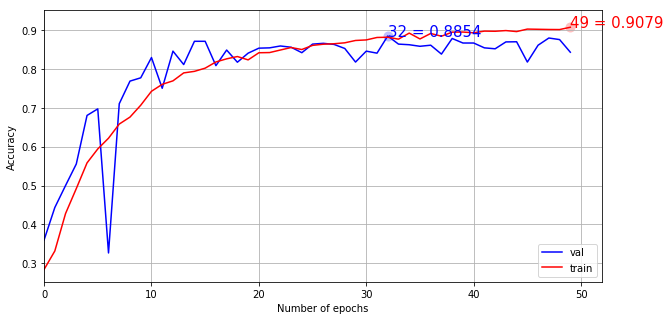

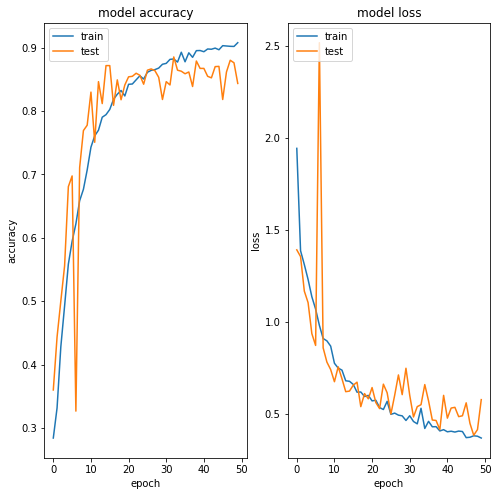

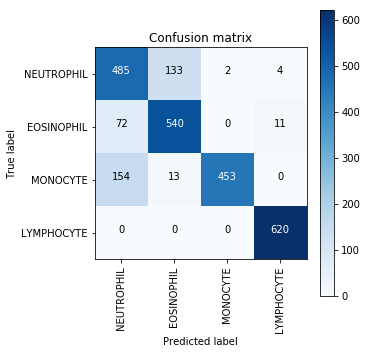

In [28]:
runOurModel2(X_train, y_trainHot, X_test, y_testHot, save_dir='./result_ourself2')


2487/2487 [==============================] - ETA: 13 - ETA: 3 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 473us/step

Keras CNN #1C - accuracy: 0.8950542820041612 

             precision    recall  f1-score   support

 NEUTROPHIL       0.77      0.86      0.81       624
 EOSINOPHIL       0.89      0.83      0.86       623
   MONOCYTE       0.96      0.90      0.93       620
 LYMPHOCYTE       0.99      1.00      0.99       620

avg / total       0.90      0.90      0.90      2487



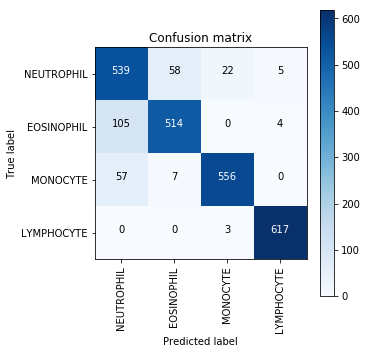

In [54]:
def testOurModel2(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, 
                    learning_rate=1.0, lr_decay=0.0, shift_fraction=0.1,
                    save_dir='./result_ourself2', file_name='/weights-47.h5'):
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_our_model2(num_classes, input_shape)
    
    print("")
    test_model_2(model, x_test, y_test, save_dir + file_name, learning_rate=1.0, lr_decay=0.0)
    
testOurModel2(X_train, y_trainHot, X_test, y_testHot, save_dir='./result_ourself2', file_name='/weights-47.h5')

Epoch 1/50
312/311 [==============================] - ETA: 11:57 - loss: 6.4853 - acc: 0.28 - ETA: 6:07 - loss: 10.9518 - acc: 0.23 - ETA: 4:09 - loss: 10.1447 - acc: 0.22 - ETA: 2:34 - loss: 8.4873 - acc: 0.2375 - ETA: 1:53 - loss: 7.6775 - acc: 0.263 - ETA: 1:30 - loss: 7.1674 - acc: 0.274 - ETA: 1:23 - loss: 6.9638 - acc: 0.278 - ETA: 1:16 - loss: 6.7853 - acc: 0.284 - ETA: 1:06 - loss: 6.4878 - acc: 0.283 - ETA: 1:02 - loss: 6.3546 - acc: 0.279 - ETA: 56s - loss: 6.1180 - acc: 0.287 - ETA: 51s - loss: 5.9113 - acc: 0.28 - ETA: 49s - loss: 5.8154 - acc: 0.28 - ETA: 45s - loss: 5.6345 - acc: 0.28 - ETA: 44s - loss: 5.5637 - acc: 0.27 - ETA: 42s - loss: 5.4834 - acc: 0.28 - ETA: 40s - loss: 5.3327 - acc: 0.28 - ETA: 38s - loss: 5.1926 - acc: 0.27 - ETA: 36s - loss: 5.0624 - acc: 0.27 - ETA: 34s - loss: 4.9397 - acc: 0.28 - ETA: 32s - loss: 4.8244 - acc: 0.27 - ETA: 31s - loss: 4.7156 - acc: 0.27 - ETA: 30s - loss: 4.6129 - acc: 0.27 - ETA: 29s - loss: 4.5154 - acc: 0.27 - ETA: 28s - l

312/311 [==============================] - ETA: 15s - loss: 1.2881 - acc: 0.46 - ETA: 14s - loss: 1.2651 - acc: 0.44 - ETA: 14s - loss: 1.3291 - acc: 0.39 - ETA: 14s - loss: 1.3229 - acc: 0.39 - ETA: 14s - loss: 1.3213 - acc: 0.41 - ETA: 14s - loss: 1.3021 - acc: 0.42 - ETA: 14s - loss: 1.3042 - acc: 0.42 - ETA: 14s - loss: 1.2854 - acc: 0.44 - ETA: 14s - loss: 1.2913 - acc: 0.43 - ETA: 14s - loss: 1.3036 - acc: 0.42 - ETA: 13s - loss: 1.3075 - acc: 0.42 - ETA: 13s - loss: 1.3109 - acc: 0.41 - ETA: 13s - loss: 1.3079 - acc: 0.41 - ETA: 13s - loss: 1.3078 - acc: 0.41 - ETA: 13s - loss: 1.3128 - acc: 0.40 - ETA: 13s - loss: 1.3124 - acc: 0.39 - ETA: 13s - loss: 1.3090 - acc: 0.40 - ETA: 13s - loss: 1.3091 - acc: 0.40 - ETA: 13s - loss: 1.3051 - acc: 0.40 - ETA: 13s - loss: 1.2993 - acc: 0.41 - ETA: 13s - loss: 1.2973 - acc: 0.41 - ETA: 13s - loss: 1.3026 - acc: 0.41 - ETA: 13s - loss: 1.3041 - acc: 0.41 - ETA: 13s - loss: 1.3049 - acc: 0.41 - ETA: 13s - loss: 1.3022 - acc: 0.41 - ETA: 13

312/311 [==============================] - ETA: 17s - loss: 1.1517 - acc: 0.50 - ETA: 16s - loss: 1.1602 - acc: 0.56 - ETA: 16s - loss: 1.1668 - acc: 0.55 - ETA: 16s - loss: 1.1475 - acc: 0.57 - ETA: 15s - loss: 1.1593 - acc: 0.55 - ETA: 15s - loss: 1.1892 - acc: 0.53 - ETA: 14s - loss: 1.1845 - acc: 0.52 - ETA: 14s - loss: 1.1509 - acc: 0.53 - ETA: 14s - loss: 1.1429 - acc: 0.54 - ETA: 14s - loss: 1.1212 - acc: 0.55 - ETA: 14s - loss: 1.1188 - acc: 0.56 - ETA: 14s - loss: 1.1253 - acc: 0.54 - ETA: 14s - loss: 1.1206 - acc: 0.54 - ETA: 14s - loss: 1.1225 - acc: 0.53 - ETA: 14s - loss: 1.1414 - acc: 0.53 - ETA: 13s - loss: 1.1424 - acc: 0.53 - ETA: 13s - loss: 1.1439 - acc: 0.53 - ETA: 13s - loss: 1.1408 - acc: 0.53 - ETA: 13s - loss: 1.1467 - acc: 0.52 - ETA: 13s - loss: 1.1552 - acc: 0.51 - ETA: 13s - loss: 1.1526 - acc: 0.51 - ETA: 13s - loss: 1.1498 - acc: 0.51 - ETA: 13s - loss: 1.1570 - acc: 0.51 - ETA: 13s - loss: 1.1539 - acc: 0.51 - ETA: 12s - loss: 1.1515 - acc: 0.51 - ETA: 12

282/311 [==========================>...] - ETA: 19s - loss: 1.1856 - acc: 0.50 - ETA: 16s - loss: 1.1210 - acc: 0.52 - ETA: 17s - loss: 1.1057 - acc: 0.51 - ETA: 17s - loss: 1.0974 - acc: 0.50 - ETA: 16s - loss: 1.1078 - acc: 0.51 - ETA: 17s - loss: 1.1407 - acc: 0.51 - ETA: 17s - loss: 1.1567 - acc: 0.50 - ETA: 17s - loss: 1.1605 - acc: 0.50 - ETA: 17s - loss: 1.1565 - acc: 0.51 - ETA: 17s - loss: 1.1363 - acc: 0.52 - ETA: 17s - loss: 1.1235 - acc: 0.53 - ETA: 17s - loss: 1.1147 - acc: 0.54 - ETA: 17s - loss: 1.1104 - acc: 0.54 - ETA: 17s - loss: 1.1090 - acc: 0.54 - ETA: 17s - loss: 1.1057 - acc: 0.55 - ETA: 17s - loss: 1.1007 - acc: 0.55 - ETA: 17s - loss: 1.0958 - acc: 0.55 - ETA: 17s - loss: 1.0901 - acc: 0.55 - ETA: 16s - loss: 1.1097 - acc: 0.55 - ETA: 16s - loss: 1.1077 - acc: 0.55 - ETA: 16s - loss: 1.1013 - acc: 0.55 - ETA: 16s - loss: 1.0961 - acc: 0.56 - ETA: 16s - loss: 1.1096 - acc: 0.55 - ETA: 16s - loss: 1.1033 - acc: 0.56 - ETA: 16s - loss: 1.1012 - acc: 0.56 - ETA: 16

286/311 [==========================>...] - ETA: 12s - loss: 1.2077 - acc: 0.46 - ETA: 16s - loss: 1.0862 - acc: 0.53 - ETA: 16s - loss: 0.9519 - acc: 0.60 - ETA: 15s - loss: 0.9188 - acc: 0.60 - ETA: 16s - loss: 0.8891 - acc: 0.62 - ETA: 16s - loss: 0.8883 - acc: 0.62 - ETA: 17s - loss: 0.9183 - acc: 0.61 - ETA: 17s - loss: 0.9010 - acc: 0.62 - ETA: 17s - loss: 0.8782 - acc: 0.63 - ETA: 17s - loss: 0.8862 - acc: 0.64 - ETA: 17s - loss: 0.9074 - acc: 0.62 - ETA: 17s - loss: 0.9174 - acc: 0.62 - ETA: 17s - loss: 0.9159 - acc: 0.62 - ETA: 17s - loss: 0.9295 - acc: 0.61 - ETA: 17s - loss: 0.9099 - acc: 0.63 - ETA: 17s - loss: 0.9070 - acc: 0.63 - ETA: 16s - loss: 0.9073 - acc: 0.63 - ETA: 16s - loss: 0.8994 - acc: 0.63 - ETA: 16s - loss: 0.9061 - acc: 0.63 - ETA: 16s - loss: 0.9492 - acc: 0.61 - ETA: 15s - loss: 0.9623 - acc: 0.61 - ETA: 15s - loss: 0.9575 - acc: 0.61 - ETA: 16s - loss: 0.9566 - acc: 0.62 - ETA: 15s - loss: 0.9602 - acc: 0.62 - ETA: 15s - loss: 0.9598 - acc: 0.62 - ETA: 15

312/311 [==============================] - ETA: 1s - loss: 0.9264 - acc: 0.639 - ETA: 1s - loss: 0.9259 - acc: 0.639 - ETA: 1s - loss: 0.9255 - acc: 0.640 - ETA: 1s - loss: 0.9247 - acc: 0.640 - ETA: 0s - loss: 0.9241 - acc: 0.640 - ETA: 0s - loss: 0.9238 - acc: 0.640 - ETA: 0s - loss: 0.9238 - acc: 0.640 - ETA: 0s - loss: 0.9239 - acc: 0.640 - ETA: 0s - loss: 0.9235 - acc: 0.640 - ETA: 0s - loss: 0.9232 - acc: 0.640 - ETA: 0s - loss: 0.9229 - acc: 0.641 - ETA: 0s - loss: 0.9223 - acc: 0.641 - ETA: 0s - loss: 0.9228 - acc: 0.640 - ETA: 0s - loss: 0.9223 - acc: 0.641 - ETA: 0s - loss: 0.9219 - acc: 0.641 - ETA: 0s - loss: 0.9214 - acc: 0.642 - ETA: 0s - loss: 0.9207 - acc: 0.642 - ETA: 0s - loss: 0.9204 - acc: 0.642 - ETA: 0s - loss: 0.9207 - acc: 0.642 - ETA: 0s - loss: 0.9213 - acc: 0.642 - 19s 61ms/step - loss: 0.9217 - acc: 0.6417 - val_loss: 0.7957 - val_acc: 0.7559
Epoch 8/50
312/311 [==============================] - ETA: 14s - loss: 0.8771 - acc: 0.53 - ETA: 14s - loss: 0.8539 -

312/311 [==============================] - ETA: 14s - loss: 0.6425 - acc: 0.71 - ETA: 14s - loss: 0.7946 - acc: 0.68 - ETA: 14s - loss: 0.7225 - acc: 0.74 - ETA: 14s - loss: 0.7175 - acc: 0.74 - ETA: 14s - loss: 0.7836 - acc: 0.71 - ETA: 14s - loss: 0.8146 - acc: 0.69 - ETA: 14s - loss: 0.8149 - acc: 0.69 - ETA: 14s - loss: 0.8445 - acc: 0.67 - ETA: 14s - loss: 0.8351 - acc: 0.67 - ETA: 14s - loss: 0.8250 - acc: 0.68 - ETA: 14s - loss: 0.8302 - acc: 0.67 - ETA: 14s - loss: 0.8305 - acc: 0.67 - ETA: 14s - loss: 0.8226 - acc: 0.68 - ETA: 13s - loss: 0.8131 - acc: 0.68 - ETA: 13s - loss: 0.8109 - acc: 0.68 - ETA: 13s - loss: 0.8064 - acc: 0.68 - ETA: 13s - loss: 0.7982 - acc: 0.68 - ETA: 13s - loss: 0.7937 - acc: 0.68 - ETA: 13s - loss: 0.7938 - acc: 0.69 - ETA: 14s - loss: 0.7926 - acc: 0.69 - ETA: 14s - loss: 0.7891 - acc: 0.69 - ETA: 14s - loss: 0.7927 - acc: 0.69 - ETA: 13s - loss: 0.8003 - acc: 0.68 - ETA: 13s - loss: 0.8283 - acc: 0.67 - ETA: 13s - loss: 0.8343 - acc: 0.67 - ETA: 13

293/311 [===========================>..] - ETA: 16s - loss: 0.5701 - acc: 0.81 - ETA: 17s - loss: 0.6377 - acc: 0.78 - ETA: 17s - loss: 0.7127 - acc: 0.73 - ETA: 17s - loss: 0.6833 - acc: 0.74 - ETA: 17s - loss: 0.6801 - acc: 0.75 - ETA: 18s - loss: 0.7062 - acc: 0.75 - ETA: 17s - loss: 0.7980 - acc: 0.70 - ETA: 16s - loss: 0.8677 - acc: 0.67 - ETA: 16s - loss: 0.8483 - acc: 0.69 - ETA: 15s - loss: 0.8146 - acc: 0.71 - ETA: 15s - loss: 0.8084 - acc: 0.71 - ETA: 15s - loss: 0.7923 - acc: 0.72 - ETA: 15s - loss: 0.7837 - acc: 0.72 - ETA: 15s - loss: 0.7817 - acc: 0.72 - ETA: 15s - loss: 0.7716 - acc: 0.73 - ETA: 15s - loss: 0.7692 - acc: 0.72 - ETA: 15s - loss: 0.7656 - acc: 0.73 - ETA: 15s - loss: 0.7572 - acc: 0.73 - ETA: 15s - loss: 0.7469 - acc: 0.73 - ETA: 15s - loss: 0.7423 - acc: 0.73 - ETA: 15s - loss: 0.7398 - acc: 0.73 - ETA: 15s - loss: 0.7322 - acc: 0.74 - ETA: 15s - loss: 0.7371 - acc: 0.73 - ETA: 15s - loss: 0.7338 - acc: 0.73 - ETA: 15s - loss: 0.7341 - acc: 0.73 - ETA: 15

312/311 [==============================] - ETA: 0s - loss: 0.7232 - acc: 0.755 - ETA: 0s - loss: 0.7235 - acc: 0.755 - ETA: 0s - loss: 0.7238 - acc: 0.754 - ETA: 0s - loss: 0.7235 - acc: 0.755 - ETA: 0s - loss: 0.7226 - acc: 0.755 - ETA: 0s - loss: 0.7224 - acc: 0.755 - ETA: 0s - loss: 0.7223 - acc: 0.755 - ETA: 0s - loss: 0.7221 - acc: 0.755 - ETA: 0s - loss: 0.7213 - acc: 0.755 - ETA: 0s - loss: 0.7203 - acc: 0.755 - 19s 59ms/step - loss: 0.7214 - acc: 0.7558 - val_loss: 0.6501 - val_acc: 0.7929
Epoch 12/50
312/311 [==============================] - ETA: 10s - loss: 0.7298 - acc: 0.71 - ETA: 17s - loss: 0.6514 - acc: 0.75 - ETA: 15s - loss: 0.6667 - acc: 0.76 - ETA: 16s - loss: 0.6436 - acc: 0.78 - ETA: 17s - loss: 0.6412 - acc: 0.78 - ETA: 17s - loss: 0.6550 - acc: 0.76 - ETA: 17s - loss: 0.6321 - acc: 0.77 - ETA: 17s - loss: 0.6429 - acc: 0.78 - ETA: 17s - loss: 0.6344 - acc: 0.78 - ETA: 17s - loss: 0.6494 - acc: 0.78 - ETA: 17s - loss: 0.6453 - acc: 0.78 - ETA: 16s - loss: 0.6331 

Epoch 13/50


294/311 [===========================>..] - ETA: 15s - loss: 0.5185 - acc: 0.81 - ETA: 14s - loss: 0.5965 - acc: 0.80 - ETA: 14s - loss: 0.5859 - acc: 0.80 - ETA: 14s - loss: 0.5746 - acc: 0.80 - ETA: 14s - loss: 0.5813 - acc: 0.79 - ETA: 14s - loss: 0.5873 - acc: 0.79 - ETA: 14s - loss: 0.5773 - acc: 0.79 - ETA: 14s - loss: 0.5921 - acc: 0.79 - ETA: 14s - loss: 0.6089 - acc: 0.78 - ETA: 14s - loss: 0.6103 - acc: 0.78 - ETA: 13s - loss: 0.6024 - acc: 0.79 - ETA: 13s - loss: 0.6066 - acc: 0.79 - ETA: 13s - loss: 0.6157 - acc: 0.79 - ETA: 13s - loss: 0.6138 - acc: 0.79 - ETA: 13s - loss: 0.6124 - acc: 0.80 - ETA: 13s - loss: 0.6081 - acc: 0.80 - ETA: 13s - loss: 0.6063 - acc: 0.80 - ETA: 13s - loss: 0.6092 - acc: 0.80 - ETA: 13s - loss: 0.6002 - acc: 0.80 - ETA: 13s - loss: 0.5959 - acc: 0.80 - ETA: 12s - loss: 0.5989 - acc: 0.80 - ETA: 13s - loss: 0.5981 - acc: 0.80 - ETA: 13s - loss: 0.6016 - acc: 0.80 - ETA: 13s - loss: 0.5998 - acc: 0.80 - ETA: 12s - loss: 0.5886 - acc: 0.80 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.7532 - acc: 0.78 - ETA: 14s - loss: 0.5664 - acc: 0.85 - ETA: 14s - loss: 0.5569 - acc: 0.87 - ETA: 14s - loss: 0.5354 - acc: 0.87 - ETA: 14s - loss: 0.5887 - acc: 0.82 - ETA: 14s - loss: 0.6077 - acc: 0.80 - ETA: 14s - loss: 0.6081 - acc: 0.80 - ETA: 14s - loss: 0.6041 - acc: 0.80 - ETA: 14s - loss: 0.6201 - acc: 0.79 - ETA: 14s - loss: 0.6202 - acc: 0.80 - ETA: 14s - loss: 0.6118 - acc: 0.80 - ETA: 14s - loss: 0.6124 - acc: 0.79 - ETA: 14s - loss: 0.6086 - acc: 0.79 - ETA: 15s - loss: 0.6099 - acc: 0.79 - ETA: 14s - loss: 0.6253 - acc: 0.78 - ETA: 14s - loss: 0.6307 - acc: 0.78 - ETA: 14s - loss: 0.6234 - acc: 0.79 - ETA: 14s - loss: 0.6299 - acc: 0.78 - ETA: 14s - loss: 0.6325 - acc: 0.78 - ETA: 14s - loss: 0.6283 - acc: 0.78 - ETA: 14s - loss: 0.6255 - acc: 0.78 - ETA: 14s - loss: 0.6196 - acc: 0.78 - ETA: 14s - loss: 0.6193 - acc: 0.78 - ETA: 14s - loss: 0.6325 - acc: 0.78 - ETA: 14s - loss: 0.6577 - acc: 0.76 - ETA: 14

274/311 [=========================>....] - ETA: 19s - loss: 0.5921 - acc: 0.84 - ETA: 16s - loss: 0.5976 - acc: 0.81 - ETA: 17s - loss: 0.5752 - acc: 0.81 - ETA: 18s - loss: 0.6110 - acc: 0.80 - ETA: 16s - loss: 0.5750 - acc: 0.82 - ETA: 17s - loss: 0.5824 - acc: 0.81 - ETA: 17s - loss: 0.5789 - acc: 0.81 - ETA: 17s - loss: 0.5864 - acc: 0.81 - ETA: 16s - loss: 0.5775 - acc: 0.81 - ETA: 16s - loss: 0.5737 - acc: 0.82 - ETA: 16s - loss: 0.5875 - acc: 0.81 - ETA: 16s - loss: 0.5895 - acc: 0.80 - ETA: 16s - loss: 0.5809 - acc: 0.81 - ETA: 16s - loss: 0.5879 - acc: 0.80 - ETA: 16s - loss: 0.5901 - acc: 0.80 - ETA: 16s - loss: 0.5984 - acc: 0.80 - ETA: 16s - loss: 0.5976 - acc: 0.80 - ETA: 16s - loss: 0.5951 - acc: 0.80 - ETA: 16s - loss: 0.6078 - acc: 0.79 - ETA: 16s - loss: 0.6135 - acc: 0.79 - ETA: 16s - loss: 0.6153 - acc: 0.79 - ETA: 16s - loss: 0.6157 - acc: 0.79 - ETA: 16s - loss: 0.6141 - acc: 0.79 - ETA: 16s - loss: 0.6114 - acc: 0.79 - ETA: 16s - loss: 0.6096 - acc: 0.79 - ETA: 16

295/311 [===========================>..] - ETA: 24s - loss: 0.7401 - acc: 0.75 - ETA: 17s - loss: 0.5853 - acc: 0.81 - ETA: 17s - loss: 0.5163 - acc: 0.85 - ETA: 18s - loss: 0.5616 - acc: 0.82 - ETA: 16s - loss: 0.6271 - acc: 0.79 - ETA: 17s - loss: 0.6491 - acc: 0.79 - ETA: 17s - loss: 0.6477 - acc: 0.80 - ETA: 16s - loss: 0.6285 - acc: 0.81 - ETA: 16s - loss: 0.6346 - acc: 0.80 - ETA: 16s - loss: 0.6353 - acc: 0.80 - ETA: 17s - loss: 0.6412 - acc: 0.80 - ETA: 17s - loss: 0.6540 - acc: 0.80 - ETA: 17s - loss: 0.6502 - acc: 0.80 - ETA: 17s - loss: 0.6493 - acc: 0.80 - ETA: 17s - loss: 0.6424 - acc: 0.80 - ETA: 16s - loss: 0.6264 - acc: 0.81 - ETA: 16s - loss: 0.6309 - acc: 0.81 - ETA: 16s - loss: 0.6356 - acc: 0.80 - ETA: 16s - loss: 0.6306 - acc: 0.80 - ETA: 15s - loss: 0.6326 - acc: 0.80 - ETA: 15s - loss: 0.6293 - acc: 0.80 - ETA: 15s - loss: 0.6303 - acc: 0.80 - ETA: 15s - loss: 0.6278 - acc: 0.80 - ETA: 15s - loss: 0.6224 - acc: 0.80 - ETA: 14s - loss: 0.6158 - acc: 0.80 - ETA: 14

312/311 [==============================] - ETA: 0s - loss: 0.6132 - acc: 0.804 - ETA: 0s - loss: 0.6137 - acc: 0.804 - ETA: 0s - loss: 0.6137 - acc: 0.804 - ETA: 0s - loss: 0.6138 - acc: 0.803 - ETA: 0s - loss: 0.6135 - acc: 0.804 - ETA: 0s - loss: 0.6136 - acc: 0.803 - ETA: 0s - loss: 0.6134 - acc: 0.803 - ETA: 0s - loss: 0.6135 - acc: 0.803 - ETA: 0s - loss: 0.6142 - acc: 0.803 - ETA: 0s - loss: 0.6147 - acc: 0.803 - ETA: 0s - loss: 0.6150 - acc: 0.803 - ETA: 0s - loss: 0.6151 - acc: 0.803 - ETA: 0s - loss: 0.6149 - acc: 0.803 - 19s 60ms/step - loss: 0.6150 - acc: 0.8033 - val_loss: 0.5940 - val_acc: 0.8484
Epoch 17/50


282/311 [==========================>...] - ETA: 14s - loss: 0.5707 - acc: 0.78 - ETA: 16s - loss: 0.5653 - acc: 0.79 - ETA: 17s - loss: 0.5631 - acc: 0.80 - ETA: 16s - loss: 0.5463 - acc: 0.80 - ETA: 16s - loss: 0.5801 - acc: 0.78 - ETA: 16s - loss: 0.5718 - acc: 0.79 - ETA: 17s - loss: 0.5752 - acc: 0.79 - ETA: 17s - loss: 0.5486 - acc: 0.80 - ETA: 17s - loss: 0.5379 - acc: 0.81 - ETA: 17s - loss: 0.5358 - acc: 0.82 - ETA: 16s - loss: 0.6002 - acc: 0.79 - ETA: 17s - loss: 0.6620 - acc: 0.78 - ETA: 17s - loss: 0.7123 - acc: 0.77 - ETA: 17s - loss: 0.7443 - acc: 0.75 - ETA: 17s - loss: 0.7915 - acc: 0.74 - ETA: 17s - loss: 0.7629 - acc: 0.75 - ETA: 17s - loss: 0.7524 - acc: 0.75 - ETA: 17s - loss: 0.7457 - acc: 0.75 - ETA: 16s - loss: 0.7378 - acc: 0.75 - ETA: 16s - loss: 0.7113 - acc: 0.77 - ETA: 16s - loss: 0.6964 - acc: 0.77 - ETA: 15s - loss: 0.6794 - acc: 0.78 - ETA: 15s - loss: 0.6753 - acc: 0.78 - ETA: 15s - loss: 0.6701 - acc: 0.78 - ETA: 15s - loss: 0.6695 - acc: 0.78 - ETA: 15

298/311 [===========================>..] - ETA: 16s - loss: 0.6610 - acc: 0.81 - ETA: 17s - loss: 0.6294 - acc: 0.81 - ETA: 16s - loss: 0.6177 - acc: 0.82 - ETA: 16s - loss: 0.6859 - acc: 0.77 - ETA: 16s - loss: 0.7022 - acc: 0.77 - ETA: 16s - loss: 0.6748 - acc: 0.79 - ETA: 16s - loss: 0.6838 - acc: 0.78 - ETA: 16s - loss: 0.6634 - acc: 0.78 - ETA: 15s - loss: 0.6387 - acc: 0.79 - ETA: 15s - loss: 0.6266 - acc: 0.80 - ETA: 16s - loss: 0.6197 - acc: 0.81 - ETA: 16s - loss: 0.6104 - acc: 0.81 - ETA: 16s - loss: 0.6037 - acc: 0.81 - ETA: 16s - loss: 0.6020 - acc: 0.81 - ETA: 16s - loss: 0.6196 - acc: 0.81 - ETA: 16s - loss: 0.6207 - acc: 0.81 - ETA: 16s - loss: 0.6135 - acc: 0.82 - ETA: 16s - loss: 0.6056 - acc: 0.82 - ETA: 15s - loss: 0.6103 - acc: 0.82 - ETA: 15s - loss: 0.6087 - acc: 0.82 - ETA: 15s - loss: 0.6019 - acc: 0.83 - ETA: 15s - loss: 0.6007 - acc: 0.83 - ETA: 15s - loss: 0.6040 - acc: 0.82 - ETA: 15s - loss: 0.6106 - acc: 0.82 - ETA: 15s - loss: 0.6108 - acc: 0.82 - ETA: 15

312/311 [==============================] - ETA: 0s - loss: 0.6003 - acc: 0.805 - ETA: 0s - loss: 0.6008 - acc: 0.805 - ETA: 0s - loss: 0.6007 - acc: 0.805 - ETA: 0s - loss: 0.6009 - acc: 0.804 - ETA: 0s - loss: 0.6014 - acc: 0.804 - ETA: 0s - loss: 0.6015 - acc: 0.804 - ETA: 0s - loss: 0.6008 - acc: 0.804 - ETA: 0s - loss: 0.6002 - acc: 0.805 - ETA: 0s - loss: 0.6004 - acc: 0.805 - ETA: 0s - loss: 0.6021 - acc: 0.804 - ETA: 0s - loss: 0.6034 - acc: 0.803 - ETA: 0s - loss: 0.6033 - acc: 0.803 - 18s 59ms/step - loss: 0.6029 - acc: 0.8039 - val_loss: 0.5411 - val_acc: 0.8601
Epoch 19/50


282/311 [==========================>...] - ETA: 16s - loss: 0.3905 - acc: 0.93 - ETA: 15s - loss: 0.3876 - acc: 0.92 - ETA: 17s - loss: 0.4606 - acc: 0.89 - ETA: 18s - loss: 0.4728 - acc: 0.89 - ETA: 18s - loss: 0.5194 - acc: 0.86 - ETA: 18s - loss: 0.5525 - acc: 0.82 - ETA: 18s - loss: 0.6218 - acc: 0.79 - ETA: 17s - loss: 0.6308 - acc: 0.78 - ETA: 17s - loss: 0.6339 - acc: 0.78 - ETA: 17s - loss: 0.6455 - acc: 0.78 - ETA: 17s - loss: 0.6563 - acc: 0.77 - ETA: 17s - loss: 0.6584 - acc: 0.77 - ETA: 17s - loss: 0.6417 - acc: 0.78 - ETA: 17s - loss: 0.6251 - acc: 0.79 - ETA: 17s - loss: 0.6182 - acc: 0.79 - ETA: 17s - loss: 0.6173 - acc: 0.78 - ETA: 17s - loss: 0.6025 - acc: 0.79 - ETA: 17s - loss: 0.6022 - acc: 0.79 - ETA: 17s - loss: 0.5977 - acc: 0.79 - ETA: 16s - loss: 0.5788 - acc: 0.80 - ETA: 17s - loss: 0.5751 - acc: 0.80 - ETA: 17s - loss: 0.5709 - acc: 0.80 - ETA: 17s - loss: 0.5696 - acc: 0.80 - ETA: 17s - loss: 0.5759 - acc: 0.80 - ETA: 16s - loss: 0.5751 - acc: 0.80 - ETA: 16

287/311 [==========================>...] - ETA: 13s - loss: 0.7460 - acc: 0.75 - ETA: 14s - loss: 0.5268 - acc: 0.83 - ETA: 15s - loss: 0.5064 - acc: 0.84 - ETA: 15s - loss: 0.5103 - acc: 0.83 - ETA: 15s - loss: 0.5493 - acc: 0.81 - ETA: 14s - loss: 0.5313 - acc: 0.82 - ETA: 15s - loss: 0.5200 - acc: 0.82 - ETA: 15s - loss: 0.5194 - acc: 0.83 - ETA: 15s - loss: 0.5138 - acc: 0.83 - ETA: 15s - loss: 0.5197 - acc: 0.82 - ETA: 16s - loss: 0.5270 - acc: 0.81 - ETA: 16s - loss: 0.5248 - acc: 0.81 - ETA: 15s - loss: 0.5173 - acc: 0.82 - ETA: 15s - loss: 0.5129 - acc: 0.82 - ETA: 15s - loss: 0.5154 - acc: 0.81 - ETA: 16s - loss: 0.5168 - acc: 0.81 - ETA: 15s - loss: 0.5205 - acc: 0.81 - ETA: 15s - loss: 0.5198 - acc: 0.81 - ETA: 15s - loss: 0.5185 - acc: 0.81 - ETA: 15s - loss: 0.5130 - acc: 0.82 - ETA: 15s - loss: 0.5125 - acc: 0.82 - ETA: 15s - loss: 0.5213 - acc: 0.81 - ETA: 15s - loss: 0.5112 - acc: 0.82 - ETA: 15s - loss: 0.5087 - acc: 0.82 - ETA: 15s - loss: 0.5059 - acc: 0.82 - ETA: 15

312/311 [==============================] - ETA: 1s - loss: 0.5510 - acc: 0.825 - ETA: 1s - loss: 0.5506 - acc: 0.825 - ETA: 1s - loss: 0.5505 - acc: 0.825 - ETA: 1s - loss: 0.5500 - acc: 0.825 - ETA: 1s - loss: 0.5494 - acc: 0.825 - ETA: 0s - loss: 0.5490 - acc: 0.826 - ETA: 0s - loss: 0.5494 - acc: 0.825 - ETA: 0s - loss: 0.5487 - acc: 0.825 - ETA: 0s - loss: 0.5478 - acc: 0.825 - ETA: 0s - loss: 0.5469 - acc: 0.826 - ETA: 0s - loss: 0.5466 - acc: 0.826 - ETA: 0s - loss: 0.5462 - acc: 0.826 - ETA: 0s - loss: 0.5462 - acc: 0.826 - ETA: 0s - loss: 0.5490 - acc: 0.825 - ETA: 0s - loss: 0.5525 - acc: 0.825 - ETA: 0s - loss: 0.5535 - acc: 0.825 - ETA: 0s - loss: 0.5538 - acc: 0.824 - ETA: 0s - loss: 0.5543 - acc: 0.824 - 19s 61ms/step - loss: 0.5542 - acc: 0.8242 - val_loss: 0.5639 - val_acc: 0.8392
Epoch 21/50


272/311 [=========================>....] - ETA: 18s - loss: 0.5943 - acc: 0.71 - ETA: 15s - loss: 0.5464 - acc: 0.80 - ETA: 17s - loss: 0.5238 - acc: 0.82 - ETA: 18s - loss: 0.5237 - acc: 0.81 - ETA: 16s - loss: 0.4913 - acc: 0.83 - ETA: 17s - loss: 0.4887 - acc: 0.84 - ETA: 17s - loss: 0.4863 - acc: 0.84 - ETA: 17s - loss: 0.4777 - acc: 0.84 - ETA: 16s - loss: 0.4730 - acc: 0.84 - ETA: 16s - loss: 0.4718 - acc: 0.84 - ETA: 16s - loss: 0.4582 - acc: 0.85 - ETA: 15s - loss: 0.4561 - acc: 0.85 - ETA: 16s - loss: 0.4493 - acc: 0.86 - ETA: 16s - loss: 0.4525 - acc: 0.86 - ETA: 16s - loss: 0.4507 - acc: 0.86 - ETA: 16s - loss: 0.4514 - acc: 0.86 - ETA: 16s - loss: 0.4571 - acc: 0.86 - ETA: 16s - loss: 0.4589 - acc: 0.86 - ETA: 16s - loss: 0.4614 - acc: 0.85 - ETA: 16s - loss: 0.4572 - acc: 0.86 - ETA: 16s - loss: 0.4543 - acc: 0.86 - ETA: 16s - loss: 0.4577 - acc: 0.85 - ETA: 16s - loss: 0.4574 - acc: 0.85 - ETA: 16s - loss: 0.4572 - acc: 0.86 - ETA: 16s - loss: 0.4669 - acc: 0.85 - ETA: 16

273/311 [=========================>....] - ETA: 21s - loss: 0.4176 - acc: 0.84 - ETA: 20s - loss: 0.5474 - acc: 0.81 - ETA: 21s - loss: 0.5245 - acc: 0.81 - ETA: 18s - loss: 0.5248 - acc: 0.80 - ETA: 18s - loss: 0.5459 - acc: 0.80 - ETA: 17s - loss: 0.5700 - acc: 0.79 - ETA: 17s - loss: 0.5711 - acc: 0.79 - ETA: 17s - loss: 0.5607 - acc: 0.80 - ETA: 17s - loss: 0.5442 - acc: 0.80 - ETA: 17s - loss: 0.5281 - acc: 0.81 - ETA: 17s - loss: 0.5160 - acc: 0.81 - ETA: 17s - loss: 0.5078 - acc: 0.82 - ETA: 17s - loss: 0.5141 - acc: 0.82 - ETA: 17s - loss: 0.5138 - acc: 0.82 - ETA: 17s - loss: 0.5129 - acc: 0.82 - ETA: 17s - loss: 0.5105 - acc: 0.82 - ETA: 17s - loss: 0.5071 - acc: 0.82 - ETA: 17s - loss: 0.5005 - acc: 0.83 - ETA: 17s - loss: 0.4951 - acc: 0.83 - ETA: 16s - loss: 0.4884 - acc: 0.83 - ETA: 16s - loss: 0.5072 - acc: 0.83 - ETA: 16s - loss: 0.5112 - acc: 0.83 - ETA: 16s - loss: 0.5043 - acc: 0.83 - ETA: 16s - loss: 0.5016 - acc: 0.83 - ETA: 16s - loss: 0.5036 - acc: 0.83 - ETA: 16

312/311 [==============================] - ETA: 2s - loss: 0.5653 - acc: 0.822 - ETA: 2s - loss: 0.5651 - acc: 0.822 - ETA: 2s - loss: 0.5654 - acc: 0.822 - ETA: 2s - loss: 0.5654 - acc: 0.821 - ETA: 1s - loss: 0.5649 - acc: 0.822 - ETA: 1s - loss: 0.5646 - acc: 0.822 - ETA: 1s - loss: 0.5640 - acc: 0.822 - ETA: 1s - loss: 0.5634 - acc: 0.822 - ETA: 1s - loss: 0.5641 - acc: 0.822 - ETA: 1s - loss: 0.5642 - acc: 0.822 - ETA: 1s - loss: 0.5633 - acc: 0.822 - ETA: 1s - loss: 0.5633 - acc: 0.822 - ETA: 1s - loss: 0.5631 - acc: 0.822 - ETA: 1s - loss: 0.5632 - acc: 0.822 - ETA: 1s - loss: 0.5627 - acc: 0.822 - ETA: 0s - loss: 0.5625 - acc: 0.822 - ETA: 0s - loss: 0.5620 - acc: 0.822 - ETA: 0s - loss: 0.5614 - acc: 0.822 - ETA: 0s - loss: 0.5610 - acc: 0.822 - ETA: 0s - loss: 0.5605 - acc: 0.823 - ETA: 0s - loss: 0.5605 - acc: 0.822 - ETA: 0s - loss: 0.5600 - acc: 0.823 - ETA: 0s - loss: 0.5600 - acc: 0.823 - ETA: 0s - loss: 0.5597 - acc: 0.823 - ETA: 0s - loss: 0.5596 - acc: 0.823 - ETA: 0s

282/311 [==========================>...] - ETA: 14s - loss: 0.5804 - acc: 0.84 - ETA: 14s - loss: 0.6190 - acc: 0.81 - ETA: 14s - loss: 0.6068 - acc: 0.81 - ETA: 15s - loss: 0.6310 - acc: 0.80 - ETA: 16s - loss: 0.5957 - acc: 0.81 - ETA: 16s - loss: 0.5683 - acc: 0.81 - ETA: 17s - loss: 0.5427 - acc: 0.83 - ETA: 17s - loss: 0.5216 - acc: 0.84 - ETA: 16s - loss: 0.5009 - acc: 0.85 - ETA: 17s - loss: 0.5024 - acc: 0.85 - ETA: 16s - loss: 0.4884 - acc: 0.85 - ETA: 16s - loss: 0.4890 - acc: 0.85 - ETA: 16s - loss: 0.5100 - acc: 0.84 - ETA: 15s - loss: 0.5066 - acc: 0.84 - ETA: 15s - loss: 0.5111 - acc: 0.84 - ETA: 15s - loss: 0.5204 - acc: 0.84 - ETA: 15s - loss: 0.5173 - acc: 0.84 - ETA: 15s - loss: 0.5124 - acc: 0.84 - ETA: 15s - loss: 0.5092 - acc: 0.84 - ETA: 15s - loss: 0.5049 - acc: 0.84 - ETA: 15s - loss: 0.5050 - acc: 0.84 - ETA: 15s - loss: 0.5047 - acc: 0.84 - ETA: 15s - loss: 0.5020 - acc: 0.84 - ETA: 15s - loss: 0.5074 - acc: 0.84 - ETA: 15s - loss: 0.5088 - acc: 0.84 - ETA: 15

280/311 [=========================>....] - ETA: 11s - loss: 0.5611 - acc: 0.84 - ETA: 15s - loss: 0.4626 - acc: 0.87 - ETA: 16s - loss: 0.4381 - acc: 0.88 - ETA: 17s - loss: 0.4210 - acc: 0.89 - ETA: 18s - loss: 0.4317 - acc: 0.90 - ETA: 17s - loss: 0.4525 - acc: 0.89 - ETA: 16s - loss: 0.4895 - acc: 0.88 - ETA: 15s - loss: 0.4878 - acc: 0.87 - ETA: 15s - loss: 0.4926 - acc: 0.86 - ETA: 15s - loss: 0.5231 - acc: 0.85 - ETA: 14s - loss: 0.5135 - acc: 0.86 - ETA: 14s - loss: 0.5089 - acc: 0.85 - ETA: 15s - loss: 0.5124 - acc: 0.85 - ETA: 15s - loss: 0.5179 - acc: 0.84 - ETA: 15s - loss: 0.5121 - acc: 0.84 - ETA: 15s - loss: 0.5080 - acc: 0.85 - ETA: 15s - loss: 0.5107 - acc: 0.84 - ETA: 15s - loss: 0.5040 - acc: 0.84 - ETA: 15s - loss: 0.5073 - acc: 0.85 - ETA: 15s - loss: 0.4997 - acc: 0.85 - ETA: 15s - loss: 0.4991 - acc: 0.85 - ETA: 15s - loss: 0.5071 - acc: 0.84 - ETA: 14s - loss: 0.5069 - acc: 0.84 - ETA: 14s - loss: 0.5081 - acc: 0.84 - ETA: 14s - loss: 0.5155 - acc: 0.84 - ETA: 15

312/311 [==============================] - ETA: 1s - loss: 0.5248 - acc: 0.838 - ETA: 1s - loss: 0.5243 - acc: 0.838 - ETA: 1s - loss: 0.5240 - acc: 0.838 - ETA: 1s - loss: 0.5234 - acc: 0.839 - ETA: 1s - loss: 0.5228 - acc: 0.839 - ETA: 1s - loss: 0.5230 - acc: 0.839 - ETA: 1s - loss: 0.5242 - acc: 0.838 - ETA: 1s - loss: 0.5251 - acc: 0.838 - ETA: 1s - loss: 0.5306 - acc: 0.836 - ETA: 1s - loss: 0.5321 - acc: 0.835 - ETA: 1s - loss: 0.5321 - acc: 0.835 - ETA: 0s - loss: 0.5322 - acc: 0.835 - ETA: 0s - loss: 0.5320 - acc: 0.835 - ETA: 0s - loss: 0.5331 - acc: 0.835 - ETA: 0s - loss: 0.5331 - acc: 0.835 - ETA: 0s - loss: 0.5335 - acc: 0.835 - ETA: 0s - loss: 0.5329 - acc: 0.835 - ETA: 0s - loss: 0.5331 - acc: 0.834 - ETA: 0s - loss: 0.5333 - acc: 0.834 - ETA: 0s - loss: 0.5333 - acc: 0.834 - ETA: 0s - loss: 0.5328 - acc: 0.834 - ETA: 0s - loss: 0.5325 - acc: 0.834 - ETA: 0s - loss: 0.5320 - acc: 0.835 - ETA: 0s - loss: 0.5316 - acc: 0.835 - ETA: 0s - loss: 0.5321 - acc: 0.835 - 19s 62m

273/311 [=========================>....] - ETA: 11s - loss: 0.8962 - acc: 0.62 - ETA: 13s - loss: 0.7634 - acc: 0.65 - ETA: 14s - loss: 0.7046 - acc: 0.71 - ETA: 16s - loss: 0.6561 - acc: 0.74 - ETA: 16s - loss: 0.6206 - acc: 0.76 - ETA: 17s - loss: 0.6085 - acc: 0.76 - ETA: 17s - loss: 0.5793 - acc: 0.77 - ETA: 17s - loss: 0.5550 - acc: 0.79 - ETA: 17s - loss: 0.5569 - acc: 0.78 - ETA: 18s - loss: 0.5494 - acc: 0.79 - ETA: 17s - loss: 0.5345 - acc: 0.81 - ETA: 17s - loss: 0.5295 - acc: 0.81 - ETA: 17s - loss: 0.5284 - acc: 0.81 - ETA: 17s - loss: 0.5223 - acc: 0.81 - ETA: 17s - loss: 0.5334 - acc: 0.81 - ETA: 17s - loss: 0.5297 - acc: 0.82 - ETA: 17s - loss: 0.5284 - acc: 0.82 - ETA: 17s - loss: 0.5219 - acc: 0.82 - ETA: 17s - loss: 0.5185 - acc: 0.82 - ETA: 17s - loss: 0.5144 - acc: 0.82 - ETA: 17s - loss: 0.5121 - acc: 0.82 - ETA: 17s - loss: 0.5121 - acc: 0.82 - ETA: 17s - loss: 0.5104 - acc: 0.82 - ETA: 16s - loss: 0.5024 - acc: 0.83 - ETA: 16s - loss: 0.5007 - acc: 0.83 - ETA: 16

310/311 [============================>.] - ETA: 14s - loss: 0.4571 - acc: 0.87 - ETA: 14s - loss: 0.5456 - acc: 0.85 - ETA: 14s - loss: 0.4927 - acc: 0.86 - ETA: 14s - loss: 0.4447 - acc: 0.89 - ETA: 14s - loss: 0.4291 - acc: 0.89 - ETA: 14s - loss: 0.4115 - acc: 0.90 - ETA: 14s - loss: 0.4286 - acc: 0.89 - ETA: 13s - loss: 0.4446 - acc: 0.87 - ETA: 13s - loss: 0.4476 - acc: 0.87 - ETA: 13s - loss: 0.4458 - acc: 0.87 - ETA: 13s - loss: 0.4468 - acc: 0.87 - ETA: 13s - loss: 0.4355 - acc: 0.87 - ETA: 13s - loss: 0.4319 - acc: 0.87 - ETA: 13s - loss: 0.4385 - acc: 0.87 - ETA: 13s - loss: 0.4328 - acc: 0.87 - ETA: 13s - loss: 0.4298 - acc: 0.87 - ETA: 14s - loss: 0.4285 - acc: 0.87 - ETA: 14s - loss: 0.4318 - acc: 0.87 - ETA: 14s - loss: 0.4286 - acc: 0.88 - ETA: 14s - loss: 0.4230 - acc: 0.88 - ETA: 14s - loss: 0.4233 - acc: 0.88 - ETA: 14s - loss: 0.4318 - acc: 0.88 - ETA: 14s - loss: 0.4358 - acc: 0.87 - ETA: 14s - loss: 0.4401 - acc: 0.87 - ETA: 14s - loss: 0.4402 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 0s - loss: 0.5070 - acc: 0.840 - 18s 57ms/step - loss: 0.5066 - acc: 0.8405 - val_loss: 0.4963 - val_acc: 0.8774
Epoch 27/50


272/311 [=========================>....] - ETA: 16s - loss: 0.6089 - acc: 0.84 - ETA: 16s - loss: 0.4158 - acc: 0.89 - ETA: 17s - loss: 0.4299 - acc: 0.89 - ETA: 17s - loss: 0.4054 - acc: 0.89 - ETA: 17s - loss: 0.4390 - acc: 0.87 - ETA: 16s - loss: 0.4576 - acc: 0.86 - ETA: 17s - loss: 0.4713 - acc: 0.86 - ETA: 17s - loss: 0.4930 - acc: 0.86 - ETA: 17s - loss: 0.5089 - acc: 0.85 - ETA: 17s - loss: 0.5140 - acc: 0.85 - ETA: 17s - loss: 0.5085 - acc: 0.85 - ETA: 18s - loss: 0.4997 - acc: 0.85 - ETA: 18s - loss: 0.4907 - acc: 0.85 - ETA: 18s - loss: 0.5070 - acc: 0.85 - ETA: 18s - loss: 0.5044 - acc: 0.85 - ETA: 18s - loss: 0.4959 - acc: 0.85 - ETA: 18s - loss: 0.4949 - acc: 0.85 - ETA: 17s - loss: 0.4885 - acc: 0.85 - ETA: 17s - loss: 0.4938 - acc: 0.85 - ETA: 17s - loss: 0.4931 - acc: 0.85 - ETA: 17s - loss: 0.4871 - acc: 0.85 - ETA: 17s - loss: 0.4827 - acc: 0.85 - ETA: 17s - loss: 0.4794 - acc: 0.85 - ETA: 17s - loss: 0.4750 - acc: 0.85 - ETA: 17s - loss: 0.4739 - acc: 0.85 - ETA: 17

312/311 [==============================] - ETA: 19s - loss: 0.3367 - acc: 0.93 - ETA: 21s - loss: 0.3934 - acc: 0.87 - ETA: 22s - loss: 0.3735 - acc: 0.88 - ETA: 22s - loss: 0.3491 - acc: 0.88 - ETA: 19s - loss: 0.4257 - acc: 0.86 - ETA: 20s - loss: 0.4175 - acc: 0.87 - ETA: 19s - loss: 0.4416 - acc: 0.86 - ETA: 19s - loss: 0.4520 - acc: 0.85 - ETA: 18s - loss: 0.4350 - acc: 0.86 - ETA: 18s - loss: 0.4374 - acc: 0.85 - ETA: 18s - loss: 0.4461 - acc: 0.85 - ETA: 17s - loss: 0.4895 - acc: 0.85 - ETA: 17s - loss: 0.4851 - acc: 0.85 - ETA: 18s - loss: 0.4799 - acc: 0.85 - ETA: 18s - loss: 0.4767 - acc: 0.85 - ETA: 18s - loss: 0.4720 - acc: 0.85 - ETA: 17s - loss: 0.4749 - acc: 0.84 - ETA: 17s - loss: 0.4881 - acc: 0.83 - ETA: 17s - loss: 0.4880 - acc: 0.83 - ETA: 16s - loss: 0.4782 - acc: 0.84 - ETA: 16s - loss: 0.4686 - acc: 0.84 - ETA: 16s - loss: 0.4726 - acc: 0.84 - ETA: 16s - loss: 0.5209 - acc: 0.82 - ETA: 15s - loss: 0.6306 - acc: 0.80 - ETA: 15s - loss: 0.6405 - acc: 0.80 - ETA: 15

270/311 [=========================>....] - ETA: 14s - loss: 0.4690 - acc: 0.84 - ETA: 16s - loss: 0.5635 - acc: 0.79 - ETA: 18s - loss: 0.4836 - acc: 0.84 - ETA: 16s - loss: 0.4432 - acc: 0.85 - ETA: 17s - loss: 0.4337 - acc: 0.86 - ETA: 17s - loss: 0.4635 - acc: 0.84 - ETA: 17s - loss: 0.4592 - acc: 0.84 - ETA: 18s - loss: 0.5026 - acc: 0.83 - ETA: 18s - loss: 0.4942 - acc: 0.84 - ETA: 18s - loss: 0.4921 - acc: 0.84 - ETA: 17s - loss: 0.4739 - acc: 0.84 - ETA: 17s - loss: 0.4643 - acc: 0.85 - ETA: 17s - loss: 0.4708 - acc: 0.84 - ETA: 17s - loss: 0.4650 - acc: 0.84 - ETA: 17s - loss: 0.4735 - acc: 0.84 - ETA: 17s - loss: 0.4724 - acc: 0.84 - ETA: 17s - loss: 0.4736 - acc: 0.84 - ETA: 17s - loss: 0.4719 - acc: 0.84 - ETA: 17s - loss: 0.4830 - acc: 0.83 - ETA: 17s - loss: 0.4899 - acc: 0.83 - ETA: 16s - loss: 0.5038 - acc: 0.83 - ETA: 16s - loss: 0.5002 - acc: 0.83 - ETA: 16s - loss: 0.5002 - acc: 0.83 - ETA: 16s - loss: 0.4941 - acc: 0.84 - ETA: 16s - loss: 0.4855 - acc: 0.84 - ETA: 16

312/311 [==============================] - ETA: 10s - loss: 0.3541 - acc: 0.93 - ETA: 14s - loss: 0.5366 - acc: 0.87 - ETA: 14s - loss: 0.4891 - acc: 0.89 - ETA: 14s - loss: 0.4317 - acc: 0.91 - ETA: 14s - loss: 0.4246 - acc: 0.91 - ETA: 14s - loss: 0.4480 - acc: 0.89 - ETA: 14s - loss: 0.4795 - acc: 0.88 - ETA: 14s - loss: 0.4892 - acc: 0.87 - ETA: 14s - loss: 0.4829 - acc: 0.87 - ETA: 14s - loss: 0.4826 - acc: 0.87 - ETA: 14s - loss: 0.4671 - acc: 0.87 - ETA: 14s - loss: 0.4584 - acc: 0.87 - ETA: 14s - loss: 0.4552 - acc: 0.87 - ETA: 14s - loss: 0.4491 - acc: 0.87 - ETA: 14s - loss: 0.4456 - acc: 0.87 - ETA: 13s - loss: 0.4474 - acc: 0.87 - ETA: 13s - loss: 0.4527 - acc: 0.86 - ETA: 13s - loss: 0.4496 - acc: 0.86 - ETA: 13s - loss: 0.4476 - acc: 0.87 - ETA: 13s - loss: 0.4481 - acc: 0.86 - ETA: 13s - loss: 0.4445 - acc: 0.86 - ETA: 13s - loss: 0.4458 - acc: 0.86 - ETA: 13s - loss: 0.4399 - acc: 0.86 - ETA: 13s - loss: 0.4379 - acc: 0.87 - ETA: 12s - loss: 0.4334 - acc: 0.87 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.2812 - acc: 0.96 - ETA: 14s - loss: 0.3730 - acc: 0.92 - ETA: 14s - loss: 0.3867 - acc: 0.92 - ETA: 14s - loss: 0.3481 - acc: 0.94 - ETA: 14s - loss: 0.3514 - acc: 0.93 - ETA: 14s - loss: 0.3813 - acc: 0.92 - ETA: 14s - loss: 0.4247 - acc: 0.90 - ETA: 14s - loss: 0.4226 - acc: 0.90 - ETA: 14s - loss: 0.4178 - acc: 0.90 - ETA: 14s - loss: 0.4359 - acc: 0.88 - ETA: 14s - loss: 0.4243 - acc: 0.89 - ETA: 14s - loss: 0.4208 - acc: 0.89 - ETA: 14s - loss: 0.4191 - acc: 0.89 - ETA: 14s - loss: 0.4279 - acc: 0.89 - ETA: 14s - loss: 0.4286 - acc: 0.88 - ETA: 14s - loss: 0.4281 - acc: 0.88 - ETA: 14s - loss: 0.4314 - acc: 0.87 - ETA: 13s - loss: 0.4224 - acc: 0.88 - ETA: 13s - loss: 0.4187 - acc: 0.88 - ETA: 13s - loss: 0.4161 - acc: 0.88 - ETA: 13s - loss: 0.4235 - acc: 0.87 - ETA: 13s - loss: 0.4229 - acc: 0.87 - ETA: 13s - loss: 0.4187 - acc: 0.87 - ETA: 13s - loss: 0.4236 - acc: 0.87 - ETA: 13s - loss: 0.4289 - acc: 0.87 - ETA: 13

312/311 [==============================] - ETA: 13s - loss: 0.3170 - acc: 0.87 - ETA: 14s - loss: 0.3968 - acc: 0.87 - ETA: 14s - loss: 0.4055 - acc: 0.86 - ETA: 14s - loss: 0.4268 - acc: 0.84 - ETA: 14s - loss: 0.4234 - acc: 0.86 - ETA: 14s - loss: 0.4248 - acc: 0.87 - ETA: 14s - loss: 0.4200 - acc: 0.87 - ETA: 14s - loss: 0.4255 - acc: 0.87 - ETA: 14s - loss: 0.4455 - acc: 0.86 - ETA: 14s - loss: 0.4426 - acc: 0.86 - ETA: 14s - loss: 0.4420 - acc: 0.86 - ETA: 14s - loss: 0.4468 - acc: 0.86 - ETA: 14s - loss: 0.4419 - acc: 0.86 - ETA: 14s - loss: 0.4318 - acc: 0.86 - ETA: 14s - loss: 0.4294 - acc: 0.87 - ETA: 14s - loss: 0.4426 - acc: 0.86 - ETA: 13s - loss: 0.4684 - acc: 0.85 - ETA: 13s - loss: 0.4754 - acc: 0.84 - ETA: 13s - loss: 0.4864 - acc: 0.84 - ETA: 13s - loss: 0.4810 - acc: 0.84 - ETA: 13s - loss: 0.4775 - acc: 0.84 - ETA: 13s - loss: 0.4934 - acc: 0.84 - ETA: 13s - loss: 0.5031 - acc: 0.83 - ETA: 13s - loss: 0.5028 - acc: 0.83 - ETA: 12s - loss: 0.4957 - acc: 0.84 - ETA: 12

300/311 [===========================>..] - ETA: 14s - loss: 0.3441 - acc: 0.93 - ETA: 16s - loss: 0.4665 - acc: 0.85 - ETA: 17s - loss: 0.4756 - acc: 0.85 - ETA: 18s - loss: 0.4620 - acc: 0.85 - ETA: 18s - loss: 0.4524 - acc: 0.85 - ETA: 18s - loss: 0.4744 - acc: 0.85 - ETA: 17s - loss: 0.4738 - acc: 0.85 - ETA: 17s - loss: 0.4674 - acc: 0.84 - ETA: 18s - loss: 0.4643 - acc: 0.84 - ETA: 17s - loss: 0.4561 - acc: 0.85 - ETA: 17s - loss: 0.4727 - acc: 0.84 - ETA: 16s - loss: 0.4869 - acc: 0.84 - ETA: 16s - loss: 0.4886 - acc: 0.85 - ETA: 16s - loss: 0.4886 - acc: 0.85 - ETA: 15s - loss: 0.4797 - acc: 0.85 - ETA: 15s - loss: 0.4727 - acc: 0.86 - ETA: 15s - loss: 0.4639 - acc: 0.86 - ETA: 15s - loss: 0.4557 - acc: 0.86 - ETA: 15s - loss: 0.4445 - acc: 0.87 - ETA: 15s - loss: 0.4386 - acc: 0.87 - ETA: 15s - loss: 0.4472 - acc: 0.86 - ETA: 15s - loss: 0.4456 - acc: 0.86 - ETA: 15s - loss: 0.4394 - acc: 0.86 - ETA: 15s - loss: 0.4326 - acc: 0.87 - ETA: 15s - loss: 0.4326 - acc: 0.86 - ETA: 15

312/311 [==============================] - ETA: 0s - loss: 0.4536 - acc: 0.862 - ETA: 0s - loss: 0.4529 - acc: 0.863 - ETA: 0s - loss: 0.4526 - acc: 0.863 - ETA: 0s - loss: 0.4518 - acc: 0.863 - ETA: 0s - loss: 0.4534 - acc: 0.863 - ETA: 0s - loss: 0.4536 - acc: 0.863 - ETA: 0s - loss: 0.4535 - acc: 0.863 - 18s 59ms/step - loss: 0.4530 - acc: 0.8633 - val_loss: 0.5535 - val_acc: 0.8709
Epoch 37/50


308/311 [============================>.] - ETA: 20s - loss: 0.3858 - acc: 0.87 - ETA: 16s - loss: 0.3537 - acc: 0.92 - ETA: 18s - loss: 0.3399 - acc: 0.91 - ETA: 20s - loss: 0.3477 - acc: 0.90 - ETA: 19s - loss: 0.3534 - acc: 0.91 - ETA: 19s - loss: 0.3580 - acc: 0.90 - ETA: 19s - loss: 0.3495 - acc: 0.91 - ETA: 19s - loss: 0.3382 - acc: 0.91 - ETA: 19s - loss: 0.3418 - acc: 0.90 - ETA: 18s - loss: 0.3479 - acc: 0.90 - ETA: 18s - loss: 0.3508 - acc: 0.90 - ETA: 17s - loss: 0.3675 - acc: 0.88 - ETA: 17s - loss: 0.3785 - acc: 0.88 - ETA: 16s - loss: 0.3737 - acc: 0.88 - ETA: 16s - loss: 0.3704 - acc: 0.88 - ETA: 16s - loss: 0.3702 - acc: 0.88 - ETA: 16s - loss: 0.3747 - acc: 0.88 - ETA: 15s - loss: 0.3696 - acc: 0.88 - ETA: 15s - loss: 0.3601 - acc: 0.89 - ETA: 15s - loss: 0.3646 - acc: 0.88 - ETA: 15s - loss: 0.3721 - acc: 0.88 - ETA: 15s - loss: 0.3729 - acc: 0.88 - ETA: 14s - loss: 0.3653 - acc: 0.89 - ETA: 14s - loss: 0.3843 - acc: 0.88 - ETA: 14s - loss: 0.3965 - acc: 0.87 - ETA: 14

280/311 [=========================>....] - ETA: 14s - loss: 0.2482 - acc: 0.96 - ETA: 14s - loss: 0.2869 - acc: 0.93 - ETA: 16s - loss: 0.2918 - acc: 0.92 - ETA: 17s - loss: 0.2823 - acc: 0.93 - ETA: 17s - loss: 0.3122 - acc: 0.92 - ETA: 17s - loss: 0.3206 - acc: 0.91 - ETA: 17s - loss: 0.3389 - acc: 0.90 - ETA: 17s - loss: 0.3723 - acc: 0.88 - ETA: 17s - loss: 0.3977 - acc: 0.86 - ETA: 16s - loss: 0.3874 - acc: 0.87 - ETA: 16s - loss: 0.3854 - acc: 0.87 - ETA: 15s - loss: 0.3747 - acc: 0.88 - ETA: 15s - loss: 0.3671 - acc: 0.88 - ETA: 15s - loss: 0.3828 - acc: 0.88 - ETA: 15s - loss: 0.4036 - acc: 0.87 - ETA: 14s - loss: 0.4334 - acc: 0.86 - ETA: 14s - loss: 0.4353 - acc: 0.86 - ETA: 14s - loss: 0.4471 - acc: 0.85 - ETA: 14s - loss: 0.4485 - acc: 0.85 - ETA: 14s - loss: 0.4576 - acc: 0.85 - ETA: 14s - loss: 0.4639 - acc: 0.85 - ETA: 14s - loss: 0.4604 - acc: 0.85 - ETA: 14s - loss: 0.4669 - acc: 0.85 - ETA: 14s - loss: 0.4658 - acc: 0.85 - ETA: 14s - loss: 0.4645 - acc: 0.85 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.4435 - acc: 0.868 - ETA: 1s - loss: 0.4433 - acc: 0.868 - ETA: 1s - loss: 0.4432 - acc: 0.868 - ETA: 1s - loss: 0.4431 - acc: 0.868 - ETA: 1s - loss: 0.4422 - acc: 0.868 - ETA: 1s - loss: 0.4424 - acc: 0.868 - ETA: 1s - loss: 0.4422 - acc: 0.868 - ETA: 1s - loss: 0.4417 - acc: 0.869 - ETA: 1s - loss: 0.4409 - acc: 0.869 - ETA: 1s - loss: 0.4405 - acc: 0.869 - ETA: 0s - loss: 0.4410 - acc: 0.869 - ETA: 0s - loss: 0.4415 - acc: 0.868 - ETA: 0s - loss: 0.4417 - acc: 0.868 - ETA: 0s - loss: 0.4417 - acc: 0.868 - ETA: 0s - loss: 0.4415 - acc: 0.868 - ETA: 0s - loss: 0.4414 - acc: 0.868 - ETA: 0s - loss: 0.4404 - acc: 0.868 - ETA: 0s - loss: 0.4400 - acc: 0.868 - ETA: 0s - loss: 0.4397 - acc: 0.868 - ETA: 0s - loss: 0.4393 - acc: 0.868 - ETA: 0s - loss: 0.4390 - acc: 0.868 - 19s 61ms/step - loss: 0.4389 - acc: 0.8688 - val_loss: 0.5735 - val_acc: 0.8846
Epoch 39/50


285/311 [==========================>...] - ETA: 16s - loss: 0.3678 - acc: 0.87 - ETA: 15s - loss: 0.3530 - acc: 0.89 - ETA: 15s - loss: 0.3462 - acc: 0.90 - ETA: 16s - loss: 0.3635 - acc: 0.90 - ETA: 15s - loss: 0.3962 - acc: 0.89 - ETA: 15s - loss: 0.4008 - acc: 0.88 - ETA: 15s - loss: 0.4020 - acc: 0.88 - ETA: 15s - loss: 0.4029 - acc: 0.88 - ETA: 15s - loss: 0.3968 - acc: 0.88 - ETA: 15s - loss: 0.4069 - acc: 0.88 - ETA: 16s - loss: 0.4077 - acc: 0.88 - ETA: 16s - loss: 0.4035 - acc: 0.88 - ETA: 16s - loss: 0.4008 - acc: 0.88 - ETA: 15s - loss: 0.3872 - acc: 0.88 - ETA: 15s - loss: 0.3954 - acc: 0.88 - ETA: 15s - loss: 0.4051 - acc: 0.88 - ETA: 15s - loss: 0.4184 - acc: 0.87 - ETA: 16s - loss: 0.4169 - acc: 0.87 - ETA: 16s - loss: 0.4166 - acc: 0.87 - ETA: 16s - loss: 0.4125 - acc: 0.87 - ETA: 16s - loss: 0.4098 - acc: 0.87 - ETA: 15s - loss: 0.4077 - acc: 0.88 - ETA: 15s - loss: 0.4976 - acc: 0.87 - ETA: 15s - loss: 0.5038 - acc: 0.86 - ETA: 15s - loss: 0.5089 - acc: 0.86 - ETA: 15

307/311 [============================>.] - ETA: 14s - loss: 0.3278 - acc: 0.87 - ETA: 19s - loss: 0.3590 - acc: 0.89 - ETA: 16s - loss: 0.3773 - acc: 0.89 - ETA: 17s - loss: 0.3710 - acc: 0.88 - ETA: 17s - loss: 0.3641 - acc: 0.89 - ETA: 16s - loss: 0.3853 - acc: 0.87 - ETA: 15s - loss: 0.4587 - acc: 0.87 - ETA: 16s - loss: 0.4941 - acc: 0.86 - ETA: 16s - loss: 0.4849 - acc: 0.86 - ETA: 15s - loss: 0.4692 - acc: 0.87 - ETA: 15s - loss: 0.4641 - acc: 0.87 - ETA: 15s - loss: 0.4598 - acc: 0.87 - ETA: 15s - loss: 0.4606 - acc: 0.87 - ETA: 14s - loss: 0.4512 - acc: 0.87 - ETA: 14s - loss: 0.4511 - acc: 0.87 - ETA: 14s - loss: 0.4560 - acc: 0.87 - ETA: 14s - loss: 0.4530 - acc: 0.87 - ETA: 14s - loss: 0.4459 - acc: 0.87 - ETA: 14s - loss: 0.4546 - acc: 0.87 - ETA: 14s - loss: 0.4501 - acc: 0.87 - ETA: 14s - loss: 0.4403 - acc: 0.88 - ETA: 14s - loss: 0.4398 - acc: 0.88 - ETA: 14s - loss: 0.4349 - acc: 0.88 - ETA: 14s - loss: 0.4344 - acc: 0.88 - ETA: 13s - loss: 0.4295 - acc: 0.88 - ETA: 13

312/311 [==============================] - ETA: 0s - loss: 0.4250 - acc: 0.877 - ETA: 0s - loss: 0.4247 - acc: 0.877 - ETA: 0s - loss: 0.4244 - acc: 0.877 - ETA: 0s - loss: 0.4242 - acc: 0.877 - 18s 59ms/step - loss: 0.4236 - acc: 0.8774 - val_loss: 0.6460 - val_acc: 0.8617
Epoch 41/50


285/311 [==========================>...] - ETA: 20s - loss: 0.4964 - acc: 0.81 - ETA: 19s - loss: 0.7213 - acc: 0.76 - ETA: 18s - loss: 0.6788 - acc: 0.78 - ETA: 18s - loss: 0.6450 - acc: 0.79 - ETA: 18s - loss: 0.5996 - acc: 0.80 - ETA: 19s - loss: 0.5658 - acc: 0.82 - ETA: 18s - loss: 0.5355 - acc: 0.82 - ETA: 18s - loss: 0.5083 - acc: 0.83 - ETA: 18s - loss: 0.4926 - acc: 0.84 - ETA: 19s - loss: 0.4673 - acc: 0.85 - ETA: 19s - loss: 0.4771 - acc: 0.85 - ETA: 19s - loss: 0.4589 - acc: 0.85 - ETA: 18s - loss: 0.4499 - acc: 0.86 - ETA: 18s - loss: 0.4415 - acc: 0.86 - ETA: 18s - loss: 0.4378 - acc: 0.86 - ETA: 18s - loss: 0.4282 - acc: 0.86 - ETA: 19s - loss: 0.4304 - acc: 0.86 - ETA: 18s - loss: 0.4313 - acc: 0.87 - ETA: 19s - loss: 0.4403 - acc: 0.86 - ETA: 19s - loss: 0.4498 - acc: 0.86 - ETA: 18s - loss: 0.4497 - acc: 0.86 - ETA: 18s - loss: 0.4416 - acc: 0.87 - ETA: 17s - loss: 0.4380 - acc: 0.87 - ETA: 17s - loss: 0.4367 - acc: 0.87 - ETA: 17s - loss: 0.4303 - acc: 0.87 - ETA: 17

303/311 [============================>.] - ETA: 14s - loss: 0.2377 - acc: 1.00 - ETA: 15s - loss: 0.2862 - acc: 0.95 - ETA: 14s - loss: 0.2867 - acc: 0.93 - ETA: 15s - loss: 0.3010 - acc: 0.91 - ETA: 14s - loss: 0.3298 - acc: 0.89 - ETA: 14s - loss: 0.3220 - acc: 0.90 - ETA: 14s - loss: 0.3197 - acc: 0.90 - ETA: 14s - loss: 0.3276 - acc: 0.90 - ETA: 14s - loss: 0.3386 - acc: 0.90 - ETA: 14s - loss: 0.3436 - acc: 0.90 - ETA: 15s - loss: 0.3488 - acc: 0.90 - ETA: 15s - loss: 0.3768 - acc: 0.88 - ETA: 15s - loss: 0.3786 - acc: 0.88 - ETA: 15s - loss: 0.3918 - acc: 0.88 - ETA: 15s - loss: 0.3896 - acc: 0.88 - ETA: 15s - loss: 0.3965 - acc: 0.88 - ETA: 15s - loss: 0.3941 - acc: 0.88 - ETA: 15s - loss: 0.3855 - acc: 0.88 - ETA: 15s - loss: 0.3815 - acc: 0.88 - ETA: 15s - loss: 0.3759 - acc: 0.88 - ETA: 15s - loss: 0.3791 - acc: 0.88 - ETA: 15s - loss: 0.3855 - acc: 0.88 - ETA: 15s - loss: 0.3844 - acc: 0.88 - ETA: 15s - loss: 0.3958 - acc: 0.88 - ETA: 15s - loss: 0.3901 - acc: 0.88 - ETA: 15

312/311 [==============================] - ETA: 0s - loss: 0.4051 - acc: 0.879 - ETA: 0s - loss: 0.4046 - acc: 0.879 - ETA: 0s - loss: 0.4048 - acc: 0.880 - ETA: 0s - loss: 0.4048 - acc: 0.880 - ETA: 0s - loss: 0.4056 - acc: 0.879 - 18s 59ms/step - loss: 0.4057 - acc: 0.8795 - val_loss: 0.6334 - val_acc: 0.8814
Epoch 43/50


294/311 [===========================>..] - ETA: 14s - loss: 0.2629 - acc: 0.90 - ETA: 16s - loss: 0.2997 - acc: 0.90 - ETA: 17s - loss: 0.3219 - acc: 0.90 - ETA: 17s - loss: 0.3452 - acc: 0.88 - ETA: 17s - loss: 0.3333 - acc: 0.89 - ETA: 17s - loss: 0.3291 - acc: 0.89 - ETA: 17s - loss: 0.3280 - acc: 0.89 - ETA: 16s - loss: 0.3617 - acc: 0.88 - ETA: 15s - loss: 0.4791 - acc: 0.86 - ETA: 15s - loss: 0.4960 - acc: 0.84 - ETA: 15s - loss: 0.5101 - acc: 0.84 - ETA: 15s - loss: 0.5047 - acc: 0.84 - ETA: 15s - loss: 0.5045 - acc: 0.84 - ETA: 15s - loss: 0.4961 - acc: 0.84 - ETA: 15s - loss: 0.4987 - acc: 0.84 - ETA: 15s - loss: 0.4998 - acc: 0.84 - ETA: 15s - loss: 0.4877 - acc: 0.84 - ETA: 15s - loss: 0.4839 - acc: 0.85 - ETA: 15s - loss: 0.4807 - acc: 0.85 - ETA: 14s - loss: 0.4791 - acc: 0.85 - ETA: 14s - loss: 0.4711 - acc: 0.85 - ETA: 14s - loss: 0.4705 - acc: 0.85 - ETA: 14s - loss: 0.4656 - acc: 0.85 - ETA: 14s - loss: 0.4669 - acc: 0.85 - ETA: 14s - loss: 0.4653 - acc: 0.85 - ETA: 14

279/311 [=========================>....] - ETA: 14s - loss: 0.2760 - acc: 0.96 - ETA: 19s - loss: 0.2681 - acc: 0.96 - ETA: 19s - loss: 0.3600 - acc: 0.91 - ETA: 20s - loss: 0.3603 - acc: 0.91 - ETA: 20s - loss: 0.3938 - acc: 0.90 - ETA: 19s - loss: 0.3915 - acc: 0.90 - ETA: 18s - loss: 0.4131 - acc: 0.88 - ETA: 17s - loss: 0.3952 - acc: 0.89 - ETA: 18s - loss: 0.3823 - acc: 0.89 - ETA: 17s - loss: 0.3637 - acc: 0.90 - ETA: 17s - loss: 0.3665 - acc: 0.90 - ETA: 17s - loss: 0.3567 - acc: 0.91 - ETA: 17s - loss: 0.3493 - acc: 0.91 - ETA: 17s - loss: 0.3448 - acc: 0.91 - ETA: 17s - loss: 0.3410 - acc: 0.91 - ETA: 16s - loss: 0.3402 - acc: 0.91 - ETA: 16s - loss: 0.3471 - acc: 0.91 - ETA: 16s - loss: 0.3597 - acc: 0.91 - ETA: 17s - loss: 0.3658 - acc: 0.91 - ETA: 16s - loss: 0.3659 - acc: 0.90 - ETA: 16s - loss: 0.3753 - acc: 0.90 - ETA: 16s - loss: 0.3725 - acc: 0.90 - ETA: 16s - loss: 0.3770 - acc: 0.90 - ETA: 16s - loss: 0.4898 - acc: 0.88 - ETA: 16s - loss: 0.5074 - acc: 0.87 - ETA: 16

312/311 [==============================] - ETA: 1s - loss: 0.4215 - acc: 0.886 - ETA: 1s - loss: 0.4214 - acc: 0.886 - ETA: 1s - loss: 0.4213 - acc: 0.886 - ETA: 1s - loss: 0.4212 - acc: 0.886 - ETA: 1s - loss: 0.4213 - acc: 0.886 - ETA: 1s - loss: 0.4211 - acc: 0.886 - ETA: 1s - loss: 0.4205 - acc: 0.886 - ETA: 1s - loss: 0.4207 - acc: 0.886 - ETA: 1s - loss: 0.4210 - acc: 0.886 - ETA: 1s - loss: 0.4206 - acc: 0.886 - ETA: 1s - loss: 0.4204 - acc: 0.886 - ETA: 1s - loss: 0.4198 - acc: 0.886 - ETA: 0s - loss: 0.4189 - acc: 0.887 - ETA: 0s - loss: 0.4183 - acc: 0.887 - ETA: 0s - loss: 0.4176 - acc: 0.887 - ETA: 0s - loss: 0.4178 - acc: 0.887 - ETA: 0s - loss: 0.4176 - acc: 0.887 - ETA: 0s - loss: 0.4171 - acc: 0.887 - ETA: 0s - loss: 0.4172 - acc: 0.887 - ETA: 0s - loss: 0.4167 - acc: 0.887 - ETA: 0s - loss: 0.4165 - acc: 0.887 - ETA: 0s - loss: 0.4160 - acc: 0.887 - ETA: 0s - loss: 0.4160 - acc: 0.887 - ETA: 0s - loss: 0.4148 - acc: 0.887 - 19s 62ms/step - loss: 0.4146 - acc: 0.8879 - 

306/311 [============================>.] - ETA: 11s - loss: 0.3280 - acc: 0.87 - ETA: 15s - loss: 0.3838 - acc: 0.82 - ETA: 14s - loss: 0.4590 - acc: 0.85 - ETA: 16s - loss: 0.4361 - acc: 0.86 - ETA: 17s - loss: 0.4434 - acc: 0.85 - ETA: 16s - loss: 0.4128 - acc: 0.87 - ETA: 16s - loss: 0.3942 - acc: 0.88 - ETA: 16s - loss: 0.3869 - acc: 0.88 - ETA: 16s - loss: 0.3733 - acc: 0.88 - ETA: 17s - loss: 0.3705 - acc: 0.88 - ETA: 17s - loss: 0.3557 - acc: 0.89 - ETA: 17s - loss: 0.3586 - acc: 0.89 - ETA: 17s - loss: 0.3568 - acc: 0.89 - ETA: 17s - loss: 0.3563 - acc: 0.89 - ETA: 17s - loss: 0.3493 - acc: 0.89 - ETA: 17s - loss: 0.3523 - acc: 0.89 - ETA: 17s - loss: 0.3453 - acc: 0.90 - ETA: 17s - loss: 0.3444 - acc: 0.90 - ETA: 17s - loss: 0.3472 - acc: 0.89 - ETA: 17s - loss: 0.3490 - acc: 0.89 - ETA: 17s - loss: 0.3614 - acc: 0.89 - ETA: 17s - loss: 0.3630 - acc: 0.89 - ETA: 17s - loss: 0.3664 - acc: 0.89 - ETA: 17s - loss: 0.3701 - acc: 0.89 - ETA: 17s - loss: 0.3643 - acc: 0.89 - ETA: 17

312/311 [==============================] - ETA: 17s - loss: 0.3480 - acc: 0.87 - ETA: 13s - loss: 0.3341 - acc: 0.90 - ETA: 15s - loss: 0.3337 - acc: 0.90 - ETA: 15s - loss: 0.3409 - acc: 0.91 - ETA: 15s - loss: 0.3464 - acc: 0.91 - ETA: 15s - loss: 0.3374 - acc: 0.91 - ETA: 15s - loss: 0.3546 - acc: 0.90 - ETA: 15s - loss: 0.3558 - acc: 0.90 - ETA: 15s - loss: 0.3408 - acc: 0.91 - ETA: 15s - loss: 0.3495 - acc: 0.91 - ETA: 15s - loss: 0.3628 - acc: 0.91 - ETA: 14s - loss: 0.3757 - acc: 0.90 - ETA: 14s - loss: 0.3767 - acc: 0.90 - ETA: 14s - loss: 0.3703 - acc: 0.90 - ETA: 14s - loss: 0.3703 - acc: 0.90 - ETA: 14s - loss: 0.3690 - acc: 0.90 - ETA: 14s - loss: 0.3696 - acc: 0.90 - ETA: 14s - loss: 0.3722 - acc: 0.90 - ETA: 14s - loss: 0.3947 - acc: 0.89 - ETA: 14s - loss: 0.4048 - acc: 0.89 - ETA: 14s - loss: 0.3984 - acc: 0.89 - ETA: 13s - loss: 0.3933 - acc: 0.89 - ETA: 13s - loss: 0.3874 - acc: 0.89 - ETA: 13s - loss: 0.3989 - acc: 0.89 - ETA: 13s - loss: 0.3983 - acc: 0.89 - ETA: 13

Epoch 47/50
312/311 [==============================] - ETA: 14s - loss: 0.3828 - acc: 0.84 - ETA: 12s - loss: 0.3000 - acc: 0.87 - ETA: 13s - loss: 0.3310 - acc: 0.87 - ETA: 13s - loss: 0.3295 - acc: 0.89 - ETA: 14s - loss: 0.3316 - acc: 0.89 - ETA: 13s - loss: 0.3304 - acc: 0.90 - ETA: 14s - loss: 0.3360 - acc: 0.89 - ETA: 14s - loss: 0.3444 - acc: 0.89 - ETA: 14s - loss: 0.3521 - acc: 0.89 - ETA: 14s - loss: 0.3449 - acc: 0.89 - ETA: 14s - loss: 0.3845 - acc: 0.88 - ETA: 14s - loss: 0.4063 - acc: 0.88 - ETA: 13s - loss: 0.4339 - acc: 0.86 - ETA: 13s - loss: 0.4316 - acc: 0.87 - ETA: 13s - loss: 0.4309 - acc: 0.87 - ETA: 13s - loss: 0.4229 - acc: 0.87 - ETA: 13s - loss: 0.4088 - acc: 0.88 - ETA: 13s - loss: 0.4041 - acc: 0.88 - ETA: 13s - loss: 0.4061 - acc: 0.88 - ETA: 13s - loss: 0.3994 - acc: 0.89 - ETA: 13s - loss: 0.4047 - acc: 0.88 - ETA: 13s - loss: 0.4040 - acc: 0.88 - ETA: 13s - loss: 0.3967 - acc: 0.89 - ETA: 13s - loss: 0.3967 - acc: 0.88 - ETA: 13s - loss: 0.3958 - acc: 0.

298/311 [===========================>..] - ETA: 14s - loss: 0.6120 - acc: 0.87 - ETA: 16s - loss: 0.6220 - acc: 0.82 - ETA: 18s - loss: 1.5043 - acc: 0.66 - ETA: 16s - loss: 1.1685 - acc: 0.72 - ETA: 16s - loss: 1.0807 - acc: 0.72 - ETA: 15s - loss: 0.9091 - acc: 0.78 - ETA: 16s - loss: 0.8763 - acc: 0.77 - ETA: 16s - loss: 0.8317 - acc: 0.78 - ETA: 16s - loss: 0.7941 - acc: 0.78 - ETA: 15s - loss: 0.7229 - acc: 0.80 - ETA: 15s - loss: 0.6732 - acc: 0.81 - ETA: 15s - loss: 0.6537 - acc: 0.82 - ETA: 15s - loss: 0.6256 - acc: 0.83 - ETA: 15s - loss: 0.6180 - acc: 0.83 - ETA: 15s - loss: 0.6059 - acc: 0.83 - ETA: 15s - loss: 0.5849 - acc: 0.84 - ETA: 15s - loss: 0.5807 - acc: 0.84 - ETA: 15s - loss: 0.5670 - acc: 0.84 - ETA: 15s - loss: 0.5608 - acc: 0.84 - ETA: 15s - loss: 0.5511 - acc: 0.85 - ETA: 15s - loss: 0.5432 - acc: 0.85 - ETA: 15s - loss: 0.5367 - acc: 0.85 - ETA: 15s - loss: 0.5293 - acc: 0.85 - ETA: 15s - loss: 0.5229 - acc: 0.85 - ETA: 15s - loss: 0.5155 - acc: 0.85 - ETA: 15

312/311 [==============================] - ETA: 0s - loss: 0.3827 - acc: 0.893 - ETA: 0s - loss: 0.3828 - acc: 0.893 - ETA: 0s - loss: 0.3827 - acc: 0.893 - ETA: 0s - loss: 0.3829 - acc: 0.893 - ETA: 0s - loss: 0.3830 - acc: 0.893 - ETA: 0s - loss: 0.3832 - acc: 0.893 - ETA: 0s - loss: 0.3842 - acc: 0.893 - ETA: 0s - loss: 0.3885 - acc: 0.892 - ETA: 0s - loss: 0.3895 - acc: 0.892 - ETA: 0s - loss: 0.3896 - acc: 0.892 - ETA: 0s - loss: 0.3903 - acc: 0.891 - 18s 58ms/step - loss: 0.3909 - acc: 0.8915 - val_loss: 0.4607 - val_acc: 0.8826
Epoch 50/50
312/311 [==============================] - ETA: 14s - loss: 0.5097 - acc: 0.84 - ETA: 14s - loss: 0.4401 - acc: 0.87 - ETA: 14s - loss: 0.4303 - acc: 0.88 - ETA: 14s - loss: 0.4264 - acc: 0.88 - ETA: 14s - loss: 0.4048 - acc: 0.89 - ETA: 14s - loss: 0.3927 - acc: 0.88 - ETA: 14s - loss: 0.3848 - acc: 0.88 - ETA: 14s - loss: 0.3879 - acc: 0.88 - ETA: 14s - loss: 0.3843 - acc: 0.88 - ETA: 14s - loss: 0.3758 - acc: 0.89 - ETA: 15s - loss: 0.3780 

2487/2487 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 424us/step

Keras CNN #1C - accuracy: 0.874145556823959 


             precision    recall  f1-score   support

 NEUTROPHIL       0.71      0.85      0.77       624
 EOSINOPHIL       0.87      0.89      0.88       623
   MONOCYTE       1.00      0.75      0.86       620
 LYMPHOCYTE       0.99      1.00      1.00       620

avg / total       0.89      0.87      0.88      2487



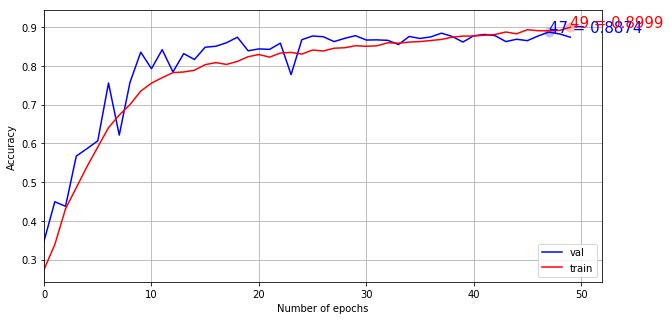

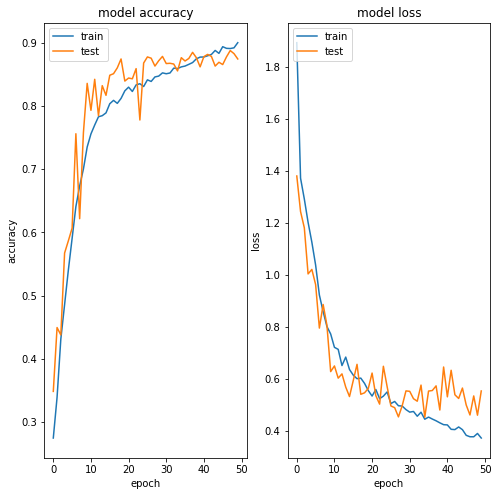

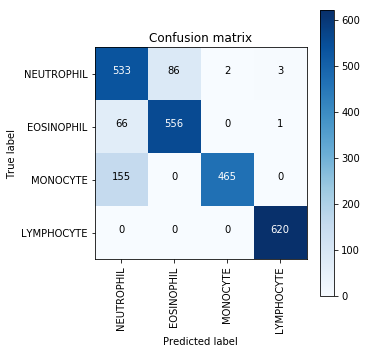

In [27]:
runOurModel2(X_train_2, y_trainHot_2, X_test_2, y_testHot_2, save_dir='./result_ourself2_2')


2487/2487 [==============================] - ETA: 14 - ETA: 3 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 466us/step

Keras CNN #1C - accuracy: 0.89465219122749 

             precision    recall  f1-score   support

 NEUTROPHIL       0.76      0.86      0.81       624
 EOSINOPHIL       0.87      0.97      0.92       623
   MONOCYTE       1.00      0.75      0.86       620
 LYMPHOCYTE       1.00      1.00      1.00       620

avg / total       0.91      0.89      0.89      2487



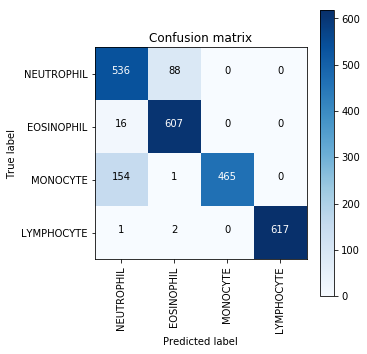

In [56]:
testOurModel2(X_train, y_trainHot, X_test, y_testHot, save_dir='./result_ourself2_2', file_name='/weights-48.h5')

In [25]:
def runOurModel2Optimized(x_train, y_train, x_test, y_test, epochs=50, batch_size=32, 
                          learning_rate=1.0, lr_decay=0.0, shift_fraction=0.1, rotation_range=10, 
                          shift_range=0.1, horizontal_flip=True, vertical_flip=False, optimizer='Adadelta',
                          save_dir='./result_ourself2'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_our_model2(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        shift_fraction=shift_fraction, rotation_range=rotation_range, shift_range=shift_range, 
        horizontal_flip=horizontal_flip, vertical_flip=vertical_flip, optimizer=optimizer,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)

Epoch 1/50
276/311 [=========================>....] - ETA: 22:16 - loss: 6.5918 - acc: 0.15 - ETA: 11:14 - loss: 9.9341 - acc: 0.23 - ETA: 7:33 - loss: 11.1111 - acc: 0.21 - ETA: 5:43 - loss: 9.9574 - acc: 0.2422 - ETA: 4:36 - loss: 9.1784 - acc: 0.243 - ETA: 3:52 - loss: 8.6327 - acc: 0.255 - ETA: 3:21 - loss: 8.2161 - acc: 0.254 - ETA: 2:57 - loss: 7.8856 - acc: 0.257 - ETA: 2:38 - loss: 7.6122 - acc: 0.263 - ETA: 2:11 - loss: 7.1788 - acc: 0.258 - ETA: 2:01 - loss: 6.9987 - acc: 0.257 - ETA: 1:45 - loss: 6.6926 - acc: 0.263 - ETA: 1:39 - loss: 6.5595 - acc: 0.260 - ETA: 1:33 - loss: 6.4384 - acc: 0.252 - ETA: 1:28 - loss: 6.3219 - acc: 0.251 - ETA: 1:24 - loss: 6.2123 - acc: 0.253 - ETA: 1:20 - loss: 6.1087 - acc: 0.258 - ETA: 1:16 - loss: 6.0101 - acc: 0.260 - ETA: 1:10 - loss: 5.8309 - acc: 0.271 - ETA: 1:08 - loss: 5.7466 - acc: 0.273 - ETA: 1:05 - loss: 5.6662 - acc: 0.272 - ETA: 1:03 - loss: 5.5888 - acc: 0.266 - ETA: 1:01 - loss: 5.5142 - acc: 0.265 - ETA: 57s - loss: 5.3736 -

270/311 [=========================>....] - ETA: 19s - loss: 1.3787 - acc: 0.37 - ETA: 17s - loss: 1.4133 - acc: 0.29 - ETA: 16s - loss: 1.4147 - acc: 0.30 - ETA: 17s - loss: 1.4133 - acc: 0.31 - ETA: 16s - loss: 1.4059 - acc: 0.31 - ETA: 16s - loss: 1.4052 - acc: 0.29 - ETA: 16s - loss: 1.4027 - acc: 0.30 - ETA: 16s - loss: 1.3991 - acc: 0.30 - ETA: 16s - loss: 1.3936 - acc: 0.31 - ETA: 16s - loss: 1.3869 - acc: 0.32 - ETA: 15s - loss: 1.3989 - acc: 0.32 - ETA: 15s - loss: 1.4001 - acc: 0.32 - ETA: 15s - loss: 1.3990 - acc: 0.32 - ETA: 15s - loss: 1.3993 - acc: 0.32 - ETA: 15s - loss: 1.3960 - acc: 0.32 - ETA: 15s - loss: 1.3999 - acc: 0.31 - ETA: 15s - loss: 1.3996 - acc: 0.32 - ETA: 15s - loss: 1.3997 - acc: 0.32 - ETA: 15s - loss: 1.3979 - acc: 0.32 - ETA: 14s - loss: 1.3943 - acc: 0.33 - ETA: 15s - loss: 1.3963 - acc: 0.32 - ETA: 14s - loss: 1.3966 - acc: 0.32 - ETA: 14s - loss: 1.3945 - acc: 0.32 - ETA: 14s - loss: 1.3947 - acc: 0.32 - ETA: 14s - loss: 1.3937 - acc: 0.32 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 1.3843 - acc: 0.361 - ETA: 1s - loss: 1.3849 - acc: 0.361 - ETA: 1s - loss: 1.3847 - acc: 0.361 - ETA: 1s - loss: 1.3841 - acc: 0.362 - ETA: 1s - loss: 1.3834 - acc: 0.362 - ETA: 1s - loss: 1.3827 - acc: 0.363 - ETA: 1s - loss: 1.3824 - acc: 0.363 - ETA: 1s - loss: 1.3818 - acc: 0.363 - ETA: 1s - loss: 1.3815 - acc: 0.364 - ETA: 1s - loss: 1.3807 - acc: 0.364 - ETA: 1s - loss: 1.3801 - acc: 0.364 - ETA: 1s - loss: 1.3795 - acc: 0.365 - ETA: 1s - loss: 1.3787 - acc: 0.366 - ETA: 1s - loss: 1.3776 - acc: 0.366 - ETA: 1s - loss: 1.3764 - acc: 0.367 - ETA: 1s - loss: 1.3761 - acc: 0.367 - ETA: 0s - loss: 1.3760 - acc: 0.368 - ETA: 0s - loss: 1.3758 - acc: 0.368 - ETA: 0s - loss: 1.3760 - acc: 0.367 - ETA: 0s - loss: 1.3754 - acc: 0.368 - ETA: 0s - loss: 1.3754 - acc: 0.368 - ETA: 0s - loss: 1.3764 - acc: 0.368 - ETA: 0s - loss: 1.3766 - acc: 0.368 - ETA: 0s - loss: 1.3768 - acc: 0.368 - ETA: 0s - loss: 1.3771 - acc: 0.367 - ETA: 0s

257/311 [=======================>......] - ETA: 11s - loss: 1.2714 - acc: 0.20 - ETA: 13s - loss: 1.3044 - acc: 0.30 - ETA: 14s - loss: 1.2457 - acc: 0.40 - ETA: 14s - loss: 1.2461 - acc: 0.44 - ETA: 15s - loss: 1.2397 - acc: 0.45 - ETA: 15s - loss: 1.2570 - acc: 0.46 - ETA: 15s - loss: 1.2429 - acc: 0.48 - ETA: 15s - loss: 1.2191 - acc: 0.50 - ETA: 15s - loss: 1.2175 - acc: 0.50 - ETA: 15s - loss: 1.2092 - acc: 0.50 - ETA: 15s - loss: 1.2163 - acc: 0.48 - ETA: 15s - loss: 1.2165 - acc: 0.49 - ETA: 15s - loss: 1.2161 - acc: 0.49 - ETA: 15s - loss: 1.2179 - acc: 0.48 - ETA: 15s - loss: 1.1930 - acc: 0.50 - ETA: 15s - loss: 1.1907 - acc: 0.50 - ETA: 15s - loss: 1.1901 - acc: 0.50 - ETA: 14s - loss: 1.1891 - acc: 0.50 - ETA: 14s - loss: 1.1801 - acc: 0.51 - ETA: 14s - loss: 1.1773 - acc: 0.51 - ETA: 14s - loss: 1.1971 - acc: 0.50 - ETA: 14s - loss: 1.2030 - acc: 0.49 - ETA: 14s - loss: 1.2105 - acc: 0.49 - ETA: 14s - loss: 1.2107 - acc: 0.49 - ETA: 14s - loss: 1.2071 - acc: 0.50 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 1.1828 - acc: 0.517 - ETA: 2s - loss: 1.1828 - acc: 0.517 - ETA: 2s - loss: 1.1821 - acc: 0.517 - ETA: 2s - loss: 1.1826 - acc: 0.517 - ETA: 2s - loss: 1.1812 - acc: 0.518 - ETA: 2s - loss: 1.1801 - acc: 0.518 - ETA: 2s - loss: 1.1796 - acc: 0.518 - ETA: 2s - loss: 1.1799 - acc: 0.518 - ETA: 2s - loss: 1.1787 - acc: 0.519 - ETA: 2s - loss: 1.1777 - acc: 0.520 - ETA: 2s - loss: 1.1774 - acc: 0.520 - ETA: 2s - loss: 1.1792 - acc: 0.519 - ETA: 2s - loss: 1.1798 - acc: 0.519 - ETA: 1s - loss: 1.1801 - acc: 0.518 - ETA: 1s - loss: 1.1808 - acc: 0.518 - ETA: 1s - loss: 1.1804 - acc: 0.518 - ETA: 1s - loss: 1.1796 - acc: 0.518 - ETA: 1s - loss: 1.1784 - acc: 0.519 - ETA: 1s - loss: 1.1785 - acc: 0.519 - ETA: 1s - loss: 1.1807 - acc: 0.518 - ETA: 1s - loss: 1.1809 - acc: 0.518 - ETA: 1s - loss: 1.1808 - acc: 0.518 - ETA: 1s - loss: 1.1798 - acc: 0.518 - ETA: 1s - loss: 1.1790 - acc: 0.519 - ETA: 1s - loss: 1.1803 - acc: 0.518 - ETA: 1s

254/311 [=======================>......] - ETA: 15s - loss: 1.2363 - acc: 0.43 - ETA: 14s - loss: 1.1265 - acc: 0.53 - ETA: 16s - loss: 1.0918 - acc: 0.57 - ETA: 15s - loss: 1.1015 - acc: 0.56 - ETA: 15s - loss: 1.0868 - acc: 0.57 - ETA: 15s - loss: 1.1292 - acc: 0.55 - ETA: 15s - loss: 1.2080 - acc: 0.54 - ETA: 15s - loss: 1.1999 - acc: 0.54 - ETA: 15s - loss: 1.1764 - acc: 0.55 - ETA: 15s - loss: 1.1481 - acc: 0.56 - ETA: 15s - loss: 1.0999 - acc: 0.60 - ETA: 15s - loss: 1.1061 - acc: 0.59 - ETA: 15s - loss: 1.0920 - acc: 0.60 - ETA: 14s - loss: 1.0850 - acc: 0.60 - ETA: 15s - loss: 1.0821 - acc: 0.60 - ETA: 14s - loss: 1.0789 - acc: 0.60 - ETA: 14s - loss: 1.0793 - acc: 0.60 - ETA: 14s - loss: 1.0717 - acc: 0.60 - ETA: 14s - loss: 1.0687 - acc: 0.60 - ETA: 14s - loss: 1.0620 - acc: 0.60 - ETA: 14s - loss: 1.0510 - acc: 0.60 - ETA: 14s - loss: 1.0449 - acc: 0.60 - ETA: 14s - loss: 1.0419 - acc: 0.60 - ETA: 14s - loss: 1.0316 - acc: 0.61 - ETA: 14s - loss: 1.0333 - acc: 0.60 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 1.0191 - acc: 0.615 - ETA: 2s - loss: 1.0187 - acc: 0.615 - ETA: 2s - loss: 1.0189 - acc: 0.615 - ETA: 2s - loss: 1.0188 - acc: 0.615 - ETA: 2s - loss: 1.0187 - acc: 0.615 - ETA: 2s - loss: 1.0188 - acc: 0.616 - ETA: 2s - loss: 1.0181 - acc: 0.616 - ETA: 2s - loss: 1.0170 - acc: 0.617 - ETA: 2s - loss: 1.0156 - acc: 0.617 - ETA: 2s - loss: 1.0145 - acc: 0.617 - ETA: 2s - loss: 1.0139 - acc: 0.618 - ETA: 2s - loss: 1.0128 - acc: 0.618 - ETA: 2s - loss: 1.0123 - acc: 0.618 - ETA: 1s - loss: 1.0118 - acc: 0.619 - ETA: 1s - loss: 1.0110 - acc: 0.619 - ETA: 1s - loss: 1.0105 - acc: 0.619 - ETA: 1s - loss: 1.0101 - acc: 0.619 - ETA: 1s - loss: 1.0092 - acc: 0.619 - ETA: 1s - loss: 1.0084 - acc: 0.620 - ETA: 1s - loss: 1.0078 - acc: 0.619 - ETA: 1s - loss: 1.0072 - acc: 0.619 - ETA: 1s - loss: 1.0068 - acc: 0.619 - ETA: 1s - loss: 1.0072 - acc: 0.618 - ETA: 1s - loss: 1.0072 - acc: 0.619 - ETA: 1s - loss: 1.0065 - acc: 0.619 - ETA: 1s

257/311 [=======================>......] - ETA: 16s - loss: 0.6652 - acc: 0.81 - ETA: 16s - loss: 0.6743 - acc: 0.78 - ETA: 15s - loss: 0.7460 - acc: 0.69 - ETA: 15s - loss: 0.7542 - acc: 0.71 - ETA: 15s - loss: 0.7613 - acc: 0.71 - ETA: 15s - loss: 0.7668 - acc: 0.71 - ETA: 15s - loss: 0.7903 - acc: 0.69 - ETA: 15s - loss: 0.7966 - acc: 0.70 - ETA: 15s - loss: 0.8220 - acc: 0.70 - ETA: 15s - loss: 0.8318 - acc: 0.70 - ETA: 15s - loss: 0.8268 - acc: 0.70 - ETA: 15s - loss: 0.8323 - acc: 0.69 - ETA: 15s - loss: 0.8341 - acc: 0.69 - ETA: 15s - loss: 0.8321 - acc: 0.68 - ETA: 15s - loss: 0.8339 - acc: 0.68 - ETA: 15s - loss: 0.8162 - acc: 0.69 - ETA: 15s - loss: 0.8058 - acc: 0.70 - ETA: 14s - loss: 0.8127 - acc: 0.69 - ETA: 14s - loss: 0.8324 - acc: 0.68 - ETA: 14s - loss: 0.8834 - acc: 0.67 - ETA: 14s - loss: 0.9347 - acc: 0.65 - ETA: 14s - loss: 0.9387 - acc: 0.65 - ETA: 14s - loss: 0.9524 - acc: 0.65 - ETA: 14s - loss: 0.9983 - acc: 0.63 - ETA: 14s - loss: 1.0094 - acc: 0.62 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.9075 - acc: 0.653 - ETA: 2s - loss: 0.9067 - acc: 0.653 - ETA: 2s - loss: 0.9060 - acc: 0.653 - ETA: 2s - loss: 0.9053 - acc: 0.653 - ETA: 2s - loss: 0.9044 - acc: 0.653 - ETA: 2s - loss: 0.9040 - acc: 0.654 - ETA: 2s - loss: 0.9053 - acc: 0.653 - ETA: 2s - loss: 0.9045 - acc: 0.653 - ETA: 2s - loss: 0.9041 - acc: 0.654 - ETA: 2s - loss: 0.9035 - acc: 0.654 - ETA: 2s - loss: 0.9037 - acc: 0.654 - ETA: 2s - loss: 0.9031 - acc: 0.654 - ETA: 1s - loss: 0.9022 - acc: 0.654 - ETA: 1s - loss: 0.9028 - acc: 0.654 - ETA: 1s - loss: 0.9025 - acc: 0.654 - ETA: 1s - loss: 0.9018 - acc: 0.654 - ETA: 1s - loss: 0.9012 - acc: 0.654 - ETA: 1s - loss: 0.9008 - acc: 0.655 - ETA: 1s - loss: 0.9009 - acc: 0.655 - ETA: 1s - loss: 0.9003 - acc: 0.655 - ETA: 1s - loss: 0.8997 - acc: 0.655 - ETA: 1s - loss: 0.8996 - acc: 0.656 - ETA: 1s - loss: 0.8992 - acc: 0.656 - ETA: 1s - loss: 0.8987 - acc: 0.656 - ETA: 1s - loss: 0.8980 - acc: 0.657 - ETA: 1s

277/311 [=========================>....] - ETA: 14s - loss: 0.9359 - acc: 0.62 - ETA: 15s - loss: 0.7577 - acc: 0.70 - ETA: 15s - loss: 0.7622 - acc: 0.69 - ETA: 15s - loss: 0.7600 - acc: 0.70 - ETA: 15s - loss: 0.7867 - acc: 0.72 - ETA: 15s - loss: 0.7545 - acc: 0.74 - ETA: 15s - loss: 0.7476 - acc: 0.75 - ETA: 15s - loss: 0.7516 - acc: 0.74 - ETA: 15s - loss: 0.7839 - acc: 0.72 - ETA: 15s - loss: 0.8162 - acc: 0.72 - ETA: 15s - loss: 0.8430 - acc: 0.70 - ETA: 15s - loss: 0.8630 - acc: 0.69 - ETA: 15s - loss: 0.8657 - acc: 0.69 - ETA: 15s - loss: 0.8679 - acc: 0.69 - ETA: 15s - loss: 0.8646 - acc: 0.69 - ETA: 15s - loss: 0.8666 - acc: 0.69 - ETA: 15s - loss: 0.8621 - acc: 0.69 - ETA: 15s - loss: 0.8542 - acc: 0.69 - ETA: 15s - loss: 0.8472 - acc: 0.69 - ETA: 15s - loss: 0.8433 - acc: 0.69 - ETA: 15s - loss: 0.8344 - acc: 0.70 - ETA: 14s - loss: 0.8331 - acc: 0.70 - ETA: 14s - loss: 0.8261 - acc: 0.70 - ETA: 14s - loss: 0.8297 - acc: 0.70 - ETA: 14s - loss: 0.8257 - acc: 0.70 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.8388 - acc: 0.696 - ETA: 1s - loss: 0.8388 - acc: 0.696 - ETA: 1s - loss: 0.8395 - acc: 0.695 - ETA: 1s - loss: 0.8394 - acc: 0.694 - ETA: 1s - loss: 0.8385 - acc: 0.695 - ETA: 1s - loss: 0.8401 - acc: 0.694 - ETA: 1s - loss: 0.8410 - acc: 0.693 - ETA: 1s - loss: 0.8408 - acc: 0.693 - ETA: 1s - loss: 0.8410 - acc: 0.693 - ETA: 1s - loss: 0.8405 - acc: 0.693 - ETA: 0s - loss: 0.8413 - acc: 0.693 - ETA: 0s - loss: 0.8435 - acc: 0.693 - ETA: 0s - loss: 0.8436 - acc: 0.693 - ETA: 0s - loss: 0.8468 - acc: 0.692 - ETA: 0s - loss: 0.8485 - acc: 0.691 - ETA: 0s - loss: 0.8479 - acc: 0.692 - ETA: 0s - loss: 0.8482 - acc: 0.691 - ETA: 0s - loss: 0.8487 - acc: 0.691 - ETA: 0s - loss: 0.8489 - acc: 0.691 - ETA: 0s - loss: 0.8487 - acc: 0.691 - ETA: 0s - loss: 0.8482 - acc: 0.691 - ETA: 0s - loss: 0.8478 - acc: 0.691 - ETA: 0s - loss: 0.8470 - acc: 0.692 - ETA: 0s - loss: 0.8474 - acc: 0.692 - ETA: 0s - loss: 0.8470 - acc: 0.692 - ETA: 0s

263/311 [========================>.....] - ETA: 15s - loss: 0.6357 - acc: 0.81 - ETA: 15s - loss: 0.5759 - acc: 0.82 - ETA: 15s - loss: 0.5959 - acc: 0.84 - ETA: 15s - loss: 0.6361 - acc: 0.82 - ETA: 15s - loss: 0.6015 - acc: 0.82 - ETA: 15s - loss: 0.6055 - acc: 0.82 - ETA: 15s - loss: 0.6072 - acc: 0.82 - ETA: 15s - loss: 0.6518 - acc: 0.78 - ETA: 15s - loss: 0.6803 - acc: 0.77 - ETA: 15s - loss: 0.6925 - acc: 0.77 - ETA: 15s - loss: 0.6967 - acc: 0.77 - ETA: 15s - loss: 0.6988 - acc: 0.76 - ETA: 15s - loss: 0.6919 - acc: 0.76 - ETA: 15s - loss: 0.6991 - acc: 0.76 - ETA: 14s - loss: 0.6954 - acc: 0.76 - ETA: 14s - loss: 0.7161 - acc: 0.75 - ETA: 15s - loss: 0.7242 - acc: 0.74 - ETA: 15s - loss: 0.7244 - acc: 0.74 - ETA: 15s - loss: 0.7165 - acc: 0.75 - ETA: 15s - loss: 0.7200 - acc: 0.75 - ETA: 15s - loss: 0.7191 - acc: 0.75 - ETA: 15s - loss: 0.7215 - acc: 0.75 - ETA: 14s - loss: 0.7280 - acc: 0.74 - ETA: 14s - loss: 0.7224 - acc: 0.74 - ETA: 14s - loss: 0.7176 - acc: 0.75 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.7667 - acc: 0.745 - ETA: 2s - loss: 0.7669 - acc: 0.744 - ETA: 2s - loss: 0.7669 - acc: 0.744 - ETA: 2s - loss: 0.7663 - acc: 0.744 - ETA: 2s - loss: 0.7664 - acc: 0.745 - ETA: 2s - loss: 0.7658 - acc: 0.745 - ETA: 2s - loss: 0.7649 - acc: 0.746 - ETA: 1s - loss: 0.7640 - acc: 0.746 - ETA: 1s - loss: 0.7636 - acc: 0.746 - ETA: 1s - loss: 0.7636 - acc: 0.746 - ETA: 1s - loss: 0.7631 - acc: 0.746 - ETA: 1s - loss: 0.7627 - acc: 0.746 - ETA: 1s - loss: 0.7629 - acc: 0.746 - ETA: 1s - loss: 0.7623 - acc: 0.747 - ETA: 1s - loss: 0.7620 - acc: 0.747 - ETA: 1s - loss: 0.7619 - acc: 0.746 - ETA: 1s - loss: 0.7613 - acc: 0.747 - ETA: 1s - loss: 0.7606 - acc: 0.747 - ETA: 1s - loss: 0.7601 - acc: 0.747 - ETA: 1s - loss: 0.7601 - acc: 0.747 - ETA: 1s - loss: 0.7607 - acc: 0.747 - ETA: 1s - loss: 0.7608 - acc: 0.747 - ETA: 1s - loss: 0.7606 - acc: 0.746 - ETA: 1s - loss: 0.7602 - acc: 0.747 - ETA: 0s - loss: 0.7599 - acc: 0.747 - ETA: 0s

286/311 [==========================>...] - ETA: 14s - loss: 1.2283 - acc: 0.62 - ETA: 15s - loss: 0.9511 - acc: 0.67 - ETA: 14s - loss: 0.8061 - acc: 0.71 - ETA: 15s - loss: 0.7918 - acc: 0.73 - ETA: 15s - loss: 0.7661 - acc: 0.76 - ETA: 15s - loss: 0.7446 - acc: 0.76 - ETA: 15s - loss: 0.7238 - acc: 0.77 - ETA: 15s - loss: 0.7128 - acc: 0.77 - ETA: 15s - loss: 0.6980 - acc: 0.77 - ETA: 15s - loss: 0.6842 - acc: 0.78 - ETA: 15s - loss: 0.6727 - acc: 0.78 - ETA: 15s - loss: 0.6842 - acc: 0.77 - ETA: 15s - loss: 0.6786 - acc: 0.78 - ETA: 14s - loss: 0.6686 - acc: 0.78 - ETA: 15s - loss: 0.6690 - acc: 0.78 - ETA: 15s - loss: 0.6636 - acc: 0.79 - ETA: 15s - loss: 0.6618 - acc: 0.78 - ETA: 14s - loss: 0.6460 - acc: 0.79 - ETA: 14s - loss: 0.6431 - acc: 0.79 - ETA: 14s - loss: 0.6402 - acc: 0.79 - ETA: 14s - loss: 0.6540 - acc: 0.78 - ETA: 14s - loss: 0.6517 - acc: 0.79 - ETA: 14s - loss: 0.6514 - acc: 0.79 - ETA: 14s - loss: 0.6496 - acc: 0.79 - ETA: 14s - loss: 0.6530 - acc: 0.79 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.6838 - acc: 0.779 - ETA: 1s - loss: 0.6834 - acc: 0.779 - ETA: 1s - loss: 0.6837 - acc: 0.779 - ETA: 1s - loss: 0.6839 - acc: 0.779 - ETA: 0s - loss: 0.6832 - acc: 0.779 - ETA: 0s - loss: 0.6827 - acc: 0.780 - ETA: 0s - loss: 0.6836 - acc: 0.779 - ETA: 0s - loss: 0.6889 - acc: 0.778 - ETA: 0s - loss: 0.6909 - acc: 0.777 - ETA: 0s - loss: 0.6955 - acc: 0.776 - ETA: 0s - loss: 0.6955 - acc: 0.776 - ETA: 0s - loss: 0.6955 - acc: 0.776 - ETA: 0s - loss: 0.6947 - acc: 0.776 - ETA: 0s - loss: 0.6948 - acc: 0.777 - ETA: 0s - loss: 0.6946 - acc: 0.777 - ETA: 0s - loss: 0.6945 - acc: 0.777 - ETA: 0s - loss: 0.6944 - acc: 0.777 - ETA: 0s - loss: 0.6948 - acc: 0.776 - ETA: 0s - loss: 0.6944 - acc: 0.776 - ETA: 0s - loss: 0.6940 - acc: 0.777 - ETA: 0s - loss: 0.6936 - acc: 0.777 - 17s 54ms/step - loss: 0.6936 - acc: 0.7772 - val_loss: 0.5708 - val_acc: 0.8552
Epoch 15/50
269/311 [========================>.....] - ETA: 17s - loss: 0.6522 

268/311 [========================>.....] - ETA: 15s - loss: 0.4611 - acc: 0.87 - ETA: 15s - loss: 0.5799 - acc: 0.79 - ETA: 16s - loss: 0.7106 - acc: 0.74 - ETA: 16s - loss: 0.6846 - acc: 0.75 - ETA: 16s - loss: 0.6422 - acc: 0.78 - ETA: 15s - loss: 0.6262 - acc: 0.79 - ETA: 15s - loss: 0.6520 - acc: 0.78 - ETA: 15s - loss: 0.6380 - acc: 0.78 - ETA: 15s - loss: 0.6254 - acc: 0.79 - ETA: 15s - loss: 0.6050 - acc: 0.80 - ETA: 15s - loss: 0.6006 - acc: 0.80 - ETA: 15s - loss: 0.6270 - acc: 0.79 - ETA: 15s - loss: 0.6478 - acc: 0.78 - ETA: 15s - loss: 0.6564 - acc: 0.77 - ETA: 15s - loss: 0.6543 - acc: 0.77 - ETA: 15s - loss: 0.7030 - acc: 0.75 - ETA: 15s - loss: 0.7142 - acc: 0.74 - ETA: 15s - loss: 0.7161 - acc: 0.74 - ETA: 14s - loss: 0.7063 - acc: 0.74 - ETA: 14s - loss: 0.7036 - acc: 0.74 - ETA: 14s - loss: 0.6990 - acc: 0.74 - ETA: 14s - loss: 0.6943 - acc: 0.75 - ETA: 14s - loss: 0.6944 - acc: 0.75 - ETA: 14s - loss: 0.6967 - acc: 0.75 - ETA: 14s - loss: 0.6934 - acc: 0.75 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.6526 - acc: 0.785 - ETA: 2s - loss: 0.6521 - acc: 0.785 - ETA: 2s - loss: 0.6521 - acc: 0.785 - ETA: 1s - loss: 0.6519 - acc: 0.785 - ETA: 1s - loss: 0.6518 - acc: 0.785 - ETA: 1s - loss: 0.6518 - acc: 0.785 - ETA: 1s - loss: 0.6512 - acc: 0.785 - ETA: 1s - loss: 0.6513 - acc: 0.785 - ETA: 1s - loss: 0.6505 - acc: 0.786 - ETA: 1s - loss: 0.6513 - acc: 0.785 - ETA: 1s - loss: 0.6516 - acc: 0.785 - ETA: 1s - loss: 0.6513 - acc: 0.785 - ETA: 1s - loss: 0.6506 - acc: 0.785 - ETA: 1s - loss: 0.6505 - acc: 0.784 - ETA: 1s - loss: 0.6509 - acc: 0.784 - ETA: 1s - loss: 0.6507 - acc: 0.784 - ETA: 0s - loss: 0.6512 - acc: 0.784 - ETA: 0s - loss: 0.6510 - acc: 0.785 - ETA: 0s - loss: 0.6511 - acc: 0.785 - ETA: 0s - loss: 0.6506 - acc: 0.785 - ETA: 0s - loss: 0.6500 - acc: 0.785 - ETA: 0s - loss: 0.6495 - acc: 0.785 - ETA: 0s - loss: 0.6498 - acc: 0.785 - ETA: 0s - loss: 0.6497 - acc: 0.785 - ETA: 0s - loss: 0.6496 - acc: 0.785 - ETA: 0s

287/311 [==========================>...] - ETA: 14s - loss: 0.5455 - acc: 0.81 - ETA: 14s - loss: 0.6838 - acc: 0.75 - ETA: 15s - loss: 0.8098 - acc: 0.71 - ETA: 15s - loss: 0.7616 - acc: 0.73 - ETA: 15s - loss: 0.7294 - acc: 0.75 - ETA: 15s - loss: 0.7071 - acc: 0.77 - ETA: 15s - loss: 0.6869 - acc: 0.78 - ETA: 15s - loss: 0.6781 - acc: 0.76 - ETA: 15s - loss: 0.6791 - acc: 0.76 - ETA: 15s - loss: 0.6617 - acc: 0.77 - ETA: 15s - loss: 0.6806 - acc: 0.76 - ETA: 15s - loss: 0.6882 - acc: 0.76 - ETA: 15s - loss: 0.6880 - acc: 0.75 - ETA: 14s - loss: 0.6933 - acc: 0.75 - ETA: 15s - loss: 0.6905 - acc: 0.75 - ETA: 15s - loss: 0.6838 - acc: 0.75 - ETA: 15s - loss: 0.6785 - acc: 0.76 - ETA: 14s - loss: 0.6670 - acc: 0.76 - ETA: 14s - loss: 0.6707 - acc: 0.76 - ETA: 14s - loss: 0.6599 - acc: 0.77 - ETA: 14s - loss: 0.6568 - acc: 0.77 - ETA: 14s - loss: 0.6546 - acc: 0.77 - ETA: 14s - loss: 0.6516 - acc: 0.77 - ETA: 14s - loss: 0.6539 - acc: 0.77 - ETA: 14s - loss: 0.6491 - acc: 0.77 - ETA: 14

312/311 [==============================] - ETA: 1s - loss: 0.6311 - acc: 0.798 - ETA: 1s - loss: 0.6306 - acc: 0.798 - ETA: 1s - loss: 0.6300 - acc: 0.798 - ETA: 0s - loss: 0.6301 - acc: 0.798 - ETA: 0s - loss: 0.6297 - acc: 0.798 - ETA: 0s - loss: 0.6292 - acc: 0.799 - ETA: 0s - loss: 0.6288 - acc: 0.799 - ETA: 0s - loss: 0.6289 - acc: 0.799 - ETA: 0s - loss: 0.6288 - acc: 0.799 - ETA: 0s - loss: 0.6279 - acc: 0.799 - ETA: 0s - loss: 0.6273 - acc: 0.799 - ETA: 0s - loss: 0.6276 - acc: 0.799 - ETA: 0s - loss: 0.6274 - acc: 0.799 - ETA: 0s - loss: 0.6268 - acc: 0.799 - ETA: 0s - loss: 0.6258 - acc: 0.800 - ETA: 0s - loss: 0.6255 - acc: 0.800 - ETA: 0s - loss: 0.6256 - acc: 0.800 - ETA: 0s - loss: 0.6261 - acc: 0.800 - 17s 54ms/step - loss: 0.6253 - acc: 0.8000 - val_loss: 0.5613 - val_acc: 0.8556
Epoch 19/50
289/311 [==========================>...] - ETA: 15s - loss: 0.7284 - acc: 0.68 - ETA: 15s - loss: 0.9757 - acc: 0.67 - ETA: 16s - loss: 0.9870 - acc: 0.65 - ETA: 16s - loss: 0.9095 

269/311 [========================>.....] - ETA: 16s - loss: 0.8409 - acc: 0.68 - ETA: 16s - loss: 0.7880 - acc: 0.73 - ETA: 15s - loss: 0.7673 - acc: 0.77 - ETA: 15s - loss: 0.6796 - acc: 0.79 - ETA: 15s - loss: 0.7137 - acc: 0.80 - ETA: 15s - loss: 0.9957 - acc: 0.76 - ETA: 15s - loss: 1.0549 - acc: 0.73 - ETA: 15s - loss: 1.1071 - acc: 0.70 - ETA: 15s - loss: 1.0323 - acc: 0.71 - ETA: 15s - loss: 0.9737 - acc: 0.72 - ETA: 15s - loss: 0.9484 - acc: 0.73 - ETA: 14s - loss: 0.9162 - acc: 0.74 - ETA: 15s - loss: 0.8982 - acc: 0.74 - ETA: 14s - loss: 0.8768 - acc: 0.74 - ETA: 14s - loss: 0.8664 - acc: 0.74 - ETA: 14s - loss: 0.8426 - acc: 0.75 - ETA: 14s - loss: 0.8283 - acc: 0.76 - ETA: 14s - loss: 0.8177 - acc: 0.76 - ETA: 14s - loss: 0.8058 - acc: 0.76 - ETA: 14s - loss: 0.7972 - acc: 0.76 - ETA: 14s - loss: 0.7874 - acc: 0.76 - ETA: 14s - loss: 0.7760 - acc: 0.77 - ETA: 14s - loss: 0.7737 - acc: 0.77 - ETA: 14s - loss: 0.7696 - acc: 0.77 - ETA: 14s - loss: 0.7565 - acc: 0.77 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.6035 - acc: 0.815 - ETA: 2s - loss: 0.6060 - acc: 0.814 - ETA: 2s - loss: 0.6059 - acc: 0.814 - ETA: 1s - loss: 0.6057 - acc: 0.814 - ETA: 1s - loss: 0.6054 - acc: 0.815 - ETA: 1s - loss: 0.6051 - acc: 0.815 - ETA: 1s - loss: 0.6065 - acc: 0.814 - ETA: 1s - loss: 0.6075 - acc: 0.813 - ETA: 1s - loss: 0.6082 - acc: 0.813 - ETA: 1s - loss: 0.6082 - acc: 0.812 - ETA: 1s - loss: 0.6081 - acc: 0.813 - ETA: 1s - loss: 0.6081 - acc: 0.812 - ETA: 1s - loss: 0.6078 - acc: 0.813 - ETA: 1s - loss: 0.6077 - acc: 0.813 - ETA: 1s - loss: 0.6082 - acc: 0.812 - ETA: 1s - loss: 0.6085 - acc: 0.812 - ETA: 1s - loss: 0.6082 - acc: 0.812 - ETA: 1s - loss: 0.6083 - acc: 0.812 - ETA: 1s - loss: 0.6082 - acc: 0.812 - ETA: 0s - loss: 0.6085 - acc: 0.812 - ETA: 0s - loss: 0.6088 - acc: 0.812 - ETA: 0s - loss: 0.6090 - acc: 0.812 - ETA: 0s - loss: 0.6086 - acc: 0.812 - ETA: 0s - loss: 0.6081 - acc: 0.812 - ETA: 0s - loss: 0.6082 - acc: 0.812 - ETA: 0s

266/311 [========================>.....] - ETA: 15s - loss: 0.5869 - acc: 0.78 - ETA: 13s - loss: 0.6064 - acc: 0.80 - ETA: 15s - loss: 0.6016 - acc: 0.78 - ETA: 15s - loss: 0.6236 - acc: 0.78 - ETA: 15s - loss: 0.5926 - acc: 0.81 - ETA: 15s - loss: 0.5819 - acc: 0.82 - ETA: 15s - loss: 0.5740 - acc: 0.82 - ETA: 15s - loss: 0.5732 - acc: 0.81 - ETA: 15s - loss: 0.5399 - acc: 0.82 - ETA: 15s - loss: 0.5352 - acc: 0.82 - ETA: 15s - loss: 0.5182 - acc: 0.83 - ETA: 15s - loss: 0.5175 - acc: 0.84 - ETA: 15s - loss: 0.5180 - acc: 0.83 - ETA: 15s - loss: 0.5131 - acc: 0.84 - ETA: 15s - loss: 0.5180 - acc: 0.83 - ETA: 15s - loss: 0.5279 - acc: 0.83 - ETA: 15s - loss: 0.5258 - acc: 0.83 - ETA: 14s - loss: 0.5263 - acc: 0.83 - ETA: 15s - loss: 0.5256 - acc: 0.83 - ETA: 15s - loss: 0.5302 - acc: 0.83 - ETA: 14s - loss: 0.5320 - acc: 0.83 - ETA: 14s - loss: 0.5313 - acc: 0.83 - ETA: 14s - loss: 0.5278 - acc: 0.83 - ETA: 14s - loss: 0.5239 - acc: 0.83 - ETA: 14s - loss: 0.5291 - acc: 0.83 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.5826 - acc: 0.823 - ETA: 2s - loss: 0.5824 - acc: 0.823 - ETA: 2s - loss: 0.5822 - acc: 0.823 - ETA: 2s - loss: 0.5822 - acc: 0.823 - ETA: 2s - loss: 0.5822 - acc: 0.823 - ETA: 1s - loss: 0.5822 - acc: 0.823 - ETA: 1s - loss: 0.5819 - acc: 0.824 - ETA: 1s - loss: 0.5812 - acc: 0.824 - ETA: 1s - loss: 0.5817 - acc: 0.823 - ETA: 1s - loss: 0.5811 - acc: 0.824 - ETA: 1s - loss: 0.5805 - acc: 0.824 - ETA: 1s - loss: 0.5800 - acc: 0.824 - ETA: 1s - loss: 0.5797 - acc: 0.824 - ETA: 1s - loss: 0.5796 - acc: 0.824 - ETA: 1s - loss: 0.5792 - acc: 0.824 - ETA: 1s - loss: 0.5792 - acc: 0.824 - ETA: 1s - loss: 0.5786 - acc: 0.825 - ETA: 1s - loss: 0.5778 - acc: 0.825 - ETA: 1s - loss: 0.5777 - acc: 0.825 - ETA: 1s - loss: 0.5778 - acc: 0.825 - ETA: 0s - loss: 0.5783 - acc: 0.824 - ETA: 0s - loss: 0.5805 - acc: 0.824 - ETA: 0s - loss: 0.5803 - acc: 0.824 - ETA: 0s - loss: 0.5798 - acc: 0.824 - ETA: 0s - loss: 0.5796 - acc: 0.825 - ETA: 0s

255/311 [=======================>......] - ETA: 13s - loss: 3.4291 - acc: 0.56 - ETA: 15s - loss: 2.2758 - acc: 0.60 - ETA: 14s - loss: 1.5128 - acc: 0.67 - ETA: 15s - loss: 1.3642 - acc: 0.70 - ETA: 15s - loss: 1.2251 - acc: 0.72 - ETA: 15s - loss: 1.0867 - acc: 0.74 - ETA: 15s - loss: 1.0269 - acc: 0.76 - ETA: 15s - loss: 0.9820 - acc: 0.76 - ETA: 15s - loss: 0.9440 - acc: 0.76 - ETA: 15s - loss: 0.8841 - acc: 0.77 - ETA: 15s - loss: 0.8519 - acc: 0.78 - ETA: 15s - loss: 0.8342 - acc: 0.78 - ETA: 15s - loss: 0.8175 - acc: 0.78 - ETA: 15s - loss: 0.7796 - acc: 0.78 - ETA: 15s - loss: 0.7632 - acc: 0.79 - ETA: 15s - loss: 0.7564 - acc: 0.80 - ETA: 15s - loss: 0.7472 - acc: 0.80 - ETA: 15s - loss: 0.7352 - acc: 0.80 - ETA: 15s - loss: 0.7273 - acc: 0.80 - ETA: 15s - loss: 0.7103 - acc: 0.81 - ETA: 15s - loss: 0.6980 - acc: 0.81 - ETA: 14s - loss: 0.6871 - acc: 0.81 - ETA: 14s - loss: 0.6804 - acc: 0.82 - ETA: 14s - loss: 0.6775 - acc: 0.81 - ETA: 14s - loss: 0.6813 - acc: 0.81 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.5695 - acc: 0.840 - ETA: 2s - loss: 0.5694 - acc: 0.840 - ETA: 2s - loss: 0.5689 - acc: 0.840 - ETA: 2s - loss: 0.5683 - acc: 0.840 - ETA: 2s - loss: 0.5675 - acc: 0.841 - ETA: 2s - loss: 0.5674 - acc: 0.841 - ETA: 2s - loss: 0.5669 - acc: 0.841 - ETA: 2s - loss: 0.5664 - acc: 0.842 - ETA: 2s - loss: 0.5662 - acc: 0.842 - ETA: 2s - loss: 0.5661 - acc: 0.842 - ETA: 2s - loss: 0.5662 - acc: 0.842 - ETA: 2s - loss: 0.5653 - acc: 0.842 - ETA: 2s - loss: 0.5652 - acc: 0.842 - ETA: 2s - loss: 0.5664 - acc: 0.841 - ETA: 1s - loss: 0.5660 - acc: 0.841 - ETA: 1s - loss: 0.5661 - acc: 0.841 - ETA: 1s - loss: 0.5658 - acc: 0.841 - ETA: 1s - loss: 0.5659 - acc: 0.841 - ETA: 1s - loss: 0.5652 - acc: 0.842 - ETA: 1s - loss: 0.5654 - acc: 0.842 - ETA: 1s - loss: 0.5649 - acc: 0.842 - ETA: 1s - loss: 0.5647 - acc: 0.842 - ETA: 1s - loss: 0.5640 - acc: 0.842 - ETA: 1s - loss: 0.5636 - acc: 0.843 - ETA: 1s - loss: 0.5629 - acc: 0.843 - ETA: 1s

261/311 [========================>.....] - ETA: 15s - loss: 0.6379 - acc: 0.78 - ETA: 15s - loss: 0.7341 - acc: 0.78 - ETA: 16s - loss: 0.6482 - acc: 0.82 - ETA: 15s - loss: 0.5713 - acc: 0.86 - ETA: 15s - loss: 0.5346 - acc: 0.88 - ETA: 15s - loss: 0.4906 - acc: 0.89 - ETA: 15s - loss: 0.5482 - acc: 0.87 - ETA: 15s - loss: 0.5392 - acc: 0.88 - ETA: 15s - loss: 0.5433 - acc: 0.88 - ETA: 15s - loss: 0.5556 - acc: 0.87 - ETA: 15s - loss: 0.5410 - acc: 0.87 - ETA: 15s - loss: 0.5524 - acc: 0.86 - ETA: 15s - loss: 0.5443 - acc: 0.86 - ETA: 15s - loss: 0.5409 - acc: 0.87 - ETA: 14s - loss: 0.5283 - acc: 0.87 - ETA: 14s - loss: 0.5245 - acc: 0.87 - ETA: 14s - loss: 0.5207 - acc: 0.87 - ETA: 14s - loss: 0.5242 - acc: 0.87 - ETA: 14s - loss: 0.5241 - acc: 0.86 - ETA: 14s - loss: 0.5421 - acc: 0.86 - ETA: 14s - loss: 0.5566 - acc: 0.85 - ETA: 14s - loss: 0.5665 - acc: 0.85 - ETA: 14s - loss: 0.5558 - acc: 0.85 - ETA: 14s - loss: 0.5588 - acc: 0.85 - ETA: 14s - loss: 0.5540 - acc: 0.85 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.5405 - acc: 0.847 - ETA: 2s - loss: 0.5389 - acc: 0.848 - ETA: 2s - loss: 0.5388 - acc: 0.848 - ETA: 2s - loss: 0.5385 - acc: 0.848 - ETA: 2s - loss: 0.5382 - acc: 0.848 - ETA: 2s - loss: 0.5379 - acc: 0.848 - ETA: 2s - loss: 0.5374 - acc: 0.848 - ETA: 2s - loss: 0.5369 - acc: 0.848 - ETA: 2s - loss: 0.5368 - acc: 0.848 - ETA: 1s - loss: 0.5379 - acc: 0.848 - ETA: 1s - loss: 0.5379 - acc: 0.848 - ETA: 1s - loss: 0.5378 - acc: 0.848 - ETA: 1s - loss: 0.5388 - acc: 0.848 - ETA: 1s - loss: 0.5384 - acc: 0.848 - ETA: 1s - loss: 0.5377 - acc: 0.849 - ETA: 1s - loss: 0.5372 - acc: 0.848 - ETA: 1s - loss: 0.5370 - acc: 0.848 - ETA: 1s - loss: 0.5361 - acc: 0.849 - ETA: 1s - loss: 0.5356 - acc: 0.849 - ETA: 1s - loss: 0.5356 - acc: 0.849 - ETA: 1s - loss: 0.5354 - acc: 0.849 - ETA: 1s - loss: 0.5352 - acc: 0.849 - ETA: 1s - loss: 0.5346 - acc: 0.850 - ETA: 1s - loss: 0.5341 - acc: 0.849 - ETA: 0s - loss: 0.5348 - acc: 0.849 - ETA: 0s

281/311 [==========================>...] - ETA: 15s - loss: 0.4048 - acc: 0.87 - ETA: 15s - loss: 0.4451 - acc: 0.85 - ETA: 15s - loss: 0.3912 - acc: 0.89 - ETA: 15s - loss: 0.3795 - acc: 0.89 - ETA: 15s - loss: 0.4163 - acc: 0.90 - ETA: 15s - loss: 0.3977 - acc: 0.91 - ETA: 15s - loss: 0.4136 - acc: 0.89 - ETA: 15s - loss: 0.4078 - acc: 0.89 - ETA: 15s - loss: 0.4127 - acc: 0.89 - ETA: 15s - loss: 0.4469 - acc: 0.88 - ETA: 14s - loss: 0.4515 - acc: 0.88 - ETA: 15s - loss: 0.4513 - acc: 0.88 - ETA: 15s - loss: 0.4544 - acc: 0.88 - ETA: 14s - loss: 0.4714 - acc: 0.87 - ETA: 14s - loss: 0.4681 - acc: 0.87 - ETA: 14s - loss: 0.4656 - acc: 0.87 - ETA: 14s - loss: 0.4727 - acc: 0.87 - ETA: 14s - loss: 0.4712 - acc: 0.87 - ETA: 14s - loss: 0.4766 - acc: 0.86 - ETA: 14s - loss: 0.4792 - acc: 0.86 - ETA: 14s - loss: 0.4751 - acc: 0.86 - ETA: 14s - loss: 0.4833 - acc: 0.86 - ETA: 14s - loss: 0.6921 - acc: 0.83 - ETA: 14s - loss: 0.7296 - acc: 0.82 - ETA: 14s - loss: 0.7351 - acc: 0.82 - ETA: 13

312/311 [==============================] - ETA: 1s - loss: 0.5350 - acc: 0.852 - ETA: 1s - loss: 0.5350 - acc: 0.852 - ETA: 1s - loss: 0.5346 - acc: 0.853 - ETA: 1s - loss: 0.5355 - acc: 0.852 - ETA: 1s - loss: 0.5353 - acc: 0.852 - ETA: 1s - loss: 0.5352 - acc: 0.852 - ETA: 1s - loss: 0.5347 - acc: 0.852 - ETA: 0s - loss: 0.5347 - acc: 0.852 - ETA: 0s - loss: 0.5345 - acc: 0.852 - ETA: 0s - loss: 0.5346 - acc: 0.852 - ETA: 0s - loss: 0.5340 - acc: 0.852 - ETA: 0s - loss: 0.5335 - acc: 0.852 - ETA: 0s - loss: 0.5338 - acc: 0.852 - ETA: 0s - loss: 0.5343 - acc: 0.852 - ETA: 0s - loss: 0.5339 - acc: 0.853 - ETA: 0s - loss: 0.5335 - acc: 0.853 - ETA: 0s - loss: 0.5337 - acc: 0.853 - ETA: 0s - loss: 0.5338 - acc: 0.852 - ETA: 0s - loss: 0.5345 - acc: 0.852 - ETA: 0s - loss: 0.5344 - acc: 0.852 - ETA: 0s - loss: 0.5347 - acc: 0.852 - ETA: 0s - loss: 0.5349 - acc: 0.852 - 17s 54ms/step - loss: 0.5350 - acc: 0.8522 - val_loss: 0.5696 - val_acc: 0.8565
Epoch 29/50
264/311 [====================

249/311 [=======================>......] - ETA: 18s - loss: 0.9370 - acc: 0.65 - ETA: 17s - loss: 0.7735 - acc: 0.75 - ETA: 15s - loss: 0.5907 - acc: 0.82 - ETA: 16s - loss: 0.5584 - acc: 0.84 - ETA: 16s - loss: 0.5398 - acc: 0.84 - ETA: 16s - loss: 0.5546 - acc: 0.84 - ETA: 16s - loss: 0.5504 - acc: 0.85 - ETA: 15s - loss: 0.5889 - acc: 0.84 - ETA: 15s - loss: 0.5795 - acc: 0.84 - ETA: 15s - loss: 0.5743 - acc: 0.84 - ETA: 15s - loss: 0.5721 - acc: 0.84 - ETA: 15s - loss: 0.5645 - acc: 0.84 - ETA: 15s - loss: 0.5434 - acc: 0.85 - ETA: 15s - loss: 0.5437 - acc: 0.84 - ETA: 15s - loss: 0.5339 - acc: 0.85 - ETA: 15s - loss: 0.5301 - acc: 0.85 - ETA: 15s - loss: 0.5328 - acc: 0.85 - ETA: 15s - loss: 0.5249 - acc: 0.85 - ETA: 15s - loss: 0.5222 - acc: 0.84 - ETA: 15s - loss: 0.5182 - acc: 0.85 - ETA: 15s - loss: 0.5117 - acc: 0.85 - ETA: 14s - loss: 0.5046 - acc: 0.85 - ETA: 14s - loss: 0.5129 - acc: 0.85 - ETA: 14s - loss: 0.5035 - acc: 0.85 - ETA: 14s - loss: 0.5054 - acc: 0.85 - ETA: 14

312/311 [==============================] - ETA: 3s - loss: 0.5064 - acc: 0.860 - ETA: 3s - loss: 0.5067 - acc: 0.859 - ETA: 3s - loss: 0.5065 - acc: 0.859 - ETA: 2s - loss: 0.5059 - acc: 0.860 - ETA: 2s - loss: 0.5065 - acc: 0.859 - ETA: 2s - loss: 0.5067 - acc: 0.859 - ETA: 2s - loss: 0.5068 - acc: 0.859 - ETA: 2s - loss: 0.5069 - acc: 0.859 - ETA: 2s - loss: 0.5060 - acc: 0.860 - ETA: 2s - loss: 0.5060 - acc: 0.859 - ETA: 2s - loss: 0.5057 - acc: 0.860 - ETA: 2s - loss: 0.5061 - acc: 0.860 - ETA: 2s - loss: 0.5061 - acc: 0.859 - ETA: 2s - loss: 0.5063 - acc: 0.859 - ETA: 2s - loss: 0.5057 - acc: 0.860 - ETA: 2s - loss: 0.5053 - acc: 0.860 - ETA: 2s - loss: 0.5053 - acc: 0.860 - ETA: 2s - loss: 0.5066 - acc: 0.859 - ETA: 2s - loss: 0.5069 - acc: 0.858 - ETA: 1s - loss: 0.5065 - acc: 0.859 - ETA: 1s - loss: 0.5065 - acc: 0.859 - ETA: 1s - loss: 0.5058 - acc: 0.859 - ETA: 1s - loss: 0.5056 - acc: 0.859 - ETA: 1s - loss: 0.5054 - acc: 0.859 - ETA: 1s - loss: 0.5057 - acc: 0.859 - ETA: 1s

269/311 [========================>.....] - ETA: 15s - loss: 0.3406 - acc: 0.96 - ETA: 15s - loss: 0.3745 - acc: 0.92 - ETA: 15s - loss: 0.3956 - acc: 0.92 - ETA: 14s - loss: 0.4112 - acc: 0.91 - ETA: 15s - loss: 0.3992 - acc: 0.91 - ETA: 15s - loss: 0.3839 - acc: 0.91 - ETA: 15s - loss: 0.3744 - acc: 0.92 - ETA: 15s - loss: 0.3735 - acc: 0.92 - ETA: 15s - loss: 0.3696 - acc: 0.92 - ETA: 15s - loss: 0.3670 - acc: 0.92 - ETA: 15s - loss: 0.3685 - acc: 0.92 - ETA: 15s - loss: 0.3760 - acc: 0.92 - ETA: 15s - loss: 0.3804 - acc: 0.91 - ETA: 15s - loss: 0.3757 - acc: 0.92 - ETA: 15s - loss: 0.3892 - acc: 0.91 - ETA: 14s - loss: 0.3940 - acc: 0.90 - ETA: 15s - loss: 0.3995 - acc: 0.90 - ETA: 14s - loss: 0.3994 - acc: 0.90 - ETA: 14s - loss: 0.3983 - acc: 0.90 - ETA: 14s - loss: 0.4021 - acc: 0.90 - ETA: 14s - loss: 0.4000 - acc: 0.90 - ETA: 14s - loss: 0.3992 - acc: 0.90 - ETA: 14s - loss: 0.3922 - acc: 0.90 - ETA: 14s - loss: 0.3926 - acc: 0.90 - ETA: 14s - loss: 0.3939 - acc: 0.90 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4862 - acc: 0.866 - ETA: 2s - loss: 0.4865 - acc: 0.866 - ETA: 2s - loss: 0.4864 - acc: 0.866 - ETA: 1s - loss: 0.4860 - acc: 0.866 - ETA: 1s - loss: 0.4860 - acc: 0.866 - ETA: 1s - loss: 0.4857 - acc: 0.866 - ETA: 1s - loss: 0.4870 - acc: 0.866 - ETA: 1s - loss: 0.4873 - acc: 0.866 - ETA: 1s - loss: 0.4870 - acc: 0.866 - ETA: 1s - loss: 0.4867 - acc: 0.866 - ETA: 1s - loss: 0.4861 - acc: 0.866 - ETA: 1s - loss: 0.4865 - acc: 0.866 - ETA: 1s - loss: 0.4863 - acc: 0.866 - ETA: 1s - loss: 0.4860 - acc: 0.866 - ETA: 1s - loss: 0.4859 - acc: 0.866 - ETA: 1s - loss: 0.4862 - acc: 0.866 - ETA: 1s - loss: 0.4858 - acc: 0.866 - ETA: 0s - loss: 0.4845 - acc: 0.867 - ETA: 0s - loss: 0.4841 - acc: 0.867 - ETA: 0s - loss: 0.4840 - acc: 0.867 - ETA: 0s - loss: 0.4837 - acc: 0.867 - ETA: 0s - loss: 0.4832 - acc: 0.867 - ETA: 0s - loss: 0.4829 - acc: 0.867 - ETA: 0s - loss: 0.4832 - acc: 0.867 - ETA: 0s - loss: 0.4832 - acc: 0.867 - ETA: 0s

267/311 [========================>.....] - ETA: 14s - loss: 0.5495 - acc: 0.87 - ETA: 15s - loss: 0.6019 - acc: 0.82 - ETA: 15s - loss: 0.5644 - acc: 0.84 - ETA: 15s - loss: 0.5422 - acc: 0.83 - ETA: 15s - loss: 0.5866 - acc: 0.81 - ETA: 15s - loss: 0.5939 - acc: 0.81 - ETA: 15s - loss: 0.6109 - acc: 0.80 - ETA: 15s - loss: 0.6107 - acc: 0.79 - ETA: 15s - loss: 0.6020 - acc: 0.80 - ETA: 15s - loss: 0.6135 - acc: 0.78 - ETA: 15s - loss: 0.5970 - acc: 0.80 - ETA: 15s - loss: 0.5804 - acc: 0.81 - ETA: 15s - loss: 0.5682 - acc: 0.81 - ETA: 14s - loss: 0.5548 - acc: 0.82 - ETA: 15s - loss: 0.5420 - acc: 0.83 - ETA: 15s - loss: 0.5423 - acc: 0.83 - ETA: 15s - loss: 0.5337 - acc: 0.83 - ETA: 14s - loss: 0.5185 - acc: 0.84 - ETA: 14s - loss: 0.5101 - acc: 0.85 - ETA: 14s - loss: 0.4980 - acc: 0.85 - ETA: 14s - loss: 0.4948 - acc: 0.85 - ETA: 14s - loss: 0.4938 - acc: 0.85 - ETA: 14s - loss: 0.4880 - acc: 0.85 - ETA: 14s - loss: 0.4862 - acc: 0.85 - ETA: 14s - loss: 0.4850 - acc: 0.85 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4447 - acc: 0.877 - ETA: 2s - loss: 0.4461 - acc: 0.877 - ETA: 2s - loss: 0.4471 - acc: 0.876 - ETA: 2s - loss: 0.4485 - acc: 0.876 - ETA: 2s - loss: 0.4489 - acc: 0.876 - ETA: 1s - loss: 0.4486 - acc: 0.876 - ETA: 1s - loss: 0.4483 - acc: 0.876 - ETA: 1s - loss: 0.4482 - acc: 0.876 - ETA: 1s - loss: 0.4484 - acc: 0.876 - ETA: 1s - loss: 0.4481 - acc: 0.876 - ETA: 1s - loss: 0.4479 - acc: 0.876 - ETA: 1s - loss: 0.4476 - acc: 0.876 - ETA: 1s - loss: 0.4478 - acc: 0.876 - ETA: 1s - loss: 0.4471 - acc: 0.877 - ETA: 1s - loss: 0.4480 - acc: 0.877 - ETA: 1s - loss: 0.4483 - acc: 0.876 - ETA: 1s - loss: 0.4483 - acc: 0.876 - ETA: 1s - loss: 0.4484 - acc: 0.876 - ETA: 1s - loss: 0.4477 - acc: 0.877 - ETA: 1s - loss: 0.4474 - acc: 0.877 - ETA: 0s - loss: 0.4474 - acc: 0.877 - ETA: 0s - loss: 0.4474 - acc: 0.877 - ETA: 0s - loss: 0.4480 - acc: 0.877 - ETA: 0s - loss: 0.4482 - acc: 0.876 - ETA: 0s - loss: 0.4480 - acc: 0.877 - ETA: 0s

249/311 [=======================>......] - ETA: 14s - loss: 0.3602 - acc: 0.87 - ETA: 15s - loss: 0.4129 - acc: 0.85 - ETA: 15s - loss: 0.4048 - acc: 0.86 - ETA: 15s - loss: 0.3891 - acc: 0.88 - ETA: 15s - loss: 0.3943 - acc: 0.86 - ETA: 15s - loss: 0.4242 - acc: 0.85 - ETA: 15s - loss: 0.4424 - acc: 0.86 - ETA: 15s - loss: 0.4602 - acc: 0.85 - ETA: 15s - loss: 0.4434 - acc: 0.86 - ETA: 15s - loss: 0.4296 - acc: 0.87 - ETA: 15s - loss: 0.4243 - acc: 0.87 - ETA: 15s - loss: 0.4263 - acc: 0.87 - ETA: 15s - loss: 0.4247 - acc: 0.87 - ETA: 15s - loss: 0.4294 - acc: 0.87 - ETA: 15s - loss: 0.4313 - acc: 0.87 - ETA: 15s - loss: 0.4268 - acc: 0.88 - ETA: 15s - loss: 0.4197 - acc: 0.88 - ETA: 15s - loss: 0.4161 - acc: 0.88 - ETA: 15s - loss: 0.4286 - acc: 0.88 - ETA: 15s - loss: 0.4240 - acc: 0.88 - ETA: 15s - loss: 0.4190 - acc: 0.88 - ETA: 14s - loss: 0.4151 - acc: 0.89 - ETA: 14s - loss: 0.4165 - acc: 0.89 - ETA: 14s - loss: 0.4159 - acc: 0.88 - ETA: 14s - loss: 0.4268 - acc: 0.88 - ETA: 14

312/311 [==============================] - ETA: 3s - loss: 0.4656 - acc: 0.874 - ETA: 3s - loss: 0.4658 - acc: 0.874 - ETA: 3s - loss: 0.4661 - acc: 0.874 - ETA: 2s - loss: 0.4656 - acc: 0.874 - ETA: 2s - loss: 0.4649 - acc: 0.875 - ETA: 2s - loss: 0.4644 - acc: 0.875 - ETA: 2s - loss: 0.4644 - acc: 0.875 - ETA: 2s - loss: 0.4638 - acc: 0.875 - ETA: 2s - loss: 0.4635 - acc: 0.875 - ETA: 2s - loss: 0.4633 - acc: 0.875 - ETA: 2s - loss: 0.4626 - acc: 0.876 - ETA: 2s - loss: 0.4624 - acc: 0.876 - ETA: 2s - loss: 0.4626 - acc: 0.875 - ETA: 2s - loss: 0.4626 - acc: 0.875 - ETA: 2s - loss: 0.4629 - acc: 0.875 - ETA: 2s - loss: 0.4625 - acc: 0.875 - ETA: 2s - loss: 0.4623 - acc: 0.875 - ETA: 2s - loss: 0.4620 - acc: 0.875 - ETA: 2s - loss: 0.4619 - acc: 0.875 - ETA: 2s - loss: 0.4614 - acc: 0.875 - ETA: 1s - loss: 0.4612 - acc: 0.876 - ETA: 1s - loss: 0.4615 - acc: 0.876 - ETA: 1s - loss: 0.4630 - acc: 0.875 - ETA: 1s - loss: 0.4639 - acc: 0.875 - ETA: 1s - loss: 0.4642 - acc: 0.875 - ETA: 1s

248/311 [======================>.......] - ETA: 15s - loss: 0.4530 - acc: 0.84 - ETA: 15s - loss: 0.4358 - acc: 0.85 - ETA: 15s - loss: 0.4261 - acc: 0.87 - ETA: 15s - loss: 0.4367 - acc: 0.86 - ETA: 15s - loss: 0.4019 - acc: 0.88 - ETA: 15s - loss: 0.3973 - acc: 0.89 - ETA: 15s - loss: 0.4188 - acc: 0.88 - ETA: 15s - loss: 0.4393 - acc: 0.87 - ETA: 15s - loss: 0.4358 - acc: 0.87 - ETA: 15s - loss: 0.4287 - acc: 0.88 - ETA: 15s - loss: 0.4408 - acc: 0.87 - ETA: 15s - loss: 0.4337 - acc: 0.88 - ETA: 15s - loss: 0.4406 - acc: 0.87 - ETA: 15s - loss: 0.4424 - acc: 0.87 - ETA: 15s - loss: 0.4335 - acc: 0.88 - ETA: 15s - loss: 0.4295 - acc: 0.88 - ETA: 15s - loss: 0.4355 - acc: 0.88 - ETA: 15s - loss: 0.4415 - acc: 0.88 - ETA: 14s - loss: 0.4306 - acc: 0.88 - ETA: 14s - loss: 0.4273 - acc: 0.88 - ETA: 14s - loss: 0.4370 - acc: 0.88 - ETA: 14s - loss: 0.4593 - acc: 0.87 - ETA: 14s - loss: 0.4579 - acc: 0.87 - ETA: 14s - loss: 0.4521 - acc: 0.87 - ETA: 14s - loss: 0.4517 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 3s - loss: 0.4424 - acc: 0.880 - ETA: 3s - loss: 0.4424 - acc: 0.880 - ETA: 2s - loss: 0.4445 - acc: 0.880 - ETA: 2s - loss: 0.4450 - acc: 0.879 - ETA: 2s - loss: 0.4450 - acc: 0.880 - ETA: 2s - loss: 0.4451 - acc: 0.880 - ETA: 2s - loss: 0.4441 - acc: 0.880 - ETA: 2s - loss: 0.4440 - acc: 0.880 - ETA: 2s - loss: 0.4439 - acc: 0.880 - ETA: 2s - loss: 0.4438 - acc: 0.880 - ETA: 2s - loss: 0.4433 - acc: 0.881 - ETA: 2s - loss: 0.4432 - acc: 0.880 - ETA: 2s - loss: 0.4429 - acc: 0.880 - ETA: 2s - loss: 0.4426 - acc: 0.881 - ETA: 2s - loss: 0.4433 - acc: 0.880 - ETA: 2s - loss: 0.4468 - acc: 0.879 - ETA: 2s - loss: 0.4629 - acc: 0.878 - ETA: 2s - loss: 0.4769 - acc: 0.875 - ETA: 1s - loss: 0.4778 - acc: 0.874 - ETA: 1s - loss: 0.4786 - acc: 0.874 - ETA: 1s - loss: 0.4795 - acc: 0.873 - ETA: 1s - loss: 0.4798 - acc: 0.873 - ETA: 1s - loss: 0.4809 - acc: 0.873 - ETA: 1s - loss: 0.4808 - acc: 0.873 - ETA: 1s - loss: 0.4805 - acc: 0.873 - ETA: 1s

260/311 [========================>.....] - ETA: 15s - loss: 0.3834 - acc: 0.84 - ETA: 15s - loss: 0.3523 - acc: 0.90 - ETA: 15s - loss: 0.3899 - acc: 0.87 - ETA: 14s - loss: 0.4100 - acc: 0.86 - ETA: 15s - loss: 0.3981 - acc: 0.88 - ETA: 15s - loss: 0.3846 - acc: 0.89 - ETA: 15s - loss: 0.3857 - acc: 0.90 - ETA: 15s - loss: 0.3971 - acc: 0.89 - ETA: 15s - loss: 0.4156 - acc: 0.89 - ETA: 15s - loss: 0.4032 - acc: 0.89 - ETA: 15s - loss: 0.4250 - acc: 0.89 - ETA: 15s - loss: 0.4427 - acc: 0.88 - ETA: 15s - loss: 0.4342 - acc: 0.89 - ETA: 14s - loss: 0.4167 - acc: 0.89 - ETA: 15s - loss: 0.4159 - acc: 0.89 - ETA: 15s - loss: 0.4132 - acc: 0.89 - ETA: 15s - loss: 0.4104 - acc: 0.89 - ETA: 14s - loss: 0.4125 - acc: 0.89 - ETA: 14s - loss: 0.4142 - acc: 0.89 - ETA: 14s - loss: 0.4093 - acc: 0.89 - ETA: 14s - loss: 0.4030 - acc: 0.90 - ETA: 14s - loss: 0.4000 - acc: 0.90 - ETA: 14s - loss: 0.4078 - acc: 0.90 - ETA: 14s - loss: 0.4141 - acc: 0.89 - ETA: 14s - loss: 0.4062 - acc: 0.89 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4426 - acc: 0.877 - ETA: 2s - loss: 0.4427 - acc: 0.877 - ETA: 2s - loss: 0.4425 - acc: 0.877 - ETA: 2s - loss: 0.4423 - acc: 0.877 - ETA: 2s - loss: 0.4431 - acc: 0.877 - ETA: 2s - loss: 0.4429 - acc: 0.877 - ETA: 2s - loss: 0.4435 - acc: 0.877 - ETA: 2s - loss: 0.4426 - acc: 0.878 - ETA: 2s - loss: 0.4431 - acc: 0.878 - ETA: 1s - loss: 0.4422 - acc: 0.878 - ETA: 1s - loss: 0.4423 - acc: 0.878 - ETA: 1s - loss: 0.4422 - acc: 0.878 - ETA: 1s - loss: 0.4421 - acc: 0.878 - ETA: 1s - loss: 0.4415 - acc: 0.878 - ETA: 1s - loss: 0.4416 - acc: 0.878 - ETA: 1s - loss: 0.4418 - acc: 0.878 - ETA: 1s - loss: 0.4414 - acc: 0.878 - ETA: 1s - loss: 0.4418 - acc: 0.878 - ETA: 1s - loss: 0.4419 - acc: 0.878 - ETA: 1s - loss: 0.4448 - acc: 0.878 - ETA: 1s - loss: 0.4450 - acc: 0.877 - ETA: 1s - loss: 0.4447 - acc: 0.877 - ETA: 1s - loss: 0.4444 - acc: 0.878 - ETA: 1s - loss: 0.4443 - acc: 0.878 - ETA: 1s - loss: 0.4444 - acc: 0.878 - ETA: 0s

261/311 [========================>.....] - ETA: 15s - loss: 0.3308 - acc: 0.87 - ETA: 15s - loss: 0.3537 - acc: 0.87 - ETA: 15s - loss: 0.3314 - acc: 0.90 - ETA: 15s - loss: 0.3357 - acc: 0.90 - ETA: 15s - loss: 0.3434 - acc: 0.91 - ETA: 16s - loss: 0.3424 - acc: 0.91 - ETA: 16s - loss: 0.3377 - acc: 0.92 - ETA: 16s - loss: 0.3397 - acc: 0.91 - ETA: 15s - loss: 0.3719 - acc: 0.90 - ETA: 15s - loss: 0.3959 - acc: 0.88 - ETA: 15s - loss: 0.4273 - acc: 0.86 - ETA: 15s - loss: 0.4297 - acc: 0.87 - ETA: 15s - loss: 0.4366 - acc: 0.86 - ETA: 15s - loss: 0.4334 - acc: 0.86 - ETA: 15s - loss: 0.4414 - acc: 0.86 - ETA: 15s - loss: 0.4432 - acc: 0.86 - ETA: 15s - loss: 0.4337 - acc: 0.86 - ETA: 15s - loss: 0.4299 - acc: 0.86 - ETA: 15s - loss: 0.4232 - acc: 0.87 - ETA: 14s - loss: 0.4184 - acc: 0.87 - ETA: 14s - loss: 0.4168 - acc: 0.87 - ETA: 14s - loss: 0.4123 - acc: 0.87 - ETA: 14s - loss: 0.4165 - acc: 0.87 - ETA: 14s - loss: 0.4254 - acc: 0.86 - ETA: 14s - loss: 0.4259 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4354 - acc: 0.879 - ETA: 2s - loss: 0.4353 - acc: 0.879 - ETA: 2s - loss: 0.4346 - acc: 0.879 - ETA: 2s - loss: 0.4346 - acc: 0.879 - ETA: 2s - loss: 0.4347 - acc: 0.879 - ETA: 2s - loss: 0.4347 - acc: 0.879 - ETA: 2s - loss: 0.4341 - acc: 0.880 - ETA: 2s - loss: 0.4339 - acc: 0.880 - ETA: 1s - loss: 0.4358 - acc: 0.879 - ETA: 1s - loss: 0.4360 - acc: 0.879 - ETA: 1s - loss: 0.4358 - acc: 0.879 - ETA: 1s - loss: 0.4358 - acc: 0.879 - ETA: 1s - loss: 0.4360 - acc: 0.879 - ETA: 1s - loss: 0.4359 - acc: 0.879 - ETA: 1s - loss: 0.4355 - acc: 0.879 - ETA: 1s - loss: 0.4350 - acc: 0.879 - ETA: 1s - loss: 0.4342 - acc: 0.879 - ETA: 1s - loss: 0.4347 - acc: 0.879 - ETA: 1s - loss: 0.4343 - acc: 0.880 - ETA: 1s - loss: 0.4346 - acc: 0.880 - ETA: 1s - loss: 0.4347 - acc: 0.879 - ETA: 1s - loss: 0.4348 - acc: 0.879 - ETA: 1s - loss: 0.4360 - acc: 0.879 - ETA: 1s - loss: 0.4359 - acc: 0.879 - ETA: 1s - loss: 0.4355 - acc: 0.879 - ETA: 0s

261/311 [========================>.....] - ETA: 15s - loss: 0.3216 - acc: 0.93 - ETA: 15s - loss: 0.2799 - acc: 0.93 - ETA: 14s - loss: 0.2932 - acc: 0.92 - ETA: 15s - loss: 0.3248 - acc: 0.90 - ETA: 15s - loss: 0.3730 - acc: 0.89 - ETA: 14s - loss: 0.3812 - acc: 0.87 - ETA: 15s - loss: 0.3856 - acc: 0.87 - ETA: 15s - loss: 0.3897 - acc: 0.87 - ETA: 14s - loss: 0.4003 - acc: 0.86 - ETA: 14s - loss: 0.3965 - acc: 0.87 - ETA: 14s - loss: 0.3952 - acc: 0.87 - ETA: 14s - loss: 0.3911 - acc: 0.87 - ETA: 14s - loss: 0.3840 - acc: 0.88 - ETA: 14s - loss: 0.3790 - acc: 0.88 - ETA: 14s - loss: 0.3877 - acc: 0.88 - ETA: 14s - loss: 0.3866 - acc: 0.88 - ETA: 14s - loss: 0.3931 - acc: 0.88 - ETA: 14s - loss: 0.3867 - acc: 0.88 - ETA: 14s - loss: 0.3871 - acc: 0.88 - ETA: 14s - loss: 0.3875 - acc: 0.88 - ETA: 14s - loss: 0.3914 - acc: 0.87 - ETA: 14s - loss: 0.3925 - acc: 0.87 - ETA: 14s - loss: 0.3906 - acc: 0.87 - ETA: 14s - loss: 0.3862 - acc: 0.88 - ETA: 14s - loss: 0.3841 - acc: 0.88 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4088 - acc: 0.886 - ETA: 2s - loss: 0.4083 - acc: 0.886 - ETA: 2s - loss: 0.4076 - acc: 0.886 - ETA: 2s - loss: 0.4081 - acc: 0.886 - ETA: 2s - loss: 0.4084 - acc: 0.886 - ETA: 2s - loss: 0.4095 - acc: 0.885 - ETA: 2s - loss: 0.4094 - acc: 0.885 - ETA: 2s - loss: 0.4109 - acc: 0.885 - ETA: 1s - loss: 0.4106 - acc: 0.885 - ETA: 1s - loss: 0.4101 - acc: 0.885 - ETA: 1s - loss: 0.4099 - acc: 0.886 - ETA: 1s - loss: 0.4103 - acc: 0.886 - ETA: 1s - loss: 0.4100 - acc: 0.886 - ETA: 1s - loss: 0.4108 - acc: 0.886 - ETA: 1s - loss: 0.4101 - acc: 0.886 - ETA: 1s - loss: 0.4104 - acc: 0.886 - ETA: 1s - loss: 0.4109 - acc: 0.886 - ETA: 1s - loss: 0.4112 - acc: 0.885 - ETA: 1s - loss: 0.4105 - acc: 0.886 - ETA: 1s - loss: 0.4108 - acc: 0.885 - ETA: 1s - loss: 0.4113 - acc: 0.885 - ETA: 1s - loss: 0.4112 - acc: 0.885 - ETA: 1s - loss: 0.4111 - acc: 0.885 - ETA: 0s - loss: 0.4115 - acc: 0.885 - ETA: 0s - loss: 0.4121 - acc: 0.885 - ETA: 0s

266/311 [========================>.....] - ETA: 14s - loss: 0.3951 - acc: 0.93 - ETA: 15s - loss: 0.3811 - acc: 0.93 - ETA: 15s - loss: 0.4397 - acc: 0.89 - ETA: 15s - loss: 0.4302 - acc: 0.89 - ETA: 14s - loss: 0.3820 - acc: 0.90 - ETA: 15s - loss: 0.3792 - acc: 0.90 - ETA: 15s - loss: 0.3751 - acc: 0.91 - ETA: 15s - loss: 0.3625 - acc: 0.92 - ETA: 15s - loss: 0.3616 - acc: 0.92 - ETA: 15s - loss: 0.3594 - acc: 0.92 - ETA: 15s - loss: 0.3757 - acc: 0.91 - ETA: 15s - loss: 0.3803 - acc: 0.90 - ETA: 15s - loss: 0.3717 - acc: 0.91 - ETA: 15s - loss: 0.3849 - acc: 0.90 - ETA: 15s - loss: 0.3822 - acc: 0.90 - ETA: 15s - loss: 0.3895 - acc: 0.90 - ETA: 15s - loss: 0.4528 - acc: 0.88 - ETA: 15s - loss: 0.4814 - acc: 0.87 - ETA: 14s - loss: 0.4917 - acc: 0.86 - ETA: 14s - loss: 0.4902 - acc: 0.86 - ETA: 14s - loss: 0.4904 - acc: 0.86 - ETA: 14s - loss: 0.4761 - acc: 0.87 - ETA: 14s - loss: 0.4692 - acc: 0.87 - ETA: 14s - loss: 0.4618 - acc: 0.87 - ETA: 14s - loss: 0.4581 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.3980 - acc: 0.897 - ETA: 2s - loss: 0.3979 - acc: 0.897 - ETA: 2s - loss: 0.3973 - acc: 0.897 - ETA: 2s - loss: 0.3977 - acc: 0.897 - ETA: 2s - loss: 0.3975 - acc: 0.897 - ETA: 2s - loss: 0.3975 - acc: 0.897 - ETA: 1s - loss: 0.3971 - acc: 0.897 - ETA: 1s - loss: 0.3971 - acc: 0.897 - ETA: 1s - loss: 0.3974 - acc: 0.897 - ETA: 1s - loss: 0.3970 - acc: 0.897 - ETA: 1s - loss: 0.3968 - acc: 0.897 - ETA: 1s - loss: 0.3966 - acc: 0.897 - ETA: 1s - loss: 0.3964 - acc: 0.897 - ETA: 1s - loss: 0.3961 - acc: 0.897 - ETA: 1s - loss: 0.3955 - acc: 0.897 - ETA: 1s - loss: 0.3948 - acc: 0.898 - ETA: 1s - loss: 0.3945 - acc: 0.898 - ETA: 1s - loss: 0.3945 - acc: 0.898 - ETA: 1s - loss: 0.3942 - acc: 0.898 - ETA: 1s - loss: 0.3943 - acc: 0.898 - ETA: 1s - loss: 0.3938 - acc: 0.898 - ETA: 0s - loss: 0.3943 - acc: 0.898 - ETA: 0s - loss: 0.3947 - acc: 0.898 - ETA: 0s - loss: 0.3950 - acc: 0.898 - ETA: 0s - loss: 0.3955 - acc: 0.898 - ETA: 0s

261/311 [========================>.....] - ETA: 15s - loss: 0.5877 - acc: 0.75 - ETA: 15s - loss: 0.6044 - acc: 0.76 - ETA: 15s - loss: 0.5071 - acc: 0.84 - ETA: 15s - loss: 0.4955 - acc: 0.85 - ETA: 15s - loss: 0.5182 - acc: 0.86 - ETA: 15s - loss: 0.5062 - acc: 0.85 - ETA: 15s - loss: 0.4830 - acc: 0.86 - ETA: 15s - loss: 0.4530 - acc: 0.87 - ETA: 16s - loss: 0.4606 - acc: 0.86 - ETA: 16s - loss: 0.5082 - acc: 0.86 - ETA: 15s - loss: 0.5299 - acc: 0.86 - ETA: 15s - loss: 0.5272 - acc: 0.85 - ETA: 15s - loss: 0.5209 - acc: 0.86 - ETA: 15s - loss: 0.5141 - acc: 0.86 - ETA: 15s - loss: 0.4988 - acc: 0.86 - ETA: 15s - loss: 0.4871 - acc: 0.87 - ETA: 15s - loss: 0.4793 - acc: 0.87 - ETA: 15s - loss: 0.4657 - acc: 0.88 - ETA: 15s - loss: 0.4589 - acc: 0.88 - ETA: 15s - loss: 0.4539 - acc: 0.88 - ETA: 15s - loss: 0.4533 - acc: 0.88 - ETA: 14s - loss: 0.4417 - acc: 0.89 - ETA: 14s - loss: 0.4430 - acc: 0.88 - ETA: 14s - loss: 0.4391 - acc: 0.88 - ETA: 14s - loss: 0.4379 - acc: 0.88 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.4442 - acc: 0.882 - ETA: 2s - loss: 0.4437 - acc: 0.882 - ETA: 2s - loss: 0.4434 - acc: 0.882 - ETA: 2s - loss: 0.4433 - acc: 0.882 - ETA: 2s - loss: 0.4428 - acc: 0.882 - ETA: 2s - loss: 0.4421 - acc: 0.882 - ETA: 2s - loss: 0.4417 - acc: 0.883 - ETA: 2s - loss: 0.4413 - acc: 0.883 - ETA: 2s - loss: 0.4413 - acc: 0.883 - ETA: 1s - loss: 0.4411 - acc: 0.883 - ETA: 1s - loss: 0.4406 - acc: 0.883 - ETA: 1s - loss: 0.4401 - acc: 0.883 - ETA: 1s - loss: 0.4396 - acc: 0.883 - ETA: 1s - loss: 0.4391 - acc: 0.883 - ETA: 1s - loss: 0.4388 - acc: 0.883 - ETA: 1s - loss: 0.4380 - acc: 0.884 - ETA: 1s - loss: 0.4376 - acc: 0.884 - ETA: 1s - loss: 0.4374 - acc: 0.883 - ETA: 1s - loss: 0.4369 - acc: 0.884 - ETA: 1s - loss: 0.4368 - acc: 0.884 - ETA: 1s - loss: 0.4367 - acc: 0.884 - ETA: 1s - loss: 0.4369 - acc: 0.883 - ETA: 1s - loss: 0.4364 - acc: 0.884 - ETA: 1s - loss: 0.4364 - acc: 0.883 - ETA: 0s - loss: 0.4360 - acc: 0.884 - ETA: 0s

255/311 [=======================>......] - ETA: 14s - loss: 0.4307 - acc: 0.84 - ETA: 15s - loss: 0.3823 - acc: 0.89 - ETA: 15s - loss: 0.4295 - acc: 0.87 - ETA: 15s - loss: 0.3787 - acc: 0.89 - ETA: 15s - loss: 0.3687 - acc: 0.90 - ETA: 15s - loss: 0.4122 - acc: 0.88 - ETA: 16s - loss: 0.4016 - acc: 0.89 - ETA: 15s - loss: 0.3941 - acc: 0.88 - ETA: 15s - loss: 0.3920 - acc: 0.89 - ETA: 15s - loss: 0.3828 - acc: 0.89 - ETA: 15s - loss: 0.3891 - acc: 0.89 - ETA: 15s - loss: 0.3776 - acc: 0.89 - ETA: 15s - loss: 0.3795 - acc: 0.89 - ETA: 15s - loss: 0.3744 - acc: 0.89 - ETA: 15s - loss: 0.3660 - acc: 0.89 - ETA: 15s - loss: 0.3769 - acc: 0.89 - ETA: 15s - loss: 0.4053 - acc: 0.88 - ETA: 14s - loss: 0.5020 - acc: 0.87 - ETA: 14s - loss: 0.5082 - acc: 0.86 - ETA: 14s - loss: 0.5063 - acc: 0.86 - ETA: 14s - loss: 0.5057 - acc: 0.86 - ETA: 14s - loss: 0.4921 - acc: 0.87 - ETA: 14s - loss: 0.4889 - acc: 0.87 - ETA: 14s - loss: 0.4818 - acc: 0.87 - ETA: 14s - loss: 0.4742 - acc: 0.87 - ETA: 14

312/311 [==============================] - ETA: 2s - loss: 0.3929 - acc: 0.893 - ETA: 2s - loss: 0.3927 - acc: 0.893 - ETA: 2s - loss: 0.3920 - acc: 0.893 - ETA: 2s - loss: 0.3922 - acc: 0.893 - ETA: 2s - loss: 0.3925 - acc: 0.892 - ETA: 2s - loss: 0.3921 - acc: 0.892 - ETA: 2s - loss: 0.3916 - acc: 0.893 - ETA: 2s - loss: 0.3917 - acc: 0.892 - ETA: 2s - loss: 0.3916 - acc: 0.893 - ETA: 2s - loss: 0.3907 - acc: 0.893 - ETA: 2s - loss: 0.3905 - acc: 0.893 - ETA: 2s - loss: 0.3908 - acc: 0.893 - ETA: 2s - loss: 0.3904 - acc: 0.893 - ETA: 1s - loss: 0.3902 - acc: 0.893 - ETA: 1s - loss: 0.3899 - acc: 0.893 - ETA: 1s - loss: 0.3889 - acc: 0.893 - ETA: 1s - loss: 0.3885 - acc: 0.894 - ETA: 1s - loss: 0.3882 - acc: 0.894 - ETA: 1s - loss: 0.3877 - acc: 0.894 - ETA: 1s - loss: 0.3881 - acc: 0.894 - ETA: 1s - loss: 0.3881 - acc: 0.894 - ETA: 1s - loss: 0.3879 - acc: 0.894 - ETA: 1s - loss: 0.3880 - acc: 0.894 - ETA: 1s - loss: 0.3877 - acc: 0.894 - ETA: 1s - loss: 0.3875 - acc: 0.894 - ETA: 1s

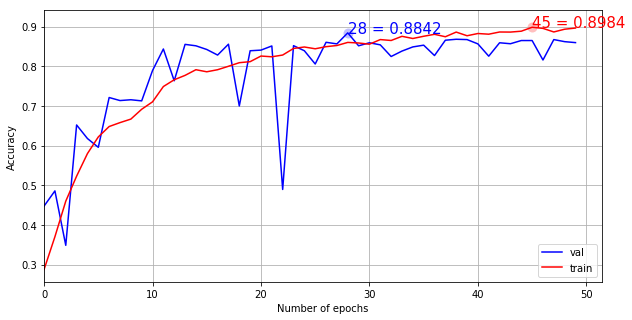

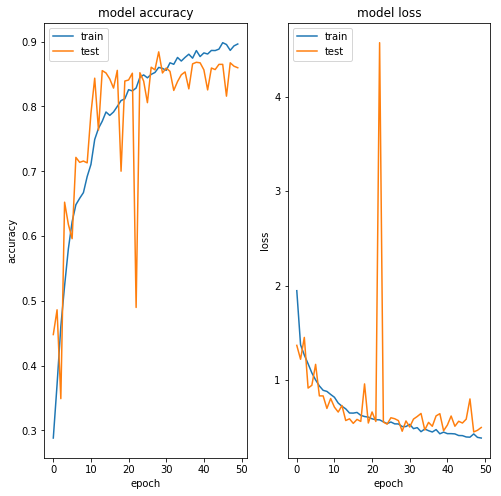

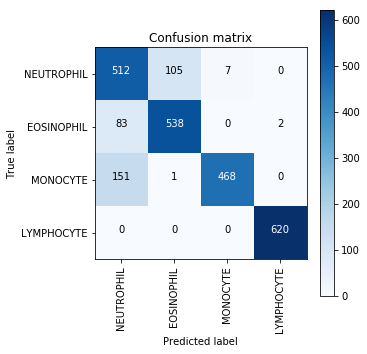

In [26]:
# use adadelta optimizer, lr=1.0, lr_decay=0.0

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adadelta', learning_rate=1.0, lr_decay=0.0)

Epoch 1/50
312/311 [==============================] - ETA: 5:46 - loss: 1.3763 - acc: 0.250 - ETA: 2:04 - loss: 5.9390 - acc: 0.239 - ETA: 1:19 - loss: 4.1230 - acc: 0.262 - ETA: 1:00 - loss: 3.3419 - acc: 0.250 - ETA: 49s - loss: 2.9041 - acc: 0.263 - ETA: 42s - loss: 2.6341 - acc: 0.25 - ETA: 37s - loss: 2.4403 - acc: 0.27 - ETA: 34s - loss: 2.3017 - acc: 0.26 - ETA: 31s - loss: 2.1945 - acc: 0.26 - ETA: 29s - loss: 2.1095 - acc: 0.27 - ETA: 27s - loss: 2.0453 - acc: 0.28 - ETA: 25s - loss: 1.9878 - acc: 0.28 - ETA: 24s - loss: 1.9399 - acc: 0.28 - ETA: 23s - loss: 1.8988 - acc: 0.27 - ETA: 22s - loss: 1.8632 - acc: 0.28 - ETA: 21s - loss: 1.8324 - acc: 0.28 - ETA: 21s - loss: 1.8053 - acc: 0.28 - ETA: 20s - loss: 1.7810 - acc: 0.28 - ETA: 19s - loss: 1.7600 - acc: 0.28 - ETA: 19s - loss: 1.7408 - acc: 0.28 - ETA: 18s - loss: 1.7237 - acc: 0.27 - ETA: 18s - loss: 1.7079 - acc: 0.28 - ETA: 17s - loss: 1.6937 - acc: 0.27 - ETA: 17s - loss: 1.6806 - acc: 0.27 - ETA: 17s - loss: 1.6685 -

312/311 [==============================] - ETA: 13s - loss: 0.9328 - acc: 0.59 - ETA: 13s - loss: 1.1204 - acc: 0.57 - ETA: 13s - loss: 1.1326 - acc: 0.55 - ETA: 13s - loss: 1.1034 - acc: 0.54 - ETA: 13s - loss: 1.0864 - acc: 0.54 - ETA: 12s - loss: 1.0791 - acc: 0.53 - ETA: 12s - loss: 1.0646 - acc: 0.53 - ETA: 12s - loss: 1.0757 - acc: 0.53 - ETA: 12s - loss: 1.0686 - acc: 0.53 - ETA: 12s - loss: 1.0654 - acc: 0.53 - ETA: 12s - loss: 1.0646 - acc: 0.53 - ETA: 12s - loss: 1.0670 - acc: 0.53 - ETA: 12s - loss: 1.0628 - acc: 0.53 - ETA: 12s - loss: 1.0584 - acc: 0.53 - ETA: 12s - loss: 1.0654 - acc: 0.52 - ETA: 12s - loss: 1.0655 - acc: 0.52 - ETA: 12s - loss: 1.0649 - acc: 0.52 - ETA: 11s - loss: 1.0588 - acc: 0.52 - ETA: 11s - loss: 1.0657 - acc: 0.52 - ETA: 11s - loss: 1.0705 - acc: 0.52 - ETA: 11s - loss: 1.0649 - acc: 0.52 - ETA: 11s - loss: 1.0588 - acc: 0.52 - ETA: 11s - loss: 1.0573 - acc: 0.53 - ETA: 11s - loss: 1.0602 - acc: 0.53 - ETA: 11s - loss: 1.0602 - acc: 0.53 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 1.1064 - acc: 0.40 - ETA: 13s - loss: 0.9256 - acc: 0.58 - ETA: 13s - loss: 0.8749 - acc: 0.61 - ETA: 13s - loss: 0.8579 - acc: 0.60 - ETA: 13s - loss: 0.8592 - acc: 0.60 - ETA: 13s - loss: 0.8593 - acc: 0.60 - ETA: 12s - loss: 0.8588 - acc: 0.58 - ETA: 12s - loss: 0.8540 - acc: 0.59 - ETA: 12s - loss: 0.8570 - acc: 0.59 - ETA: 12s - loss: 0.8516 - acc: 0.59 - ETA: 12s - loss: 0.8716 - acc: 0.58 - ETA: 12s - loss: 0.8707 - acc: 0.58 - ETA: 12s - loss: 0.8646 - acc: 0.58 - ETA: 12s - loss: 0.8758 - acc: 0.58 - ETA: 12s - loss: 0.8883 - acc: 0.58 - ETA: 12s - loss: 0.8802 - acc: 0.58 - ETA: 12s - loss: 0.8748 - acc: 0.58 - ETA: 12s - loss: 0.8780 - acc: 0.58 - ETA: 11s - loss: 0.8776 - acc: 0.58 - ETA: 11s - loss: 0.8756 - acc: 0.58 - ETA: 11s - loss: 0.8737 - acc: 0.58 - ETA: 11s - loss: 0.8802 - acc: 0.58 - ETA: 11s - loss: 0.8794 - acc: 0.58 - ETA: 11s - loss: 0.8783 - acc: 0.58 - ETA: 11s - loss: 0.8738 - acc: 0.58 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.8200 - acc: 0.65 - ETA: 13s - loss: 0.8426 - acc: 0.66 - ETA: 13s - loss: 0.7770 - acc: 0.64 - ETA: 13s - loss: 0.7708 - acc: 0.64 - ETA: 13s - loss: 0.7620 - acc: 0.64 - ETA: 12s - loss: 0.7565 - acc: 0.63 - ETA: 12s - loss: 0.7426 - acc: 0.64 - ETA: 12s - loss: 0.7377 - acc: 0.65 - ETA: 12s - loss: 0.7225 - acc: 0.66 - ETA: 12s - loss: 0.7225 - acc: 0.66 - ETA: 12s - loss: 0.7313 - acc: 0.66 - ETA: 12s - loss: 0.7310 - acc: 0.66 - ETA: 12s - loss: 0.7343 - acc: 0.66 - ETA: 12s - loss: 0.7307 - acc: 0.66 - ETA: 12s - loss: 0.7338 - acc: 0.66 - ETA: 11s - loss: 0.7315 - acc: 0.66 - ETA: 11s - loss: 0.7299 - acc: 0.66 - ETA: 11s - loss: 0.7239 - acc: 0.66 - ETA: 11s - loss: 0.7271 - acc: 0.67 - ETA: 11s - loss: 0.7235 - acc: 0.67 - ETA: 11s - loss: 0.7325 - acc: 0.67 - ETA: 11s - loss: 0.7338 - acc: 0.67 - ETA: 11s - loss: 0.7325 - acc: 0.67 - ETA: 11s - loss: 0.7357 - acc: 0.67 - ETA: 11s - loss: 0.7422 - acc: 0.67 - ETA: 11

312/311 [==============================] - ETA: 10s - loss: 0.6568 - acc: 0.75 - ETA: 13s - loss: 0.5787 - acc: 0.79 - ETA: 12s - loss: 0.6157 - acc: 0.78 - ETA: 13s - loss: 0.5952 - acc: 0.77 - ETA: 13s - loss: 0.6053 - acc: 0.76 - ETA: 13s - loss: 0.5933 - acc: 0.76 - ETA: 13s - loss: 0.5977 - acc: 0.76 - ETA: 13s - loss: 0.5896 - acc: 0.76 - ETA: 13s - loss: 0.5986 - acc: 0.75 - ETA: 13s - loss: 0.6101 - acc: 0.75 - ETA: 13s - loss: 0.6187 - acc: 0.74 - ETA: 13s - loss: 0.6190 - acc: 0.74 - ETA: 13s - loss: 0.6193 - acc: 0.74 - ETA: 13s - loss: 0.6141 - acc: 0.74 - ETA: 13s - loss: 0.6145 - acc: 0.74 - ETA: 13s - loss: 0.6157 - acc: 0.74 - ETA: 13s - loss: 0.6118 - acc: 0.75 - ETA: 13s - loss: 0.6155 - acc: 0.74 - ETA: 13s - loss: 0.6153 - acc: 0.74 - ETA: 13s - loss: 0.6131 - acc: 0.74 - ETA: 13s - loss: 0.6087 - acc: 0.74 - ETA: 12s - loss: 0.6103 - acc: 0.74 - ETA: 12s - loss: 0.6146 - acc: 0.74 - ETA: 12s - loss: 0.6127 - acc: 0.74 - ETA: 12s - loss: 0.6112 - acc: 0.74 - ETA: 12

312/311 [==============================] - ETA: 15s - loss: 0.5395 - acc: 0.81 - ETA: 14s - loss: 0.6527 - acc: 0.71 - ETA: 14s - loss: 0.6013 - acc: 0.75 - ETA: 15s - loss: 0.5777 - acc: 0.76 - ETA: 15s - loss: 0.5887 - acc: 0.76 - ETA: 15s - loss: 0.5779 - acc: 0.77 - ETA: 14s - loss: 0.5796 - acc: 0.76 - ETA: 14s - loss: 0.5942 - acc: 0.75 - ETA: 14s - loss: 0.5956 - acc: 0.74 - ETA: 14s - loss: 0.6056 - acc: 0.74 - ETA: 14s - loss: 0.5939 - acc: 0.75 - ETA: 14s - loss: 0.5873 - acc: 0.75 - ETA: 13s - loss: 0.5862 - acc: 0.75 - ETA: 13s - loss: 0.5929 - acc: 0.75 - ETA: 13s - loss: 0.5878 - acc: 0.75 - ETA: 13s - loss: 0.5812 - acc: 0.76 - ETA: 13s - loss: 0.5796 - acc: 0.76 - ETA: 13s - loss: 0.5852 - acc: 0.75 - ETA: 13s - loss: 0.5850 - acc: 0.75 - ETA: 13s - loss: 0.5795 - acc: 0.76 - ETA: 13s - loss: 0.5843 - acc: 0.75 - ETA: 13s - loss: 0.5860 - acc: 0.75 - ETA: 13s - loss: 0.5884 - acc: 0.75 - ETA: 13s - loss: 0.6003 - acc: 0.75 - ETA: 13s - loss: 0.5971 - acc: 0.75 - ETA: 13

312/311 [==============================] - ETA: 10s - loss: 0.7140 - acc: 0.56 - ETA: 13s - loss: 0.5708 - acc: 0.68 - ETA: 14s - loss: 0.5388 - acc: 0.72 - ETA: 14s - loss: 0.5438 - acc: 0.72 - ETA: 14s - loss: 0.5410 - acc: 0.75 - ETA: 14s - loss: 0.5636 - acc: 0.74 - ETA: 14s - loss: 0.5722 - acc: 0.74 - ETA: 14s - loss: 0.5861 - acc: 0.73 - ETA: 13s - loss: 0.5958 - acc: 0.73 - ETA: 13s - loss: 0.5941 - acc: 0.73 - ETA: 13s - loss: 0.5820 - acc: 0.74 - ETA: 13s - loss: 0.5694 - acc: 0.74 - ETA: 13s - loss: 0.5714 - acc: 0.74 - ETA: 13s - loss: 0.5763 - acc: 0.73 - ETA: 13s - loss: 0.5753 - acc: 0.73 - ETA: 13s - loss: 0.5713 - acc: 0.74 - ETA: 13s - loss: 0.5683 - acc: 0.73 - ETA: 13s - loss: 0.5697 - acc: 0.74 - ETA: 13s - loss: 0.5696 - acc: 0.74 - ETA: 13s - loss: 0.5648 - acc: 0.74 - ETA: 13s - loss: 0.5699 - acc: 0.74 - ETA: 13s - loss: 0.5719 - acc: 0.74 - ETA: 13s - loss: 0.5782 - acc: 0.74 - ETA: 12s - loss: 0.5731 - acc: 0.74 - ETA: 12s - loss: 0.5707 - acc: 0.74 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.4838 - acc: 0.84 - ETA: 13s - loss: 0.4410 - acc: 0.86 - ETA: 13s - loss: 0.5094 - acc: 0.82 - ETA: 13s - loss: 0.4903 - acc: 0.83 - ETA: 13s - loss: 0.4989 - acc: 0.80 - ETA: 13s - loss: 0.5143 - acc: 0.80 - ETA: 13s - loss: 0.5038 - acc: 0.80 - ETA: 13s - loss: 0.5015 - acc: 0.80 - ETA: 13s - loss: 0.4961 - acc: 0.80 - ETA: 13s - loss: 0.5142 - acc: 0.79 - ETA: 13s - loss: 0.5126 - acc: 0.79 - ETA: 13s - loss: 0.5086 - acc: 0.79 - ETA: 13s - loss: 0.5148 - acc: 0.78 - ETA: 13s - loss: 0.5282 - acc: 0.77 - ETA: 13s - loss: 0.5220 - acc: 0.77 - ETA: 13s - loss: 0.5160 - acc: 0.78 - ETA: 12s - loss: 0.5124 - acc: 0.78 - ETA: 12s - loss: 0.5086 - acc: 0.78 - ETA: 12s - loss: 0.5134 - acc: 0.78 - ETA: 12s - loss: 0.5100 - acc: 0.78 - ETA: 12s - loss: 0.5135 - acc: 0.78 - ETA: 12s - loss: 0.5165 - acc: 0.77 - ETA: 12s - loss: 0.5098 - acc: 0.78 - ETA: 12s - loss: 0.5015 - acc: 0.78 - ETA: 11s - loss: 0.5044 - acc: 0.78 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.3233 - acc: 0.84 - ETA: 12s - loss: 0.4537 - acc: 0.78 - ETA: 13s - loss: 0.4990 - acc: 0.75 - ETA: 13s - loss: 0.4864 - acc: 0.75 - ETA: 13s - loss: 0.5307 - acc: 0.72 - ETA: 13s - loss: 0.5128 - acc: 0.73 - ETA: 12s - loss: 0.5022 - acc: 0.75 - ETA: 13s - loss: 0.4902 - acc: 0.76 - ETA: 12s - loss: 0.4729 - acc: 0.78 - ETA: 13s - loss: 0.4764 - acc: 0.78 - ETA: 12s - loss: 0.4766 - acc: 0.78 - ETA: 12s - loss: 0.4822 - acc: 0.78 - ETA: 13s - loss: 0.4781 - acc: 0.79 - ETA: 12s - loss: 0.4855 - acc: 0.78 - ETA: 12s - loss: 0.4847 - acc: 0.78 - ETA: 12s - loss: 0.4984 - acc: 0.78 - ETA: 12s - loss: 0.4987 - acc: 0.78 - ETA: 12s - loss: 0.4970 - acc: 0.78 - ETA: 12s - loss: 0.4898 - acc: 0.78 - ETA: 12s - loss: 0.4896 - acc: 0.79 - ETA: 12s - loss: 0.4917 - acc: 0.79 - ETA: 12s - loss: 0.4919 - acc: 0.79 - ETA: 12s - loss: 0.4918 - acc: 0.79 - ETA: 12s - loss: 0.4855 - acc: 0.79 - ETA: 12s - loss: 0.4862 - acc: 0.79 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.4952 - acc: 0.78 - ETA: 12s - loss: 0.5373 - acc: 0.81 - ETA: 12s - loss: 0.5074 - acc: 0.80 - ETA: 12s - loss: 0.5116 - acc: 0.79 - ETA: 13s - loss: 0.5031 - acc: 0.80 - ETA: 12s - loss: 0.5123 - acc: 0.81 - ETA: 13s - loss: 0.5160 - acc: 0.81 - ETA: 12s - loss: 0.5115 - acc: 0.81 - ETA: 12s - loss: 0.5008 - acc: 0.80 - ETA: 12s - loss: 0.4906 - acc: 0.80 - ETA: 12s - loss: 0.4826 - acc: 0.80 - ETA: 12s - loss: 0.4814 - acc: 0.80 - ETA: 12s - loss: 0.4844 - acc: 0.80 - ETA: 12s - loss: 0.4837 - acc: 0.79 - ETA: 12s - loss: 0.4791 - acc: 0.80 - ETA: 12s - loss: 0.4817 - acc: 0.80 - ETA: 12s - loss: 0.4766 - acc: 0.80 - ETA: 12s - loss: 0.4825 - acc: 0.80 - ETA: 12s - loss: 0.4805 - acc: 0.80 - ETA: 12s - loss: 0.4812 - acc: 0.80 - ETA: 12s - loss: 0.4771 - acc: 0.80 - ETA: 12s - loss: 0.4757 - acc: 0.80 - ETA: 12s - loss: 0.4850 - acc: 0.80 - ETA: 12s - loss: 0.4810 - acc: 0.80 - ETA: 11s - loss: 0.4830 - acc: 0.80 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.4370 - acc: 0.81 - ETA: 13s - loss: 0.4447 - acc: 0.79 - ETA: 13s - loss: 0.4634 - acc: 0.81 - ETA: 12s - loss: 0.4608 - acc: 0.81 - ETA: 13s - loss: 0.4450 - acc: 0.82 - ETA: 12s - loss: 0.4844 - acc: 0.80 - ETA: 12s - loss: 0.4738 - acc: 0.80 - ETA: 12s - loss: 0.4996 - acc: 0.79 - ETA: 12s - loss: 0.5077 - acc: 0.79 - ETA: 12s - loss: 0.5040 - acc: 0.79 - ETA: 12s - loss: 0.5087 - acc: 0.78 - ETA: 12s - loss: 0.4992 - acc: 0.78 - ETA: 12s - loss: 0.4948 - acc: 0.78 - ETA: 12s - loss: 0.4843 - acc: 0.79 - ETA: 12s - loss: 0.4865 - acc: 0.78 - ETA: 12s - loss: 0.4763 - acc: 0.79 - ETA: 12s - loss: 0.4769 - acc: 0.79 - ETA: 12s - loss: 0.4701 - acc: 0.80 - ETA: 12s - loss: 0.4688 - acc: 0.80 - ETA: 11s - loss: 0.4715 - acc: 0.80 - ETA: 12s - loss: 0.4684 - acc: 0.80 - ETA: 11s - loss: 0.4637 - acc: 0.80 - ETA: 11s - loss: 0.4673 - acc: 0.80 - ETA: 11s - loss: 0.4640 - acc: 0.80 - ETA: 11s - loss: 0.4651 - acc: 0.80 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.3252 - acc: 0.87 - ETA: 13s - loss: 0.3679 - acc: 0.83 - ETA: 13s - loss: 0.4023 - acc: 0.83 - ETA: 13s - loss: 0.3924 - acc: 0.84 - ETA: 13s - loss: 0.4075 - acc: 0.84 - ETA: 13s - loss: 0.4084 - acc: 0.84 - ETA: 12s - loss: 0.4048 - acc: 0.85 - ETA: 13s - loss: 0.3916 - acc: 0.85 - ETA: 13s - loss: 0.3868 - acc: 0.85 - ETA: 12s - loss: 0.3926 - acc: 0.85 - ETA: 12s - loss: 0.3988 - acc: 0.85 - ETA: 12s - loss: 0.3909 - acc: 0.85 - ETA: 12s - loss: 0.3947 - acc: 0.84 - ETA: 12s - loss: 0.3845 - acc: 0.85 - ETA: 12s - loss: 0.3842 - acc: 0.85 - ETA: 12s - loss: 0.3883 - acc: 0.85 - ETA: 12s - loss: 0.3899 - acc: 0.85 - ETA: 12s - loss: 0.3918 - acc: 0.85 - ETA: 12s - loss: 0.3886 - acc: 0.85 - ETA: 12s - loss: 0.3896 - acc: 0.85 - ETA: 12s - loss: 0.3909 - acc: 0.85 - ETA: 11s - loss: 0.3943 - acc: 0.85 - ETA: 12s - loss: 0.3937 - acc: 0.85 - ETA: 11s - loss: 0.3957 - acc: 0.85 - ETA: 11s - loss: 0.3938 - acc: 0.85 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.3578 - acc: 0.87 - ETA: 13s - loss: 0.3415 - acc: 0.87 - ETA: 13s - loss: 0.3637 - acc: 0.85 - ETA: 13s - loss: 0.3570 - acc: 0.85 - ETA: 13s - loss: 0.3651 - acc: 0.86 - ETA: 12s - loss: 0.3948 - acc: 0.84 - ETA: 13s - loss: 0.4262 - acc: 0.82 - ETA: 12s - loss: 0.4230 - acc: 0.82 - ETA: 12s - loss: 0.4205 - acc: 0.82 - ETA: 12s - loss: 0.4388 - acc: 0.81 - ETA: 12s - loss: 0.4401 - acc: 0.81 - ETA: 12s - loss: 0.4479 - acc: 0.81 - ETA: 12s - loss: 0.4522 - acc: 0.81 - ETA: 12s - loss: 0.4509 - acc: 0.81 - ETA: 12s - loss: 0.4513 - acc: 0.81 - ETA: 12s - loss: 0.4465 - acc: 0.81 - ETA: 12s - loss: 0.4481 - acc: 0.81 - ETA: 12s - loss: 0.4463 - acc: 0.82 - ETA: 12s - loss: 0.4458 - acc: 0.81 - ETA: 12s - loss: 0.4431 - acc: 0.81 - ETA: 12s - loss: 0.4426 - acc: 0.81 - ETA: 12s - loss: 0.4429 - acc: 0.81 - ETA: 12s - loss: 0.4406 - acc: 0.81 - ETA: 11s - loss: 0.4391 - acc: 0.81 - ETA: 11s - loss: 0.4375 - acc: 0.81 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.4888 - acc: 0.78 - ETA: 12s - loss: 0.5030 - acc: 0.77 - ETA: 12s - loss: 0.4366 - acc: 0.80 - ETA: 13s - loss: 0.4215 - acc: 0.81 - ETA: 12s - loss: 0.3971 - acc: 0.82 - ETA: 13s - loss: 0.3913 - acc: 0.83 - ETA: 12s - loss: 0.3894 - acc: 0.84 - ETA: 12s - loss: 0.3888 - acc: 0.84 - ETA: 12s - loss: 0.3877 - acc: 0.84 - ETA: 12s - loss: 0.3882 - acc: 0.84 - ETA: 12s - loss: 0.3917 - acc: 0.84 - ETA: 12s - loss: 0.3859 - acc: 0.84 - ETA: 12s - loss: 0.3826 - acc: 0.84 - ETA: 12s - loss: 0.3869 - acc: 0.84 - ETA: 12s - loss: 0.3888 - acc: 0.83 - ETA: 12s - loss: 0.3979 - acc: 0.83 - ETA: 12s - loss: 0.3998 - acc: 0.83 - ETA: 12s - loss: 0.3985 - acc: 0.82 - ETA: 12s - loss: 0.3984 - acc: 0.83 - ETA: 12s - loss: 0.3961 - acc: 0.83 - ETA: 12s - loss: 0.4007 - acc: 0.83 - ETA: 11s - loss: 0.3956 - acc: 0.83 - ETA: 11s - loss: 0.3911 - acc: 0.83 - ETA: 11s - loss: 0.3954 - acc: 0.83 - ETA: 11s - loss: 0.3938 - acc: 0.83 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.3705 - acc: 0.84 - ETA: 11s - loss: 0.4306 - acc: 0.81 - ETA: 13s - loss: 0.4284 - acc: 0.82 - ETA: 12s - loss: 0.4085 - acc: 0.85 - ETA: 13s - loss: 0.4049 - acc: 0.85 - ETA: 12s - loss: 0.4043 - acc: 0.84 - ETA: 13s - loss: 0.4002 - acc: 0.85 - ETA: 12s - loss: 0.4070 - acc: 0.84 - ETA: 13s - loss: 0.4009 - acc: 0.85 - ETA: 12s - loss: 0.3963 - acc: 0.85 - ETA: 12s - loss: 0.3835 - acc: 0.86 - ETA: 12s - loss: 0.3847 - acc: 0.85 - ETA: 12s - loss: 0.3865 - acc: 0.85 - ETA: 12s - loss: 0.3903 - acc: 0.84 - ETA: 12s - loss: 0.3884 - acc: 0.84 - ETA: 12s - loss: 0.3974 - acc: 0.84 - ETA: 12s - loss: 0.3996 - acc: 0.84 - ETA: 12s - loss: 0.3982 - acc: 0.84 - ETA: 12s - loss: 0.4011 - acc: 0.83 - ETA: 12s - loss: 0.3954 - acc: 0.84 - ETA: 12s - loss: 0.3957 - acc: 0.84 - ETA: 12s - loss: 0.3991 - acc: 0.84 - ETA: 12s - loss: 0.4039 - acc: 0.84 - ETA: 11s - loss: 0.4073 - acc: 0.84 - ETA: 11s - loss: 0.4057 - acc: 0.84 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.3343 - acc: 0.93 - ETA: 13s - loss: 0.3664 - acc: 0.85 - ETA: 13s - loss: 0.4142 - acc: 0.83 - ETA: 13s - loss: 0.3975 - acc: 0.83 - ETA: 13s - loss: 0.3811 - acc: 0.84 - ETA: 12s - loss: 0.3795 - acc: 0.84 - ETA: 12s - loss: 0.3651 - acc: 0.84 - ETA: 12s - loss: 0.3698 - acc: 0.84 - ETA: 12s - loss: 0.3732 - acc: 0.84 - ETA: 12s - loss: 0.3692 - acc: 0.85 - ETA: 12s - loss: 0.3722 - acc: 0.84 - ETA: 12s - loss: 0.3714 - acc: 0.84 - ETA: 12s - loss: 0.3713 - acc: 0.84 - ETA: 12s - loss: 0.3690 - acc: 0.85 - ETA: 12s - loss: 0.3659 - acc: 0.85 - ETA: 12s - loss: 0.3793 - acc: 0.84 - ETA: 12s - loss: 0.3800 - acc: 0.84 - ETA: 11s - loss: 0.3783 - acc: 0.84 - ETA: 11s - loss: 0.3760 - acc: 0.84 - ETA: 11s - loss: 0.3735 - acc: 0.85 - ETA: 11s - loss: 0.3781 - acc: 0.84 - ETA: 11s - loss: 0.3774 - acc: 0.84 - ETA: 11s - loss: 0.3703 - acc: 0.85 - ETA: 11s - loss: 0.3773 - acc: 0.85 - ETA: 11s - loss: 0.3822 - acc: 0.84 - ETA: 11

312/311 [==============================] - ETA: 16s - loss: 0.6192 - acc: 0.75 - ETA: 14s - loss: 0.4833 - acc: 0.76 - ETA: 14s - loss: 0.4425 - acc: 0.76 - ETA: 13s - loss: 0.4082 - acc: 0.78 - ETA: 13s - loss: 0.4084 - acc: 0.78 - ETA: 13s - loss: 0.4036 - acc: 0.79 - ETA: 13s - loss: 0.3778 - acc: 0.81 - ETA: 13s - loss: 0.3724 - acc: 0.81 - ETA: 13s - loss: 0.3899 - acc: 0.80 - ETA: 13s - loss: 0.3952 - acc: 0.80 - ETA: 13s - loss: 0.3968 - acc: 0.80 - ETA: 13s - loss: 0.4006 - acc: 0.80 - ETA: 13s - loss: 0.4058 - acc: 0.80 - ETA: 12s - loss: 0.4034 - acc: 0.80 - ETA: 12s - loss: 0.4010 - acc: 0.81 - ETA: 12s - loss: 0.4017 - acc: 0.81 - ETA: 12s - loss: 0.3976 - acc: 0.81 - ETA: 12s - loss: 0.3983 - acc: 0.82 - ETA: 12s - loss: 0.3952 - acc: 0.82 - ETA: 12s - loss: 0.4004 - acc: 0.82 - ETA: 12s - loss: 0.4010 - acc: 0.82 - ETA: 12s - loss: 0.3928 - acc: 0.83 - ETA: 12s - loss: 0.3926 - acc: 0.83 - ETA: 12s - loss: 0.3908 - acc: 0.83 - ETA: 12s - loss: 0.3920 - acc: 0.83 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.5701 - acc: 0.71 - ETA: 13s - loss: 0.4667 - acc: 0.81 - ETA: 13s - loss: 0.3879 - acc: 0.83 - ETA: 13s - loss: 0.3752 - acc: 0.83 - ETA: 13s - loss: 0.3879 - acc: 0.83 - ETA: 13s - loss: 0.3780 - acc: 0.85 - ETA: 13s - loss: 0.3651 - acc: 0.85 - ETA: 13s - loss: 0.3566 - acc: 0.85 - ETA: 13s - loss: 0.3559 - acc: 0.85 - ETA: 13s - loss: 0.3483 - acc: 0.86 - ETA: 13s - loss: 0.3395 - acc: 0.86 - ETA: 13s - loss: 0.3448 - acc: 0.87 - ETA: 13s - loss: 0.3452 - acc: 0.86 - ETA: 13s - loss: 0.3488 - acc: 0.87 - ETA: 13s - loss: 0.3495 - acc: 0.86 - ETA: 13s - loss: 0.3506 - acc: 0.86 - ETA: 13s - loss: 0.3525 - acc: 0.85 - ETA: 13s - loss: 0.3475 - acc: 0.86 - ETA: 13s - loss: 0.3515 - acc: 0.86 - ETA: 13s - loss: 0.3518 - acc: 0.86 - ETA: 13s - loss: 0.3515 - acc: 0.85 - ETA: 13s - loss: 0.3554 - acc: 0.85 - ETA: 13s - loss: 0.3541 - acc: 0.85 - ETA: 13s - loss: 0.3523 - acc: 0.85 - ETA: 13s - loss: 0.3552 - acc: 0.85 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.3968 - acc: 0.90 - ETA: 16s - loss: 0.4090 - acc: 0.87 - ETA: 15s - loss: 0.3693 - acc: 0.86 - ETA: 15s - loss: 0.3867 - acc: 0.84 - ETA: 14s - loss: 0.3906 - acc: 0.84 - ETA: 14s - loss: 0.3855 - acc: 0.85 - ETA: 14s - loss: 0.3916 - acc: 0.84 - ETA: 13s - loss: 0.3932 - acc: 0.84 - ETA: 13s - loss: 0.3895 - acc: 0.84 - ETA: 13s - loss: 0.3799 - acc: 0.84 - ETA: 13s - loss: 0.3562 - acc: 0.86 - ETA: 13s - loss: 0.3578 - acc: 0.86 - ETA: 13s - loss: 0.3541 - acc: 0.86 - ETA: 13s - loss: 0.3543 - acc: 0.86 - ETA: 13s - loss: 0.3582 - acc: 0.86 - ETA: 13s - loss: 0.3568 - acc: 0.86 - ETA: 13s - loss: 0.3627 - acc: 0.85 - ETA: 13s - loss: 0.3671 - acc: 0.85 - ETA: 12s - loss: 0.3650 - acc: 0.85 - ETA: 12s - loss: 0.3635 - acc: 0.85 - ETA: 12s - loss: 0.3596 - acc: 0.85 - ETA: 12s - loss: 0.3644 - acc: 0.85 - ETA: 12s - loss: 0.3617 - acc: 0.85 - ETA: 12s - loss: 0.3680 - acc: 0.85 - ETA: 12s - loss: 0.3706 - acc: 0.85 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.3822 - acc: 0.84 - ETA: 16s - loss: 0.3597 - acc: 0.87 - ETA: 15s - loss: 0.4084 - acc: 0.83 - ETA: 14s - loss: 0.3856 - acc: 0.83 - ETA: 14s - loss: 0.3847 - acc: 0.84 - ETA: 14s - loss: 0.3633 - acc: 0.85 - ETA: 14s - loss: 0.3604 - acc: 0.85 - ETA: 14s - loss: 0.3551 - acc: 0.85 - ETA: 14s - loss: 0.3505 - acc: 0.85 - ETA: 14s - loss: 0.3553 - acc: 0.85 - ETA: 14s - loss: 0.3404 - acc: 0.85 - ETA: 14s - loss: 0.3439 - acc: 0.85 - ETA: 13s - loss: 0.3498 - acc: 0.84 - ETA: 13s - loss: 0.3416 - acc: 0.85 - ETA: 13s - loss: 0.3440 - acc: 0.85 - ETA: 13s - loss: 0.3442 - acc: 0.85 - ETA: 13s - loss: 0.3459 - acc: 0.85 - ETA: 13s - loss: 0.3451 - acc: 0.85 - ETA: 13s - loss: 0.3435 - acc: 0.85 - ETA: 13s - loss: 0.3412 - acc: 0.85 - ETA: 13s - loss: 0.3395 - acc: 0.85 - ETA: 13s - loss: 0.3394 - acc: 0.85 - ETA: 13s - loss: 0.3340 - acc: 0.86 - ETA: 12s - loss: 0.3345 - acc: 0.86 - ETA: 12s - loss: 0.3358 - acc: 0.86 - ETA: 12

312/311 [==============================] - ETA: 11s - loss: 0.3712 - acc: 0.84 - ETA: 15s - loss: 0.3996 - acc: 0.84 - ETA: 16s - loss: 0.4079 - acc: 0.83 - ETA: 17s - loss: 0.3805 - acc: 0.85 - ETA: 17s - loss: 0.3628 - acc: 0.84 - ETA: 16s - loss: 0.3584 - acc: 0.85 - ETA: 15s - loss: 0.3699 - acc: 0.84 - ETA: 15s - loss: 0.3781 - acc: 0.84 - ETA: 15s - loss: 0.3826 - acc: 0.84 - ETA: 15s - loss: 0.3736 - acc: 0.85 - ETA: 15s - loss: 0.3686 - acc: 0.85 - ETA: 15s - loss: 0.3665 - acc: 0.85 - ETA: 15s - loss: 0.3666 - acc: 0.85 - ETA: 14s - loss: 0.3632 - acc: 0.85 - ETA: 14s - loss: 0.3644 - acc: 0.85 - ETA: 15s - loss: 0.3691 - acc: 0.85 - ETA: 14s - loss: 0.3656 - acc: 0.85 - ETA: 14s - loss: 0.3678 - acc: 0.85 - ETA: 14s - loss: 0.3642 - acc: 0.85 - ETA: 14s - loss: 0.3620 - acc: 0.85 - ETA: 14s - loss: 0.3621 - acc: 0.85 - ETA: 14s - loss: 0.3571 - acc: 0.85 - ETA: 13s - loss: 0.3474 - acc: 0.86 - ETA: 13s - loss: 0.3501 - acc: 0.86 - ETA: 13s - loss: 0.3518 - acc: 0.86 - ETA: 13

312/311 [==============================] - ETA: 8s - loss: 0.2314 - acc: 0.968 - ETA: 13s - loss: 0.2212 - acc: 0.95 - ETA: 14s - loss: 0.2661 - acc: 0.91 - ETA: 14s - loss: 0.2605 - acc: 0.90 - ETA: 14s - loss: 0.2855 - acc: 0.87 - ETA: 14s - loss: 0.3187 - acc: 0.86 - ETA: 14s - loss: 0.3169 - acc: 0.86 - ETA: 14s - loss: 0.3145 - acc: 0.86 - ETA: 14s - loss: 0.3035 - acc: 0.87 - ETA: 14s - loss: 0.3041 - acc: 0.87 - ETA: 14s - loss: 0.3110 - acc: 0.86 - ETA: 14s - loss: 0.3160 - acc: 0.86 - ETA: 14s - loss: 0.3226 - acc: 0.85 - ETA: 14s - loss: 0.3172 - acc: 0.86 - ETA: 14s - loss: 0.3111 - acc: 0.87 - ETA: 14s - loss: 0.3137 - acc: 0.87 - ETA: 13s - loss: 0.3106 - acc: 0.87 - ETA: 13s - loss: 0.3119 - acc: 0.87 - ETA: 13s - loss: 0.3158 - acc: 0.86 - ETA: 13s - loss: 0.3127 - acc: 0.87 - ETA: 13s - loss: 0.3118 - acc: 0.87 - ETA: 13s - loss: 0.3106 - acc: 0.87 - ETA: 13s - loss: 0.3069 - acc: 0.87 - ETA: 13s - loss: 0.3118 - acc: 0.87 - ETA: 13s - loss: 0.3119 - acc: 0.87 - ETA: 13

312/311 [==============================] - ETA: 14s - loss: 0.3860 - acc: 0.84 - ETA: 14s - loss: 0.3203 - acc: 0.89 - ETA: 14s - loss: 0.3364 - acc: 0.87 - ETA: 14s - loss: 0.3200 - acc: 0.88 - ETA: 14s - loss: 0.3088 - acc: 0.88 - ETA: 14s - loss: 0.3142 - acc: 0.88 - ETA: 14s - loss: 0.3126 - acc: 0.88 - ETA: 14s - loss: 0.3198 - acc: 0.87 - ETA: 14s - loss: 0.3243 - acc: 0.87 - ETA: 13s - loss: 0.3257 - acc: 0.87 - ETA: 13s - loss: 0.3200 - acc: 0.87 - ETA: 13s - loss: 0.3218 - acc: 0.88 - ETA: 13s - loss: 0.3259 - acc: 0.88 - ETA: 13s - loss: 0.3258 - acc: 0.87 - ETA: 13s - loss: 0.3260 - acc: 0.87 - ETA: 13s - loss: 0.3197 - acc: 0.88 - ETA: 13s - loss: 0.3225 - acc: 0.87 - ETA: 13s - loss: 0.3210 - acc: 0.87 - ETA: 12s - loss: 0.3212 - acc: 0.87 - ETA: 12s - loss: 0.3193 - acc: 0.87 - ETA: 12s - loss: 0.3167 - acc: 0.87 - ETA: 12s - loss: 0.3183 - acc: 0.87 - ETA: 12s - loss: 0.3169 - acc: 0.87 - ETA: 12s - loss: 0.3180 - acc: 0.87 - ETA: 12s - loss: 0.3157 - acc: 0.87 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.4350 - acc: 0.84 - ETA: 13s - loss: 0.3398 - acc: 0.88 - ETA: 13s - loss: 0.3191 - acc: 0.88 - ETA: 13s - loss: 0.3193 - acc: 0.87 - ETA: 13s - loss: 0.3187 - acc: 0.87 - ETA: 13s - loss: 0.3144 - acc: 0.87 - ETA: 12s - loss: 0.3139 - acc: 0.86 - ETA: 12s - loss: 0.3214 - acc: 0.86 - ETA: 13s - loss: 0.3193 - acc: 0.86 - ETA: 13s - loss: 0.3337 - acc: 0.85 - ETA: 12s - loss: 0.3362 - acc: 0.85 - ETA: 12s - loss: 0.3443 - acc: 0.84 - ETA: 12s - loss: 0.3428 - acc: 0.84 - ETA: 12s - loss: 0.3439 - acc: 0.84 - ETA: 12s - loss: 0.3411 - acc: 0.84 - ETA: 12s - loss: 0.3459 - acc: 0.84 - ETA: 12s - loss: 0.3428 - acc: 0.84 - ETA: 12s - loss: 0.3440 - acc: 0.84 - ETA: 12s - loss: 0.3399 - acc: 0.84 - ETA: 12s - loss: 0.3365 - acc: 0.85 - ETA: 12s - loss: 0.3303 - acc: 0.85 - ETA: 11s - loss: 0.3307 - acc: 0.85 - ETA: 11s - loss: 0.3278 - acc: 0.85 - ETA: 11s - loss: 0.3269 - acc: 0.85 - ETA: 11s - loss: 0.3266 - acc: 0.85 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2815 - acc: 0.93 - ETA: 12s - loss: 0.2914 - acc: 0.90 - ETA: 13s - loss: 0.2959 - acc: 0.89 - ETA: 12s - loss: 0.2926 - acc: 0.89 - ETA: 13s - loss: 0.2830 - acc: 0.89 - ETA: 13s - loss: 0.2858 - acc: 0.89 - ETA: 13s - loss: 0.3088 - acc: 0.88 - ETA: 12s - loss: 0.3088 - acc: 0.88 - ETA: 13s - loss: 0.3048 - acc: 0.87 - ETA: 12s - loss: 0.3106 - acc: 0.88 - ETA: 13s - loss: 0.3131 - acc: 0.87 - ETA: 13s - loss: 0.3105 - acc: 0.87 - ETA: 12s - loss: 0.3066 - acc: 0.88 - ETA: 13s - loss: 0.3078 - acc: 0.88 - ETA: 12s - loss: 0.3147 - acc: 0.87 - ETA: 12s - loss: 0.3150 - acc: 0.88 - ETA: 12s - loss: 0.3136 - acc: 0.88 - ETA: 12s - loss: 0.3139 - acc: 0.88 - ETA: 12s - loss: 0.3160 - acc: 0.87 - ETA: 12s - loss: 0.3130 - acc: 0.88 - ETA: 12s - loss: 0.3133 - acc: 0.88 - ETA: 12s - loss: 0.3162 - acc: 0.88 - ETA: 12s - loss: 0.3196 - acc: 0.87 - ETA: 12s - loss: 0.3214 - acc: 0.87 - ETA: 12s - loss: 0.3174 - acc: 0.87 - ETA: 12

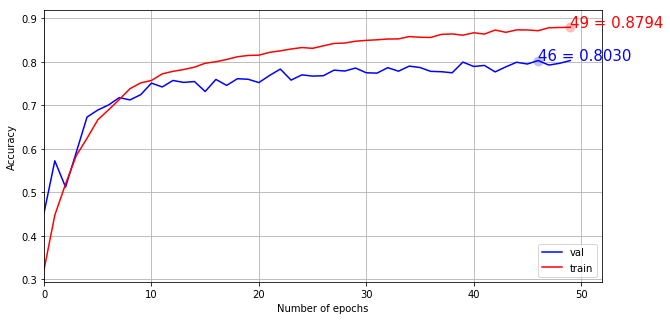

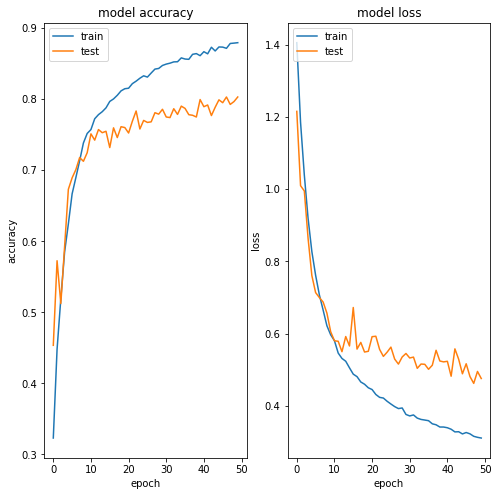

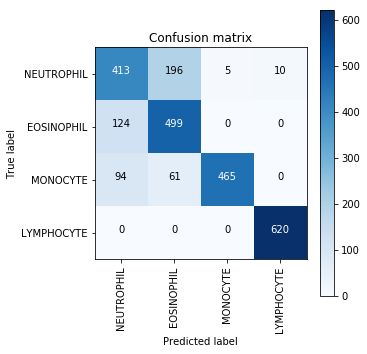

In [53]:
# use adadelta optimizer, lr=1.0, lr_decay=0.005

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adadelta', learning_rate=1.0, lr_decay=0.005)

Epoch 1/50
312/311 [==============================] - ETA: 5:48 - loss: 1.3668 - acc: 0.281 - ETA: 3:02 - loss: 6.7436 - acc: 0.218 - ETA: 1:36 - loss: 6.1941 - acc: 0.226 - ETA: 1:20 - loss: 5.2417 - acc: 0.237 - ETA: 1:00 - loss: 4.1488 - acc: 0.236 - ETA: 49s - loss: 3.5348 - acc: 0.239 - ETA: 45s - loss: 3.3200 - acc: 0.25 - ETA: 40s - loss: 2.9977 - acc: 0.26 - ETA: 35s - loss: 2.7684 - acc: 0.26 - ETA: 34s - loss: 2.6762 - acc: 0.26 - ETA: 31s - loss: 2.5241 - acc: 0.25 - ETA: 29s - loss: 2.4060 - acc: 0.26 - ETA: 28s - loss: 2.3551 - acc: 0.25 - ETA: 26s - loss: 2.2671 - acc: 0.25 - ETA: 25s - loss: 2.1936 - acc: 0.24 - ETA: 24s - loss: 2.1316 - acc: 0.24 - ETA: 23s - loss: 2.1039 - acc: 0.25 - ETA: 22s - loss: 2.0545 - acc: 0.24 - ETA: 22s - loss: 2.0323 - acc: 0.24 - ETA: 21s - loss: 1.9919 - acc: 0.24 - ETA: 21s - loss: 1.9563 - acc: 0.24 - ETA: 20s - loss: 1.9400 - acc: 0.24 - ETA: 20s - loss: 1.9101 - acc: 0.24 - ETA: 19s - loss: 1.8832 - acc: 0.24 - ETA: 19s - loss: 1.8708

312/311 [==============================] - ETA: 16s - loss: 1.1024 - acc: 0.53 - ETA: 14s - loss: 1.2046 - acc: 0.50 - ETA: 13s - loss: 1.1532 - acc: 0.51 - ETA: 13s - loss: 1.1625 - acc: 0.49 - ETA: 13s - loss: 1.1556 - acc: 0.51 - ETA: 13s - loss: 1.1955 - acc: 0.48 - ETA: 12s - loss: 1.2058 - acc: 0.46 - ETA: 12s - loss: 1.2051 - acc: 0.47 - ETA: 12s - loss: 1.2071 - acc: 0.47 - ETA: 12s - loss: 1.2115 - acc: 0.46 - ETA: 12s - loss: 1.2089 - acc: 0.46 - ETA: 12s - loss: 1.1899 - acc: 0.48 - ETA: 12s - loss: 1.1789 - acc: 0.48 - ETA: 12s - loss: 1.1824 - acc: 0.48 - ETA: 12s - loss: 1.1805 - acc: 0.48 - ETA: 12s - loss: 1.1738 - acc: 0.48 - ETA: 12s - loss: 1.1698 - acc: 0.48 - ETA: 12s - loss: 1.1553 - acc: 0.48 - ETA: 12s - loss: 1.1516 - acc: 0.48 - ETA: 12s - loss: 1.1427 - acc: 0.49 - ETA: 12s - loss: 1.1427 - acc: 0.49 - ETA: 11s - loss: 1.1747 - acc: 0.48 - ETA: 11s - loss: 1.1682 - acc: 0.48 - ETA: 11s - loss: 1.1692 - acc: 0.48 - ETA: 11s - loss: 1.1625 - acc: 0.48 - ETA: 11

312/311 [==============================] - ETA: 15s - loss: 0.5792 - acc: 0.68 - ETA: 14s - loss: 0.6487 - acc: 0.68 - ETA: 13s - loss: 0.5913 - acc: 0.74 - ETA: 13s - loss: 0.6123 - acc: 0.72 - ETA: 13s - loss: 0.6411 - acc: 0.71 - ETA: 13s - loss: 0.6262 - acc: 0.72 - ETA: 13s - loss: 0.6518 - acc: 0.72 - ETA: 13s - loss: 0.7045 - acc: 0.70 - ETA: 13s - loss: 0.7680 - acc: 0.67 - ETA: 12s - loss: 0.7779 - acc: 0.65 - ETA: 12s - loss: 0.7572 - acc: 0.66 - ETA: 12s - loss: 0.7507 - acc: 0.66 - ETA: 12s - loss: 0.7371 - acc: 0.67 - ETA: 12s - loss: 0.7236 - acc: 0.68 - ETA: 12s - loss: 0.7097 - acc: 0.68 - ETA: 12s - loss: 0.6975 - acc: 0.69 - ETA: 12s - loss: 0.6965 - acc: 0.69 - ETA: 12s - loss: 0.6905 - acc: 0.69 - ETA: 11s - loss: 0.6877 - acc: 0.69 - ETA: 11s - loss: 0.6830 - acc: 0.69 - ETA: 12s - loss: 0.6895 - acc: 0.69 - ETA: 11s - loss: 0.6942 - acc: 0.69 - ETA: 11s - loss: 0.6908 - acc: 0.69 - ETA: 11s - loss: 0.6864 - acc: 0.69 - ETA: 11s - loss: 0.6846 - acc: 0.69 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.3847 - acc: 0.87 - ETA: 13s - loss: 0.4127 - acc: 0.80 - ETA: 13s - loss: 0.4570 - acc: 0.78 - ETA: 13s - loss: 0.4508 - acc: 0.79 - ETA: 13s - loss: 0.4210 - acc: 0.82 - ETA: 13s - loss: 0.4420 - acc: 0.80 - ETA: 13s - loss: 0.4251 - acc: 0.81 - ETA: 12s - loss: 0.4138 - acc: 0.82 - ETA: 12s - loss: 0.4065 - acc: 0.83 - ETA: 12s - loss: 0.3974 - acc: 0.84 - ETA: 12s - loss: 0.4022 - acc: 0.83 - ETA: 12s - loss: 0.4254 - acc: 0.82 - ETA: 12s - loss: 0.4402 - acc: 0.81 - ETA: 12s - loss: 0.4358 - acc: 0.81 - ETA: 12s - loss: 0.4534 - acc: 0.81 - ETA: 12s - loss: 0.4555 - acc: 0.80 - ETA: 12s - loss: 0.4547 - acc: 0.80 - ETA: 12s - loss: 0.4491 - acc: 0.81 - ETA: 12s - loss: 0.4491 - acc: 0.80 - ETA: 11s - loss: 0.4723 - acc: 0.80 - ETA: 12s - loss: 0.4725 - acc: 0.80 - ETA: 11s - loss: 0.4711 - acc: 0.79 - ETA: 11s - loss: 0.4694 - acc: 0.80 - ETA: 11s - loss: 0.4592 - acc: 0.80 - ETA: 11s - loss: 0.4595 - acc: 0.80 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1996 - acc: 0.96 - ETA: 12s - loss: 0.3647 - acc: 0.87 - ETA: 13s - loss: 0.3225 - acc: 0.88 - ETA: 13s - loss: 0.3204 - acc: 0.88 - ETA: 12s - loss: 0.3250 - acc: 0.87 - ETA: 13s - loss: 0.3471 - acc: 0.86 - ETA: 12s - loss: 0.3581 - acc: 0.85 - ETA: 13s - loss: 0.3533 - acc: 0.85 - ETA: 12s - loss: 0.3422 - acc: 0.85 - ETA: 12s - loss: 0.3402 - acc: 0.86 - ETA: 12s - loss: 0.3442 - acc: 0.85 - ETA: 12s - loss: 0.3363 - acc: 0.86 - ETA: 12s - loss: 0.3319 - acc: 0.86 - ETA: 12s - loss: 0.3419 - acc: 0.86 - ETA: 12s - loss: 0.3395 - acc: 0.86 - ETA: 12s - loss: 0.3351 - acc: 0.86 - ETA: 12s - loss: 0.3395 - acc: 0.86 - ETA: 12s - loss: 0.3386 - acc: 0.86 - ETA: 12s - loss: 0.3344 - acc: 0.86 - ETA: 12s - loss: 0.3421 - acc: 0.86 - ETA: 12s - loss: 0.3378 - acc: 0.86 - ETA: 12s - loss: 0.3379 - acc: 0.86 - ETA: 11s - loss: 0.3379 - acc: 0.86 - ETA: 11s - loss: 0.3380 - acc: 0.86 - ETA: 11s - loss: 0.3373 - acc: 0.86 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.5000 - acc: 0.78 - ETA: 13s - loss: 0.3592 - acc: 0.85 - ETA: 13s - loss: 0.3653 - acc: 0.83 - ETA: 13s - loss: 0.3213 - acc: 0.84 - ETA: 13s - loss: 0.3040 - acc: 0.86 - ETA: 13s - loss: 0.3076 - acc: 0.86 - ETA: 13s - loss: 0.3191 - acc: 0.85 - ETA: 13s - loss: 0.3308 - acc: 0.85 - ETA: 12s - loss: 0.3182 - acc: 0.86 - ETA: 12s - loss: 0.3155 - acc: 0.87 - ETA: 12s - loss: 0.3089 - acc: 0.87 - ETA: 12s - loss: 0.3152 - acc: 0.87 - ETA: 12s - loss: 0.3110 - acc: 0.87 - ETA: 12s - loss: 0.3093 - acc: 0.87 - ETA: 12s - loss: 0.3104 - acc: 0.87 - ETA: 12s - loss: 0.3125 - acc: 0.87 - ETA: 12s - loss: 0.3067 - acc: 0.87 - ETA: 12s - loss: 0.3088 - acc: 0.87 - ETA: 12s - loss: 0.3043 - acc: 0.87 - ETA: 12s - loss: 0.3068 - acc: 0.87 - ETA: 12s - loss: 0.3153 - acc: 0.86 - ETA: 11s - loss: 0.3145 - acc: 0.86 - ETA: 11s - loss: 0.3192 - acc: 0.86 - ETA: 11s - loss: 0.3166 - acc: 0.86 - ETA: 11s - loss: 0.3227 - acc: 0.86 - ETA: 11

312/311 [==============================] - ETA: 15s - loss: 0.3049 - acc: 0.90 - ETA: 12s - loss: 0.2743 - acc: 0.90 - ETA: 13s - loss: 0.2574 - acc: 0.89 - ETA: 13s - loss: 0.2326 - acc: 0.91 - ETA: 12s - loss: 0.2467 - acc: 0.91 - ETA: 13s - loss: 0.2419 - acc: 0.91 - ETA: 13s - loss: 0.2592 - acc: 0.90 - ETA: 13s - loss: 0.2607 - acc: 0.89 - ETA: 12s - loss: 0.2593 - acc: 0.89 - ETA: 13s - loss: 0.2577 - acc: 0.89 - ETA: 12s - loss: 0.2641 - acc: 0.89 - ETA: 12s - loss: 0.2613 - acc: 0.89 - ETA: 12s - loss: 0.2595 - acc: 0.89 - ETA: 12s - loss: 0.2592 - acc: 0.89 - ETA: 12s - loss: 0.2703 - acc: 0.88 - ETA: 12s - loss: 0.2677 - acc: 0.88 - ETA: 12s - loss: 0.2656 - acc: 0.89 - ETA: 12s - loss: 0.2611 - acc: 0.89 - ETA: 12s - loss: 0.2622 - acc: 0.89 - ETA: 12s - loss: 0.2620 - acc: 0.89 - ETA: 12s - loss: 0.2554 - acc: 0.89 - ETA: 12s - loss: 0.2567 - acc: 0.89 - ETA: 12s - loss: 0.2519 - acc: 0.89 - ETA: 12s - loss: 0.2481 - acc: 0.90 - ETA: 12s - loss: 0.2450 - acc: 0.90 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.1793 - acc: 0.93 - ETA: 14s - loss: 0.1873 - acc: 0.92 - ETA: 14s - loss: 0.2038 - acc: 0.92 - ETA: 13s - loss: 0.2031 - acc: 0.91 - ETA: 14s - loss: 0.2368 - acc: 0.90 - ETA: 13s - loss: 0.2619 - acc: 0.88 - ETA: 13s - loss: 0.2660 - acc: 0.88 - ETA: 13s - loss: 0.2635 - acc: 0.88 - ETA: 13s - loss: 0.2530 - acc: 0.89 - ETA: 13s - loss: 0.2554 - acc: 0.89 - ETA: 13s - loss: 0.2447 - acc: 0.90 - ETA: 13s - loss: 0.2439 - acc: 0.90 - ETA: 12s - loss: 0.2451 - acc: 0.90 - ETA: 12s - loss: 0.2406 - acc: 0.90 - ETA: 12s - loss: 0.2468 - acc: 0.89 - ETA: 12s - loss: 0.2401 - acc: 0.90 - ETA: 12s - loss: 0.2426 - acc: 0.90 - ETA: 12s - loss: 0.2425 - acc: 0.89 - ETA: 12s - loss: 0.2374 - acc: 0.90 - ETA: 12s - loss: 0.2357 - acc: 0.90 - ETA: 12s - loss: 0.2362 - acc: 0.90 - ETA: 12s - loss: 0.2346 - acc: 0.90 - ETA: 12s - loss: 0.2319 - acc: 0.90 - ETA: 12s - loss: 0.2376 - acc: 0.89 - ETA: 12s - loss: 0.2334 - acc: 0.90 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2524 - acc: 0.87 - ETA: 13s - loss: 0.2972 - acc: 0.86 - ETA: 12s - loss: 0.2438 - acc: 0.89 - ETA: 13s - loss: 0.2140 - acc: 0.90 - ETA: 12s - loss: 0.2269 - acc: 0.90 - ETA: 12s - loss: 0.2179 - acc: 0.91 - ETA: 12s - loss: 0.2024 - acc: 0.92 - ETA: 12s - loss: 0.2004 - acc: 0.92 - ETA: 12s - loss: 0.2006 - acc: 0.92 - ETA: 12s - loss: 0.1994 - acc: 0.92 - ETA: 12s - loss: 0.2001 - acc: 0.92 - ETA: 12s - loss: 0.1987 - acc: 0.92 - ETA: 12s - loss: 0.1996 - acc: 0.92 - ETA: 12s - loss: 0.2139 - acc: 0.91 - ETA: 12s - loss: 0.2151 - acc: 0.91 - ETA: 12s - loss: 0.2148 - acc: 0.91 - ETA: 12s - loss: 0.2164 - acc: 0.91 - ETA: 12s - loss: 0.2129 - acc: 0.91 - ETA: 12s - loss: 0.2152 - acc: 0.90 - ETA: 12s - loss: 0.2110 - acc: 0.91 - ETA: 12s - loss: 0.2125 - acc: 0.91 - ETA: 12s - loss: 0.2073 - acc: 0.91 - ETA: 11s - loss: 0.2085 - acc: 0.91 - ETA: 11s - loss: 0.2106 - acc: 0.91 - ETA: 11s - loss: 0.2115 - acc: 0.91 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2120 - acc: 0.93 - ETA: 11s - loss: 0.2443 - acc: 0.89 - ETA: 13s - loss: 0.2596 - acc: 0.87 - ETA: 12s - loss: 0.2349 - acc: 0.89 - ETA: 13s - loss: 0.2736 - acc: 0.87 - ETA: 13s - loss: 0.2675 - acc: 0.87 - ETA: 13s - loss: 0.2464 - acc: 0.88 - ETA: 12s - loss: 0.2280 - acc: 0.89 - ETA: 12s - loss: 0.2196 - acc: 0.90 - ETA: 12s - loss: 0.2200 - acc: 0.90 - ETA: 12s - loss: 0.2294 - acc: 0.90 - ETA: 12s - loss: 0.2234 - acc: 0.90 - ETA: 12s - loss: 0.2314 - acc: 0.90 - ETA: 12s - loss: 0.2224 - acc: 0.90 - ETA: 12s - loss: 0.2202 - acc: 0.91 - ETA: 12s - loss: 0.2185 - acc: 0.91 - ETA: 12s - loss: 0.2256 - acc: 0.90 - ETA: 12s - loss: 0.2237 - acc: 0.90 - ETA: 11s - loss: 0.2201 - acc: 0.91 - ETA: 12s - loss: 0.2176 - acc: 0.91 - ETA: 11s - loss: 0.2148 - acc: 0.91 - ETA: 11s - loss: 0.2143 - acc: 0.91 - ETA: 11s - loss: 0.2119 - acc: 0.91 - ETA: 11s - loss: 0.2111 - acc: 0.91 - ETA: 11s - loss: 0.2090 - acc: 0.92 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1685 - acc: 0.93 - ETA: 13s - loss: 0.1642 - acc: 0.93 - ETA: 12s - loss: 0.1502 - acc: 0.96 - ETA: 13s - loss: 0.1429 - acc: 0.96 - ETA: 13s - loss: 0.1291 - acc: 0.97 - ETA: 13s - loss: 0.1526 - acc: 0.95 - ETA: 13s - loss: 0.1528 - acc: 0.95 - ETA: 13s - loss: 0.1430 - acc: 0.95 - ETA: 13s - loss: 0.1473 - acc: 0.95 - ETA: 13s - loss: 0.1410 - acc: 0.95 - ETA: 12s - loss: 0.1356 - acc: 0.95 - ETA: 12s - loss: 0.1441 - acc: 0.95 - ETA: 12s - loss: 0.1499 - acc: 0.94 - ETA: 12s - loss: 0.1528 - acc: 0.94 - ETA: 12s - loss: 0.1496 - acc: 0.94 - ETA: 12s - loss: 0.1467 - acc: 0.95 - ETA: 12s - loss: 0.1466 - acc: 0.95 - ETA: 12s - loss: 0.1484 - acc: 0.95 - ETA: 12s - loss: 0.1539 - acc: 0.94 - ETA: 12s - loss: 0.1601 - acc: 0.94 - ETA: 12s - loss: 0.1604 - acc: 0.94 - ETA: 12s - loss: 0.1611 - acc: 0.94 - ETA: 12s - loss: 0.1656 - acc: 0.94 - ETA: 12s - loss: 0.1643 - acc: 0.94 - ETA: 11s - loss: 0.1634 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1641 - acc: 0.93 - ETA: 13s - loss: 0.1923 - acc: 0.91 - ETA: 13s - loss: 0.1926 - acc: 0.91 - ETA: 12s - loss: 0.1937 - acc: 0.90 - ETA: 12s - loss: 0.1923 - acc: 0.90 - ETA: 12s - loss: 0.1816 - acc: 0.91 - ETA: 12s - loss: 0.1871 - acc: 0.91 - ETA: 12s - loss: 0.1903 - acc: 0.91 - ETA: 12s - loss: 0.1782 - acc: 0.92 - ETA: 12s - loss: 0.1813 - acc: 0.91 - ETA: 12s - loss: 0.1885 - acc: 0.91 - ETA: 12s - loss: 0.1790 - acc: 0.92 - ETA: 12s - loss: 0.1776 - acc: 0.92 - ETA: 12s - loss: 0.1705 - acc: 0.92 - ETA: 12s - loss: 0.1740 - acc: 0.92 - ETA: 12s - loss: 0.1702 - acc: 0.92 - ETA: 11s - loss: 0.1689 - acc: 0.92 - ETA: 11s - loss: 0.1677 - acc: 0.92 - ETA: 11s - loss: 0.1711 - acc: 0.92 - ETA: 11s - loss: 0.1716 - acc: 0.92 - ETA: 11s - loss: 0.1728 - acc: 0.92 - ETA: 11s - loss: 0.1743 - acc: 0.92 - ETA: 11s - loss: 0.1726 - acc: 0.92 - ETA: 11s - loss: 0.1722 - acc: 0.92 - ETA: 11s - loss: 0.1744 - acc: 0.92 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1374 - acc: 0.93 - ETA: 13s - loss: 0.1657 - acc: 0.91 - ETA: 13s - loss: 0.1401 - acc: 0.93 - ETA: 13s - loss: 0.1323 - acc: 0.94 - ETA: 13s - loss: 0.1418 - acc: 0.93 - ETA: 13s - loss: 0.1354 - acc: 0.94 - ETA: 13s - loss: 0.1449 - acc: 0.94 - ETA: 12s - loss: 0.1344 - acc: 0.94 - ETA: 12s - loss: 0.1381 - acc: 0.94 - ETA: 12s - loss: 0.1330 - acc: 0.94 - ETA: 12s - loss: 0.1365 - acc: 0.94 - ETA: 12s - loss: 0.1319 - acc: 0.94 - ETA: 12s - loss: 0.1369 - acc: 0.94 - ETA: 12s - loss: 0.1343 - acc: 0.94 - ETA: 12s - loss: 0.1348 - acc: 0.94 - ETA: 12s - loss: 0.1356 - acc: 0.94 - ETA: 12s - loss: 0.1348 - acc: 0.94 - ETA: 12s - loss: 0.1353 - acc: 0.94 - ETA: 11s - loss: 0.1393 - acc: 0.94 - ETA: 11s - loss: 0.1455 - acc: 0.94 - ETA: 11s - loss: 0.1471 - acc: 0.94 - ETA: 11s - loss: 0.1481 - acc: 0.93 - ETA: 11s - loss: 0.1481 - acc: 0.93 - ETA: 11s - loss: 0.1453 - acc: 0.94 - ETA: 11s - loss: 0.1461 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.0349 - acc: 1.00 - ETA: 13s - loss: 0.1390 - acc: 0.94 - ETA: 14s - loss: 0.1347 - acc: 0.95 - ETA: 13s - loss: 0.1321 - acc: 0.94 - ETA: 13s - loss: 0.1271 - acc: 0.94 - ETA: 13s - loss: 0.1265 - acc: 0.95 - ETA: 13s - loss: 0.1332 - acc: 0.94 - ETA: 13s - loss: 0.1404 - acc: 0.94 - ETA: 13s - loss: 0.1437 - acc: 0.94 - ETA: 12s - loss: 0.1410 - acc: 0.94 - ETA: 13s - loss: 0.1462 - acc: 0.94 - ETA: 13s - loss: 0.1444 - acc: 0.94 - ETA: 13s - loss: 0.1480 - acc: 0.94 - ETA: 12s - loss: 0.1460 - acc: 0.94 - ETA: 12s - loss: 0.1452 - acc: 0.94 - ETA: 12s - loss: 0.1474 - acc: 0.93 - ETA: 12s - loss: 0.1445 - acc: 0.93 - ETA: 12s - loss: 0.1426 - acc: 0.93 - ETA: 12s - loss: 0.1457 - acc: 0.93 - ETA: 12s - loss: 0.1462 - acc: 0.93 - ETA: 12s - loss: 0.1486 - acc: 0.93 - ETA: 12s - loss: 0.1527 - acc: 0.93 - ETA: 12s - loss: 0.1597 - acc: 0.93 - ETA: 11s - loss: 0.1580 - acc: 0.93 - ETA: 11s - loss: 0.1573 - acc: 0.93 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.1641 - acc: 0.93 - ETA: 12s - loss: 0.1007 - acc: 0.96 - ETA: 13s - loss: 0.1083 - acc: 0.95 - ETA: 12s - loss: 0.1187 - acc: 0.94 - ETA: 13s - loss: 0.1178 - acc: 0.94 - ETA: 13s - loss: 0.1199 - acc: 0.94 - ETA: 12s - loss: 0.1164 - acc: 0.95 - ETA: 13s - loss: 0.1318 - acc: 0.94 - ETA: 12s - loss: 0.1286 - acc: 0.94 - ETA: 13s - loss: 0.1333 - acc: 0.94 - ETA: 13s - loss: 0.1272 - acc: 0.94 - ETA: 13s - loss: 0.1230 - acc: 0.95 - ETA: 12s - loss: 0.1423 - acc: 0.94 - ETA: 12s - loss: 0.1405 - acc: 0.94 - ETA: 12s - loss: 0.1330 - acc: 0.95 - ETA: 12s - loss: 0.1375 - acc: 0.94 - ETA: 12s - loss: 0.1317 - acc: 0.95 - ETA: 12s - loss: 0.1293 - acc: 0.95 - ETA: 12s - loss: 0.1304 - acc: 0.95 - ETA: 12s - loss: 0.1316 - acc: 0.94 - ETA: 12s - loss: 0.1310 - acc: 0.94 - ETA: 12s - loss: 0.1335 - acc: 0.94 - ETA: 12s - loss: 0.1359 - acc: 0.94 - ETA: 12s - loss: 0.1368 - acc: 0.94 - ETA: 12s - loss: 0.1388 - acc: 0.94 - ETA: 12

312/311 [==============================] - ETA: 12s - loss: 0.0923 - acc: 0.96 - ETA: 13s - loss: 0.1160 - acc: 0.94 - ETA: 12s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.1103 - acc: 0.96 - ETA: 13s - loss: 0.0954 - acc: 0.96 - ETA: 12s - loss: 0.1081 - acc: 0.96 - ETA: 13s - loss: 0.1119 - acc: 0.96 - ETA: 12s - loss: 0.1167 - acc: 0.96 - ETA: 13s - loss: 0.1165 - acc: 0.95 - ETA: 12s - loss: 0.1271 - acc: 0.95 - ETA: 12s - loss: 0.1272 - acc: 0.95 - ETA: 13s - loss: 0.1248 - acc: 0.95 - ETA: 13s - loss: 0.1244 - acc: 0.95 - ETA: 13s - loss: 0.1210 - acc: 0.95 - ETA: 13s - loss: 0.1228 - acc: 0.95 - ETA: 13s - loss: 0.1229 - acc: 0.95 - ETA: 12s - loss: 0.1182 - acc: 0.95 - ETA: 12s - loss: 0.1217 - acc: 0.95 - ETA: 12s - loss: 0.1224 - acc: 0.95 - ETA: 12s - loss: 0.1213 - acc: 0.95 - ETA: 12s - loss: 0.1228 - acc: 0.95 - ETA: 12s - loss: 0.1192 - acc: 0.95 - ETA: 12s - loss: 0.1186 - acc: 0.95 - ETA: 12s - loss: 0.1210 - acc: 0.95 - ETA: 12s - loss: 0.1222 - acc: 0.95 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.1536 - acc: 0.93 - ETA: 13s - loss: 0.1156 - acc: 0.95 - ETA: 13s - loss: 0.1039 - acc: 0.96 - ETA: 14s - loss: 0.1628 - acc: 0.95 - ETA: 14s - loss: 0.1665 - acc: 0.94 - ETA: 14s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1550 - acc: 0.94 - ETA: 13s - loss: 0.1487 - acc: 0.94 - ETA: 13s - loss: 0.1491 - acc: 0.94 - ETA: 13s - loss: 0.1386 - acc: 0.95 - ETA: 13s - loss: 0.1375 - acc: 0.95 - ETA: 13s - loss: 0.1345 - acc: 0.95 - ETA: 13s - loss: 0.1301 - acc: 0.95 - ETA: 13s - loss: 0.1262 - acc: 0.95 - ETA: 13s - loss: 0.1252 - acc: 0.95 - ETA: 13s - loss: 0.1241 - acc: 0.95 - ETA: 13s - loss: 0.1219 - acc: 0.95 - ETA: 12s - loss: 0.1224 - acc: 0.95 - ETA: 12s - loss: 0.1223 - acc: 0.95 - ETA: 12s - loss: 0.1222 - acc: 0.95 - ETA: 12s - loss: 0.1198 - acc: 0.95 - ETA: 12s - loss: 0.1223 - acc: 0.95 - ETA: 12s - loss: 0.1232 - acc: 0.95 - ETA: 12s - loss: 0.1260 - acc: 0.95 - ETA: 12s - loss: 0.1247 - acc: 0.95 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.0914 - acc: 0.96 - ETA: 13s - loss: 0.0707 - acc: 0.97 - ETA: 12s - loss: 0.0825 - acc: 0.98 - ETA: 13s - loss: 0.0875 - acc: 0.97 - ETA: 13s - loss: 0.0982 - acc: 0.97 - ETA: 12s - loss: 0.1021 - acc: 0.96 - ETA: 13s - loss: 0.1082 - acc: 0.96 - ETA: 12s - loss: 0.1137 - acc: 0.95 - ETA: 12s - loss: 0.1135 - acc: 0.95 - ETA: 12s - loss: 0.1111 - acc: 0.96 - ETA: 12s - loss: 0.1130 - acc: 0.95 - ETA: 12s - loss: 0.1126 - acc: 0.95 - ETA: 12s - loss: 0.1104 - acc: 0.96 - ETA: 12s - loss: 0.1140 - acc: 0.95 - ETA: 12s - loss: 0.1136 - acc: 0.95 - ETA: 12s - loss: 0.1144 - acc: 0.95 - ETA: 12s - loss: 0.1162 - acc: 0.95 - ETA: 12s - loss: 0.1143 - acc: 0.95 - ETA: 12s - loss: 0.1163 - acc: 0.95 - ETA: 12s - loss: 0.1134 - acc: 0.95 - ETA: 12s - loss: 0.1155 - acc: 0.95 - ETA: 12s - loss: 0.1154 - acc: 0.95 - ETA: 12s - loss: 0.1152 - acc: 0.95 - ETA: 11s - loss: 0.1147 - acc: 0.95 - ETA: 11s - loss: 0.1156 - acc: 0.95 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.0327 - acc: 1.00 - ETA: 13s - loss: 0.1020 - acc: 0.96 - ETA: 13s - loss: 0.1266 - acc: 0.96 - ETA: 13s - loss: 0.1052 - acc: 0.97 - ETA: 13s - loss: 0.1031 - acc: 0.97 - ETA: 13s - loss: 0.1144 - acc: 0.97 - ETA: 13s - loss: 0.1204 - acc: 0.96 - ETA: 13s - loss: 0.1109 - acc: 0.97 - ETA: 13s - loss: 0.1095 - acc: 0.96 - ETA: 12s - loss: 0.1140 - acc: 0.96 - ETA: 12s - loss: 0.1120 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1107 - acc: 0.96 - ETA: 12s - loss: 0.1084 - acc: 0.96 - ETA: 12s - loss: 0.1071 - acc: 0.96 - ETA: 12s - loss: 0.1059 - acc: 0.96 - ETA: 12s - loss: 0.1062 - acc: 0.96 - ETA: 12s - loss: 0.1066 - acc: 0.96 - ETA: 12s - loss: 0.1090 - acc: 0.96 - ETA: 12s - loss: 0.1101 - acc: 0.96 - ETA: 12s - loss: 0.1118 - acc: 0.96 - ETA: 12s - loss: 0.1164 - acc: 0.95 - ETA: 11s - loss: 0.1131 - acc: 0.95 - ETA: 11s - loss: 0.1123 - acc: 0.95 - ETA: 11s - loss: 0.1100 - acc: 0.96 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.0535 - acc: 1.00 - ETA: 11s - loss: 0.0519 - acc: 0.98 - ETA: 13s - loss: 0.0653 - acc: 0.98 - ETA: 12s - loss: 0.0836 - acc: 0.97 - ETA: 13s - loss: 0.0863 - acc: 0.97 - ETA: 12s - loss: 0.0782 - acc: 0.98 - ETA: 13s - loss: 0.0788 - acc: 0.98 - ETA: 12s - loss: 0.0783 - acc: 0.98 - ETA: 12s - loss: 0.0751 - acc: 0.98 - ETA: 12s - loss: 0.0838 - acc: 0.97 - ETA: 12s - loss: 0.0884 - acc: 0.97 - ETA: 12s - loss: 0.0964 - acc: 0.97 - ETA: 12s - loss: 0.0938 - acc: 0.97 - ETA: 12s - loss: 0.1069 - acc: 0.97 - ETA: 12s - loss: 0.1200 - acc: 0.96 - ETA: 12s - loss: 0.1183 - acc: 0.96 - ETA: 12s - loss: 0.1185 - acc: 0.96 - ETA: 12s - loss: 0.1178 - acc: 0.96 - ETA: 12s - loss: 0.1214 - acc: 0.95 - ETA: 12s - loss: 0.1241 - acc: 0.95 - ETA: 12s - loss: 0.1239 - acc: 0.95 - ETA: 12s - loss: 0.1232 - acc: 0.95 - ETA: 11s - loss: 0.1213 - acc: 0.95 - ETA: 11s - loss: 0.1237 - acc: 0.95 - ETA: 11s - loss: 0.1219 - acc: 0.95 - ETA: 11

312/311 [==============================] - ETA: 15s - loss: 0.0948 - acc: 0.96 - ETA: 13s - loss: 0.0894 - acc: 0.95 - ETA: 14s - loss: 0.0982 - acc: 0.95 - ETA: 13s - loss: 0.0869 - acc: 0.96 - ETA: 13s - loss: 0.0929 - acc: 0.96 - ETA: 13s - loss: 0.0902 - acc: 0.96 - ETA: 13s - loss: 0.0871 - acc: 0.96 - ETA: 13s - loss: 0.0854 - acc: 0.96 - ETA: 13s - loss: 0.0895 - acc: 0.96 - ETA: 13s - loss: 0.0977 - acc: 0.96 - ETA: 12s - loss: 0.1008 - acc: 0.96 - ETA: 12s - loss: 0.1022 - acc: 0.96 - ETA: 12s - loss: 0.1068 - acc: 0.95 - ETA: 12s - loss: 0.1016 - acc: 0.96 - ETA: 12s - loss: 0.1018 - acc: 0.96 - ETA: 12s - loss: 0.1018 - acc: 0.96 - ETA: 12s - loss: 0.0982 - acc: 0.96 - ETA: 12s - loss: 0.0971 - acc: 0.96 - ETA: 12s - loss: 0.0950 - acc: 0.96 - ETA: 12s - loss: 0.0932 - acc: 0.96 - ETA: 12s - loss: 0.0926 - acc: 0.96 - ETA: 12s - loss: 0.0926 - acc: 0.96 - ETA: 12s - loss: 0.0892 - acc: 0.96 - ETA: 12s - loss: 0.0883 - acc: 0.96 - ETA: 11s - loss: 0.0866 - acc: 0.96 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.0240 - acc: 1.00 - ETA: 12s - loss: 0.1321 - acc: 0.93 - ETA: 12s - loss: 0.1126 - acc: 0.94 - ETA: 12s - loss: 0.1025 - acc: 0.95 - ETA: 12s - loss: 0.0978 - acc: 0.96 - ETA: 12s - loss: 0.0924 - acc: 0.95 - ETA: 12s - loss: 0.0880 - acc: 0.96 - ETA: 12s - loss: 0.1011 - acc: 0.94 - ETA: 12s - loss: 0.0968 - acc: 0.95 - ETA: 12s - loss: 0.0941 - acc: 0.95 - ETA: 12s - loss: 0.0936 - acc: 0.95 - ETA: 12s - loss: 0.0890 - acc: 0.95 - ETA: 12s - loss: 0.0877 - acc: 0.95 - ETA: 12s - loss: 0.0877 - acc: 0.96 - ETA: 12s - loss: 0.0876 - acc: 0.96 - ETA: 12s - loss: 0.0905 - acc: 0.96 - ETA: 12s - loss: 0.0910 - acc: 0.96 - ETA: 12s - loss: 0.0955 - acc: 0.95 - ETA: 12s - loss: 0.0961 - acc: 0.95 - ETA: 11s - loss: 0.0954 - acc: 0.95 - ETA: 11s - loss: 0.0948 - acc: 0.95 - ETA: 11s - loss: 0.0981 - acc: 0.95 - ETA: 11s - loss: 0.0990 - acc: 0.95 - ETA: 11s - loss: 0.0989 - acc: 0.95 - ETA: 11s - loss: 0.0949 - acc: 0.95 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2604 - acc: 0.90 - ETA: 13s - loss: 0.1581 - acc: 0.94 - ETA: 13s - loss: 0.1601 - acc: 0.94 - ETA: 13s - loss: 0.1583 - acc: 0.93 - ETA: 13s - loss: 0.1305 - acc: 0.95 - ETA: 13s - loss: 0.1288 - acc: 0.95 - ETA: 13s - loss: 0.1213 - acc: 0.95 - ETA: 13s - loss: 0.1192 - acc: 0.95 - ETA: 13s - loss: 0.1190 - acc: 0.95 - ETA: 12s - loss: 0.1244 - acc: 0.95 - ETA: 12s - loss: 0.1287 - acc: 0.94 - ETA: 12s - loss: 0.1285 - acc: 0.94 - ETA: 12s - loss: 0.1281 - acc: 0.94 - ETA: 12s - loss: 0.1246 - acc: 0.94 - ETA: 12s - loss: 0.1212 - acc: 0.95 - ETA: 12s - loss: 0.1172 - acc: 0.95 - ETA: 12s - loss: 0.1245 - acc: 0.94 - ETA: 12s - loss: 0.1294 - acc: 0.94 - ETA: 12s - loss: 0.1270 - acc: 0.94 - ETA: 12s - loss: 0.1270 - acc: 0.94 - ETA: 12s - loss: 0.1257 - acc: 0.94 - ETA: 12s - loss: 0.1259 - acc: 0.94 - ETA: 12s - loss: 0.1251 - acc: 0.95 - ETA: 11s - loss: 0.1228 - acc: 0.95 - ETA: 11s - loss: 0.1220 - acc: 0.95 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.0993 - acc: 0.96 - ETA: 12s - loss: 0.0691 - acc: 0.97 - ETA: 13s - loss: 0.0903 - acc: 0.96 - ETA: 13s - loss: 0.0859 - acc: 0.96 - ETA: 14s - loss: 0.0815 - acc: 0.97 - ETA: 13s - loss: 0.0806 - acc: 0.97 - ETA: 13s - loss: 0.0773 - acc: 0.97 - ETA: 13s - loss: 0.0789 - acc: 0.97 - ETA: 13s - loss: 0.0732 - acc: 0.97 - ETA: 12s - loss: 0.0697 - acc: 0.98 - ETA: 13s - loss: 0.0785 - acc: 0.98 - ETA: 12s - loss: 0.0791 - acc: 0.98 - ETA: 12s - loss: 0.0829 - acc: 0.97 - ETA: 12s - loss: 0.0895 - acc: 0.97 - ETA: 12s - loss: 0.0860 - acc: 0.97 - ETA: 12s - loss: 0.0854 - acc: 0.98 - ETA: 12s - loss: 0.0890 - acc: 0.97 - ETA: 12s - loss: 0.0875 - acc: 0.97 - ETA: 12s - loss: 0.0861 - acc: 0.97 - ETA: 12s - loss: 0.0896 - acc: 0.97 - ETA: 12s - loss: 0.0903 - acc: 0.97 - ETA: 12s - loss: 0.0910 - acc: 0.97 - ETA: 11s - loss: 0.0929 - acc: 0.97 - ETA: 12s - loss: 0.0915 - acc: 0.97 - ETA: 11s - loss: 0.0917 - acc: 0.97 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.0336 - acc: 1.00 - ETA: 13s - loss: 0.0925 - acc: 0.95 - ETA: 14s - loss: 0.0932 - acc: 0.95 - ETA: 14s - loss: 0.0779 - acc: 0.96 - ETA: 13s - loss: 0.0817 - acc: 0.96 - ETA: 13s - loss: 0.0772 - acc: 0.97 - ETA: 13s - loss: 0.0803 - acc: 0.97 - ETA: 13s - loss: 0.0843 - acc: 0.96 - ETA: 12s - loss: 0.0815 - acc: 0.96 - ETA: 13s - loss: 0.0878 - acc: 0.96 - ETA: 12s - loss: 0.0835 - acc: 0.96 - ETA: 12s - loss: 0.0818 - acc: 0.96 - ETA: 12s - loss: 0.0813 - acc: 0.96 - ETA: 12s - loss: 0.0811 - acc: 0.96 - ETA: 12s - loss: 0.0816 - acc: 0.96 - ETA: 12s - loss: 0.0819 - acc: 0.96 - ETA: 12s - loss: 0.0817 - acc: 0.96 - ETA: 12s - loss: 0.0789 - acc: 0.97 - ETA: 12s - loss: 0.0788 - acc: 0.97 - ETA: 12s - loss: 0.0794 - acc: 0.97 - ETA: 12s - loss: 0.0797 - acc: 0.96 - ETA: 12s - loss: 0.0805 - acc: 0.96 - ETA: 12s - loss: 0.0802 - acc: 0.96 - ETA: 11s - loss: 0.0774 - acc: 0.97 - ETA: 11s - loss: 0.0808 - acc: 0.96 - ETA: 11

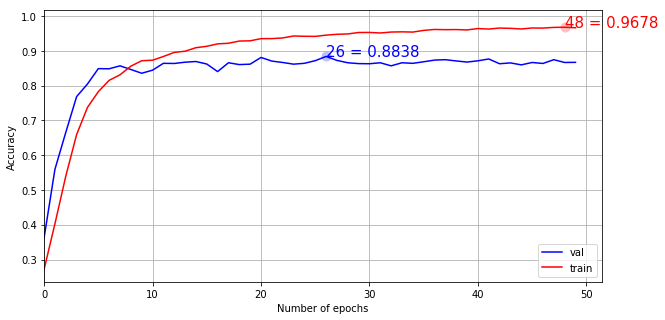

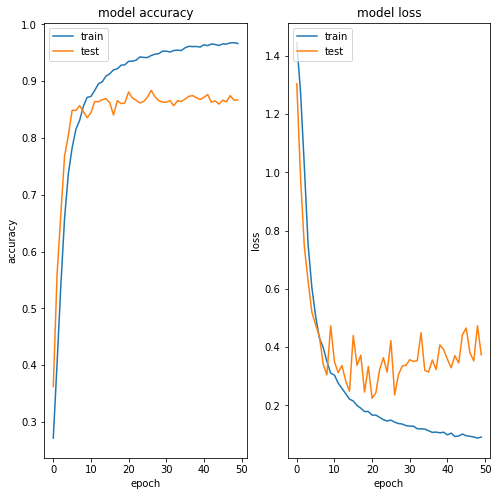

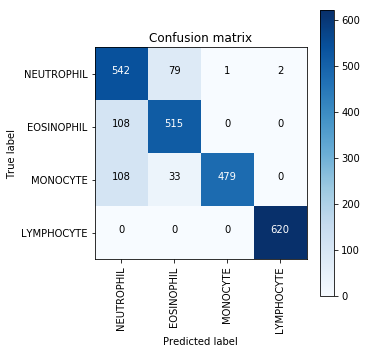

In [54]:
# use adadelta optimizer, lr=1.0, lr_decay=0.001

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adadelta', learning_rate=1.0, lr_decay=0.001)

Epoch 1/50
312/311 [==============================] - ETA: 6:16 - loss: 1.3742 - acc: 0.312 - ETA: 3:16 - loss: 4.6093 - acc: 0.281 - ETA: 1:44 - loss: 4.2994 - acc: 0.257 - ETA: 1:13 - loss: 3.3380 - acc: 0.239 - ETA: 58s - loss: 2.8508 - acc: 0.230 - ETA: 48s - loss: 2.5579 - acc: 0.22 - ETA: 45s - loss: 2.4510 - acc: 0.23 - ETA: 40s - loss: 2.2910 - acc: 0.21 - ETA: 38s - loss: 2.2264 - acc: 0.21 - ETA: 34s - loss: 2.1214 - acc: 0.23 - ETA: 32s - loss: 2.0396 - acc: 0.23 - ETA: 29s - loss: 1.9741 - acc: 0.23 - ETA: 28s - loss: 1.9211 - acc: 0.23 - ETA: 26s - loss: 1.8766 - acc: 0.23 - ETA: 25s - loss: 1.8390 - acc: 0.22 - ETA: 24s - loss: 1.8222 - acc: 0.22 - ETA: 23s - loss: 1.7917 - acc: 0.23 - ETA: 23s - loss: 1.7661 - acc: 0.23 - ETA: 22s - loss: 1.7432 - acc: 0.23 - ETA: 21s - loss: 1.7228 - acc: 0.23 - ETA: 20s - loss: 1.7046 - acc: 0.23 - ETA: 20s - loss: 1.6881 - acc: 0.23 - ETA: 19s - loss: 1.6804 - acc: 0.24 - ETA: 19s - loss: 1.6662 - acc: 0.24 - ETA: 18s - loss: 1.6543 -

312/311 [==============================] - ETA: 17s - loss: 1.1069 - acc: 0.53 - ETA: 13s - loss: 1.1529 - acc: 0.51 - ETA: 14s - loss: 1.1657 - acc: 0.50 - ETA: 13s - loss: 1.1816 - acc: 0.45 - ETA: 13s - loss: 1.1754 - acc: 0.45 - ETA: 13s - loss: 1.1533 - acc: 0.46 - ETA: 13s - loss: 1.1416 - acc: 0.47 - ETA: 13s - loss: 1.1355 - acc: 0.47 - ETA: 13s - loss: 1.1804 - acc: 0.46 - ETA: 13s - loss: 1.1804 - acc: 0.45 - ETA: 12s - loss: 1.1752 - acc: 0.46 - ETA: 12s - loss: 1.1675 - acc: 0.46 - ETA: 12s - loss: 1.1621 - acc: 0.47 - ETA: 12s - loss: 1.1549 - acc: 0.47 - ETA: 12s - loss: 1.1468 - acc: 0.47 - ETA: 12s - loss: 1.1552 - acc: 0.47 - ETA: 12s - loss: 1.1494 - acc: 0.47 - ETA: 12s - loss: 1.1521 - acc: 0.46 - ETA: 12s - loss: 1.1494 - acc: 0.47 - ETA: 12s - loss: 1.1529 - acc: 0.46 - ETA: 12s - loss: 1.1581 - acc: 0.46 - ETA: 12s - loss: 1.1527 - acc: 0.46 - ETA: 11s - loss: 1.1447 - acc: 0.47 - ETA: 11s - loss: 1.1482 - acc: 0.47 - ETA: 11s - loss: 1.1446 - acc: 0.47 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.9205 - acc: 0.59 - ETA: 13s - loss: 0.7534 - acc: 0.62 - ETA: 13s - loss: 0.7155 - acc: 0.66 - ETA: 13s - loss: 0.7235 - acc: 0.66 - ETA: 12s - loss: 0.7540 - acc: 0.64 - ETA: 12s - loss: 0.7492 - acc: 0.63 - ETA: 12s - loss: 0.7782 - acc: 0.63 - ETA: 12s - loss: 0.7603 - acc: 0.64 - ETA: 12s - loss: 0.7621 - acc: 0.65 - ETA: 12s - loss: 0.7694 - acc: 0.64 - ETA: 12s - loss: 0.7653 - acc: 0.65 - ETA: 12s - loss: 0.7666 - acc: 0.65 - ETA: 12s - loss: 0.7709 - acc: 0.64 - ETA: 12s - loss: 0.7654 - acc: 0.65 - ETA: 12s - loss: 0.7630 - acc: 0.66 - ETA: 12s - loss: 0.7577 - acc: 0.66 - ETA: 12s - loss: 0.7581 - acc: 0.66 - ETA: 12s - loss: 0.7572 - acc: 0.66 - ETA: 12s - loss: 0.7537 - acc: 0.67 - ETA: 11s - loss: 0.7498 - acc: 0.67 - ETA: 11s - loss: 0.7477 - acc: 0.67 - ETA: 11s - loss: 0.7552 - acc: 0.67 - ETA: 11s - loss: 0.7531 - acc: 0.67 - ETA: 11s - loss: 0.7534 - acc: 0.67 - ETA: 11s - loss: 0.7543 - acc: 0.66 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.7364 - acc: 0.68 - ETA: 13s - loss: 0.6837 - acc: 0.70 - ETA: 13s - loss: 0.6667 - acc: 0.70 - ETA: 13s - loss: 0.6535 - acc: 0.69 - ETA: 13s - loss: 0.6239 - acc: 0.71 - ETA: 13s - loss: 0.6091 - acc: 0.72 - ETA: 12s - loss: 0.6207 - acc: 0.73 - ETA: 12s - loss: 0.6214 - acc: 0.73 - ETA: 12s - loss: 0.6346 - acc: 0.72 - ETA: 12s - loss: 0.6220 - acc: 0.73 - ETA: 12s - loss: 0.6228 - acc: 0.73 - ETA: 12s - loss: 0.6187 - acc: 0.73 - ETA: 12s - loss: 0.6239 - acc: 0.72 - ETA: 12s - loss: 0.6319 - acc: 0.72 - ETA: 12s - loss: 0.6321 - acc: 0.71 - ETA: 12s - loss: 0.6255 - acc: 0.71 - ETA: 12s - loss: 0.6243 - acc: 0.71 - ETA: 11s - loss: 0.6192 - acc: 0.72 - ETA: 11s - loss: 0.6210 - acc: 0.72 - ETA: 11s - loss: 0.6172 - acc: 0.73 - ETA: 11s - loss: 0.6118 - acc: 0.73 - ETA: 11s - loss: 0.6051 - acc: 0.73 - ETA: 11s - loss: 0.6041 - acc: 0.73 - ETA: 11s - loss: 0.6050 - acc: 0.73 - ETA: 11s - loss: 0.6093 - acc: 0.73 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.4911 - acc: 0.81 - ETA: 12s - loss: 0.5614 - acc: 0.75 - ETA: 13s - loss: 0.5620 - acc: 0.75 - ETA: 12s - loss: 0.5472 - acc: 0.78 - ETA: 13s - loss: 0.5385 - acc: 0.78 - ETA: 12s - loss: 0.5533 - acc: 0.77 - ETA: 13s - loss: 0.5551 - acc: 0.76 - ETA: 13s - loss: 0.5409 - acc: 0.77 - ETA: 13s - loss: 0.5335 - acc: 0.77 - ETA: 13s - loss: 0.5359 - acc: 0.77 - ETA: 12s - loss: 0.5299 - acc: 0.78 - ETA: 12s - loss: 0.5380 - acc: 0.78 - ETA: 12s - loss: 0.5349 - acc: 0.78 - ETA: 12s - loss: 0.5373 - acc: 0.77 - ETA: 12s - loss: 0.5270 - acc: 0.78 - ETA: 12s - loss: 0.5229 - acc: 0.79 - ETA: 12s - loss: 0.5311 - acc: 0.78 - ETA: 12s - loss: 0.5237 - acc: 0.78 - ETA: 12s - loss: 0.5311 - acc: 0.77 - ETA: 12s - loss: 0.5293 - acc: 0.78 - ETA: 12s - loss: 0.5258 - acc: 0.78 - ETA: 12s - loss: 0.5274 - acc: 0.78 - ETA: 11s - loss: 0.5249 - acc: 0.78 - ETA: 11s - loss: 0.5255 - acc: 0.78 - ETA: 11s - loss: 0.5252 - acc: 0.78 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.4725 - acc: 0.78 - ETA: 13s - loss: 0.4362 - acc: 0.81 - ETA: 12s - loss: 0.5044 - acc: 0.79 - ETA: 12s - loss: 0.4749 - acc: 0.80 - ETA: 12s - loss: 0.4691 - acc: 0.79 - ETA: 12s - loss: 0.4617 - acc: 0.79 - ETA: 12s - loss: 0.4844 - acc: 0.78 - ETA: 12s - loss: 0.4879 - acc: 0.78 - ETA: 12s - loss: 0.4895 - acc: 0.79 - ETA: 12s - loss: 0.4898 - acc: 0.79 - ETA: 12s - loss: 0.4952 - acc: 0.79 - ETA: 12s - loss: 0.5039 - acc: 0.79 - ETA: 12s - loss: 0.4997 - acc: 0.79 - ETA: 12s - loss: 0.4955 - acc: 0.79 - ETA: 12s - loss: 0.5005 - acc: 0.79 - ETA: 12s - loss: 0.4888 - acc: 0.80 - ETA: 12s - loss: 0.4922 - acc: 0.80 - ETA: 12s - loss: 0.4855 - acc: 0.80 - ETA: 11s - loss: 0.4855 - acc: 0.80 - ETA: 11s - loss: 0.4833 - acc: 0.80 - ETA: 11s - loss: 0.4840 - acc: 0.80 - ETA: 11s - loss: 0.4785 - acc: 0.80 - ETA: 11s - loss: 0.4805 - acc: 0.81 - ETA: 11s - loss: 0.4812 - acc: 0.80 - ETA: 11s - loss: 0.4790 - acc: 0.81 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.4118 - acc: 0.84 - ETA: 14s - loss: 0.3674 - acc: 0.88 - ETA: 14s - loss: 0.3873 - acc: 0.86 - ETA: 14s - loss: 0.4420 - acc: 0.83 - ETA: 14s - loss: 0.4472 - acc: 0.83 - ETA: 15s - loss: 0.4604 - acc: 0.81 - ETA: 15s - loss: 0.4468 - acc: 0.81 - ETA: 15s - loss: 0.4410 - acc: 0.81 - ETA: 15s - loss: 0.4351 - acc: 0.82 - ETA: 15s - loss: 0.4263 - acc: 0.83 - ETA: 14s - loss: 0.4147 - acc: 0.83 - ETA: 14s - loss: 0.4116 - acc: 0.84 - ETA: 14s - loss: 0.4143 - acc: 0.84 - ETA: 14s - loss: 0.4088 - acc: 0.84 - ETA: 14s - loss: 0.4064 - acc: 0.84 - ETA: 14s - loss: 0.4113 - acc: 0.84 - ETA: 13s - loss: 0.4035 - acc: 0.85 - ETA: 13s - loss: 0.3984 - acc: 0.85 - ETA: 13s - loss: 0.3948 - acc: 0.85 - ETA: 13s - loss: 0.3937 - acc: 0.84 - ETA: 13s - loss: 0.3972 - acc: 0.84 - ETA: 13s - loss: 0.4012 - acc: 0.84 - ETA: 13s - loss: 0.3947 - acc: 0.84 - ETA: 12s - loss: 0.3951 - acc: 0.84 - ETA: 12s - loss: 0.4005 - acc: 0.84 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.3734 - acc: 0.84 - ETA: 13s - loss: 0.4364 - acc: 0.83 - ETA: 13s - loss: 0.3946 - acc: 0.85 - ETA: 13s - loss: 0.4184 - acc: 0.83 - ETA: 13s - loss: 0.3973 - acc: 0.84 - ETA: 13s - loss: 0.4203 - acc: 0.82 - ETA: 12s - loss: 0.4159 - acc: 0.83 - ETA: 12s - loss: 0.4391 - acc: 0.82 - ETA: 12s - loss: 0.4283 - acc: 0.82 - ETA: 12s - loss: 0.4200 - acc: 0.82 - ETA: 12s - loss: 0.4184 - acc: 0.82 - ETA: 12s - loss: 0.4090 - acc: 0.83 - ETA: 12s - loss: 0.4032 - acc: 0.83 - ETA: 12s - loss: 0.4024 - acc: 0.83 - ETA: 12s - loss: 0.3965 - acc: 0.83 - ETA: 12s - loss: 0.4013 - acc: 0.83 - ETA: 12s - loss: 0.3995 - acc: 0.83 - ETA: 12s - loss: 0.4032 - acc: 0.83 - ETA: 12s - loss: 0.4020 - acc: 0.84 - ETA: 12s - loss: 0.3987 - acc: 0.84 - ETA: 12s - loss: 0.3945 - acc: 0.84 - ETA: 12s - loss: 0.3920 - acc: 0.84 - ETA: 12s - loss: 0.3907 - acc: 0.84 - ETA: 11s - loss: 0.3908 - acc: 0.84 - ETA: 11s - loss: 0.3947 - acc: 0.84 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.3630 - acc: 0.90 - ETA: 13s - loss: 0.2960 - acc: 0.92 - ETA: 13s - loss: 0.3695 - acc: 0.88 - ETA: 13s - loss: 0.3558 - acc: 0.88 - ETA: 13s - loss: 0.3850 - acc: 0.86 - ETA: 13s - loss: 0.3783 - acc: 0.86 - ETA: 13s - loss: 0.3620 - acc: 0.87 - ETA: 14s - loss: 0.3544 - acc: 0.87 - ETA: 13s - loss: 0.3526 - acc: 0.87 - ETA: 13s - loss: 0.3523 - acc: 0.88 - ETA: 13s - loss: 0.3563 - acc: 0.87 - ETA: 13s - loss: 0.3581 - acc: 0.87 - ETA: 13s - loss: 0.3523 - acc: 0.87 - ETA: 13s - loss: 0.3520 - acc: 0.87 - ETA: 12s - loss: 0.3430 - acc: 0.87 - ETA: 12s - loss: 0.3358 - acc: 0.88 - ETA: 12s - loss: 0.3393 - acc: 0.87 - ETA: 12s - loss: 0.3368 - acc: 0.87 - ETA: 12s - loss: 0.3317 - acc: 0.87 - ETA: 12s - loss: 0.3289 - acc: 0.87 - ETA: 12s - loss: 0.3329 - acc: 0.87 - ETA: 12s - loss: 0.3312 - acc: 0.87 - ETA: 12s - loss: 0.3292 - acc: 0.87 - ETA: 12s - loss: 0.3261 - acc: 0.87 - ETA: 12s - loss: 0.3281 - acc: 0.87 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.3533 - acc: 0.87 - ETA: 13s - loss: 0.3439 - acc: 0.84 - ETA: 13s - loss: 0.3224 - acc: 0.86 - ETA: 13s - loss: 0.3033 - acc: 0.87 - ETA: 13s - loss: 0.3171 - acc: 0.87 - ETA: 13s - loss: 0.2984 - acc: 0.89 - ETA: 13s - loss: 0.3040 - acc: 0.89 - ETA: 13s - loss: 0.3091 - acc: 0.89 - ETA: 13s - loss: 0.3068 - acc: 0.88 - ETA: 12s - loss: 0.3022 - acc: 0.88 - ETA: 12s - loss: 0.3112 - acc: 0.88 - ETA: 12s - loss: 0.3174 - acc: 0.87 - ETA: 12s - loss: 0.3192 - acc: 0.87 - ETA: 12s - loss: 0.3160 - acc: 0.87 - ETA: 12s - loss: 0.3190 - acc: 0.87 - ETA: 12s - loss: 0.3180 - acc: 0.87 - ETA: 12s - loss: 0.3167 - acc: 0.87 - ETA: 12s - loss: 0.3131 - acc: 0.87 - ETA: 12s - loss: 0.3127 - acc: 0.87 - ETA: 12s - loss: 0.3076 - acc: 0.87 - ETA: 11s - loss: 0.3078 - acc: 0.88 - ETA: 11s - loss: 0.3074 - acc: 0.87 - ETA: 11s - loss: 0.3059 - acc: 0.87 - ETA: 11s - loss: 0.3076 - acc: 0.87 - ETA: 11s - loss: 0.3033 - acc: 0.88 - ETA: 11

312/311 [==============================] - ETA: 9s - loss: 0.2946 - acc: 0.843 - ETA: 12s - loss: 0.3173 - acc: 0.84 - ETA: 13s - loss: 0.2888 - acc: 0.86 - ETA: 13s - loss: 0.2794 - acc: 0.88 - ETA: 14s - loss: 0.2693 - acc: 0.88 - ETA: 13s - loss: 0.2376 - acc: 0.90 - ETA: 13s - loss: 0.2328 - acc: 0.90 - ETA: 13s - loss: 0.2409 - acc: 0.90 - ETA: 13s - loss: 0.2521 - acc: 0.90 - ETA: 13s - loss: 0.2618 - acc: 0.90 - ETA: 12s - loss: 0.2540 - acc: 0.90 - ETA: 12s - loss: 0.2690 - acc: 0.89 - ETA: 12s - loss: 0.2654 - acc: 0.89 - ETA: 12s - loss: 0.2626 - acc: 0.89 - ETA: 12s - loss: 0.2627 - acc: 0.89 - ETA: 12s - loss: 0.2592 - acc: 0.89 - ETA: 12s - loss: 0.2643 - acc: 0.89 - ETA: 12s - loss: 0.2608 - acc: 0.89 - ETA: 12s - loss: 0.2619 - acc: 0.89 - ETA: 12s - loss: 0.2596 - acc: 0.89 - ETA: 12s - loss: 0.2622 - acc: 0.89 - ETA: 12s - loss: 0.2613 - acc: 0.89 - ETA: 12s - loss: 0.2585 - acc: 0.90 - ETA: 12s - loss: 0.2637 - acc: 0.89 - ETA: 12s - loss: 0.2653 - acc: 0.89 - ETA: 11

312/311 [==============================] - ETA: 15s - loss: 0.2470 - acc: 0.90 - ETA: 13s - loss: 0.2866 - acc: 0.87 - ETA: 14s - loss: 0.3018 - acc: 0.88 - ETA: 13s - loss: 0.3150 - acc: 0.88 - ETA: 13s - loss: 0.3128 - acc: 0.88 - ETA: 13s - loss: 0.2890 - acc: 0.90 - ETA: 13s - loss: 0.2776 - acc: 0.89 - ETA: 13s - loss: 0.2885 - acc: 0.89 - ETA: 13s - loss: 0.2902 - acc: 0.89 - ETA: 13s - loss: 0.2910 - acc: 0.89 - ETA: 12s - loss: 0.2843 - acc: 0.89 - ETA: 12s - loss: 0.2824 - acc: 0.89 - ETA: 12s - loss: 0.2738 - acc: 0.90 - ETA: 12s - loss: 0.2719 - acc: 0.90 - ETA: 12s - loss: 0.2670 - acc: 0.90 - ETA: 12s - loss: 0.2680 - acc: 0.90 - ETA: 12s - loss: 0.2612 - acc: 0.90 - ETA: 12s - loss: 0.2615 - acc: 0.90 - ETA: 12s - loss: 0.2576 - acc: 0.91 - ETA: 12s - loss: 0.2666 - acc: 0.90 - ETA: 12s - loss: 0.2673 - acc: 0.90 - ETA: 12s - loss: 0.2692 - acc: 0.90 - ETA: 12s - loss: 0.2764 - acc: 0.90 - ETA: 12s - loss: 0.2750 - acc: 0.90 - ETA: 12s - loss: 0.2746 - acc: 0.90 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.2783 - acc: 0.90 - ETA: 13s - loss: 0.2171 - acc: 0.93 - ETA: 12s - loss: 0.2267 - acc: 0.93 - ETA: 13s - loss: 0.2237 - acc: 0.93 - ETA: 13s - loss: 0.2499 - acc: 0.92 - ETA: 13s - loss: 0.2443 - acc: 0.92 - ETA: 13s - loss: 0.2606 - acc: 0.90 - ETA: 13s - loss: 0.2529 - acc: 0.91 - ETA: 12s - loss: 0.2448 - acc: 0.91 - ETA: 12s - loss: 0.2417 - acc: 0.92 - ETA: 12s - loss: 0.2531 - acc: 0.91 - ETA: 12s - loss: 0.2498 - acc: 0.91 - ETA: 12s - loss: 0.2558 - acc: 0.91 - ETA: 12s - loss: 0.2504 - acc: 0.92 - ETA: 12s - loss: 0.2469 - acc: 0.91 - ETA: 12s - loss: 0.2466 - acc: 0.91 - ETA: 12s - loss: 0.2471 - acc: 0.91 - ETA: 12s - loss: 0.2499 - acc: 0.91 - ETA: 12s - loss: 0.2471 - acc: 0.91 - ETA: 12s - loss: 0.2452 - acc: 0.91 - ETA: 12s - loss: 0.2458 - acc: 0.91 - ETA: 12s - loss: 0.2500 - acc: 0.91 - ETA: 12s - loss: 0.2529 - acc: 0.91 - ETA: 12s - loss: 0.2525 - acc: 0.91 - ETA: 12s - loss: 0.2528 - acc: 0.91 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.2595 - acc: 0.90 - ETA: 12s - loss: 0.2535 - acc: 0.93 - ETA: 13s - loss: 0.2384 - acc: 0.92 - ETA: 12s - loss: 0.2449 - acc: 0.90 - ETA: 13s - loss: 0.2322 - acc: 0.91 - ETA: 13s - loss: 0.2180 - acc: 0.91 - ETA: 13s - loss: 0.2173 - acc: 0.92 - ETA: 13s - loss: 0.2133 - acc: 0.91 - ETA: 12s - loss: 0.2247 - acc: 0.91 - ETA: 12s - loss: 0.2272 - acc: 0.90 - ETA: 12s - loss: 0.2305 - acc: 0.90 - ETA: 12s - loss: 0.2408 - acc: 0.89 - ETA: 12s - loss: 0.2488 - acc: 0.88 - ETA: 12s - loss: 0.2441 - acc: 0.89 - ETA: 12s - loss: 0.2471 - acc: 0.89 - ETA: 12s - loss: 0.2497 - acc: 0.88 - ETA: 12s - loss: 0.2534 - acc: 0.88 - ETA: 12s - loss: 0.2503 - acc: 0.89 - ETA: 12s - loss: 0.2489 - acc: 0.89 - ETA: 12s - loss: 0.2533 - acc: 0.88 - ETA: 12s - loss: 0.2530 - acc: 0.89 - ETA: 12s - loss: 0.2500 - acc: 0.89 - ETA: 12s - loss: 0.2513 - acc: 0.89 - ETA: 12s - loss: 0.2483 - acc: 0.89 - ETA: 11s - loss: 0.2495 - acc: 0.89 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1761 - acc: 0.93 - ETA: 13s - loss: 0.1936 - acc: 0.91 - ETA: 13s - loss: 0.1938 - acc: 0.91 - ETA: 12s - loss: 0.1961 - acc: 0.92 - ETA: 13s - loss: 0.1932 - acc: 0.92 - ETA: 12s - loss: 0.2168 - acc: 0.91 - ETA: 13s - loss: 0.2143 - acc: 0.92 - ETA: 12s - loss: 0.2211 - acc: 0.92 - ETA: 12s - loss: 0.2074 - acc: 0.92 - ETA: 12s - loss: 0.2059 - acc: 0.92 - ETA: 12s - loss: 0.2088 - acc: 0.92 - ETA: 12s - loss: 0.2233 - acc: 0.91 - ETA: 12s - loss: 0.2260 - acc: 0.91 - ETA: 12s - loss: 0.2284 - acc: 0.91 - ETA: 12s - loss: 0.2228 - acc: 0.91 - ETA: 12s - loss: 0.2237 - acc: 0.91 - ETA: 12s - loss: 0.2288 - acc: 0.91 - ETA: 12s - loss: 0.2260 - acc: 0.91 - ETA: 12s - loss: 0.2244 - acc: 0.91 - ETA: 12s - loss: 0.2229 - acc: 0.91 - ETA: 12s - loss: 0.2207 - acc: 0.91 - ETA: 12s - loss: 0.2244 - acc: 0.91 - ETA: 12s - loss: 0.2253 - acc: 0.91 - ETA: 11s - loss: 0.2258 - acc: 0.91 - ETA: 11s - loss: 0.2254 - acc: 0.91 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.1371 - acc: 0.96 - ETA: 13s - loss: 0.1959 - acc: 0.90 - ETA: 14s - loss: 0.2029 - acc: 0.89 - ETA: 13s - loss: 0.2330 - acc: 0.89 - ETA: 13s - loss: 0.2272 - acc: 0.90 - ETA: 13s - loss: 0.2178 - acc: 0.91 - ETA: 13s - loss: 0.2172 - acc: 0.92 - ETA: 13s - loss: 0.2203 - acc: 0.91 - ETA: 13s - loss: 0.2180 - acc: 0.92 - ETA: 13s - loss: 0.2139 - acc: 0.92 - ETA: 13s - loss: 0.2126 - acc: 0.92 - ETA: 13s - loss: 0.2141 - acc: 0.92 - ETA: 12s - loss: 0.2094 - acc: 0.92 - ETA: 12s - loss: 0.2131 - acc: 0.92 - ETA: 12s - loss: 0.2088 - acc: 0.92 - ETA: 12s - loss: 0.2066 - acc: 0.92 - ETA: 12s - loss: 0.2110 - acc: 0.92 - ETA: 12s - loss: 0.2082 - acc: 0.92 - ETA: 12s - loss: 0.2136 - acc: 0.92 - ETA: 12s - loss: 0.2155 - acc: 0.92 - ETA: 12s - loss: 0.2130 - acc: 0.92 - ETA: 12s - loss: 0.2119 - acc: 0.92 - ETA: 12s - loss: 0.2100 - acc: 0.92 - ETA: 12s - loss: 0.2089 - acc: 0.92 - ETA: 11s - loss: 0.2089 - acc: 0.92 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.1299 - acc: 0.96 - ETA: 12s - loss: 0.1730 - acc: 0.95 - ETA: 13s - loss: 0.1947 - acc: 0.94 - ETA: 13s - loss: 0.1969 - acc: 0.92 - ETA: 13s - loss: 0.2336 - acc: 0.91 - ETA: 13s - loss: 0.2413 - acc: 0.90 - ETA: 13s - loss: 0.2255 - acc: 0.91 - ETA: 12s - loss: 0.2216 - acc: 0.91 - ETA: 12s - loss: 0.2213 - acc: 0.91 - ETA: 12s - loss: 0.2309 - acc: 0.90 - ETA: 12s - loss: 0.2305 - acc: 0.90 - ETA: 12s - loss: 0.2298 - acc: 0.91 - ETA: 12s - loss: 0.2295 - acc: 0.91 - ETA: 12s - loss: 0.2254 - acc: 0.91 - ETA: 12s - loss: 0.2337 - acc: 0.91 - ETA: 12s - loss: 0.2294 - acc: 0.91 - ETA: 12s - loss: 0.2305 - acc: 0.91 - ETA: 12s - loss: 0.2310 - acc: 0.91 - ETA: 12s - loss: 0.2318 - acc: 0.91 - ETA: 12s - loss: 0.2327 - acc: 0.90 - ETA: 12s - loss: 0.2339 - acc: 0.90 - ETA: 12s - loss: 0.2331 - acc: 0.90 - ETA: 11s - loss: 0.2275 - acc: 0.91 - ETA: 12s - loss: 0.2296 - acc: 0.91 - ETA: 11s - loss: 0.2274 - acc: 0.91 - ETA: 11

312/311 [==============================] - ETA: 15s - loss: 0.1809 - acc: 0.96 - ETA: 15s - loss: 0.2283 - acc: 0.91 - ETA: 15s - loss: 0.2520 - acc: 0.92 - ETA: 14s - loss: 0.2547 - acc: 0.90 - ETA: 14s - loss: 0.2499 - acc: 0.89 - ETA: 14s - loss: 0.2399 - acc: 0.90 - ETA: 13s - loss: 0.2264 - acc: 0.91 - ETA: 13s - loss: 0.2455 - acc: 0.90 - ETA: 13s - loss: 0.2418 - acc: 0.90 - ETA: 13s - loss: 0.2327 - acc: 0.91 - ETA: 13s - loss: 0.2345 - acc: 0.91 - ETA: 13s - loss: 0.2293 - acc: 0.91 - ETA: 12s - loss: 0.2260 - acc: 0.91 - ETA: 12s - loss: 0.2286 - acc: 0.91 - ETA: 12s - loss: 0.2240 - acc: 0.91 - ETA: 12s - loss: 0.2165 - acc: 0.91 - ETA: 12s - loss: 0.2123 - acc: 0.92 - ETA: 12s - loss: 0.2109 - acc: 0.92 - ETA: 12s - loss: 0.2134 - acc: 0.91 - ETA: 12s - loss: 0.2148 - acc: 0.91 - ETA: 12s - loss: 0.2096 - acc: 0.92 - ETA: 12s - loss: 0.2077 - acc: 0.92 - ETA: 11s - loss: 0.2086 - acc: 0.92 - ETA: 11s - loss: 0.2104 - acc: 0.92 - ETA: 11s - loss: 0.2063 - acc: 0.92 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.3063 - acc: 0.87 - ETA: 13s - loss: 0.2672 - acc: 0.89 - ETA: 13s - loss: 0.2000 - acc: 0.93 - ETA: 13s - loss: 0.2046 - acc: 0.93 - ETA: 12s - loss: 0.2145 - acc: 0.92 - ETA: 12s - loss: 0.1988 - acc: 0.92 - ETA: 12s - loss: 0.1935 - acc: 0.93 - ETA: 12s - loss: 0.1844 - acc: 0.93 - ETA: 12s - loss: 0.1906 - acc: 0.92 - ETA: 12s - loss: 0.1869 - acc: 0.93 - ETA: 12s - loss: 0.1848 - acc: 0.93 - ETA: 12s - loss: 0.1862 - acc: 0.93 - ETA: 12s - loss: 0.1898 - acc: 0.93 - ETA: 12s - loss: 0.1916 - acc: 0.92 - ETA: 12s - loss: 0.1969 - acc: 0.92 - ETA: 12s - loss: 0.2021 - acc: 0.92 - ETA: 12s - loss: 0.2043 - acc: 0.92 - ETA: 12s - loss: 0.2030 - acc: 0.92 - ETA: 11s - loss: 0.2037 - acc: 0.92 - ETA: 11s - loss: 0.2054 - acc: 0.92 - ETA: 11s - loss: 0.2031 - acc: 0.92 - ETA: 11s - loss: 0.2047 - acc: 0.92 - ETA: 11s - loss: 0.2031 - acc: 0.92 - ETA: 11s - loss: 0.1988 - acc: 0.92 - ETA: 11s - loss: 0.1978 - acc: 0.92 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2320 - acc: 0.93 - ETA: 12s - loss: 0.2666 - acc: 0.89 - ETA: 13s - loss: 0.2312 - acc: 0.91 - ETA: 13s - loss: 0.1820 - acc: 0.94 - ETA: 13s - loss: 0.1874 - acc: 0.93 - ETA: 13s - loss: 0.1795 - acc: 0.93 - ETA: 12s - loss: 0.1718 - acc: 0.93 - ETA: 13s - loss: 0.1723 - acc: 0.93 - ETA: 13s - loss: 0.1759 - acc: 0.93 - ETA: 12s - loss: 0.1731 - acc: 0.93 - ETA: 12s - loss: 0.1695 - acc: 0.93 - ETA: 12s - loss: 0.1784 - acc: 0.93 - ETA: 12s - loss: 0.1796 - acc: 0.93 - ETA: 12s - loss: 0.1824 - acc: 0.93 - ETA: 12s - loss: 0.1807 - acc: 0.93 - ETA: 12s - loss: 0.1837 - acc: 0.93 - ETA: 12s - loss: 0.1894 - acc: 0.93 - ETA: 12s - loss: 0.1913 - acc: 0.93 - ETA: 12s - loss: 0.1904 - acc: 0.92 - ETA: 12s - loss: 0.1867 - acc: 0.93 - ETA: 12s - loss: 0.1832 - acc: 0.93 - ETA: 11s - loss: 0.1861 - acc: 0.93 - ETA: 11s - loss: 0.1839 - acc: 0.93 - ETA: 11s - loss: 0.1816 - acc: 0.93 - ETA: 11s - loss: 0.1814 - acc: 0.93 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.2572 - acc: 0.87 - ETA: 12s - loss: 0.2593 - acc: 0.89 - ETA: 14s - loss: 0.2315 - acc: 0.89 - ETA: 13s - loss: 0.2145 - acc: 0.91 - ETA: 13s - loss: 0.2211 - acc: 0.91 - ETA: 14s - loss: 0.2424 - acc: 0.90 - ETA: 14s - loss: 0.2323 - acc: 0.91 - ETA: 14s - loss: 0.2167 - acc: 0.91 - ETA: 14s - loss: 0.2105 - acc: 0.92 - ETA: 14s - loss: 0.2100 - acc: 0.91 - ETA: 14s - loss: 0.1970 - acc: 0.92 - ETA: 13s - loss: 0.1906 - acc: 0.92 - ETA: 13s - loss: 0.1843 - acc: 0.93 - ETA: 14s - loss: 0.1836 - acc: 0.93 - ETA: 13s - loss: 0.1777 - acc: 0.93 - ETA: 13s - loss: 0.1741 - acc: 0.93 - ETA: 13s - loss: 0.1702 - acc: 0.93 - ETA: 13s - loss: 0.1738 - acc: 0.93 - ETA: 13s - loss: 0.1734 - acc: 0.93 - ETA: 13s - loss: 0.1708 - acc: 0.93 - ETA: 13s - loss: 0.1790 - acc: 0.93 - ETA: 13s - loss: 0.1853 - acc: 0.93 - ETA: 13s - loss: 0.1849 - acc: 0.93 - ETA: 13s - loss: 0.1866 - acc: 0.93 - ETA: 12s - loss: 0.1863 - acc: 0.93 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.2100 - acc: 0.90 - ETA: 13s - loss: 0.1834 - acc: 0.93 - ETA: 13s - loss: 0.2128 - acc: 0.92 - ETA: 12s - loss: 0.2084 - acc: 0.92 - ETA: 12s - loss: 0.2080 - acc: 0.92 - ETA: 12s - loss: 0.1987 - acc: 0.92 - ETA: 12s - loss: 0.2046 - acc: 0.92 - ETA: 13s - loss: 0.2013 - acc: 0.92 - ETA: 13s - loss: 0.1944 - acc: 0.93 - ETA: 13s - loss: 0.1852 - acc: 0.93 - ETA: 13s - loss: 0.1868 - acc: 0.93 - ETA: 13s - loss: 0.1897 - acc: 0.93 - ETA: 13s - loss: 0.1913 - acc: 0.92 - ETA: 13s - loss: 0.1940 - acc: 0.93 - ETA: 13s - loss: 0.2016 - acc: 0.92 - ETA: 13s - loss: 0.1973 - acc: 0.93 - ETA: 13s - loss: 0.1930 - acc: 0.93 - ETA: 13s - loss: 0.1888 - acc: 0.93 - ETA: 13s - loss: 0.1863 - acc: 0.93 - ETA: 13s - loss: 0.1891 - acc: 0.93 - ETA: 13s - loss: 0.1896 - acc: 0.93 - ETA: 13s - loss: 0.1856 - acc: 0.93 - ETA: 13s - loss: 0.1843 - acc: 0.93 - ETA: 13s - loss: 0.1862 - acc: 0.93 - ETA: 12s - loss: 0.1878 - acc: 0.93 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.1226 - acc: 0.96 - ETA: 13s - loss: 0.1141 - acc: 0.98 - ETA: 13s - loss: 0.1382 - acc: 0.96 - ETA: 13s - loss: 0.1419 - acc: 0.95 - ETA: 13s - loss: 0.1447 - acc: 0.94 - ETA: 13s - loss: 0.1424 - acc: 0.94 - ETA: 13s - loss: 0.1456 - acc: 0.94 - ETA: 13s - loss: 0.1582 - acc: 0.94 - ETA: 13s - loss: 0.1655 - acc: 0.94 - ETA: 13s - loss: 0.1635 - acc: 0.93 - ETA: 13s - loss: 0.1848 - acc: 0.92 - ETA: 13s - loss: 0.1882 - acc: 0.92 - ETA: 13s - loss: 0.1918 - acc: 0.92 - ETA: 13s - loss: 0.1899 - acc: 0.92 - ETA: 13s - loss: 0.1862 - acc: 0.92 - ETA: 13s - loss: 0.1845 - acc: 0.92 - ETA: 13s - loss: 0.1817 - acc: 0.92 - ETA: 12s - loss: 0.1769 - acc: 0.93 - ETA: 12s - loss: 0.1793 - acc: 0.93 - ETA: 12s - loss: 0.1805 - acc: 0.93 - ETA: 12s - loss: 0.1831 - acc: 0.93 - ETA: 12s - loss: 0.1836 - acc: 0.93 - ETA: 12s - loss: 0.1866 - acc: 0.92 - ETA: 12s - loss: 0.1877 - acc: 0.92 - ETA: 12s - loss: 0.1918 - acc: 0.92 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.1397 - acc: 0.96 - ETA: 16s - loss: 0.1003 - acc: 0.98 - ETA: 15s - loss: 0.1052 - acc: 0.99 - ETA: 15s - loss: 0.1422 - acc: 0.96 - ETA: 14s - loss: 0.1535 - acc: 0.95 - ETA: 14s - loss: 0.1562 - acc: 0.95 - ETA: 14s - loss: 0.1533 - acc: 0.95 - ETA: 13s - loss: 0.1499 - acc: 0.95 - ETA: 13s - loss: 0.1429 - acc: 0.96 - ETA: 13s - loss: 0.1392 - acc: 0.96 - ETA: 13s - loss: 0.1417 - acc: 0.95 - ETA: 13s - loss: 0.1412 - acc: 0.95 - ETA: 13s - loss: 0.1404 - acc: 0.95 - ETA: 12s - loss: 0.1375 - acc: 0.96 - ETA: 13s - loss: 0.1368 - acc: 0.95 - ETA: 12s - loss: 0.1352 - acc: 0.95 - ETA: 12s - loss: 0.1375 - acc: 0.95 - ETA: 12s - loss: 0.1455 - acc: 0.95 - ETA: 13s - loss: 0.1529 - acc: 0.95 - ETA: 12s - loss: 0.1514 - acc: 0.95 - ETA: 12s - loss: 0.1536 - acc: 0.95 - ETA: 12s - loss: 0.1544 - acc: 0.94 - ETA: 12s - loss: 0.1545 - acc: 0.94 - ETA: 12s - loss: 0.1547 - acc: 0.94 - ETA: 12s - loss: 0.1557 - acc: 0.94 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.0798 - acc: 1.00 - ETA: 14s - loss: 0.1307 - acc: 0.92 - ETA: 14s - loss: 0.1383 - acc: 0.95 - ETA: 14s - loss: 0.1517 - acc: 0.94 - ETA: 13s - loss: 0.1790 - acc: 0.94 - ETA: 13s - loss: 0.1849 - acc: 0.92 - ETA: 14s - loss: 0.1849 - acc: 0.92 - ETA: 13s - loss: 0.1750 - acc: 0.93 - ETA: 14s - loss: 0.1706 - acc: 0.93 - ETA: 14s - loss: 0.1628 - acc: 0.94 - ETA: 14s - loss: 0.1615 - acc: 0.94 - ETA: 14s - loss: 0.1586 - acc: 0.94 - ETA: 14s - loss: 0.1580 - acc: 0.94 - ETA: 13s - loss: 0.1581 - acc: 0.94 - ETA: 13s - loss: 0.1551 - acc: 0.94 - ETA: 13s - loss: 0.1511 - acc: 0.94 - ETA: 13s - loss: 0.1544 - acc: 0.94 - ETA: 13s - loss: 0.1560 - acc: 0.94 - ETA: 13s - loss: 0.1530 - acc: 0.94 - ETA: 13s - loss: 0.1582 - acc: 0.94 - ETA: 12s - loss: 0.1591 - acc: 0.94 - ETA: 12s - loss: 0.1599 - acc: 0.94 - ETA: 12s - loss: 0.1613 - acc: 0.93 - ETA: 12s - loss: 0.1601 - acc: 0.94 - ETA: 12s - loss: 0.1604 - acc: 0.94 - ETA: 12

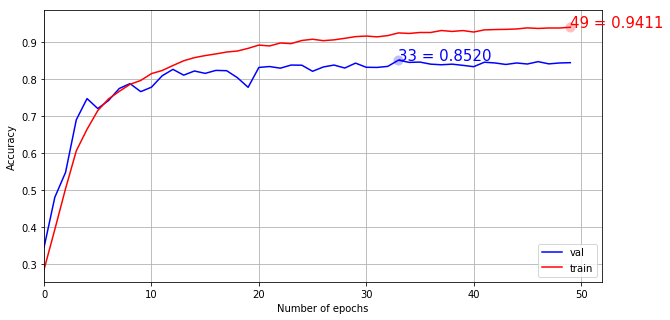

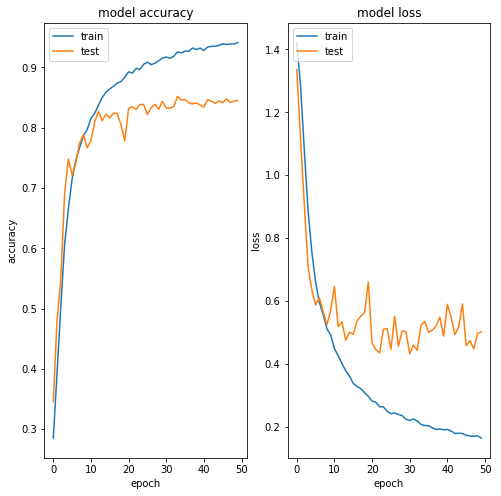

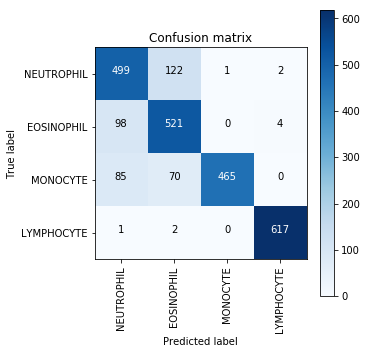

In [56]:
# use adadelta optimizer, lr=0.8, lr_decay=0.002

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adadelta', learning_rate=0.8, lr_decay=0.002)

Epoch 1/50
312/311 [==============================] - ETA: 6:25 - loss: 1.4413 - acc: 0.187 - ETA: 3:20 - loss: 4.3488 - acc: 0.203 - ETA: 1:46 - loss: 4.0835 - acc: 0.187 - ETA: 1:28 - loss: 3.5452 - acc: 0.206 - ETA: 1:06 - loss: 2.9375 - acc: 0.223 - ETA: 59s - loss: 2.7410 - acc: 0.238 - ETA: 49s - loss: 2.4795 - acc: 0.25 - ETA: 43s - loss: 2.3008 - acc: 0.24 - ETA: 41s - loss: 2.2304 - acc: 0.24 - ETA: 37s - loss: 2.1181 - acc: 0.25 - ETA: 34s - loss: 2.0322 - acc: 0.25 - ETA: 31s - loss: 1.9647 - acc: 0.26 - ETA: 30s - loss: 1.9358 - acc: 0.26 - ETA: 28s - loss: 1.8858 - acc: 0.26 - ETA: 27s - loss: 1.8640 - acc: 0.26 - ETA: 26s - loss: 1.8256 - acc: 0.25 - ETA: 25s - loss: 1.8085 - acc: 0.26 - ETA: 24s - loss: 1.7801 - acc: 0.26 - ETA: 23s - loss: 1.7535 - acc: 0.26 - ETA: 23s - loss: 1.7419 - acc: 0.26 - ETA: 22s - loss: 1.7200 - acc: 0.26 - ETA: 22s - loss: 1.7101 - acc: 0.26 - ETA: 21s - loss: 1.6924 - acc: 0.26 - ETA: 21s - loss: 1.6841 - acc: 0.26 - ETA: 20s - loss: 1.6689

312/311 [==============================] - ETA: 15s - loss: 1.3062 - acc: 0.46 - ETA: 14s - loss: 1.3418 - acc: 0.40 - ETA: 13s - loss: 1.3595 - acc: 0.35 - ETA: 13s - loss: 1.3617 - acc: 0.34 - ETA: 13s - loss: 1.3605 - acc: 0.32 - ETA: 13s - loss: 1.3568 - acc: 0.33 - ETA: 13s - loss: 1.3445 - acc: 0.33 - ETA: 13s - loss: 1.3461 - acc: 0.33 - ETA: 12s - loss: 1.3527 - acc: 0.33 - ETA: 12s - loss: 1.3560 - acc: 0.32 - ETA: 12s - loss: 1.3595 - acc: 0.32 - ETA: 12s - loss: 1.3583 - acc: 0.33 - ETA: 12s - loss: 1.3605 - acc: 0.32 - ETA: 12s - loss: 1.3604 - acc: 0.32 - ETA: 12s - loss: 1.3566 - acc: 0.33 - ETA: 12s - loss: 1.3550 - acc: 0.34 - ETA: 12s - loss: 1.3557 - acc: 0.33 - ETA: 12s - loss: 1.3523 - acc: 0.34 - ETA: 11s - loss: 1.3563 - acc: 0.33 - ETA: 11s - loss: 1.3573 - acc: 0.33 - ETA: 11s - loss: 1.3568 - acc: 0.32 - ETA: 11s - loss: 1.3562 - acc: 0.33 - ETA: 11s - loss: 1.3569 - acc: 0.33 - ETA: 11s - loss: 1.3573 - acc: 0.33 - ETA: 11s - loss: 1.3560 - acc: 0.34 - ETA: 11

312/311 [==============================] - ETA: 19s - loss: 1.4600 - acc: 0.50 - ETA: 15s - loss: 1.3466 - acc: 0.41 - ETA: 13s - loss: 1.2317 - acc: 0.44 - ETA: 14s - loss: 1.1758 - acc: 0.46 - ETA: 13s - loss: 1.1240 - acc: 0.47 - ETA: 13s - loss: 1.1319 - acc: 0.47 - ETA: 13s - loss: 1.1288 - acc: 0.49 - ETA: 13s - loss: 1.1080 - acc: 0.49 - ETA: 13s - loss: 1.1115 - acc: 0.48 - ETA: 13s - loss: 1.1016 - acc: 0.48 - ETA: 12s - loss: 1.1000 - acc: 0.48 - ETA: 12s - loss: 1.0947 - acc: 0.48 - ETA: 12s - loss: 1.0965 - acc: 0.48 - ETA: 12s - loss: 1.0838 - acc: 0.49 - ETA: 12s - loss: 1.0804 - acc: 0.49 - ETA: 12s - loss: 1.0862 - acc: 0.49 - ETA: 12s - loss: 1.1059 - acc: 0.48 - ETA: 12s - loss: 1.0988 - acc: 0.49 - ETA: 12s - loss: 1.1100 - acc: 0.48 - ETA: 12s - loss: 1.0955 - acc: 0.49 - ETA: 12s - loss: 1.0908 - acc: 0.49 - ETA: 12s - loss: 1.0912 - acc: 0.49 - ETA: 11s - loss: 1.0964 - acc: 0.49 - ETA: 11s - loss: 1.0926 - acc: 0.49 - ETA: 11s - loss: 1.0899 - acc: 0.49 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.6019 - acc: 0.65 - ETA: 13s - loss: 0.6328 - acc: 0.68 - ETA: 13s - loss: 0.6762 - acc: 0.70 - ETA: 13s - loss: 0.7321 - acc: 0.69 - ETA: 13s - loss: 0.7006 - acc: 0.70 - ETA: 13s - loss: 0.6998 - acc: 0.71 - ETA: 12s - loss: 0.7213 - acc: 0.71 - ETA: 12s - loss: 0.7413 - acc: 0.70 - ETA: 12s - loss: 0.7189 - acc: 0.71 - ETA: 12s - loss: 0.7154 - acc: 0.72 - ETA: 12s - loss: 0.7396 - acc: 0.69 - ETA: 12s - loss: 0.7703 - acc: 0.69 - ETA: 12s - loss: 0.7719 - acc: 0.69 - ETA: 12s - loss: 0.7623 - acc: 0.70 - ETA: 12s - loss: 0.7525 - acc: 0.70 - ETA: 12s - loss: 0.7507 - acc: 0.70 - ETA: 12s - loss: 0.7414 - acc: 0.70 - ETA: 12s - loss: 0.7356 - acc: 0.70 - ETA: 12s - loss: 0.7370 - acc: 0.71 - ETA: 11s - loss: 0.7322 - acc: 0.70 - ETA: 11s - loss: 0.7310 - acc: 0.71 - ETA: 11s - loss: 0.7283 - acc: 0.71 - ETA: 11s - loss: 0.7281 - acc: 0.70 - ETA: 11s - loss: 0.7236 - acc: 0.70 - ETA: 11s - loss: 0.7363 - acc: 0.70 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.3599 - acc: 0.81 - ETA: 14s - loss: 0.5364 - acc: 0.78 - ETA: 14s - loss: 0.6044 - acc: 0.75 - ETA: 14s - loss: 0.6121 - acc: 0.74 - ETA: 14s - loss: 0.5877 - acc: 0.75 - ETA: 14s - loss: 0.5632 - acc: 0.76 - ETA: 13s - loss: 0.5403 - acc: 0.76 - ETA: 13s - loss: 0.5531 - acc: 0.76 - ETA: 14s - loss: 0.5418 - acc: 0.77 - ETA: 13s - loss: 0.5380 - acc: 0.77 - ETA: 13s - loss: 0.5340 - acc: 0.77 - ETA: 13s - loss: 0.5437 - acc: 0.76 - ETA: 13s - loss: 0.5323 - acc: 0.77 - ETA: 13s - loss: 0.5355 - acc: 0.77 - ETA: 13s - loss: 0.5326 - acc: 0.77 - ETA: 13s - loss: 0.5384 - acc: 0.77 - ETA: 13s - loss: 0.5311 - acc: 0.78 - ETA: 13s - loss: 0.5289 - acc: 0.78 - ETA: 13s - loss: 0.5207 - acc: 0.78 - ETA: 13s - loss: 0.5187 - acc: 0.78 - ETA: 12s - loss: 0.5205 - acc: 0.78 - ETA: 12s - loss: 0.5252 - acc: 0.77 - ETA: 12s - loss: 0.5512 - acc: 0.77 - ETA: 12s - loss: 0.5549 - acc: 0.77 - ETA: 12s - loss: 0.5688 - acc: 0.76 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 0.5564 - acc: 0.75 - ETA: 13s - loss: 1.0542 - acc: 0.66 - ETA: 13s - loss: 0.9826 - acc: 0.63 - ETA: 12s - loss: 0.9121 - acc: 0.64 - ETA: 13s - loss: 0.8479 - acc: 0.66 - ETA: 13s - loss: 0.7568 - acc: 0.69 - ETA: 13s - loss: 0.6945 - acc: 0.72 - ETA: 13s - loss: 0.6508 - acc: 0.73 - ETA: 13s - loss: 0.6310 - acc: 0.74 - ETA: 13s - loss: 0.6019 - acc: 0.75 - ETA: 13s - loss: 0.5902 - acc: 0.75 - ETA: 13s - loss: 0.5658 - acc: 0.76 - ETA: 13s - loss: 0.5437 - acc: 0.77 - ETA: 13s - loss: 0.5358 - acc: 0.78 - ETA: 13s - loss: 0.5357 - acc: 0.77 - ETA: 12s - loss: 0.5343 - acc: 0.77 - ETA: 12s - loss: 0.5300 - acc: 0.78 - ETA: 12s - loss: 0.5287 - acc: 0.78 - ETA: 12s - loss: 0.5214 - acc: 0.78 - ETA: 12s - loss: 0.5129 - acc: 0.78 - ETA: 12s - loss: 0.5196 - acc: 0.78 - ETA: 12s - loss: 0.5116 - acc: 0.78 - ETA: 12s - loss: 0.5021 - acc: 0.79 - ETA: 12s - loss: 0.5004 - acc: 0.79 - ETA: 12s - loss: 0.4995 - acc: 0.79 - ETA: 12

312/311 [==============================] - ETA: 13s - loss: 0.3380 - acc: 0.84 - ETA: 13s - loss: 0.3223 - acc: 0.87 - ETA: 13s - loss: 0.3407 - acc: 0.86 - ETA: 13s - loss: 0.3754 - acc: 0.85 - ETA: 13s - loss: 0.3452 - acc: 0.87 - ETA: 12s - loss: 0.3302 - acc: 0.88 - ETA: 12s - loss: 0.3139 - acc: 0.88 - ETA: 12s - loss: 0.3353 - acc: 0.87 - ETA: 12s - loss: 0.3398 - acc: 0.87 - ETA: 12s - loss: 0.3476 - acc: 0.87 - ETA: 12s - loss: 0.3485 - acc: 0.86 - ETA: 12s - loss: 0.3442 - acc: 0.86 - ETA: 12s - loss: 0.3429 - acc: 0.86 - ETA: 12s - loss: 0.3415 - acc: 0.86 - ETA: 12s - loss: 0.3460 - acc: 0.86 - ETA: 12s - loss: 0.3474 - acc: 0.86 - ETA: 12s - loss: 0.3461 - acc: 0.86 - ETA: 12s - loss: 0.3492 - acc: 0.86 - ETA: 12s - loss: 0.3428 - acc: 0.86 - ETA: 12s - loss: 0.3463 - acc: 0.86 - ETA: 12s - loss: 0.3476 - acc: 0.85 - ETA: 11s - loss: 0.3636 - acc: 0.85 - ETA: 11s - loss: 0.3812 - acc: 0.84 - ETA: 11s - loss: 0.4408 - acc: 0.82 - ETA: 11s - loss: 0.4467 - acc: 0.82 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1708 - acc: 0.93 - ETA: 13s - loss: 0.3382 - acc: 0.84 - ETA: 12s - loss: 0.3480 - acc: 0.82 - ETA: 12s - loss: 0.3166 - acc: 0.83 - ETA: 13s - loss: 0.3109 - acc: 0.84 - ETA: 13s - loss: 0.3371 - acc: 0.84 - ETA: 13s - loss: 0.3458 - acc: 0.83 - ETA: 12s - loss: 0.3515 - acc: 0.83 - ETA: 12s - loss: 0.3485 - acc: 0.84 - ETA: 12s - loss: 0.3378 - acc: 0.84 - ETA: 12s - loss: 0.3249 - acc: 0.85 - ETA: 12s - loss: 0.3236 - acc: 0.85 - ETA: 12s - loss: 0.3186 - acc: 0.86 - ETA: 12s - loss: 0.3165 - acc: 0.86 - ETA: 12s - loss: 0.3153 - acc: 0.86 - ETA: 12s - loss: 0.3208 - acc: 0.86 - ETA: 12s - loss: 0.3189 - acc: 0.86 - ETA: 12s - loss: 0.3189 - acc: 0.86 - ETA: 12s - loss: 0.3166 - acc: 0.86 - ETA: 12s - loss: 0.3171 - acc: 0.86 - ETA: 12s - loss: 0.3072 - acc: 0.86 - ETA: 12s - loss: 0.3030 - acc: 0.86 - ETA: 12s - loss: 0.3002 - acc: 0.86 - ETA: 12s - loss: 0.2980 - acc: 0.87 - ETA: 11s - loss: 0.2947 - acc: 0.87 - ETA: 11

312/311 [==============================] - ETA: 11s - loss: 0.3471 - acc: 0.81 - ETA: 12s - loss: 0.2281 - acc: 0.88 - ETA: 13s - loss: 0.3565 - acc: 0.85 - ETA: 14s - loss: 0.3443 - acc: 0.85 - ETA: 14s - loss: 0.3214 - acc: 0.86 - ETA: 14s - loss: 0.3104 - acc: 0.86 - ETA: 14s - loss: 0.3003 - acc: 0.87 - ETA: 14s - loss: 0.3063 - acc: 0.87 - ETA: 14s - loss: 0.3131 - acc: 0.86 - ETA: 14s - loss: 0.3071 - acc: 0.86 - ETA: 14s - loss: 0.3052 - acc: 0.86 - ETA: 14s - loss: 0.3219 - acc: 0.85 - ETA: 14s - loss: 0.3188 - acc: 0.86 - ETA: 14s - loss: 0.3212 - acc: 0.85 - ETA: 14s - loss: 0.3138 - acc: 0.86 - ETA: 14s - loss: 0.3121 - acc: 0.86 - ETA: 13s - loss: 0.3029 - acc: 0.87 - ETA: 13s - loss: 0.2905 - acc: 0.87 - ETA: 13s - loss: 0.3035 - acc: 0.87 - ETA: 13s - loss: 0.3076 - acc: 0.87 - ETA: 13s - loss: 0.3160 - acc: 0.86 - ETA: 13s - loss: 0.3181 - acc: 0.87 - ETA: 13s - loss: 0.3135 - acc: 0.87 - ETA: 13s - loss: 0.3128 - acc: 0.87 - ETA: 12s - loss: 0.3070 - acc: 0.87 - ETA: 13

312/311 [==============================] - ETA: 13s - loss: 0.3384 - acc: 0.81 - ETA: 13s - loss: 0.4029 - acc: 0.84 - ETA: 13s - loss: 0.3324 - acc: 0.87 - ETA: 12s - loss: 0.2867 - acc: 0.88 - ETA: 12s - loss: 0.2691 - acc: 0.89 - ETA: 12s - loss: 0.3013 - acc: 0.88 - ETA: 12s - loss: 0.3340 - acc: 0.86 - ETA: 12s - loss: 0.3149 - acc: 0.87 - ETA: 12s - loss: 0.3088 - acc: 0.87 - ETA: 12s - loss: 0.2910 - acc: 0.88 - ETA: 12s - loss: 0.2721 - acc: 0.89 - ETA: 12s - loss: 0.2593 - acc: 0.90 - ETA: 12s - loss: 0.2536 - acc: 0.90 - ETA: 12s - loss: 0.2494 - acc: 0.90 - ETA: 12s - loss: 0.2482 - acc: 0.90 - ETA: 12s - loss: 0.2460 - acc: 0.90 - ETA: 11s - loss: 0.2433 - acc: 0.90 - ETA: 11s - loss: 0.2439 - acc: 0.90 - ETA: 11s - loss: 0.2479 - acc: 0.90 - ETA: 11s - loss: 0.2475 - acc: 0.90 - ETA: 11s - loss: 0.2449 - acc: 0.90 - ETA: 11s - loss: 0.2382 - acc: 0.90 - ETA: 11s - loss: 0.2319 - acc: 0.90 - ETA: 11s - loss: 0.2290 - acc: 0.90 - ETA: 11s - loss: 0.2286 - acc: 0.90 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.4695 - acc: 0.87 - ETA: 13s - loss: 0.2575 - acc: 0.91 - ETA: 13s - loss: 0.2678 - acc: 0.88 - ETA: 13s - loss: 0.2517 - acc: 0.89 - ETA: 13s - loss: 0.2285 - acc: 0.91 - ETA: 12s - loss: 0.2380 - acc: 0.91 - ETA: 12s - loss: 0.2433 - acc: 0.91 - ETA: 12s - loss: 0.2374 - acc: 0.91 - ETA: 12s - loss: 0.2342 - acc: 0.91 - ETA: 12s - loss: 0.2314 - acc: 0.91 - ETA: 12s - loss: 0.2262 - acc: 0.91 - ETA: 12s - loss: 0.2215 - acc: 0.92 - ETA: 12s - loss: 0.2158 - acc: 0.92 - ETA: 12s - loss: 0.2121 - acc: 0.92 - ETA: 12s - loss: 0.2097 - acc: 0.92 - ETA: 12s - loss: 0.2068 - acc: 0.92 - ETA: 12s - loss: 0.2031 - acc: 0.92 - ETA: 11s - loss: 0.2048 - acc: 0.92 - ETA: 11s - loss: 0.2047 - acc: 0.92 - ETA: 11s - loss: 0.1997 - acc: 0.92 - ETA: 11s - loss: 0.1996 - acc: 0.92 - ETA: 11s - loss: 0.2022 - acc: 0.92 - ETA: 11s - loss: 0.2047 - acc: 0.92 - ETA: 11s - loss: 0.2024 - acc: 0.92 - ETA: 11s - loss: 0.1993 - acc: 0.92 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.2474 - acc: 0.93 - ETA: 13s - loss: 0.2138 - acc: 0.89 - ETA: 13s - loss: 0.1678 - acc: 0.93 - ETA: 13s - loss: 0.1680 - acc: 0.94 - ETA: 12s - loss: 0.1846 - acc: 0.93 - ETA: 12s - loss: 0.1757 - acc: 0.93 - ETA: 12s - loss: 0.1830 - acc: 0.92 - ETA: 12s - loss: 0.1860 - acc: 0.91 - ETA: 12s - loss: 0.1739 - acc: 0.92 - ETA: 12s - loss: 0.1720 - acc: 0.92 - ETA: 12s - loss: 0.1675 - acc: 0.92 - ETA: 12s - loss: 0.1648 - acc: 0.92 - ETA: 12s - loss: 0.1609 - acc: 0.93 - ETA: 12s - loss: 0.1557 - acc: 0.93 - ETA: 12s - loss: 0.1545 - acc: 0.93 - ETA: 12s - loss: 0.1515 - acc: 0.93 - ETA: 12s - loss: 0.1473 - acc: 0.93 - ETA: 11s - loss: 0.1482 - acc: 0.93 - ETA: 11s - loss: 0.1500 - acc: 0.93 - ETA: 11s - loss: 0.1492 - acc: 0.93 - ETA: 11s - loss: 0.1559 - acc: 0.93 - ETA: 11s - loss: 0.1572 - acc: 0.93 - ETA: 11s - loss: 0.1613 - acc: 0.93 - ETA: 11s - loss: 0.1616 - acc: 0.93 - ETA: 11s - loss: 0.1599 - acc: 0.93 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.3208 - acc: 0.84 - ETA: 13s - loss: 0.1746 - acc: 0.93 - ETA: 13s - loss: 0.1520 - acc: 0.94 - ETA: 13s - loss: 0.1250 - acc: 0.95 - ETA: 13s - loss: 0.1452 - acc: 0.94 - ETA: 13s - loss: 0.1835 - acc: 0.93 - ETA: 13s - loss: 0.2260 - acc: 0.92 - ETA: 13s - loss: 0.2179 - acc: 0.92 - ETA: 13s - loss: 0.2076 - acc: 0.93 - ETA: 12s - loss: 0.2020 - acc: 0.93 - ETA: 12s - loss: 0.1964 - acc: 0.93 - ETA: 12s - loss: 0.2049 - acc: 0.93 - ETA: 12s - loss: 0.2118 - acc: 0.92 - ETA: 12s - loss: 0.2372 - acc: 0.91 - ETA: 12s - loss: 0.2394 - acc: 0.91 - ETA: 12s - loss: 0.2445 - acc: 0.91 - ETA: 12s - loss: 0.2440 - acc: 0.91 - ETA: 12s - loss: 0.2429 - acc: 0.91 - ETA: 11s - loss: 0.2368 - acc: 0.91 - ETA: 11s - loss: 0.2314 - acc: 0.91 - ETA: 11s - loss: 0.2320 - acc: 0.91 - ETA: 11s - loss: 0.2261 - acc: 0.91 - ETA: 11s - loss: 0.2249 - acc: 0.91 - ETA: 11s - loss: 0.2271 - acc: 0.91 - ETA: 11s - loss: 0.2247 - acc: 0.91 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.0823 - acc: 0.93 - ETA: 13s - loss: 0.1902 - acc: 0.89 - ETA: 13s - loss: 0.1950 - acc: 0.90 - ETA: 13s - loss: 0.1844 - acc: 0.91 - ETA: 13s - loss: 0.1736 - acc: 0.92 - ETA: 13s - loss: 0.1715 - acc: 0.92 - ETA: 12s - loss: 0.1631 - acc: 0.93 - ETA: 12s - loss: 0.1899 - acc: 0.92 - ETA: 12s - loss: 0.1795 - acc: 0.92 - ETA: 12s - loss: 0.1698 - acc: 0.93 - ETA: 12s - loss: 0.1599 - acc: 0.93 - ETA: 12s - loss: 0.1604 - acc: 0.93 - ETA: 12s - loss: 0.1556 - acc: 0.93 - ETA: 12s - loss: 0.1568 - acc: 0.93 - ETA: 12s - loss: 0.1507 - acc: 0.93 - ETA: 11s - loss: 0.1477 - acc: 0.93 - ETA: 11s - loss: 0.1434 - acc: 0.93 - ETA: 11s - loss: 0.1465 - acc: 0.93 - ETA: 11s - loss: 0.1462 - acc: 0.93 - ETA: 11s - loss: 0.1456 - acc: 0.93 - ETA: 11s - loss: 0.1474 - acc: 0.93 - ETA: 11s - loss: 0.1493 - acc: 0.93 - ETA: 11s - loss: 0.1483 - acc: 0.93 - ETA: 11s - loss: 0.1456 - acc: 0.93 - ETA: 11s - loss: 0.1457 - acc: 0.93 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2800 - acc: 0.84 - ETA: 13s - loss: 0.1454 - acc: 0.93 - ETA: 13s - loss: 0.1253 - acc: 0.95 - ETA: 13s - loss: 0.1343 - acc: 0.95 - ETA: 13s - loss: 0.1328 - acc: 0.95 - ETA: 12s - loss: 0.1231 - acc: 0.95 - ETA: 12s - loss: 0.1194 - acc: 0.95 - ETA: 12s - loss: 0.1143 - acc: 0.95 - ETA: 12s - loss: 0.1268 - acc: 0.94 - ETA: 12s - loss: 0.1788 - acc: 0.93 - ETA: 12s - loss: 0.1745 - acc: 0.93 - ETA: 12s - loss: 0.1655 - acc: 0.94 - ETA: 12s - loss: 0.1619 - acc: 0.94 - ETA: 12s - loss: 0.1574 - acc: 0.94 - ETA: 12s - loss: 0.1590 - acc: 0.94 - ETA: 12s - loss: 0.1632 - acc: 0.93 - ETA: 11s - loss: 0.1583 - acc: 0.94 - ETA: 11s - loss: 0.1519 - acc: 0.94 - ETA: 11s - loss: 0.1499 - acc: 0.94 - ETA: 11s - loss: 0.1480 - acc: 0.94 - ETA: 11s - loss: 0.1501 - acc: 0.94 - ETA: 11s - loss: 0.1503 - acc: 0.93 - ETA: 11s - loss: 0.1505 - acc: 0.94 - ETA: 11s - loss: 0.1504 - acc: 0.94 - ETA: 11s - loss: 0.1480 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.1683 - acc: 0.96 - ETA: 13s - loss: 0.1203 - acc: 0.97 - ETA: 13s - loss: 0.1004 - acc: 0.98 - ETA: 12s - loss: 0.1328 - acc: 0.95 - ETA: 12s - loss: 0.1398 - acc: 0.94 - ETA: 12s - loss: 0.1292 - acc: 0.95 - ETA: 12s - loss: 0.1313 - acc: 0.95 - ETA: 12s - loss: 0.1246 - acc: 0.95 - ETA: 12s - loss: 0.1165 - acc: 0.95 - ETA: 12s - loss: 0.1254 - acc: 0.95 - ETA: 12s - loss: 0.1251 - acc: 0.95 - ETA: 12s - loss: 0.1299 - acc: 0.95 - ETA: 12s - loss: 0.1288 - acc: 0.95 - ETA: 11s - loss: 0.1405 - acc: 0.94 - ETA: 11s - loss: 0.1436 - acc: 0.94 - ETA: 11s - loss: 0.1472 - acc: 0.94 - ETA: 11s - loss: 0.1477 - acc: 0.94 - ETA: 11s - loss: 0.1446 - acc: 0.94 - ETA: 11s - loss: 0.1430 - acc: 0.94 - ETA: 11s - loss: 0.1402 - acc: 0.94 - ETA: 11s - loss: 0.1407 - acc: 0.94 - ETA: 11s - loss: 0.1445 - acc: 0.93 - ETA: 11s - loss: 0.1458 - acc: 0.93 - ETA: 11s - loss: 0.1505 - acc: 0.93 - ETA: 11s - loss: 0.1515 - acc: 0.93 - ETA: 10

312/311 [==============================] - ETA: 13s - loss: 0.1573 - acc: 0.90 - ETA: 13s - loss: 0.1840 - acc: 0.91 - ETA: 13s - loss: 0.1501 - acc: 0.94 - ETA: 13s - loss: 0.1251 - acc: 0.95 - ETA: 13s - loss: 0.1211 - acc: 0.96 - ETA: 13s - loss: 0.1252 - acc: 0.95 - ETA: 12s - loss: 0.1182 - acc: 0.95 - ETA: 12s - loss: 0.1218 - acc: 0.95 - ETA: 12s - loss: 0.1262 - acc: 0.95 - ETA: 12s - loss: 0.1205 - acc: 0.95 - ETA: 12s - loss: 0.1154 - acc: 0.96 - ETA: 12s - loss: 0.1143 - acc: 0.96 - ETA: 12s - loss: 0.1156 - acc: 0.96 - ETA: 12s - loss: 0.1208 - acc: 0.95 - ETA: 12s - loss: 0.1376 - acc: 0.95 - ETA: 12s - loss: 0.1534 - acc: 0.94 - ETA: 12s - loss: 0.1606 - acc: 0.94 - ETA: 11s - loss: 0.1604 - acc: 0.94 - ETA: 11s - loss: 0.1639 - acc: 0.94 - ETA: 11s - loss: 0.1651 - acc: 0.94 - ETA: 11s - loss: 0.1615 - acc: 0.94 - ETA: 11s - loss: 0.1592 - acc: 0.94 - ETA: 11s - loss: 0.1543 - acc: 0.94 - ETA: 11s - loss: 0.1508 - acc: 0.94 - ETA: 11s - loss: 0.1502 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1075 - acc: 0.93 - ETA: 13s - loss: 0.1109 - acc: 0.93 - ETA: 13s - loss: 0.0922 - acc: 0.95 - ETA: 13s - loss: 0.0936 - acc: 0.95 - ETA: 12s - loss: 0.1053 - acc: 0.95 - ETA: 12s - loss: 0.1086 - acc: 0.94 - ETA: 12s - loss: 0.1761 - acc: 0.93 - ETA: 12s - loss: 0.3373 - acc: 0.90 - ETA: 12s - loss: 0.3422 - acc: 0.90 - ETA: 12s - loss: 0.3160 - acc: 0.90 - ETA: 12s - loss: 0.3076 - acc: 0.90 - ETA: 12s - loss: 0.2871 - acc: 0.91 - ETA: 12s - loss: 0.2723 - acc: 0.92 - ETA: 12s - loss: 0.2625 - acc: 0.92 - ETA: 12s - loss: 0.2515 - acc: 0.92 - ETA: 11s - loss: 0.2405 - acc: 0.92 - ETA: 11s - loss: 0.2278 - acc: 0.93 - ETA: 11s - loss: 0.2160 - acc: 0.93 - ETA: 11s - loss: 0.2079 - acc: 0.93 - ETA: 11s - loss: 0.2062 - acc: 0.93 - ETA: 11s - loss: 0.2244 - acc: 0.93 - ETA: 11s - loss: 0.2217 - acc: 0.93 - ETA: 11s - loss: 0.2182 - acc: 0.93 - ETA: 11s - loss: 0.2122 - acc: 0.93 - ETA: 11s - loss: 0.2061 - acc: 0.93 - ETA: 11

312/311 [==============================] - ETA: 12s - loss: 0.0746 - acc: 0.96 - ETA: 13s - loss: 0.0947 - acc: 0.94 - ETA: 13s - loss: 0.1165 - acc: 0.93 - ETA: 13s - loss: 0.1016 - acc: 0.95 - ETA: 13s - loss: 0.1193 - acc: 0.94 - ETA: 13s - loss: 0.1308 - acc: 0.94 - ETA: 13s - loss: 0.1470 - acc: 0.94 - ETA: 12s - loss: 0.1359 - acc: 0.94 - ETA: 12s - loss: 0.1290 - acc: 0.95 - ETA: 12s - loss: 0.1248 - acc: 0.95 - ETA: 12s - loss: 0.1216 - acc: 0.95 - ETA: 12s - loss: 0.1230 - acc: 0.95 - ETA: 12s - loss: 0.1354 - acc: 0.95 - ETA: 12s - loss: 0.1696 - acc: 0.93 - ETA: 12s - loss: 0.1683 - acc: 0.93 - ETA: 12s - loss: 0.1604 - acc: 0.93 - ETA: 12s - loss: 0.1663 - acc: 0.93 - ETA: 12s - loss: 0.1608 - acc: 0.93 - ETA: 11s - loss: 0.1575 - acc: 0.93 - ETA: 11s - loss: 0.1540 - acc: 0.93 - ETA: 11s - loss: 0.1532 - acc: 0.93 - ETA: 11s - loss: 0.1482 - acc: 0.94 - ETA: 11s - loss: 0.1430 - acc: 0.94 - ETA: 11s - loss: 0.1413 - acc: 0.94 - ETA: 11s - loss: 0.1390 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1450 - acc: 0.93 - ETA: 13s - loss: 0.1054 - acc: 0.95 - ETA: 13s - loss: 0.0750 - acc: 0.96 - ETA: 13s - loss: 0.0952 - acc: 0.96 - ETA: 12s - loss: 0.0941 - acc: 0.96 - ETA: 12s - loss: 0.0957 - acc: 0.96 - ETA: 12s - loss: 0.0952 - acc: 0.96 - ETA: 12s - loss: 0.0889 - acc: 0.96 - ETA: 12s - loss: 0.1057 - acc: 0.95 - ETA: 12s - loss: 0.1002 - acc: 0.96 - ETA: 12s - loss: 0.0982 - acc: 0.96 - ETA: 12s - loss: 0.0990 - acc: 0.96 - ETA: 12s - loss: 0.0965 - acc: 0.96 - ETA: 12s - loss: 0.0944 - acc: 0.96 - ETA: 12s - loss: 0.1014 - acc: 0.96 - ETA: 12s - loss: 0.0971 - acc: 0.96 - ETA: 12s - loss: 0.0964 - acc: 0.96 - ETA: 11s - loss: 0.0971 - acc: 0.96 - ETA: 11s - loss: 0.0937 - acc: 0.96 - ETA: 11s - loss: 0.0909 - acc: 0.96 - ETA: 11s - loss: 0.0880 - acc: 0.96 - ETA: 11s - loss: 0.0877 - acc: 0.96 - ETA: 11s - loss: 0.0893 - acc: 0.96 - ETA: 11s - loss: 0.0921 - acc: 0.96 - ETA: 11s - loss: 0.0916 - acc: 0.96 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.0396 - acc: 1.00 - ETA: 13s - loss: 0.0712 - acc: 0.96 - ETA: 12s - loss: 0.0699 - acc: 0.98 - ETA: 12s - loss: 0.0558 - acc: 0.98 - ETA: 13s - loss: 0.0613 - acc: 0.97 - ETA: 12s - loss: 0.0662 - acc: 0.97 - ETA: 12s - loss: 0.0669 - acc: 0.97 - ETA: 12s - loss: 0.0715 - acc: 0.97 - ETA: 12s - loss: 0.0863 - acc: 0.96 - ETA: 12s - loss: 0.0838 - acc: 0.97 - ETA: 12s - loss: 0.0802 - acc: 0.97 - ETA: 12s - loss: 0.0807 - acc: 0.97 - ETA: 12s - loss: 0.0905 - acc: 0.96 - ETA: 12s - loss: 0.1044 - acc: 0.96 - ETA: 12s - loss: 0.1098 - acc: 0.96 - ETA: 12s - loss: 0.1334 - acc: 0.95 - ETA: 11s - loss: 0.1551 - acc: 0.94 - ETA: 11s - loss: 0.1577 - acc: 0.94 - ETA: 11s - loss: 0.1548 - acc: 0.94 - ETA: 11s - loss: 0.1512 - acc: 0.94 - ETA: 11s - loss: 0.1467 - acc: 0.94 - ETA: 11s - loss: 0.1422 - acc: 0.94 - ETA: 11s - loss: 0.1378 - acc: 0.94 - ETA: 11s - loss: 0.1360 - acc: 0.94 - ETA: 11s - loss: 0.1375 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 0.0692 - acc: 0.96 - ETA: 13s - loss: 0.0332 - acc: 0.98 - ETA: 13s - loss: 0.0355 - acc: 0.98 - ETA: 13s - loss: 0.0413 - acc: 0.98 - ETA: 13s - loss: 0.0506 - acc: 0.97 - ETA: 13s - loss: 0.0651 - acc: 0.97 - ETA: 13s - loss: 0.0804 - acc: 0.97 - ETA: 12s - loss: 0.1125 - acc: 0.95 - ETA: 12s - loss: 0.1283 - acc: 0.95 - ETA: 12s - loss: 0.1220 - acc: 0.95 - ETA: 12s - loss: 0.1145 - acc: 0.95 - ETA: 12s - loss: 0.1101 - acc: 0.96 - ETA: 12s - loss: 0.1081 - acc: 0.96 - ETA: 12s - loss: 0.1083 - acc: 0.96 - ETA: 12s - loss: 0.1076 - acc: 0.96 - ETA: 12s - loss: 0.1087 - acc: 0.96 - ETA: 12s - loss: 0.1082 - acc: 0.96 - ETA: 12s - loss: 0.1044 - acc: 0.96 - ETA: 11s - loss: 0.1070 - acc: 0.96 - ETA: 11s - loss: 0.1071 - acc: 0.96 - ETA: 11s - loss: 0.1073 - acc: 0.96 - ETA: 11s - loss: 0.1076 - acc: 0.96 - ETA: 11s - loss: 0.1077 - acc: 0.96 - ETA: 11s - loss: 0.1117 - acc: 0.95 - ETA: 11s - loss: 0.1116 - acc: 0.95 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.0359 - acc: 1.00 - ETA: 13s - loss: 0.0823 - acc: 0.96 - ETA: 13s - loss: 0.1280 - acc: 0.96 - ETA: 13s - loss: 0.1091 - acc: 0.96 - ETA: 13s - loss: 0.1078 - acc: 0.96 - ETA: 12s - loss: 0.0957 - acc: 0.96 - ETA: 12s - loss: 0.0862 - acc: 0.97 - ETA: 12s - loss: 0.0819 - acc: 0.97 - ETA: 12s - loss: 0.0773 - acc: 0.97 - ETA: 12s - loss: 0.0717 - acc: 0.97 - ETA: 12s - loss: 0.0799 - acc: 0.97 - ETA: 12s - loss: 0.0773 - acc: 0.97 - ETA: 12s - loss: 0.0783 - acc: 0.97 - ETA: 12s - loss: 0.0827 - acc: 0.96 - ETA: 12s - loss: 0.0896 - acc: 0.96 - ETA: 12s - loss: 0.0884 - acc: 0.96 - ETA: 11s - loss: 0.0859 - acc: 0.97 - ETA: 11s - loss: 0.0899 - acc: 0.96 - ETA: 11s - loss: 0.0920 - acc: 0.96 - ETA: 11s - loss: 0.0972 - acc: 0.96 - ETA: 11s - loss: 0.0961 - acc: 0.96 - ETA: 11s - loss: 0.0953 - acc: 0.96 - ETA: 11s - loss: 0.1017 - acc: 0.96 - ETA: 11s - loss: 0.1027 - acc: 0.96 - ETA: 11s - loss: 0.0996 - acc: 0.96 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.2032 - acc: 0.90 - ETA: 13s - loss: 0.1564 - acc: 0.92 - ETA: 13s - loss: 0.1300 - acc: 0.93 - ETA: 13s - loss: 0.1159 - acc: 0.94 - ETA: 12s - loss: 0.1220 - acc: 0.94 - ETA: 12s - loss: 0.2693 - acc: 0.91 - ETA: 12s - loss: 0.2584 - acc: 0.92 - ETA: 12s - loss: 0.2401 - acc: 0.92 - ETA: 12s - loss: 0.2246 - acc: 0.92 - ETA: 12s - loss: 0.2150 - acc: 0.92 - ETA: 12s - loss: 0.2048 - acc: 0.93 - ETA: 12s - loss: 0.1931 - acc: 0.93 - ETA: 12s - loss: 0.1871 - acc: 0.93 - ETA: 12s - loss: 0.1871 - acc: 0.93 - ETA: 12s - loss: 0.1824 - acc: 0.93 - ETA: 12s - loss: 0.1745 - acc: 0.94 - ETA: 12s - loss: 0.1683 - acc: 0.94 - ETA: 12s - loss: 0.1616 - acc: 0.94 - ETA: 11s - loss: 0.1589 - acc: 0.94 - ETA: 11s - loss: 0.1539 - acc: 0.94 - ETA: 11s - loss: 0.1513 - acc: 0.94 - ETA: 11s - loss: 0.1526 - acc: 0.94 - ETA: 11s - loss: 0.1478 - acc: 0.94 - ETA: 11s - loss: 0.1483 - acc: 0.94 - ETA: 11s - loss: 0.1448 - acc: 0.94 - ETA: 11

312/311 [==============================] - ETA: 13s - loss: 0.1339 - acc: 0.93 - ETA: 13s - loss: 0.0942 - acc: 0.95 - ETA: 13s - loss: 0.0983 - acc: 0.95 - ETA: 13s - loss: 0.0802 - acc: 0.96 - ETA: 12s - loss: 0.2283 - acc: 0.92 - ETA: 12s - loss: 0.2695 - acc: 0.90 - ETA: 12s - loss: 0.2694 - acc: 0.90 - ETA: 12s - loss: 0.2514 - acc: 0.91 - ETA: 12s - loss: 0.2364 - acc: 0.92 - ETA: 12s - loss: 0.2266 - acc: 0.92 - ETA: 12s - loss: 0.2089 - acc: 0.92 - ETA: 12s - loss: 0.1993 - acc: 0.93 - ETA: 12s - loss: 0.1863 - acc: 0.93 - ETA: 12s - loss: 0.1754 - acc: 0.93 - ETA: 12s - loss: 0.1689 - acc: 0.94 - ETA: 12s - loss: 0.1664 - acc: 0.94 - ETA: 12s - loss: 0.1615 - acc: 0.94 - ETA: 11s - loss: 0.1550 - acc: 0.94 - ETA: 11s - loss: 0.1511 - acc: 0.94 - ETA: 11s - loss: 0.1463 - acc: 0.94 - ETA: 11s - loss: 0.1459 - acc: 0.94 - ETA: 11s - loss: 0.1447 - acc: 0.94 - ETA: 11s - loss: 0.1454 - acc: 0.94 - ETA: 11s - loss: 0.1436 - acc: 0.94 - ETA: 11s - loss: 0.1421 - acc: 0.94 - ETA: 11

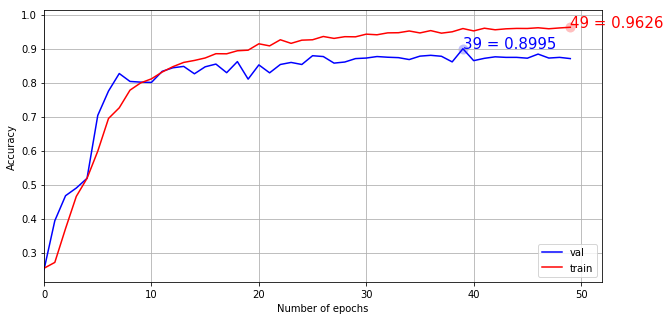

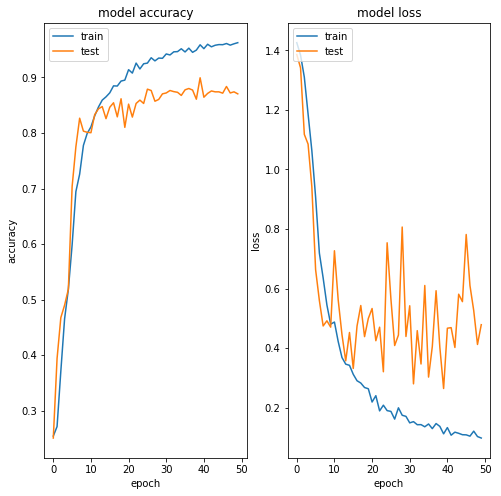

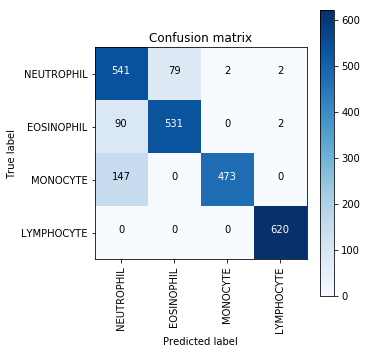

In [59]:
# use adadelta optimizer, lr=0.8, lr_decay=0.0, epochs=50

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adadelta', epochs=50, learning_rate=0.8, lr_decay=0.0)

Epoch 1/50
312/311 [==============================] - ETA: 5:03 - loss: 1.4194 - acc: 0.218 - ETA: 1:47 - loss: 3.6801 - acc: 0.250 - ETA: 1:24 - loss: 3.5573 - acc: 0.250 - ETA: 59s - loss: 2.8690 - acc: 0.244 - ETA: 47s - loss: 2.5083 - acc: 0.25 - ETA: 39s - loss: 2.2943 - acc: 0.23 - ETA: 34s - loss: 2.1459 - acc: 0.25 - ETA: 31s - loss: 2.0402 - acc: 0.25 - ETA: 29s - loss: 1.9599 - acc: 0.25 - ETA: 26s - loss: 1.8977 - acc: 0.25 - ETA: 26s - loss: 1.8724 - acc: 0.25 - ETA: 24s - loss: 1.8243 - acc: 0.25 - ETA: 23s - loss: 1.7877 - acc: 0.25 - ETA: 22s - loss: 1.7548 - acc: 0.26 - ETA: 21s - loss: 1.7283 - acc: 0.25 - ETA: 20s - loss: 1.7054 - acc: 0.24 - ETA: 19s - loss: 1.6848 - acc: 0.24 - ETA: 18s - loss: 1.6667 - acc: 0.25 - ETA: 18s - loss: 1.6585 - acc: 0.24 - ETA: 17s - loss: 1.6434 - acc: 0.24 - ETA: 17s - loss: 1.6298 - acc: 0.25 - ETA: 16s - loss: 1.6176 - acc: 0.25 - ETA: 16s - loss: 1.6066 - acc: 0.25 - ETA: 16s - loss: 1.5965 - acc: 0.25 - ETA: 15s - loss: 1.5873 - a

312/311 [==============================] - ETA: 12s - loss: 1.3861 - acc: 0.34 - ETA: 12s - loss: 1.3862 - acc: 0.28 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.26 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.26 - ETA: 11s - loss: 1.3864 - acc: 0.26 - ETA: 11s - loss: 1.3863 - acc: 0.26 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 11s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.26 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3868 - acc: 0.31 - ETA: 12s - loss: 1.3866 - acc: 0.29 - ETA: 11s - loss: 1.3861 - acc: 0.30 - ETA: 11s - loss: 1.3861 - acc: 0.31 - ETA: 11s - loss: 1.3861 - acc: 0.29 - ETA: 11s - loss: 1.3862 - acc: 0.27 - ETA: 11s - loss: 1.3862 - acc: 0.26 - ETA: 11s - loss: 1.3861 - acc: 0.27 - ETA: 10s - loss: 1.3859 - acc: 0.27 - ETA: 10s - loss: 1.3858 - acc: 0.28 - ETA: 10s - loss: 1.3859 - acc: 0.27 - ETA: 10s - loss: 1.3858 - acc: 0.27 - ETA: 10s - loss: 1.3859 - acc: 0.27 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3858 - acc: 0.27 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10

312/311 [==============================] - ETA: 11s - loss: 1.3868 - acc: 0.21 - ETA: 11s - loss: 1.3857 - acc: 0.29 - ETA: 11s - loss: 1.3854 - acc: 0.30 - ETA: 12s - loss: 1.3856 - acc: 0.29 - ETA: 11s - loss: 1.3858 - acc: 0.26 - ETA: 11s - loss: 1.3860 - acc: 0.25 - ETA: 11s - loss: 1.3859 - acc: 0.25 - ETA: 11s - loss: 1.3861 - acc: 0.25 - ETA: 11s - loss: 1.3859 - acc: 0.27 - ETA: 11s - loss: 1.3860 - acc: 0.26 - ETA: 11s - loss: 1.3861 - acc: 0.26 - ETA: 11s - loss: 1.3860 - acc: 0.25 - ETA: 11s - loss: 1.3860 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10

312/311 [==============================] - ETA: 11s - loss: 1.3867 - acc: 0.18 - ETA: 10s - loss: 1.3859 - acc: 0.21 - ETA: 10s - loss: 1.3867 - acc: 0.20 - ETA: 11s - loss: 1.3866 - acc: 0.21 - ETA: 11s - loss: 1.3865 - acc: 0.23 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.23 - ETA: 11s - loss: 1.3862 - acc: 0.23 - ETA: 10s - loss: 1.3861 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.23 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3865 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3864 - acc: 0.21 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.23 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.23 - ETA: 11s - loss: 1.3865 - acc: 0.23 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 11s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 11s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3863 - acc: 0.40 - ETA: 11s - loss: 1.3863 - acc: 0.27 - ETA: 11s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3863 - acc: 0.23 - ETA: 11s - loss: 1.3863 - acc: 0.23 - ETA: 11s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3861 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3868 - acc: 0.06 - ETA: 11s - loss: 1.3867 - acc: 0.14 - ETA: 11s - loss: 1.3867 - acc: 0.17 - ETA: 11s - loss: 1.3866 - acc: 0.21 - ETA: 11s - loss: 1.3866 - acc: 0.23 - ETA: 11s - loss: 1.3865 - acc: 0.24 - ETA: 11s - loss: 1.3867 - acc: 0.23 - ETA: 11s - loss: 1.3866 - acc: 0.23 - ETA: 11s - loss: 1.3866 - acc: 0.23 - ETA: 11s - loss: 1.3865 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 9s

312/311 [==============================] - ETA: 7s - loss: 1.3872 - acc: 0.281 - ETA: 14s - loss: 1.3872 - acc: 0.31 - ETA: 12s - loss: 1.3866 - acc: 0.30 - ETA: 13s - loss: 1.3865 - acc: 0.29 - ETA: 12s - loss: 1.3864 - acc: 0.29 - ETA: 12s - loss: 1.3864 - acc: 0.28 - ETA: 13s - loss: 1.3864 - acc: 0.27 - ETA: 12s - loss: 1.3863 - acc: 0.27 - ETA: 12s - loss: 1.3864 - acc: 0.27 - ETA: 13s - loss: 1.3864 - acc: 0.27 - ETA: 13s - loss: 1.3864 - acc: 0.27 - ETA: 12s - loss: 1.3863 - acc: 0.27 - ETA: 13s - loss: 1.3863 - acc: 0.27 - ETA: 12s - loss: 1.3862 - acc: 0.27 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.27 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3865 - acc: 0.25 - ETA: 11s - loss: 1.3865 - acc: 0.25 - ETA: 11s - loss: 1.3865 - acc: 0.25 - ETA: 11s - loss: 1.3865 - acc: 0.24 - ETA: 11

312/311 [==============================] - ETA: 9s - loss: 1.3851 - acc: 0.312 - ETA: 11s - loss: 1.3860 - acc: 0.23 - ETA: 13s - loss: 1.3867 - acc: 0.20 - ETA: 13s - loss: 1.3868 - acc: 0.20 - ETA: 13s - loss: 1.3866 - acc: 0.21 - ETA: 13s - loss: 1.3866 - acc: 0.22 - ETA: 13s - loss: 1.3865 - acc: 0.22 - ETA: 13s - loss: 1.3865 - acc: 0.21 - ETA: 13s - loss: 1.3867 - acc: 0.21 - ETA: 13s - loss: 1.3867 - acc: 0.20 - ETA: 14s - loss: 1.3867 - acc: 0.21 - ETA: 13s - loss: 1.3867 - acc: 0.21 - ETA: 13s - loss: 1.3867 - acc: 0.20 - ETA: 13s - loss: 1.3866 - acc: 0.21 - ETA: 13s - loss: 1.3866 - acc: 0.21 - ETA: 13s - loss: 1.3866 - acc: 0.21 - ETA: 13s - loss: 1.3866 - acc: 0.21 - ETA: 13s - loss: 1.3866 - acc: 0.21 - ETA: 13s - loss: 1.3865 - acc: 0.22 - ETA: 13s - loss: 1.3865 - acc: 0.22 - ETA: 12s - loss: 1.3865 - acc: 0.22 - ETA: 12s - loss: 1.3865 - acc: 0.22 - ETA: 12s - loss: 1.3865 - acc: 0.23 - ETA: 12s - loss: 1.3865 - acc: 0.23 - ETA: 12s - loss: 1.3865 - acc: 0.23 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 1.3865 - acc: 0.21 - ETA: 14s - loss: 1.3860 - acc: 0.26 - ETA: 13s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3861 - acc: 0.27 - ETA: 12s - loss: 1.3860 - acc: 0.28 - ETA: 13s - loss: 1.3862 - acc: 0.27 - ETA: 12s - loss: 1.3863 - acc: 0.27 - ETA: 12s - loss: 1.3865 - acc: 0.26 - ETA: 12s - loss: 1.3865 - acc: 0.25 - ETA: 13s - loss: 1.3865 - acc: 0.25 - ETA: 12s - loss: 1.3865 - acc: 0.25 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3865 - acc: 0.25 - ETA: 11s - loss: 1.3865 - acc: 0.25 - ETA: 11s - loss: 1.3865 - acc: 0.25 - ETA: 11

312/311 [==============================] - ETA: 14s - loss: 1.3865 - acc: 0.25 - ETA: 15s - loss: 1.3864 - acc: 0.21 - ETA: 12s - loss: 1.3861 - acc: 0.28 - ETA: 13s - loss: 1.3863 - acc: 0.26 - ETA: 13s - loss: 1.3863 - acc: 0.26 - ETA: 13s - loss: 1.3866 - acc: 0.25 - ETA: 13s - loss: 1.3865 - acc: 0.24 - ETA: 14s - loss: 1.3865 - acc: 0.24 - ETA: 14s - loss: 1.3865 - acc: 0.24 - ETA: 13s - loss: 1.3864 - acc: 0.25 - ETA: 13s - loss: 1.3863 - acc: 0.25 - ETA: 13s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 13s - loss: 1.3863 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12

312/311 [==============================] - ETA: 12s - loss: 1.3862 - acc: 0.21 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3865 - acc: 0.21 - ETA: 13s - loss: 1.3865 - acc: 0.20 - ETA: 12s - loss: 1.3865 - acc: 0.22 - ETA: 12s - loss: 1.3866 - acc: 0.22 - ETA: 13s - loss: 1.3865 - acc: 0.22 - ETA: 13s - loss: 1.3864 - acc: 0.24 - ETA: 13s - loss: 1.3863 - acc: 0.24 - ETA: 13s - loss: 1.3862 - acc: 0.25 - ETA: 12s - loss: 1.3861 - acc: 0.24 - ETA: 12s - loss: 1.3862 - acc: 0.24 - ETA: 12s - loss: 1.3862 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.23 - ETA: 12s - loss: 1.3864 - acc: 0.23 - ETA: 12s - loss: 1.3864 - acc: 0.23 - ETA: 12s - loss: 1.3864 - acc: 0.23 - ETA: 12s - loss: 1.3864 - acc: 0.23 - ETA: 12s - loss: 1.3864 - acc: 0.23 - ETA: 12

312/311 [==============================] - ETA: 14s - loss: 1.3863 - acc: 0.28 - ETA: 14s - loss: 1.3860 - acc: 0.30 - ETA: 14s - loss: 1.3864 - acc: 0.24 - ETA: 15s - loss: 1.3863 - acc: 0.23 - ETA: 14s - loss: 1.3861 - acc: 0.25 - ETA: 14s - loss: 1.3861 - acc: 0.25 - ETA: 13s - loss: 1.3862 - acc: 0.23 - ETA: 13s - loss: 1.3863 - acc: 0.22 - ETA: 13s - loss: 1.3864 - acc: 0.22 - ETA: 12s - loss: 1.3863 - acc: 0.22 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3862 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11

312/311 [==============================] - ETA: 11s - loss: 1.3857 - acc: 0.21 - ETA: 12s - loss: 1.3852 - acc: 0.29 - ETA: 13s - loss: 1.3856 - acc: 0.28 - ETA: 13s - loss: 1.3862 - acc: 0.25 - ETA: 13s - loss: 1.3862 - acc: 0.25 - ETA: 13s - loss: 1.3861 - acc: 0.26 - ETA: 14s - loss: 1.3863 - acc: 0.25 - ETA: 14s - loss: 1.3862 - acc: 0.26 - ETA: 14s - loss: 1.3862 - acc: 0.26 - ETA: 13s - loss: 1.3861 - acc: 0.26 - ETA: 14s - loss: 1.3862 - acc: 0.25 - ETA: 13s - loss: 1.3862 - acc: 0.25 - ETA: 13s - loss: 1.3863 - acc: 0.25 - ETA: 13s - loss: 1.3863 - acc: 0.25 - ETA: 13s - loss: 1.3863 - acc: 0.25 - ETA: 13s - loss: 1.3862 - acc: 0.26 - ETA: 12s - loss: 1.3862 - acc: 0.26 - ETA: 12s - loss: 1.3862 - acc: 0.26 - ETA: 12s - loss: 1.3862 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3864 - acc: 0.24 - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 12s - loss: 1.3863 - acc: 0.25 - ETA: 12

312/311 [==============================] - ETA: 12s - loss: 1.3876 - acc: 0.28 - ETA: 11s - loss: 1.3870 - acc: 0.28 - ETA: 11s - loss: 1.3863 - acc: 0.27 - ETA: 11s - loss: 1.3864 - acc: 0.26 - ETA: 11s - loss: 1.3860 - acc: 0.26 - ETA: 11s - loss: 1.3861 - acc: 0.25 - ETA: 11s - loss: 1.3860 - acc: 0.25 - ETA: 11s - loss: 1.3861 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3860 - acc: 0.25 - ETA: 10

312/311 [==============================] - ETA: 13s - loss: 1.3857 - acc: 0.28 - ETA: 12s - loss: 1.3856 - acc: 0.31 - ETA: 11s - loss: 1.3859 - acc: 0.28 - ETA: 10s - loss: 1.3857 - acc: 0.28 - ETA: 11s - loss: 1.3857 - acc: 0.29 - ETA: 10s - loss: 1.3856 - acc: 0.30 - ETA: 11s - loss: 1.3854 - acc: 0.31 - ETA: 11s - loss: 1.3859 - acc: 0.28 - ETA: 10s - loss: 1.3859 - acc: 0.28 - ETA: 10s - loss: 1.3857 - acc: 0.28 - ETA: 10s - loss: 1.3857 - acc: 0.28 - ETA: 10s - loss: 1.3858 - acc: 0.28 - ETA: 10s - loss: 1.3859 - acc: 0.28 - ETA: 10s - loss: 1.3858 - acc: 0.28 - ETA: 10s - loss: 1.3860 - acc: 0.27 - ETA: 10s - loss: 1.3861 - acc: 0.27 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.27 - ETA: 10s - loss: 1.3861 - acc: 0.27 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10

312/311 [==============================] - ETA: 13s - loss: 1.3834 - acc: 0.46 - ETA: 12s - loss: 1.3850 - acc: 0.36 - ETA: 11s - loss: 1.3850 - acc: 0.34 - ETA: 11s - loss: 1.3856 - acc: 0.29 - ETA: 11s - loss: 1.3860 - acc: 0.27 - ETA: 11s - loss: 1.3859 - acc: 0.27 - ETA: 11s - loss: 1.3862 - acc: 0.26 - ETA: 11s - loss: 1.3866 - acc: 0.24 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3854 - acc: 0.31 - ETA: 11s - loss: 1.3863 - acc: 0.22 - ETA: 10s - loss: 1.3863 - acc: 0.21 - ETA: 11s - loss: 1.3861 - acc: 0.21 - ETA: 11s - loss: 1.3862 - acc: 0.22 - ETA: 11s - loss: 1.3863 - acc: 0.22 - ETA: 11s - loss: 1.3862 - acc: 0.24 - ETA: 11s - loss: 1.3861 - acc: 0.26 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3862 - acc: 0.24 - ETA: 10

312/311 [==============================] - ETA: 13s - loss: 1.3869 - acc: 0.18 - ETA: 11s - loss: 1.3870 - acc: 0.19 - ETA: 11s - loss: 1.3866 - acc: 0.22 - ETA: 11s - loss: 1.3868 - acc: 0.20 - ETA: 11s - loss: 1.3867 - acc: 0.21 - ETA: 11s - loss: 1.3867 - acc: 0.21 - ETA: 11s - loss: 1.3865 - acc: 0.23 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 11s - loss: 1.3865 - acc: 0.24 - ETA: 11s - loss: 1.3865 - acc: 0.24 - ETA: 11s - loss: 1.3865 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3865 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3851 - acc: 0.37 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.23 - ETA: 11s - loss: 1.3866 - acc: 0.23 - ETA: 11s - loss: 1.3867 - acc: 0.21 - ETA: 11s - loss: 1.3868 - acc: 0.21 - ETA: 11s - loss: 1.3867 - acc: 0.21 - ETA: 11s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3865 - acc: 0.23 - ETA: 11s - loss: 1.3864 - acc: 0.23 - ETA: 11s - loss: 1.3865 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3865 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3865 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3865 - acc: 0.23 - ETA: 10s - loss: 1.3865 - acc: 0.23 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3851 - acc: 0.28 - ETA: 10s - loss: 1.3862 - acc: 0.22 - ETA: 12s - loss: 1.3867 - acc: 0.22 - ETA: 11s - loss: 1.3866 - acc: 0.21 - ETA: 11s - loss: 1.3870 - acc: 0.21 - ETA: 11s - loss: 1.3869 - acc: 0.22 - ETA: 11s - loss: 1.3867 - acc: 0.23 - ETA: 11s - loss: 1.3866 - acc: 0.24 - ETA: 11s - loss: 1.3868 - acc: 0.24 - ETA: 10s - loss: 1.3867 - acc: 0.24 - ETA: 10s - loss: 1.3867 - acc: 0.23 - ETA: 10s - loss: 1.3865 - acc: 0.24 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 10s - loss: 1.3866 - acc: 0.22 - ETA: 9s

312/311 [==============================] - ETA: 11s - loss: 1.3867 - acc: 0.12 - ETA: 11s - loss: 1.3866 - acc: 0.18 - ETA: 11s - loss: 1.3864 - acc: 0.22 - ETA: 11s - loss: 1.3864 - acc: 0.23 - ETA: 11s - loss: 1.3864 - acc: 0.22 - ETA: 11s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3864 - acc: 0.23 - ETA: 11s - loss: 1.3864 - acc: 0.22 - ETA: 10s - loss: 1.3864 - acc: 0.22 - ETA: 11s - loss: 1.3864 - acc: 0.22 - ETA: 10s - loss: 1.3864 - acc: 0.22 - ETA: 10s - loss: 1.3864 - acc: 0.23 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10

312/311 [==============================] - ETA: 12s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.28 - ETA: 11s - loss: 1.3861 - acc: 0.28 - ETA: 11s - loss: 1.3862 - acc: 0.28 - ETA: 11s - loss: 1.3863 - acc: 0.26 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 11s - loss: 1.3864 - acc: 0.24 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 11s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.24 - ETA: 10

312/311 [==============================] - ETA: 11s - loss: 1.3862 - acc: 0.25 - ETA: 10s - loss: 1.3862 - acc: 0.26 - ETA: 11s - loss: 1.3862 - acc: 0.26 - ETA: 12s - loss: 1.3863 - acc: 0.26 - ETA: 11s - loss: 1.3862 - acc: 0.27 - ETA: 11s - loss: 1.3861 - acc: 0.28 - ETA: 11s - loss: 1.3862 - acc: 0.27 - ETA: 11s - loss: 1.3861 - acc: 0.27 - ETA: 11s - loss: 1.3861 - acc: 0.27 - ETA: 11s - loss: 1.3863 - acc: 0.26 - ETA: 11s - loss: 1.3863 - acc: 0.26 - ETA: 11s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.24 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10s - loss: 1.3863 - acc: 0.26 - ETA: 10s - loss: 1.3864 - acc: 0.25 - ETA: 10

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



             precision    recall  f1-score   support

 NEUTROPHIL       0.00      0.00      0.00       624
 EOSINOPHIL       0.25      1.00      0.40       623
   MONOCYTE       0.00      0.00      0.00       620
 LYMPHOCYTE       0.00      0.00      0.00       620

avg / total       0.06      0.25      0.10      2487



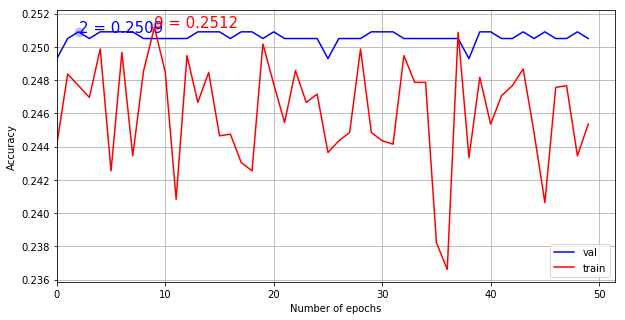

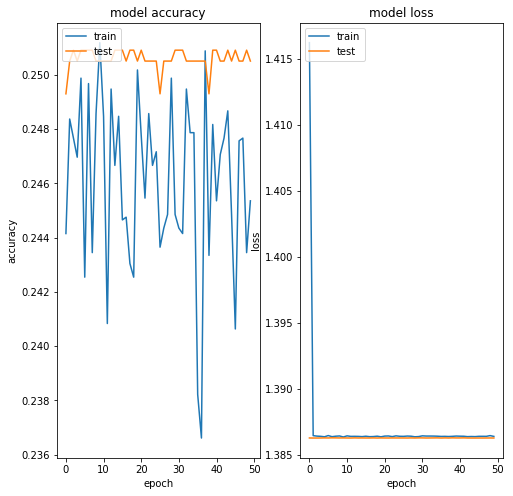

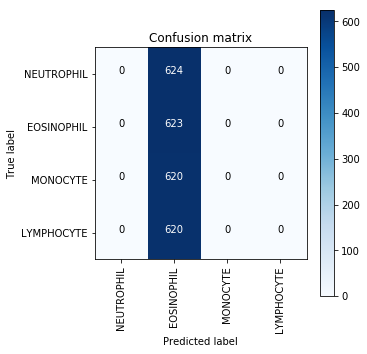

In [47]:
# use adam optimizer

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adam', learning_rate=0.001, lr_decay=0.0)

Epoch 1/50
312/311 [==============================] - ETA: 4:21 - loss: 1.3918 - acc: 0.187 - ETA: 1:32 - loss: 1.4187 - acc: 0.208 - ETA: 58s - loss: 1.4062 - acc: 0.243 - ETA: 44s - loss: 1.4065 - acc: 0.23 - ETA: 36s - loss: 1.4073 - acc: 0.24 - ETA: 31s - loss: 1.4028 - acc: 0.25 - ETA: 27s - loss: 1.4081 - acc: 0.23 - ETA: 23s - loss: 1.4090 - acc: 0.22 - ETA: 21s - loss: 1.4091 - acc: 0.23 - ETA: 20s - loss: 1.4071 - acc: 0.23 - ETA: 19s - loss: 1.4029 - acc: 0.24 - ETA: 18s - loss: 1.4018 - acc: 0.24 - ETA: 17s - loss: 1.4034 - acc: 0.24 - ETA: 16s - loss: 1.4024 - acc: 0.24 - ETA: 15s - loss: 1.4019 - acc: 0.24 - ETA: 15s - loss: 1.4024 - acc: 0.22 - ETA: 14s - loss: 1.4024 - acc: 0.22 - ETA: 14s - loss: 1.4005 - acc: 0.23 - ETA: 13s - loss: 1.3997 - acc: 0.23 - ETA: 13s - loss: 1.3986 - acc: 0.24 - ETA: 13s - loss: 1.3979 - acc: 0.23 - ETA: 12s - loss: 1.3978 - acc: 0.23 - ETA: 12s - loss: 1.3974 - acc: 0.23 - ETA: 12s - loss: 1.3970 - acc: 0.24 - ETA: 11s - loss: 1.3967 - acc

312/311 [==============================] - ETA: 9s - loss: 1.3838 - acc: 0.281 - ETA: 9s - loss: 1.3854 - acc: 0.260 - ETA: 8s - loss: 1.3881 - acc: 0.262 - ETA: 8s - loss: 1.3872 - acc: 0.282 - ETA: 8s - loss: 1.3872 - acc: 0.273 - ETA: 8s - loss: 1.3867 - acc: 0.274 - ETA: 8s - loss: 1.3864 - acc: 0.284 - ETA: 8s - loss: 1.3861 - acc: 0.284 - ETA: 8s - loss: 1.3866 - acc: 0.275 - ETA: 8s - loss: 1.3861 - acc: 0.275 - ETA: 8s - loss: 1.3862 - acc: 0.271 - ETA: 8s - loss: 1.3862 - acc: 0.270 - ETA: 8s - loss: 1.3862 - acc: 0.269 - ETA: 8s - loss: 1.3862 - acc: 0.270 - ETA: 8s - loss: 1.3861 - acc: 0.275 - ETA: 8s - loss: 1.3861 - acc: 0.272 - ETA: 8s - loss: 1.3859 - acc: 0.272 - ETA: 8s - loss: 1.3857 - acc: 0.272 - ETA: 7s - loss: 1.3857 - acc: 0.270 - ETA: 7s - loss: 1.3858 - acc: 0.270 - ETA: 7s - loss: 1.3859 - acc: 0.271 - ETA: 7s - loss: 1.3857 - acc: 0.272 - ETA: 7s - loss: 1.3857 - acc: 0.273 - ETA: 7s - loss: 1.3858 - acc: 0.273 - ETA: 7s - loss: 1.3858 - acc: 0.271 - ETA: 7s

312/311 [==============================] - ETA: 11s - loss: 1.3887 - acc: 0.34 - ETA: 10s - loss: 1.3866 - acc: 0.29 - ETA: 9s - loss: 1.3856 - acc: 0.2938 - ETA: 9s - loss: 1.3825 - acc: 0.325 - ETA: 9s - loss: 1.3820 - acc: 0.309 - ETA: 9s - loss: 1.3828 - acc: 0.286 - ETA: 8s - loss: 1.3818 - acc: 0.290 - ETA: 8s - loss: 1.3779 - acc: 0.304 - ETA: 8s - loss: 1.3821 - acc: 0.286 - ETA: 8s - loss: 1.3822 - acc: 0.282 - ETA: 8s - loss: 1.3817 - acc: 0.287 - ETA: 8s - loss: 1.3822 - acc: 0.286 - ETA: 8s - loss: 1.3827 - acc: 0.283 - ETA: 8s - loss: 1.3827 - acc: 0.284 - ETA: 8s - loss: 1.3824 - acc: 0.288 - ETA: 8s - loss: 1.3817 - acc: 0.297 - ETA: 8s - loss: 1.3815 - acc: 0.297 - ETA: 8s - loss: 1.3813 - acc: 0.299 - ETA: 8s - loss: 1.3816 - acc: 0.295 - ETA: 8s - loss: 1.3813 - acc: 0.295 - ETA: 8s - loss: 1.3810 - acc: 0.296 - ETA: 7s - loss: 1.3810 - acc: 0.290 - ETA: 7s - loss: 1.3811 - acc: 0.288 - ETA: 7s - loss: 1.3817 - acc: 0.285 - ETA: 7s - loss: 1.3818 - acc: 0.288 - ETA: 7

312/311 [==============================] - ETA: 9s - loss: 1.3760 - acc: 0.343 - ETA: 9s - loss: 1.3904 - acc: 0.265 - ETA: 8s - loss: 1.3915 - acc: 0.255 - ETA: 9s - loss: 1.3860 - acc: 0.285 - ETA: 8s - loss: 1.3853 - acc: 0.268 - ETA: 8s - loss: 1.3856 - acc: 0.263 - ETA: 8s - loss: 1.3854 - acc: 0.267 - ETA: 8s - loss: 1.3868 - acc: 0.244 - ETA: 8s - loss: 1.3860 - acc: 0.253 - ETA: 8s - loss: 1.3850 - acc: 0.264 - ETA: 8s - loss: 1.3850 - acc: 0.267 - ETA: 8s - loss: 1.3870 - acc: 0.264 - ETA: 8s - loss: 1.3863 - acc: 0.268 - ETA: 8s - loss: 1.3862 - acc: 0.267 - ETA: 8s - loss: 1.3869 - acc: 0.260 - ETA: 8s - loss: 1.3870 - acc: 0.258 - ETA: 8s - loss: 1.3866 - acc: 0.260 - ETA: 8s - loss: 1.3870 - acc: 0.255 - ETA: 8s - loss: 1.3862 - acc: 0.258 - ETA: 7s - loss: 1.3868 - acc: 0.257 - ETA: 7s - loss: 1.3864 - acc: 0.258 - ETA: 7s - loss: 1.3863 - acc: 0.257 - ETA: 7s - loss: 1.3859 - acc: 0.260 - ETA: 7s - loss: 1.3856 - acc: 0.264 - ETA: 7s - loss: 1.3855 - acc: 0.267 - ETA: 7s

312/311 [==============================] - ETA: 7s - loss: 1.1892 - acc: 0.500 - ETA: 10s - loss: 1.2594 - acc: 0.40 - ETA: 10s - loss: 1.2320 - acc: 0.41 - ETA: 10s - loss: 1.2590 - acc: 0.40 - ETA: 9s - loss: 1.2502 - acc: 0.4236 - ETA: 9s - loss: 1.2631 - acc: 0.426 - ETA: 9s - loss: 1.2732 - acc: 0.420 - ETA: 9s - loss: 1.2676 - acc: 0.418 - ETA: 9s - loss: 1.2686 - acc: 0.422 - ETA: 9s - loss: 1.2751 - acc: 0.416 - ETA: 9s - loss: 1.2666 - acc: 0.431 - ETA: 9s - loss: 1.2766 - acc: 0.421 - ETA: 8s - loss: 1.2782 - acc: 0.411 - ETA: 8s - loss: 1.2794 - acc: 0.406 - ETA: 8s - loss: 1.2827 - acc: 0.400 - ETA: 8s - loss: 1.2812 - acc: 0.403 - ETA: 8s - loss: 1.2782 - acc: 0.401 - ETA: 8s - loss: 1.2746 - acc: 0.404 - ETA: 8s - loss: 1.3061 - acc: 0.403 - ETA: 8s - loss: 1.3373 - acc: 0.397 - ETA: 8s - loss: 1.3408 - acc: 0.388 - ETA: 8s - loss: 1.3426 - acc: 0.385 - ETA: 8s - loss: 1.3443 - acc: 0.378 - ETA: 8s - loss: 1.3453 - acc: 0.377 - ETA: 8s - loss: 1.3486 - acc: 0.370 - ETA: 7

312/311 [==============================] - ETA: 10s - loss: 1.3845 - acc: 0.28 - ETA: 10s - loss: 1.3828 - acc: 0.26 - ETA: 9s - loss: 1.3816 - acc: 0.2687 - ETA: 9s - loss: 1.3849 - acc: 0.276 - ETA: 9s - loss: 1.3835 - acc: 0.291 - ETA: 10s - loss: 1.3823 - acc: 0.29 - ETA: 10s - loss: 1.3851 - acc: 0.26 - ETA: 10s - loss: 1.3841 - acc: 0.27 - ETA: 10s - loss: 1.3838 - acc: 0.28 - ETA: 9s - loss: 1.3848 - acc: 0.2795 - ETA: 9s - loss: 1.3841 - acc: 0.289 - ETA: 9s - loss: 1.3847 - acc: 0.284 - ETA: 9s - loss: 1.3840 - acc: 0.282 - ETA: 9s - loss: 1.3832 - acc: 0.288 - ETA: 9s - loss: 1.3830 - acc: 0.293 - ETA: 9s - loss: 1.3835 - acc: 0.288 - ETA: 9s - loss: 1.3836 - acc: 0.284 - ETA: 9s - loss: 1.3834 - acc: 0.286 - ETA: 9s - loss: 1.3834 - acc: 0.288 - ETA: 9s - loss: 1.3837 - acc: 0.289 - ETA: 9s - loss: 1.3838 - acc: 0.290 - ETA: 9s - loss: 1.3839 - acc: 0.290 - ETA: 9s - loss: 1.3840 - acc: 0.286 - ETA: 9s - loss: 1.3842 - acc: 0.282 - ETA: 9s - loss: 1.3838 - acc: 0.284 - ETA: 

312/311 [==============================] - ETA: 9s - loss: 1.4002 - acc: 0.218 - ETA: 9s - loss: 1.3826 - acc: 0.281 - ETA: 9s - loss: 1.3774 - acc: 0.306 - ETA: 9s - loss: 1.3782 - acc: 0.303 - ETA: 8s - loss: 1.3772 - acc: 0.302 - ETA: 8s - loss: 1.3744 - acc: 0.318 - ETA: 8s - loss: 1.3691 - acc: 0.331 - ETA: 8s - loss: 1.3704 - acc: 0.331 - ETA: 8s - loss: 1.3714 - acc: 0.319 - ETA: 8s - loss: 1.3695 - acc: 0.317 - ETA: 8s - loss: 1.3711 - acc: 0.319 - ETA: 9s - loss: 1.3716 - acc: 0.308 - ETA: 8s - loss: 1.3727 - acc: 0.301 - ETA: 9s - loss: 1.3735 - acc: 0.298 - ETA: 9s - loss: 1.3735 - acc: 0.297 - ETA: 8s - loss: 1.3734 - acc: 0.302 - ETA: 9s - loss: 1.3727 - acc: 0.305 - ETA: 9s - loss: 1.3734 - acc: 0.300 - ETA: 9s - loss: 1.3738 - acc: 0.301 - ETA: 9s - loss: 1.3741 - acc: 0.296 - ETA: 9s - loss: 1.3742 - acc: 0.297 - ETA: 9s - loss: 1.3740 - acc: 0.296 - ETA: 8s - loss: 1.3736 - acc: 0.299 - ETA: 8s - loss: 1.3726 - acc: 0.303 - ETA: 8s - loss: 1.3732 - acc: 0.304 - ETA: 8s

312/311 [==============================] - ETA: 9s - loss: 1.3676 - acc: 0.343 - ETA: 9s - loss: 1.3717 - acc: 0.312 - ETA: 10s - loss: 1.3617 - acc: 0.31 - ETA: 10s - loss: 1.3526 - acc: 0.31 - ETA: 9s - loss: 1.3596 - acc: 0.3125 - ETA: 9s - loss: 1.3616 - acc: 0.312 - ETA: 9s - loss: 1.3604 - acc: 0.317 - ETA: 9s - loss: 1.3532 - acc: 0.334 - ETA: 9s - loss: 1.3486 - acc: 0.342 - ETA: 9s - loss: 1.3485 - acc: 0.339 - ETA: 9s - loss: 1.3502 - acc: 0.335 - ETA: 9s - loss: 1.3504 - acc: 0.335 - ETA: 9s - loss: 1.3480 - acc: 0.343 - ETA: 9s - loss: 1.3464 - acc: 0.342 - ETA: 9s - loss: 1.3515 - acc: 0.337 - ETA: 9s - loss: 1.3503 - acc: 0.342 - ETA: 9s - loss: 1.3522 - acc: 0.336 - ETA: 8s - loss: 1.3541 - acc: 0.335 - ETA: 8s - loss: 1.3548 - acc: 0.337 - ETA: 8s - loss: 1.3543 - acc: 0.343 - ETA: 8s - loss: 1.3543 - acc: 0.343 - ETA: 8s - loss: 1.3544 - acc: 0.341 - ETA: 8s - loss: 1.3556 - acc: 0.341 - ETA: 8s - loss: 1.3577 - acc: 0.336 - ETA: 8s - loss: 1.3579 - acc: 0.335 - ETA: 8

312/311 [==============================] - ETA: 8s - loss: 1.3931 - acc: 0.156 - ETA: 8s - loss: 1.3713 - acc: 0.250 - ETA: 8s - loss: 1.3585 - acc: 0.306 - ETA: 8s - loss: 1.3637 - acc: 0.299 - ETA: 8s - loss: 1.3698 - acc: 0.298 - ETA: 8s - loss: 1.3602 - acc: 0.321 - ETA: 8s - loss: 1.3546 - acc: 0.326 - ETA: 8s - loss: 1.3503 - acc: 0.343 - ETA: 8s - loss: 1.3539 - acc: 0.345 - ETA: 8s - loss: 1.3537 - acc: 0.342 - ETA: 8s - loss: 1.3522 - acc: 0.340 - ETA: 8s - loss: 1.3540 - acc: 0.335 - ETA: 8s - loss: 1.3511 - acc: 0.335 - ETA: 8s - loss: 1.3492 - acc: 0.334 - ETA: 8s - loss: 1.3449 - acc: 0.339 - ETA: 8s - loss: 1.3469 - acc: 0.334 - ETA: 8s - loss: 1.3512 - acc: 0.327 - ETA: 8s - loss: 1.3518 - acc: 0.321 - ETA: 8s - loss: 1.3528 - acc: 0.326 - ETA: 7s - loss: 1.3520 - acc: 0.330 - ETA: 7s - loss: 1.3523 - acc: 0.330 - ETA: 7s - loss: 1.3517 - acc: 0.332 - ETA: 7s - loss: 1.3514 - acc: 0.331 - ETA: 7s - loss: 1.3505 - acc: 0.331 - ETA: 7s - loss: 1.3493 - acc: 0.333 - ETA: 7s

312/311 [==============================] - ETA: 8s - loss: 1.3265 - acc: 0.343 - ETA: 8s - loss: 1.3483 - acc: 0.375 - ETA: 9s - loss: 1.3400 - acc: 0.359 - ETA: 8s - loss: 1.3156 - acc: 0.386 - ETA: 8s - loss: 1.3249 - acc: 0.387 - ETA: 8s - loss: 1.3211 - acc: 0.401 - ETA: 8s - loss: 1.3181 - acc: 0.395 - ETA: 8s - loss: 1.3140 - acc: 0.400 - ETA: 8s - loss: 1.3079 - acc: 0.404 - ETA: 8s - loss: 1.3009 - acc: 0.409 - ETA: 8s - loss: 1.3056 - acc: 0.403 - ETA: 8s - loss: 1.3003 - acc: 0.411 - ETA: 8s - loss: 1.3037 - acc: 0.405 - ETA: 8s - loss: 1.3072 - acc: 0.399 - ETA: 8s - loss: 1.3099 - acc: 0.391 - ETA: 8s - loss: 1.3112 - acc: 0.387 - ETA: 8s - loss: 1.3108 - acc: 0.389 - ETA: 8s - loss: 1.3082 - acc: 0.390 - ETA: 8s - loss: 1.3071 - acc: 0.389 - ETA: 8s - loss: 1.3071 - acc: 0.390 - ETA: 7s - loss: 1.3056 - acc: 0.389 - ETA: 7s - loss: 1.3070 - acc: 0.387 - ETA: 7s - loss: 1.3072 - acc: 0.387 - ETA: 7s - loss: 1.3066 - acc: 0.383 - ETA: 7s - loss: 1.3056 - acc: 0.382 - ETA: 7s

312/311 [==============================] - ETA: 8s - loss: 1.1815 - acc: 0.406 - ETA: 8s - loss: 1.2043 - acc: 0.445 - ETA: 8s - loss: 1.2184 - acc: 0.458 - ETA: 8s - loss: 1.2502 - acc: 0.433 - ETA: 8s - loss: 1.2504 - acc: 0.421 - ETA: 8s - loss: 1.2512 - acc: 0.413 - ETA: 8s - loss: 1.2536 - acc: 0.422 - ETA: 8s - loss: 1.2607 - acc: 0.415 - ETA: 8s - loss: 1.2626 - acc: 0.414 - ETA: 8s - loss: 1.2638 - acc: 0.412 - ETA: 8s - loss: 1.2603 - acc: 0.413 - ETA: 8s - loss: 1.2602 - acc: 0.413 - ETA: 8s - loss: 1.2539 - acc: 0.427 - ETA: 8s - loss: 1.2483 - acc: 0.428 - ETA: 8s - loss: 1.2505 - acc: 0.429 - ETA: 8s - loss: 1.2514 - acc: 0.426 - ETA: 8s - loss: 1.2446 - acc: 0.428 - ETA: 8s - loss: 1.2476 - acc: 0.424 - ETA: 8s - loss: 1.2500 - acc: 0.422 - ETA: 8s - loss: 1.2501 - acc: 0.420 - ETA: 8s - loss: 1.2562 - acc: 0.415 - ETA: 8s - loss: 1.2529 - acc: 0.417 - ETA: 8s - loss: 1.2532 - acc: 0.414 - ETA: 7s - loss: 1.2496 - acc: 0.418 - ETA: 7s - loss: 1.2549 - acc: 0.416 - ETA: 7s

312/311 [==============================] - ETA: 13s - loss: 1.2495 - acc: 0.40 - ETA: 10s - loss: 1.2458 - acc: 0.39 - ETA: 9s - loss: 1.2395 - acc: 0.4500 - ETA: 9s - loss: 1.2413 - acc: 0.459 - ETA: 9s - loss: 1.2254 - acc: 0.447 - ETA: 9s - loss: 1.2634 - acc: 0.403 - ETA: 9s - loss: 1.2544 - acc: 0.415 - ETA: 8s - loss: 1.2394 - acc: 0.433 - ETA: 8s - loss: 1.2176 - acc: 0.448 - ETA: 8s - loss: 1.2066 - acc: 0.458 - ETA: 8s - loss: 1.2146 - acc: 0.452 - ETA: 8s - loss: 1.2065 - acc: 0.459 - ETA: 8s - loss: 1.2034 - acc: 0.458 - ETA: 8s - loss: 1.2068 - acc: 0.458 - ETA: 8s - loss: 1.2029 - acc: 0.460 - ETA: 8s - loss: 1.1958 - acc: 0.462 - ETA: 8s - loss: 1.1999 - acc: 0.462 - ETA: 8s - loss: 1.2007 - acc: 0.464 - ETA: 8s - loss: 1.1946 - acc: 0.464 - ETA: 8s - loss: 1.1970 - acc: 0.459 - ETA: 8s - loss: 1.1961 - acc: 0.459 - ETA: 8s - loss: 1.2038 - acc: 0.457 - ETA: 7s - loss: 1.2067 - acc: 0.456 - ETA: 7s - loss: 1.2063 - acc: 0.457 - ETA: 7s - loss: 1.2068 - acc: 0.456 - ETA: 7

312/311 [==============================] - ETA: 8s - loss: 1.2942 - acc: 0.406 - ETA: 8s - loss: 1.2412 - acc: 0.395 - ETA: 9s - loss: 1.2564 - acc: 0.406 - ETA: 8s - loss: 1.2374 - acc: 0.437 - ETA: 8s - loss: 1.2563 - acc: 0.409 - ETA: 8s - loss: 1.2536 - acc: 0.406 - ETA: 8s - loss: 1.2514 - acc: 0.415 - ETA: 8s - loss: 1.2530 - acc: 0.414 - ETA: 8s - loss: 1.2591 - acc: 0.415 - ETA: 8s - loss: 1.2571 - acc: 0.417 - ETA: 8s - loss: 1.2530 - acc: 0.421 - ETA: 8s - loss: 1.2551 - acc: 0.423 - ETA: 8s - loss: 1.2554 - acc: 0.421 - ETA: 8s - loss: 1.2515 - acc: 0.424 - ETA: 8s - loss: 1.2454 - acc: 0.421 - ETA: 8s - loss: 1.2469 - acc: 0.423 - ETA: 8s - loss: 1.2462 - acc: 0.425 - ETA: 8s - loss: 1.2496 - acc: 0.423 - ETA: 8s - loss: 1.2519 - acc: 0.417 - ETA: 8s - loss: 1.2533 - acc: 0.415 - ETA: 8s - loss: 1.2526 - acc: 0.419 - ETA: 7s - loss: 1.2483 - acc: 0.421 - ETA: 7s - loss: 1.2583 - acc: 0.418 - ETA: 7s - loss: 1.2577 - acc: 0.416 - ETA: 7s - loss: 1.2587 - acc: 0.417 - ETA: 7s

312/311 [==============================] - ETA: 9s - loss: 1.1528 - acc: 0.437 - ETA: 8s - loss: 1.0833 - acc: 0.531 - ETA: 8s - loss: 1.1021 - acc: 0.543 - ETA: 8s - loss: 1.1279 - acc: 0.526 - ETA: 8s - loss: 1.0994 - acc: 0.534 - ETA: 8s - loss: 1.0905 - acc: 0.539 - ETA: 8s - loss: 1.1024 - acc: 0.524 - ETA: 8s - loss: 1.1158 - acc: 0.510 - ETA: 8s - loss: 1.1201 - acc: 0.503 - ETA: 8s - loss: 1.1226 - acc: 0.503 - ETA: 8s - loss: 1.1279 - acc: 0.495 - ETA: 8s - loss: 1.1297 - acc: 0.491 - ETA: 8s - loss: 1.1343 - acc: 0.483 - ETA: 8s - loss: 1.1406 - acc: 0.481 - ETA: 8s - loss: 1.1473 - acc: 0.475 - ETA: 8s - loss: 1.1568 - acc: 0.471 - ETA: 8s - loss: 1.1532 - acc: 0.473 - ETA: 8s - loss: 1.1617 - acc: 0.468 - ETA: 8s - loss: 1.1589 - acc: 0.466 - ETA: 8s - loss: 1.1617 - acc: 0.466 - ETA: 7s - loss: 1.1661 - acc: 0.464 - ETA: 7s - loss: 1.1623 - acc: 0.465 - ETA: 7s - loss: 1.1639 - acc: 0.462 - ETA: 7s - loss: 1.1630 - acc: 0.460 - ETA: 7s - loss: 1.1664 - acc: 0.457 - ETA: 7s

312/311 [==============================] - ETA: 12s - loss: 1.1742 - acc: 0.50 - ETA: 10s - loss: 1.1846 - acc: 0.45 - ETA: 9s - loss: 1.2343 - acc: 0.4375 - ETA: 9s - loss: 1.1554 - acc: 0.500 - ETA: 9s - loss: 1.1351 - acc: 0.493 - ETA: 9s - loss: 1.1305 - acc: 0.490 - ETA: 8s - loss: 1.1198 - acc: 0.496 - ETA: 8s - loss: 1.1070 - acc: 0.502 - ETA: 8s - loss: 1.1011 - acc: 0.507 - ETA: 8s - loss: 1.1113 - acc: 0.505 - ETA: 8s - loss: 1.0999 - acc: 0.513 - ETA: 8s - loss: 1.0929 - acc: 0.518 - ETA: 8s - loss: 1.0910 - acc: 0.517 - ETA: 8s - loss: 1.0942 - acc: 0.519 - ETA: 8s - loss: 1.1065 - acc: 0.514 - ETA: 8s - loss: 1.1160 - acc: 0.500 - ETA: 8s - loss: 1.1137 - acc: 0.506 - ETA: 8s - loss: 1.1200 - acc: 0.502 - ETA: 8s - loss: 1.1165 - acc: 0.505 - ETA: 8s - loss: 1.1263 - acc: 0.498 - ETA: 8s - loss: 1.1275 - acc: 0.496 - ETA: 7s - loss: 1.1242 - acc: 0.494 - ETA: 7s - loss: 1.1216 - acc: 0.497 - ETA: 7s - loss: 1.1164 - acc: 0.498 - ETA: 7s - loss: 1.1131 - acc: 0.500 - ETA: 7

312/311 [==============================] - ETA: 4s - loss: 1.4545 - acc: 0.312 - ETA: 9s - loss: 1.4992 - acc: 0.270 - ETA: 9s - loss: 1.4997 - acc: 0.256 - ETA: 10s - loss: 1.5044 - acc: 0.23 - ETA: 9s - loss: 1.4947 - acc: 0.2326 - ETA: 10s - loss: 1.4830 - acc: 0.23 - ETA: 9s - loss: 1.4704 - acc: 0.2452 - ETA: 9s - loss: 1.4640 - acc: 0.237 - ETA: 9s - loss: 1.4607 - acc: 0.242 - ETA: 9s - loss: 1.4556 - acc: 0.243 - ETA: 9s - loss: 1.4550 - acc: 0.244 - ETA: 10s - loss: 1.4502 - acc: 0.24 - ETA: 10s - loss: 1.4497 - acc: 0.24 - ETA: 10s - loss: 1.4518 - acc: 0.23 - ETA: 10s - loss: 1.4495 - acc: 0.23 - ETA: 10s - loss: 1.4485 - acc: 0.23 - ETA: 10s - loss: 1.4449 - acc: 0.23 - ETA: 10s - loss: 1.4467 - acc: 0.24 - ETA: 10s - loss: 1.4462 - acc: 0.24 - ETA: 10s - loss: 1.4442 - acc: 0.24 - ETA: 9s - loss: 1.4460 - acc: 0.2401 - ETA: 9s - loss: 1.4461 - acc: 0.240 - ETA: 9s - loss: 1.4459 - acc: 0.244 - ETA: 9s - loss: 1.4443 - acc: 0.245 - ETA: 9s - loss: 1.4426 - acc: 0.249 - ETA:

312/311 [==============================] - ETA: 16s - loss: 1.3785 - acc: 0.18 - ETA: 13s - loss: 1.3405 - acc: 0.34 - ETA: 12s - loss: 1.2874 - acc: 0.33 - ETA: 11s - loss: 1.2821 - acc: 0.37 - ETA: 11s - loss: 1.2855 - acc: 0.36 - ETA: 11s - loss: 1.2737 - acc: 0.39 - ETA: 11s - loss: 1.2454 - acc: 0.40 - ETA: 10s - loss: 1.2339 - acc: 0.40 - ETA: 10s - loss: 1.2318 - acc: 0.40 - ETA: 10s - loss: 1.2255 - acc: 0.40 - ETA: 10s - loss: 1.2360 - acc: 0.41 - ETA: 10s - loss: 1.2361 - acc: 0.42 - ETA: 10s - loss: 1.2352 - acc: 0.42 - ETA: 10s - loss: 1.2331 - acc: 0.42 - ETA: 10s - loss: 1.2311 - acc: 0.42 - ETA: 10s - loss: 1.2243 - acc: 0.43 - ETA: 10s - loss: 1.2267 - acc: 0.43 - ETA: 10s - loss: 1.2274 - acc: 0.43 - ETA: 10s - loss: 1.2276 - acc: 0.43 - ETA: 10s - loss: 1.2268 - acc: 0.43 - ETA: 9s - loss: 1.2204 - acc: 0.4428 - ETA: 9s - loss: 1.2198 - acc: 0.441 - ETA: 9s - loss: 1.2151 - acc: 0.443 - ETA: 9s - loss: 1.2115 - acc: 0.444 - ETA: 9s - loss: 1.2093 - acc: 0.443 - ETA: 9

312/311 [==============================] - ETA: 14s - loss: 0.9986 - acc: 0.59 - ETA: 11s - loss: 1.0264 - acc: 0.52 - ETA: 11s - loss: 1.0073 - acc: 0.51 - ETA: 10s - loss: 1.0790 - acc: 0.47 - ETA: 10s - loss: 1.1374 - acc: 0.46 - ETA: 10s - loss: 1.1138 - acc: 0.48 - ETA: 10s - loss: 1.1314 - acc: 0.47 - ETA: 10s - loss: 1.1448 - acc: 0.47 - ETA: 10s - loss: 1.1413 - acc: 0.46 - ETA: 10s - loss: 1.1352 - acc: 0.47 - ETA: 10s - loss: 1.1349 - acc: 0.47 - ETA: 10s - loss: 1.1433 - acc: 0.46 - ETA: 10s - loss: 1.1403 - acc: 0.46 - ETA: 9s - loss: 1.1453 - acc: 0.4621 - ETA: 9s - loss: 1.1397 - acc: 0.467 - ETA: 9s - loss: 1.1249 - acc: 0.479 - ETA: 9s - loss: 1.1244 - acc: 0.478 - ETA: 9s - loss: 1.1195 - acc: 0.482 - ETA: 9s - loss: 1.1080 - acc: 0.497 - ETA: 9s - loss: 1.1094 - acc: 0.497 - ETA: 8s - loss: 1.1045 - acc: 0.502 - ETA: 8s - loss: 1.0948 - acc: 0.505 - ETA: 8s - loss: 1.0962 - acc: 0.500 - ETA: 8s - loss: 1.0966 - acc: 0.498 - ETA: 8s - loss: 1.0883 - acc: 0.504 - ETA: 8

312/311 [==============================] - ETA: 9s - loss: 0.9392 - acc: 0.656 - ETA: 11s - loss: 0.8356 - acc: 0.73 - ETA: 10s - loss: 0.8599 - acc: 0.68 - ETA: 10s - loss: 0.8596 - acc: 0.66 - ETA: 10s - loss: 0.8741 - acc: 0.64 - ETA: 10s - loss: 0.8643 - acc: 0.64 - ETA: 10s - loss: 0.8635 - acc: 0.64 - ETA: 10s - loss: 0.8793 - acc: 0.63 - ETA: 10s - loss: 0.8989 - acc: 0.61 - ETA: 10s - loss: 0.9180 - acc: 0.61 - ETA: 10s - loss: 0.9134 - acc: 0.62 - ETA: 9s - loss: 0.9272 - acc: 0.6172 - ETA: 10s - loss: 0.9340 - acc: 0.61 - ETA: 10s - loss: 0.9329 - acc: 0.61 - ETA: 10s - loss: 0.9303 - acc: 0.61 - ETA: 10s - loss: 0.9318 - acc: 0.61 - ETA: 9s - loss: 0.9287 - acc: 0.6140 - ETA: 9s - loss: 0.9285 - acc: 0.613 - ETA: 9s - loss: 0.9287 - acc: 0.613 - ETA: 9s - loss: 0.9356 - acc: 0.612 - ETA: 9s - loss: 0.9378 - acc: 0.609 - ETA: 9s - loss: 0.9433 - acc: 0.604 - ETA: 9s - loss: 0.9438 - acc: 0.603 - ETA: 9s - loss: 0.9419 - acc: 0.604 - ETA: 8s - loss: 0.9394 - acc: 0.607 - ETA: 

312/311 [==============================] - ETA: 14s - loss: 0.9846 - acc: 0.56 - ETA: 11s - loss: 0.8881 - acc: 0.58 - ETA: 10s - loss: 0.7797 - acc: 0.68 - ETA: 10s - loss: 0.7505 - acc: 0.69 - ETA: 10s - loss: 0.7566 - acc: 0.68 - ETA: 10s - loss: 0.7788 - acc: 0.66 - ETA: 10s - loss: 0.7819 - acc: 0.66 - ETA: 10s - loss: 0.7958 - acc: 0.66 - ETA: 10s - loss: 0.8066 - acc: 0.65 - ETA: 9s - loss: 0.8323 - acc: 0.6431 - ETA: 9s - loss: 0.8383 - acc: 0.642 - ETA: 9s - loss: 0.8370 - acc: 0.645 - ETA: 9s - loss: 0.8366 - acc: 0.647 - ETA: 9s - loss: 0.8461 - acc: 0.643 - ETA: 9s - loss: 0.8501 - acc: 0.649 - ETA: 9s - loss: 0.8438 - acc: 0.656 - ETA: 9s - loss: 0.8452 - acc: 0.651 - ETA: 9s - loss: 0.8567 - acc: 0.645 - ETA: 9s - loss: 0.8528 - acc: 0.643 - ETA: 9s - loss: 0.8464 - acc: 0.644 - ETA: 9s - loss: 0.8396 - acc: 0.649 - ETA: 8s - loss: 0.8396 - acc: 0.646 - ETA: 8s - loss: 0.8414 - acc: 0.645 - ETA: 8s - loss: 0.8439 - acc: 0.644 - ETA: 8s - loss: 0.8421 - acc: 0.646 - ETA: 8

312/311 [==============================] - ETA: 14s - loss: 0.9305 - acc: 0.65 - ETA: 11s - loss: 0.8605 - acc: 0.65 - ETA: 11s - loss: 0.8424 - acc: 0.65 - ETA: 10s - loss: 0.8447 - acc: 0.64 - ETA: 10s - loss: 0.8232 - acc: 0.66 - ETA: 10s - loss: 0.8176 - acc: 0.67 - ETA: 10s - loss: 0.7895 - acc: 0.67 - ETA: 9s - loss: 0.7776 - acc: 0.6758 - ETA: 10s - loss: 0.7901 - acc: 0.67 - ETA: 9s - loss: 0.7880 - acc: 0.6797 - ETA: 9s - loss: 0.7814 - acc: 0.683 - ETA: 9s - loss: 0.7796 - acc: 0.686 - ETA: 9s - loss: 0.7659 - acc: 0.694 - ETA: 9s - loss: 0.7625 - acc: 0.695 - ETA: 9s - loss: 0.7640 - acc: 0.686 - ETA: 9s - loss: 0.7576 - acc: 0.686 - ETA: 9s - loss: 0.7553 - acc: 0.683 - ETA: 9s - loss: 0.7558 - acc: 0.684 - ETA: 9s - loss: 0.7602 - acc: 0.684 - ETA: 9s - loss: 0.7621 - acc: 0.681 - ETA: 9s - loss: 0.7641 - acc: 0.684 - ETA: 9s - loss: 0.7575 - acc: 0.689 - ETA: 9s - loss: 0.7507 - acc: 0.690 - ETA: 9s - loss: 0.7626 - acc: 0.686 - ETA: 9s - loss: 0.7856 - acc: 0.676 - ETA: 

312/311 [==============================] - ETA: 8s - loss: 0.8592 - acc: 0.687 - ETA: 8s - loss: 0.9113 - acc: 0.593 - ETA: 8s - loss: 0.9676 - acc: 0.556 - ETA: 8s - loss: 0.9984 - acc: 0.544 - ETA: 8s - loss: 0.9956 - acc: 0.565 - ETA: 8s - loss: 1.0068 - acc: 0.552 - ETA: 8s - loss: 1.0192 - acc: 0.529 - ETA: 8s - loss: 1.0185 - acc: 0.533 - ETA: 8s - loss: 1.0459 - acc: 0.512 - ETA: 8s - loss: 1.0474 - acc: 0.512 - ETA: 8s - loss: 1.0360 - acc: 0.514 - ETA: 8s - loss: 1.0393 - acc: 0.511 - ETA: 8s - loss: 1.0427 - acc: 0.509 - ETA: 8s - loss: 1.0516 - acc: 0.508 - ETA: 8s - loss: 1.0472 - acc: 0.521 - ETA: 8s - loss: 1.0539 - acc: 0.520 - ETA: 8s - loss: 1.0556 - acc: 0.517 - ETA: 8s - loss: 1.0581 - acc: 0.518 - ETA: 7s - loss: 1.0594 - acc: 0.525 - ETA: 7s - loss: 1.0607 - acc: 0.522 - ETA: 7s - loss: 1.0581 - acc: 0.522 - ETA: 7s - loss: 1.0571 - acc: 0.522 - ETA: 7s - loss: 1.0660 - acc: 0.519 - ETA: 7s - loss: 1.0621 - acc: 0.520 - ETA: 7s - loss: 1.0569 - acc: 0.523 - ETA: 7s

312/311 [==============================] - ETA: 8s - loss: 0.6936 - acc: 0.656 - ETA: 8s - loss: 0.7686 - acc: 0.645 - ETA: 8s - loss: 0.7605 - acc: 0.687 - ETA: 8s - loss: 0.7439 - acc: 0.705 - ETA: 8s - loss: 0.8093 - acc: 0.670 - ETA: 8s - loss: 0.7820 - acc: 0.676 - ETA: 8s - loss: 0.7556 - acc: 0.689 - ETA: 8s - loss: 0.7583 - acc: 0.691 - ETA: 8s - loss: 0.7569 - acc: 0.687 - ETA: 8s - loss: 0.7543 - acc: 0.687 - ETA: 8s - loss: 0.7463 - acc: 0.692 - ETA: 8s - loss: 0.7630 - acc: 0.684 - ETA: 8s - loss: 0.7385 - acc: 0.698 - ETA: 8s - loss: 0.7270 - acc: 0.708 - ETA: 8s - loss: 0.7266 - acc: 0.710 - ETA: 8s - loss: 0.7231 - acc: 0.713 - ETA: 8s - loss: 0.7330 - acc: 0.709 - ETA: 8s - loss: 0.7284 - acc: 0.710 - ETA: 8s - loss: 0.7343 - acc: 0.706 - ETA: 7s - loss: 0.7356 - acc: 0.701 - ETA: 7s - loss: 0.7402 - acc: 0.697 - ETA: 7s - loss: 0.7492 - acc: 0.691 - ETA: 7s - loss: 0.7499 - acc: 0.688 - ETA: 7s - loss: 0.7489 - acc: 0.689 - ETA: 7s - loss: 0.7406 - acc: 0.695 - ETA: 7s

312/311 [==============================] - ETA: 8s - loss: 0.6930 - acc: 0.781 - ETA: 8s - loss: 0.7100 - acc: 0.739 - ETA: 8s - loss: 0.6542 - acc: 0.743 - ETA: 8s - loss: 0.6492 - acc: 0.741 - ETA: 8s - loss: 0.6498 - acc: 0.743 - ETA: 8s - loss: 0.6328 - acc: 0.735 - ETA: 8s - loss: 0.6294 - acc: 0.740 - ETA: 8s - loss: 0.6331 - acc: 0.737 - ETA: 8s - loss: 0.6416 - acc: 0.737 - ETA: 8s - loss: 0.6629 - acc: 0.722 - ETA: 8s - loss: 0.6787 - acc: 0.709 - ETA: 8s - loss: 0.7015 - acc: 0.699 - ETA: 8s - loss: 0.7056 - acc: 0.696 - ETA: 8s - loss: 0.7087 - acc: 0.699 - ETA: 8s - loss: 0.7059 - acc: 0.704 - ETA: 8s - loss: 0.6967 - acc: 0.709 - ETA: 8s - loss: 0.6879 - acc: 0.712 - ETA: 8s - loss: 0.6912 - acc: 0.710 - ETA: 7s - loss: 0.6871 - acc: 0.715 - ETA: 7s - loss: 0.7062 - acc: 0.711 - ETA: 7s - loss: 0.7073 - acc: 0.710 - ETA: 7s - loss: 0.7184 - acc: 0.706 - ETA: 7s - loss: 0.7197 - acc: 0.706 - ETA: 7s - loss: 0.7223 - acc: 0.705 - ETA: 7s - loss: 0.7236 - acc: 0.703 - ETA: 7s

312/311 [==============================] - ETA: 8s - loss: 0.6363 - acc: 0.781 - ETA: 8s - loss: 0.5967 - acc: 0.791 - ETA: 8s - loss: 0.5954 - acc: 0.793 - ETA: 8s - loss: 0.6020 - acc: 0.776 - ETA: 8s - loss: 0.5864 - acc: 0.784 - ETA: 8s - loss: 0.5621 - acc: 0.801 - ETA: 8s - loss: 0.5716 - acc: 0.795 - ETA: 8s - loss: 0.5661 - acc: 0.795 - ETA: 8s - loss: 0.5517 - acc: 0.803 - ETA: 8s - loss: 0.5489 - acc: 0.799 - ETA: 8s - loss: 0.5551 - acc: 0.791 - ETA: 8s - loss: 0.5666 - acc: 0.777 - ETA: 8s - loss: 0.6092 - acc: 0.750 - ETA: 8s - loss: 0.6179 - acc: 0.744 - ETA: 8s - loss: 0.6192 - acc: 0.737 - ETA: 8s - loss: 0.6239 - acc: 0.737 - ETA: 8s - loss: 0.6194 - acc: 0.738 - ETA: 8s - loss: 0.6243 - acc: 0.734 - ETA: 8s - loss: 0.6193 - acc: 0.738 - ETA: 8s - loss: 0.6144 - acc: 0.740 - ETA: 8s - loss: 0.6276 - acc: 0.735 - ETA: 7s - loss: 0.6359 - acc: 0.730 - ETA: 7s - loss: 0.6327 - acc: 0.734 - ETA: 7s - loss: 0.6313 - acc: 0.737 - ETA: 7s - loss: 0.6239 - acc: 0.743 - ETA: 7s

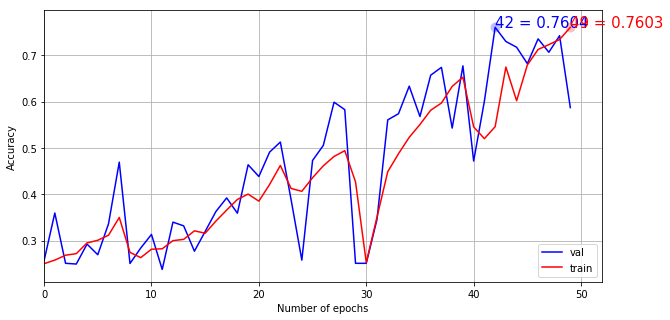

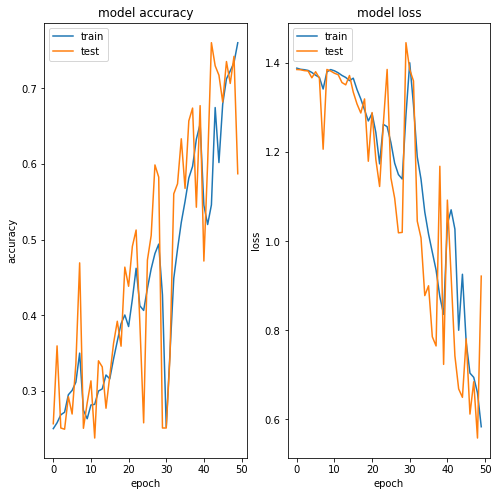

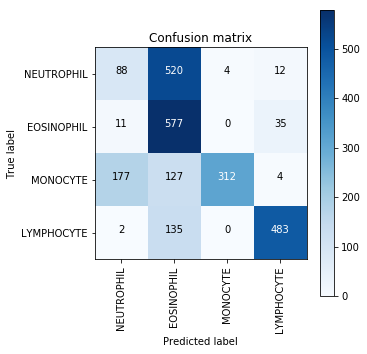

In [48]:
# use SGD optimizer

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='SGD', learning_rate=0.01, lr_decay=0.0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(60, 80, 3..., kernel_initializer="he_normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(25, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(180, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call 

Epoch 1/30
312/311 [==============================] - ETA: 2:55 - loss: 2.2355 - acc: 0.156 - ETA: 27s - loss: 1.8617 - acc: 0.151 - ETA: 15s - loss: 1.6498 - acc: 0.18 - ETA: 14s - loss: 1.6141 - acc: 0.19 - ETA: 13s - loss: 1.5883 - acc: 0.19 - ETA: 13s - loss: 1.5683 - acc: 0.19 - ETA: 12s - loss: 1.5515 - acc: 0.20 - ETA: 12s - loss: 1.5371 - acc: 0.20 - ETA: 12s - loss: 1.5253 - acc: 0.21 - ETA: 11s - loss: 1.5160 - acc: 0.21 - ETA: 11s - loss: 1.5075 - acc: 0.21 - ETA: 11s - loss: 1.4994 - acc: 0.22 - ETA: 11s - loss: 1.4928 - acc: 0.22 - ETA: 11s - loss: 1.4870 - acc: 0.22 - ETA: 10s - loss: 1.4813 - acc: 0.22 - ETA: 10s - loss: 1.4762 - acc: 0.23 - ETA: 10s - loss: 1.4721 - acc: 0.22 - ETA: 10s - loss: 1.4679 - acc: 0.22 - ETA: 10s - loss: 1.4641 - acc: 0.23 - ETA: 10s - loss: 1.4609 - acc: 0.23 - ETA: 10s - loss: 1.4585 - acc: 0.23 - ETA: 9s - loss: 1.4551 - acc: 0.2347 - ETA: 9s - loss: 1.4529 - acc: 0.235 - ETA: 9s - loss: 1.4511 - acc: 0.235 - ETA: 9s - loss: 1.4482 - acc: 

312/311 [==============================] - ETA: 3s - loss: 1.4466 - acc: 0.187 - ETA: 3s - loss: 1.3328 - acc: 0.322 - ETA: 2s - loss: 1.3170 - acc: 0.333 - ETA: 3s - loss: 1.2994 - acc: 0.354 - ETA: 4s - loss: 1.3096 - acc: 0.349 - ETA: 4s - loss: 1.3061 - acc: 0.348 - ETA: 5s - loss: 1.2984 - acc: 0.351 - ETA: 5s - loss: 1.2807 - acc: 0.368 - ETA: 5s - loss: 1.2780 - acc: 0.365 - ETA: 5s - loss: 1.2779 - acc: 0.362 - ETA: 6s - loss: 1.2684 - acc: 0.369 - ETA: 6s - loss: 1.2620 - acc: 0.374 - ETA: 6s - loss: 1.2679 - acc: 0.374 - ETA: 6s - loss: 1.2651 - acc: 0.377 - ETA: 6s - loss: 1.2654 - acc: 0.378 - ETA: 6s - loss: 1.2662 - acc: 0.379 - ETA: 6s - loss: 1.2646 - acc: 0.380 - ETA: 6s - loss: 1.2601 - acc: 0.382 - ETA: 6s - loss: 1.2566 - acc: 0.384 - ETA: 6s - loss: 1.2561 - acc: 0.385 - ETA: 6s - loss: 1.2492 - acc: 0.388 - ETA: 6s - loss: 1.2555 - acc: 0.385 - ETA: 6s - loss: 1.2586 - acc: 0.384 - ETA: 6s - loss: 1.2566 - acc: 0.386 - ETA: 6s - loss: 1.2570 - acc: 0.386 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 1.0769 - acc: 0.500 - ETA: 3s - loss: 1.0720 - acc: 0.494 - ETA: 2s - loss: 1.0471 - acc: 0.513 - ETA: 3s - loss: 1.0358 - acc: 0.517 - ETA: 3s - loss: 1.0309 - acc: 0.526 - ETA: 4s - loss: 1.0252 - acc: 0.532 - ETA: 4s - loss: 1.0573 - acc: 0.518 - ETA: 5s - loss: 1.0722 - acc: 0.507 - ETA: 5s - loss: 1.0681 - acc: 0.508 - ETA: 5s - loss: 1.0733 - acc: 0.503 - ETA: 5s - loss: 1.0756 - acc: 0.503 - ETA: 5s - loss: 1.0703 - acc: 0.509 - ETA: 6s - loss: 1.0620 - acc: 0.513 - ETA: 6s - loss: 1.0522 - acc: 0.519 - ETA: 6s - loss: 1.0467 - acc: 0.518 - ETA: 6s - loss: 1.0375 - acc: 0.521 - ETA: 6s - loss: 1.0353 - acc: 0.522 - ETA: 6s - loss: 1.0364 - acc: 0.523 - ETA: 6s - loss: 1.0320 - acc: 0.523 - ETA: 6s - loss: 1.0332 - acc: 0.525 - ETA: 6s - loss: 1.0459 - acc: 0.516 - ETA: 6s - loss: 1.0542 - acc: 0.512 - ETA: 6s - loss: 1.0543 - acc: 0.508 - ETA: 6s - loss: 1.0528 - acc: 0.512 - ETA: 6s - loss: 1.0483 - acc: 0.512 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 1.0791 - acc: 0.468 - ETA: 2s - loss: 0.9968 - acc: 0.509 - ETA: 2s - loss: 0.9864 - acc: 0.539 - ETA: 3s - loss: 0.9827 - acc: 0.562 - ETA: 4s - loss: 0.9653 - acc: 0.575 - ETA: 4s - loss: 0.9543 - acc: 0.581 - ETA: 5s - loss: 0.9615 - acc: 0.575 - ETA: 5s - loss: 0.9616 - acc: 0.570 - ETA: 5s - loss: 0.9510 - acc: 0.576 - ETA: 5s - loss: 0.9445 - acc: 0.577 - ETA: 6s - loss: 0.9343 - acc: 0.577 - ETA: 6s - loss: 0.9305 - acc: 0.574 - ETA: 6s - loss: 0.9316 - acc: 0.574 - ETA: 6s - loss: 0.9274 - acc: 0.578 - ETA: 6s - loss: 0.9290 - acc: 0.575 - ETA: 6s - loss: 0.9233 - acc: 0.575 - ETA: 6s - loss: 0.9164 - acc: 0.579 - ETA: 6s - loss: 0.9138 - acc: 0.583 - ETA: 6s - loss: 0.9132 - acc: 0.582 - ETA: 6s - loss: 0.9201 - acc: 0.580 - ETA: 6s - loss: 0.9199 - acc: 0.578 - ETA: 6s - loss: 0.9246 - acc: 0.577 - ETA: 6s - loss: 0.9278 - acc: 0.577 - ETA: 6s - loss: 0.9279 - acc: 0.577 - ETA: 6s - loss: 0.9242 - acc: 0.578 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 1.1461 - acc: 0.531 - ETA: 2s - loss: 0.9585 - acc: 0.593 - ETA: 2s - loss: 0.8997 - acc: 0.629 - ETA: 3s - loss: 0.9004 - acc: 0.628 - ETA: 4s - loss: 0.8913 - acc: 0.628 - ETA: 4s - loss: 0.8748 - acc: 0.631 - ETA: 5s - loss: 0.8775 - acc: 0.629 - ETA: 5s - loss: 0.8675 - acc: 0.625 - ETA: 5s - loss: 0.8517 - acc: 0.628 - ETA: 5s - loss: 0.8553 - acc: 0.626 - ETA: 6s - loss: 0.8569 - acc: 0.621 - ETA: 6s - loss: 0.8516 - acc: 0.624 - ETA: 6s - loss: 0.8457 - acc: 0.624 - ETA: 6s - loss: 0.8418 - acc: 0.625 - ETA: 6s - loss: 0.8464 - acc: 0.627 - ETA: 6s - loss: 0.8484 - acc: 0.625 - ETA: 6s - loss: 0.8418 - acc: 0.628 - ETA: 6s - loss: 0.8431 - acc: 0.628 - ETA: 6s - loss: 0.8454 - acc: 0.627 - ETA: 6s - loss: 0.8438 - acc: 0.625 - ETA: 6s - loss: 0.8396 - acc: 0.628 - ETA: 6s - loss: 0.8344 - acc: 0.630 - ETA: 6s - loss: 0.8332 - acc: 0.631 - ETA: 6s - loss: 0.8289 - acc: 0.633 - ETA: 6s - loss: 0.8223 - acc: 0.633 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.8618 - acc: 0.531 - ETA: 2s - loss: 0.7163 - acc: 0.616 - ETA: 2s - loss: 0.7030 - acc: 0.644 - ETA: 3s - loss: 0.7083 - acc: 0.640 - ETA: 4s - loss: 0.7276 - acc: 0.631 - ETA: 4s - loss: 0.7257 - acc: 0.635 - ETA: 4s - loss: 0.7282 - acc: 0.633 - ETA: 5s - loss: 0.7285 - acc: 0.635 - ETA: 5s - loss: 0.7384 - acc: 0.637 - ETA: 5s - loss: 0.7447 - acc: 0.636 - ETA: 5s - loss: 0.7550 - acc: 0.634 - ETA: 6s - loss: 0.7471 - acc: 0.634 - ETA: 6s - loss: 0.7484 - acc: 0.634 - ETA: 6s - loss: 0.7731 - acc: 0.628 - ETA: 6s - loss: 0.7805 - acc: 0.623 - ETA: 6s - loss: 0.7818 - acc: 0.623 - ETA: 6s - loss: 0.7736 - acc: 0.626 - ETA: 6s - loss: 0.7711 - acc: 0.628 - ETA: 6s - loss: 0.7599 - acc: 0.633 - ETA: 6s - loss: 0.7614 - acc: 0.632 - ETA: 6s - loss: 0.7579 - acc: 0.634 - ETA: 6s - loss: 0.7557 - acc: 0.637 - ETA: 6s - loss: 0.7558 - acc: 0.637 - ETA: 6s - loss: 0.7484 - acc: 0.640 - ETA: 6s - loss: 0.7465 - acc: 0.643 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.4869 - acc: 0.718 - ETA: 2s - loss: 0.6733 - acc: 0.674 - ETA: 2s - loss: 0.6203 - acc: 0.701 - ETA: 3s - loss: 0.6448 - acc: 0.697 - ETA: 4s - loss: 0.6380 - acc: 0.694 - ETA: 4s - loss: 0.6366 - acc: 0.695 - ETA: 5s - loss: 0.6505 - acc: 0.684 - ETA: 5s - loss: 0.6486 - acc: 0.683 - ETA: 5s - loss: 0.6549 - acc: 0.678 - ETA: 6s - loss: 0.6542 - acc: 0.678 - ETA: 6s - loss: 0.6550 - acc: 0.683 - ETA: 6s - loss: 0.6607 - acc: 0.685 - ETA: 6s - loss: 0.6657 - acc: 0.686 - ETA: 6s - loss: 0.6752 - acc: 0.681 - ETA: 6s - loss: 0.6709 - acc: 0.684 - ETA: 6s - loss: 0.6666 - acc: 0.682 - ETA: 6s - loss: 0.6676 - acc: 0.681 - ETA: 6s - loss: 0.6686 - acc: 0.681 - ETA: 6s - loss: 0.6660 - acc: 0.684 - ETA: 7s - loss: 0.6714 - acc: 0.683 - ETA: 7s - loss: 0.6815 - acc: 0.678 - ETA: 7s - loss: 0.6921 - acc: 0.672 - ETA: 7s - loss: 0.6890 - acc: 0.672 - ETA: 7s - loss: 0.6878 - acc: 0.674 - ETA: 7s - loss: 0.7003 - acc: 0.671 - ETA: 7s

312/311 [==============================] - ETA: 2s - loss: 0.7440 - acc: 0.593 - ETA: 2s - loss: 0.6587 - acc: 0.660 - ETA: 2s - loss: 0.6461 - acc: 0.666 - ETA: 3s - loss: 0.6326 - acc: 0.681 - ETA: 4s - loss: 0.6490 - acc: 0.683 - ETA: 4s - loss: 0.6716 - acc: 0.679 - ETA: 5s - loss: 0.6654 - acc: 0.683 - ETA: 5s - loss: 0.6515 - acc: 0.691 - ETA: 5s - loss: 0.6447 - acc: 0.697 - ETA: 5s - loss: 0.6422 - acc: 0.700 - ETA: 6s - loss: 0.6372 - acc: 0.699 - ETA: 6s - loss: 0.6431 - acc: 0.694 - ETA: 6s - loss: 0.6403 - acc: 0.694 - ETA: 6s - loss: 0.6276 - acc: 0.701 - ETA: 6s - loss: 0.6273 - acc: 0.696 - ETA: 6s - loss: 0.6226 - acc: 0.700 - ETA: 6s - loss: 0.6159 - acc: 0.702 - ETA: 6s - loss: 0.6157 - acc: 0.704 - ETA: 6s - loss: 0.6402 - acc: 0.699 - ETA: 6s - loss: 0.6619 - acc: 0.693 - ETA: 6s - loss: 0.6589 - acc: 0.694 - ETA: 6s - loss: 0.6551 - acc: 0.699 - ETA: 6s - loss: 0.6521 - acc: 0.699 - ETA: 6s - loss: 0.6468 - acc: 0.702 - ETA: 6s - loss: 0.6412 - acc: 0.704 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.5745 - acc: 0.750 - ETA: 2s - loss: 0.5579 - acc: 0.745 - ETA: 3s - loss: 0.6672 - acc: 0.700 - ETA: 3s - loss: 0.6122 - acc: 0.724 - ETA: 3s - loss: 0.5993 - acc: 0.730 - ETA: 4s - loss: 0.6168 - acc: 0.715 - ETA: 4s - loss: 0.6191 - acc: 0.713 - ETA: 5s - loss: 0.6062 - acc: 0.722 - ETA: 5s - loss: 0.6031 - acc: 0.724 - ETA: 5s - loss: 0.5830 - acc: 0.732 - ETA: 5s - loss: 0.5909 - acc: 0.731 - ETA: 5s - loss: 0.5848 - acc: 0.733 - ETA: 5s - loss: 0.5905 - acc: 0.728 - ETA: 6s - loss: 0.5890 - acc: 0.726 - ETA: 6s - loss: 0.5904 - acc: 0.725 - ETA: 6s - loss: 0.5872 - acc: 0.730 - ETA: 6s - loss: 0.5907 - acc: 0.728 - ETA: 6s - loss: 0.5902 - acc: 0.728 - ETA: 6s - loss: 0.5906 - acc: 0.726 - ETA: 6s - loss: 0.5852 - acc: 0.729 - ETA: 6s - loss: 0.5839 - acc: 0.731 - ETA: 6s - loss: 0.5813 - acc: 0.730 - ETA: 6s - loss: 0.5813 - acc: 0.730 - ETA: 6s - loss: 0.5836 - acc: 0.730 - ETA: 6s - loss: 0.5819 - acc: 0.732 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.5593 - acc: 0.718 - ETA: 2s - loss: 0.5396 - acc: 0.741 - ETA: 3s - loss: 0.5506 - acc: 0.737 - ETA: 4s - loss: 0.5623 - acc: 0.736 - ETA: 4s - loss: 0.5605 - acc: 0.736 - ETA: 5s - loss: 0.5455 - acc: 0.746 - ETA: 5s - loss: 0.5556 - acc: 0.746 - ETA: 6s - loss: 0.5521 - acc: 0.751 - ETA: 6s - loss: 0.5487 - acc: 0.755 - ETA: 6s - loss: 0.5522 - acc: 0.753 - ETA: 6s - loss: 0.5697 - acc: 0.751 - ETA: 6s - loss: 0.5600 - acc: 0.753 - ETA: 6s - loss: 0.5657 - acc: 0.752 - ETA: 7s - loss: 0.5723 - acc: 0.744 - ETA: 7s - loss: 0.5712 - acc: 0.745 - ETA: 7s - loss: 0.5733 - acc: 0.745 - ETA: 7s - loss: 0.5766 - acc: 0.744 - ETA: 7s - loss: 0.5936 - acc: 0.735 - ETA: 7s - loss: 0.5923 - acc: 0.735 - ETA: 7s - loss: 0.5860 - acc: 0.739 - ETA: 7s - loss: 0.5826 - acc: 0.741 - ETA: 7s - loss: 0.5810 - acc: 0.741 - ETA: 7s - loss: 0.5759 - acc: 0.744 - ETA: 7s - loss: 0.5777 - acc: 0.742 - ETA: 7s - loss: 0.5844 - acc: 0.738 - ETA: 7s

312/311 [==============================] - ETA: 3s - loss: 0.3760 - acc: 0.781 - ETA: 4s - loss: 0.4877 - acc: 0.754 - ETA: 3s - loss: 0.5121 - acc: 0.735 - ETA: 4s - loss: 0.4818 - acc: 0.757 - ETA: 4s - loss: 0.4757 - acc: 0.768 - ETA: 5s - loss: 0.4873 - acc: 0.761 - ETA: 5s - loss: 0.4928 - acc: 0.764 - ETA: 5s - loss: 0.4830 - acc: 0.772 - ETA: 5s - loss: 0.4789 - acc: 0.780 - ETA: 6s - loss: 0.4815 - acc: 0.778 - ETA: 6s - loss: 0.4893 - acc: 0.780 - ETA: 6s - loss: 0.5008 - acc: 0.777 - ETA: 6s - loss: 0.4972 - acc: 0.778 - ETA: 6s - loss: 0.4979 - acc: 0.777 - ETA: 6s - loss: 0.4925 - acc: 0.781 - ETA: 6s - loss: 0.5031 - acc: 0.778 - ETA: 6s - loss: 0.5041 - acc: 0.773 - ETA: 6s - loss: 0.5158 - acc: 0.770 - ETA: 6s - loss: 0.5160 - acc: 0.768 - ETA: 6s - loss: 0.5133 - acc: 0.771 - ETA: 6s - loss: 0.5109 - acc: 0.769 - ETA: 6s - loss: 0.5043 - acc: 0.774 - ETA: 6s - loss: 0.5039 - acc: 0.776 - ETA: 6s - loss: 0.5041 - acc: 0.777 - ETA: 6s - loss: 0.5029 - acc: 0.776 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 0.7066 - acc: 0.593 - ETA: 2s - loss: 0.6208 - acc: 0.699 - ETA: 3s - loss: 0.5487 - acc: 0.745 - ETA: 3s - loss: 0.5105 - acc: 0.773 - ETA: 4s - loss: 0.5072 - acc: 0.771 - ETA: 4s - loss: 0.5459 - acc: 0.764 - ETA: 5s - loss: 0.5488 - acc: 0.763 - ETA: 5s - loss: 0.5375 - acc: 0.768 - ETA: 5s - loss: 0.5381 - acc: 0.768 - ETA: 5s - loss: 0.5495 - acc: 0.766 - ETA: 6s - loss: 0.5684 - acc: 0.761 - ETA: 6s - loss: 0.5800 - acc: 0.755 - ETA: 6s - loss: 0.5730 - acc: 0.759 - ETA: 6s - loss: 0.5842 - acc: 0.758 - ETA: 6s - loss: 0.5825 - acc: 0.756 - ETA: 6s - loss: 0.5787 - acc: 0.762 - ETA: 6s - loss: 0.5886 - acc: 0.762 - ETA: 6s - loss: 0.5990 - acc: 0.760 - ETA: 6s - loss: 0.5976 - acc: 0.760 - ETA: 6s - loss: 0.5950 - acc: 0.760 - ETA: 6s - loss: 0.5940 - acc: 0.761 - ETA: 6s - loss: 0.5894 - acc: 0.761 - ETA: 6s - loss: 0.5871 - acc: 0.760 - ETA: 6s - loss: 0.5820 - acc: 0.763 - ETA: 6s - loss: 0.5758 - acc: 0.764 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.3200 - acc: 0.875 - ETA: 2s - loss: 0.4241 - acc: 0.803 - ETA: 2s - loss: 0.4461 - acc: 0.794 - ETA: 3s - loss: 0.4264 - acc: 0.797 - ETA: 4s - loss: 0.4256 - acc: 0.790 - ETA: 4s - loss: 0.4244 - acc: 0.792 - ETA: 5s - loss: 0.4405 - acc: 0.790 - ETA: 5s - loss: 0.4357 - acc: 0.794 - ETA: 5s - loss: 0.4637 - acc: 0.785 - ETA: 6s - loss: 0.4630 - acc: 0.784 - ETA: 6s - loss: 0.4576 - acc: 0.789 - ETA: 6s - loss: 0.4544 - acc: 0.792 - ETA: 6s - loss: 0.4565 - acc: 0.790 - ETA: 6s - loss: 0.4526 - acc: 0.793 - ETA: 6s - loss: 0.4461 - acc: 0.797 - ETA: 6s - loss: 0.4460 - acc: 0.798 - ETA: 6s - loss: 0.4415 - acc: 0.799 - ETA: 7s - loss: 0.4386 - acc: 0.802 - ETA: 7s - loss: 0.4443 - acc: 0.797 - ETA: 7s - loss: 0.4419 - acc: 0.800 - ETA: 7s - loss: 0.4404 - acc: 0.801 - ETA: 7s - loss: 0.4406 - acc: 0.802 - ETA: 7s - loss: 0.4395 - acc: 0.803 - ETA: 7s - loss: 0.4433 - acc: 0.800 - ETA: 7s - loss: 0.4415 - acc: 0.800 - ETA: 7s

312/311 [==============================] - ETA: 2s - loss: 0.5641 - acc: 0.781 - ETA: 2s - loss: 0.6560 - acc: 0.727 - ETA: 2s - loss: 0.5515 - acc: 0.754 - ETA: 3s - loss: 0.5233 - acc: 0.767 - ETA: 4s - loss: 0.5508 - acc: 0.765 - ETA: 4s - loss: 0.5308 - acc: 0.767 - ETA: 5s - loss: 0.5614 - acc: 0.756 - ETA: 5s - loss: 0.5658 - acc: 0.751 - ETA: 5s - loss: 0.5544 - acc: 0.756 - ETA: 5s - loss: 0.5468 - acc: 0.760 - ETA: 6s - loss: 0.5501 - acc: 0.759 - ETA: 6s - loss: 0.5471 - acc: 0.756 - ETA: 6s - loss: 0.5383 - acc: 0.762 - ETA: 6s - loss: 0.5407 - acc: 0.761 - ETA: 6s - loss: 0.5399 - acc: 0.758 - ETA: 6s - loss: 0.5330 - acc: 0.763 - ETA: 6s - loss: 0.5277 - acc: 0.766 - ETA: 6s - loss: 0.5209 - acc: 0.770 - ETA: 6s - loss: 0.5151 - acc: 0.773 - ETA: 6s - loss: 0.5114 - acc: 0.774 - ETA: 6s - loss: 0.5117 - acc: 0.775 - ETA: 6s - loss: 0.5166 - acc: 0.774 - ETA: 6s - loss: 0.5203 - acc: 0.772 - ETA: 6s - loss: 0.5458 - acc: 0.768 - ETA: 6s - loss: 0.5418 - acc: 0.769 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.8142 - acc: 0.687 - ETA: 2s - loss: 0.4863 - acc: 0.834 - ETA: 2s - loss: 0.4915 - acc: 0.815 - ETA: 3s - loss: 0.4792 - acc: 0.818 - ETA: 4s - loss: 0.4666 - acc: 0.824 - ETA: 4s - loss: 0.4799 - acc: 0.817 - ETA: 5s - loss: 0.4847 - acc: 0.816 - ETA: 5s - loss: 0.4693 - acc: 0.821 - ETA: 5s - loss: 0.4622 - acc: 0.818 - ETA: 5s - loss: 0.4690 - acc: 0.817 - ETA: 5s - loss: 0.4587 - acc: 0.824 - ETA: 6s - loss: 0.4448 - acc: 0.830 - ETA: 6s - loss: 0.4360 - acc: 0.830 - ETA: 6s - loss: 0.4358 - acc: 0.829 - ETA: 6s - loss: 0.4407 - acc: 0.827 - ETA: 6s - loss: 0.4409 - acc: 0.824 - ETA: 6s - loss: 0.4467 - acc: 0.820 - ETA: 6s - loss: 0.4501 - acc: 0.816 - ETA: 6s - loss: 0.4517 - acc: 0.813 - ETA: 6s - loss: 0.4559 - acc: 0.809 - ETA: 6s - loss: 0.4534 - acc: 0.810 - ETA: 6s - loss: 0.4518 - acc: 0.808 - ETA: 6s - loss: 0.4471 - acc: 0.809 - ETA: 6s - loss: 0.4465 - acc: 0.809 - ETA: 6s - loss: 0.4460 - acc: 0.809 - ETA: 6s

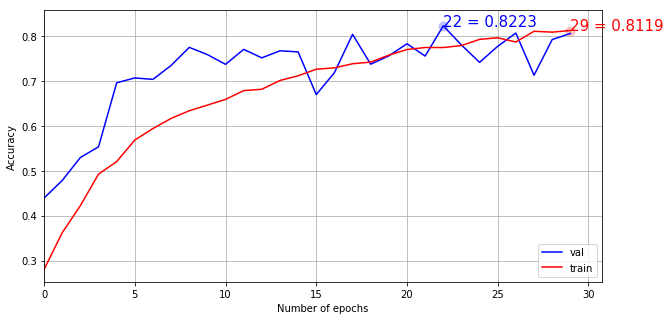

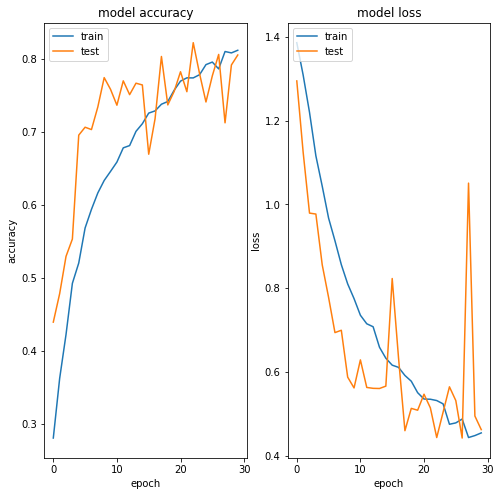

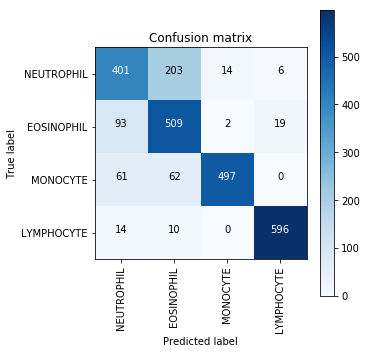

In [36]:
def runLenet5Model(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_lenet5'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_lenet5_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runLenet5Model(X_train, y_trainHot, X_test, y_testHot)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(60, 80, 3..., kernel_initializer="he_normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(25, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(180, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call 

Epoch 1/30
312/311 [==============================] - ETA: 4:02 - loss: 2.3999 - acc: 0.187 - ETA: 42s - loss: 2.4658 - acc: 0.255 - ETA: 22s - loss: 1.9646 - acc: 0.26 - ETA: 17s - loss: 1.8263 - acc: 0.26 - ETA: 16s - loss: 1.7764 - acc: 0.26 - ETA: 15s - loss: 1.7248 - acc: 0.25 - ETA: 14s - loss: 1.6946 - acc: 0.25 - ETA: 13s - loss: 1.6710 - acc: 0.26 - ETA: 13s - loss: 1.6502 - acc: 0.25 - ETA: 12s - loss: 1.6251 - acc: 0.25 - ETA: 12s - loss: 1.6107 - acc: 0.25 - ETA: 12s - loss: 1.5974 - acc: 0.25 - ETA: 12s - loss: 1.5806 - acc: 0.25 - ETA: 11s - loss: 1.5663 - acc: 0.25 - ETA: 11s - loss: 1.5576 - acc: 0.25 - ETA: 11s - loss: 1.5507 - acc: 0.25 - ETA: 10s - loss: 1.5438 - acc: 0.25 - ETA: 10s - loss: 1.5379 - acc: 0.25 - ETA: 10s - loss: 1.5328 - acc: 0.25 - ETA: 10s - loss: 1.5273 - acc: 0.25 - ETA: 10s - loss: 1.5222 - acc: 0.25 - ETA: 10s - loss: 1.5182 - acc: 0.24 - ETA: 9s - loss: 1.5140 - acc: 0.2508 - ETA: 9s - loss: 1.5103 - acc: 0.247 - ETA: 9s - loss: 1.5062 - acc: 

312/311 [==============================] - ETA: 2s - loss: 1.3883 - acc: 0.281 - ETA: 2s - loss: 1.3885 - acc: 0.232 - ETA: 2s - loss: 1.3883 - acc: 0.238 - ETA: 3s - loss: 1.3877 - acc: 0.237 - ETA: 4s - loss: 1.3878 - acc: 0.230 - ETA: 4s - loss: 1.3877 - acc: 0.235 - ETA: 5s - loss: 1.3879 - acc: 0.234 - ETA: 5s - loss: 1.3876 - acc: 0.240 - ETA: 5s - loss: 1.3877 - acc: 0.239 - ETA: 5s - loss: 1.3876 - acc: 0.240 - ETA: 6s - loss: 1.3877 - acc: 0.239 - ETA: 6s - loss: 1.3873 - acc: 0.245 - ETA: 6s - loss: 1.3873 - acc: 0.241 - ETA: 6s - loss: 1.3871 - acc: 0.245 - ETA: 6s - loss: 1.3870 - acc: 0.248 - ETA: 6s - loss: 1.3869 - acc: 0.250 - ETA: 6s - loss: 1.3868 - acc: 0.249 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.248 - ETA: 6s - loss: 1.3870 - acc: 0.243 - ETA: 6s - loss: 1.3872 - acc: 0.239 - ETA: 6s - loss: 1.3871 - acc: 0.237 - ETA: 6s - loss: 1.3872 - acc: 0.237 - ETA: 6s - loss: 1.3871 - acc: 0.238 - ETA: 6s - loss: 1.3869 - acc: 0.241 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 1.3852 - acc: 0.281 - ETA: 4s - loss: 1.3884 - acc: 0.250 - ETA: 4s - loss: 1.3876 - acc: 0.250 - ETA: 5s - loss: 1.3880 - acc: 0.237 - ETA: 5s - loss: 1.3878 - acc: 0.231 - ETA: 5s - loss: 1.3876 - acc: 0.227 - ETA: 5s - loss: 1.3874 - acc: 0.228 - ETA: 5s - loss: 1.3872 - acc: 0.227 - ETA: 5s - loss: 1.3873 - acc: 0.232 - ETA: 5s - loss: 1.3875 - acc: 0.227 - ETA: 5s - loss: 1.3877 - acc: 0.229 - ETA: 6s - loss: 1.3878 - acc: 0.226 - ETA: 6s - loss: 1.3876 - acc: 0.232 - ETA: 6s - loss: 1.3871 - acc: 0.239 - ETA: 6s - loss: 1.3869 - acc: 0.239 - ETA: 6s - loss: 1.3868 - acc: 0.242 - ETA: 6s - loss: 1.3869 - acc: 0.242 - ETA: 6s - loss: 1.3867 - acc: 0.245 - ETA: 6s - loss: 1.3867 - acc: 0.242 - ETA: 6s - loss: 1.3867 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.243 - ETA: 6s - loss: 1.3866 - acc: 0.238 - ETA: 6s - loss: 1.3868 - acc: 0.239 - ETA: 6s - loss: 1.3866 - acc: 0.240 - ETA: 6s - loss: 1.3867 - acc: 0.239 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3847 - acc: 0.312 - ETA: 9s - loss: 1.3842 - acc: 0.281 - ETA: 8s - loss: 1.3849 - acc: 0.270 - ETA: 9s - loss: 1.3847 - acc: 0.277 - ETA: 8s - loss: 1.3844 - acc: 0.284 - ETA: 7s - loss: 1.3848 - acc: 0.267 - ETA: 7s - loss: 1.3854 - acc: 0.246 - ETA: 7s - loss: 1.3852 - acc: 0.250 - ETA: 7s - loss: 1.3852 - acc: 0.248 - ETA: 6s - loss: 1.3852 - acc: 0.250 - ETA: 6s - loss: 1.3852 - acc: 0.252 - ETA: 6s - loss: 1.3852 - acc: 0.249 - ETA: 6s - loss: 1.3851 - acc: 0.249 - ETA: 6s - loss: 1.3855 - acc: 0.243 - ETA: 6s - loss: 1.3853 - acc: 0.244 - ETA: 6s - loss: 1.3856 - acc: 0.242 - ETA: 6s - loss: 1.3857 - acc: 0.243 - ETA: 7s - loss: 1.3858 - acc: 0.239 - ETA: 6s - loss: 1.3858 - acc: 0.239 - ETA: 6s - loss: 1.3861 - acc: 0.238 - ETA: 6s - loss: 1.3861 - acc: 0.239 - ETA: 7s - loss: 1.3863 - acc: 0.237 - ETA: 7s - loss: 1.3861 - acc: 0.240 - ETA: 6s - loss: 1.3861 - acc: 0.241 - ETA: 7s - loss: 1.3861 - acc: 0.240 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 1.3829 - acc: 0.343 - ETA: 4s - loss: 1.3838 - acc: 0.281 - ETA: 6s - loss: 1.3839 - acc: 0.296 - ETA: 7s - loss: 1.3839 - acc: 0.296 - ETA: 8s - loss: 1.3849 - acc: 0.296 - ETA: 8s - loss: 1.3866 - acc: 0.276 - ETA: 7s - loss: 1.3870 - acc: 0.263 - ETA: 8s - loss: 1.3871 - acc: 0.261 - ETA: 7s - loss: 1.3870 - acc: 0.259 - ETA: 7s - loss: 1.3877 - acc: 0.252 - ETA: 7s - loss: 1.3874 - acc: 0.252 - ETA: 7s - loss: 1.3874 - acc: 0.252 - ETA: 7s - loss: 1.3870 - acc: 0.254 - ETA: 6s - loss: 1.3871 - acc: 0.249 - ETA: 7s - loss: 1.3870 - acc: 0.250 - ETA: 6s - loss: 1.3870 - acc: 0.248 - ETA: 7s - loss: 1.3868 - acc: 0.250 - ETA: 6s - loss: 1.3866 - acc: 0.255 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3866 - acc: 0.248 - ETA: 6s - loss: 1.3868 - acc: 0.247 - ETA: 6s - loss: 1.3868 - acc: 0.248 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.3938 - acc: 0.156 - ETA: 5s - loss: 1.3892 - acc: 0.226 - ETA: 7s - loss: 1.3875 - acc: 0.250 - ETA: 7s - loss: 1.3873 - acc: 0.265 - ETA: 6s - loss: 1.3860 - acc: 0.278 - ETA: 6s - loss: 1.3862 - acc: 0.266 - ETA: 6s - loss: 1.3862 - acc: 0.263 - ETA: 6s - loss: 1.3862 - acc: 0.257 - ETA: 6s - loss: 1.3861 - acc: 0.266 - ETA: 6s - loss: 1.3859 - acc: 0.272 - ETA: 6s - loss: 1.3866 - acc: 0.268 - ETA: 6s - loss: 1.3870 - acc: 0.263 - ETA: 6s - loss: 1.3868 - acc: 0.267 - ETA: 6s - loss: 1.3867 - acc: 0.262 - ETA: 6s - loss: 1.3864 - acc: 0.264 - ETA: 6s - loss: 1.3862 - acc: 0.264 - ETA: 6s - loss: 1.3865 - acc: 0.259 - ETA: 6s - loss: 1.3866 - acc: 0.257 - ETA: 6s - loss: 1.3868 - acc: 0.255 - ETA: 6s - loss: 1.3868 - acc: 0.257 - ETA: 6s - loss: 1.3868 - acc: 0.254 - ETA: 6s - loss: 1.3867 - acc: 0.257 - ETA: 6s - loss: 1.3866 - acc: 0.260 - ETA: 6s - loss: 1.3865 - acc: 0.261 - ETA: 6s - loss: 1.3866 - acc: 0.261 - ETA: 6s

312/311 [==============================] - ETA: 11s - loss: 1.3882 - acc: 0.12 - ETA: 9s - loss: 1.3879 - acc: 0.1979 - ETA: 9s - loss: 1.3872 - acc: 0.200 - ETA: 8s - loss: 1.3866 - acc: 0.232 - ETA: 9s - loss: 1.3859 - acc: 0.250 - ETA: 9s - loss: 1.3868 - acc: 0.230 - ETA: 8s - loss: 1.3863 - acc: 0.243 - ETA: 8s - loss: 1.3859 - acc: 0.253 - ETA: 8s - loss: 1.3862 - acc: 0.254 - ETA: 8s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3865 - acc: 0.247 - ETA: 7s - loss: 1.3862 - acc: 0.250 - ETA: 7s - loss: 1.3861 - acc: 0.250 - ETA: 7s - loss: 1.3862 - acc: 0.252 - ETA: 7s - loss: 1.3863 - acc: 0.250 - ETA: 7s - loss: 1.3864 - acc: 0.247 - ETA: 7s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3864 - acc: 0.248 - ETA: 7s - loss: 1.3864 - acc: 0.247 - ETA: 7s - loss: 1.3863 - acc: 0.250 - ETA: 7s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3863 - acc: 0.254 - ETA: 7s - loss: 1.3862 - acc: 0.255 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 7s - loss: 1.3863 - acc: 0.255 - ETA: 7

312/311 [==============================] - ETA: 8s - loss: 1.3899 - acc: 0.156 - ETA: 8s - loss: 1.3854 - acc: 0.218 - ETA: 8s - loss: 1.3860 - acc: 0.200 - ETA: 7s - loss: 1.3858 - acc: 0.208 - ETA: 6s - loss: 1.3867 - acc: 0.210 - ETA: 6s - loss: 1.3864 - acc: 0.210 - ETA: 7s - loss: 1.3869 - acc: 0.211 - ETA: 7s - loss: 1.3869 - acc: 0.218 - ETA: 7s - loss: 1.3865 - acc: 0.230 - ETA: 7s - loss: 1.3872 - acc: 0.222 - ETA: 6s - loss: 1.3874 - acc: 0.222 - ETA: 6s - loss: 1.3873 - acc: 0.229 - ETA: 6s - loss: 1.3868 - acc: 0.235 - ETA: 6s - loss: 1.3865 - acc: 0.240 - ETA: 6s - loss: 1.3865 - acc: 0.236 - ETA: 6s - loss: 1.3864 - acc: 0.239 - ETA: 6s - loss: 1.3865 - acc: 0.235 - ETA: 6s - loss: 1.3862 - acc: 0.237 - ETA: 6s - loss: 1.3861 - acc: 0.241 - ETA: 6s - loss: 1.3861 - acc: 0.240 - ETA: 7s - loss: 1.3861 - acc: 0.240 - ETA: 7s - loss: 1.3862 - acc: 0.241 - ETA: 6s - loss: 1.3858 - acc: 0.244 - ETA: 6s - loss: 1.3860 - acc: 0.244 - ETA: 6s - loss: 1.3860 - acc: 0.243 - ETA: 7s

312/311 [==============================] - ETA: 7s - loss: 1.3692 - acc: 0.250 - ETA: 7s - loss: 1.3713 - acc: 0.229 - ETA: 7s - loss: 1.3836 - acc: 0.250 - ETA: 7s - loss: 1.3807 - acc: 0.265 - ETA: 6s - loss: 1.3741 - acc: 0.278 - ETA: 7s - loss: 1.3685 - acc: 0.290 - ETA: 8s - loss: 1.3649 - acc: 0.297 - ETA: 7s - loss: 1.3631 - acc: 0.298 - ETA: 7s - loss: 1.3572 - acc: 0.309 - ETA: 7s - loss: 1.3574 - acc: 0.306 - ETA: 7s - loss: 1.3599 - acc: 0.301 - ETA: 7s - loss: 1.3622 - acc: 0.296 - ETA: 7s - loss: 1.3647 - acc: 0.297 - ETA: 6s - loss: 1.3644 - acc: 0.304 - ETA: 6s - loss: 1.3628 - acc: 0.308 - ETA: 6s - loss: 1.3613 - acc: 0.310 - ETA: 7s - loss: 1.3605 - acc: 0.311 - ETA: 6s - loss: 1.3578 - acc: 0.309 - ETA: 7s - loss: 1.3574 - acc: 0.309 - ETA: 6s - loss: 1.3554 - acc: 0.311 - ETA: 6s - loss: 1.3568 - acc: 0.311 - ETA: 7s - loss: 1.3576 - acc: 0.311 - ETA: 6s - loss: 1.3595 - acc: 0.309 - ETA: 6s - loss: 1.3599 - acc: 0.308 - ETA: 6s - loss: 1.3587 - acc: 0.309 - ETA: 7s

312/311 [==============================] - ETA: 4s - loss: 1.0398 - acc: 0.468 - ETA: 10s - loss: 1.1791 - acc: 0.42 - ETA: 7s - loss: 1.1790 - acc: 0.4562 - ETA: 8s - loss: 1.1984 - acc: 0.446 - ETA: 7s - loss: 1.1842 - acc: 0.454 - ETA: 7s - loss: 1.1820 - acc: 0.444 - ETA: 7s - loss: 1.1950 - acc: 0.427 - ETA: 7s - loss: 1.1884 - acc: 0.430 - ETA: 7s - loss: 1.1937 - acc: 0.420 - ETA: 7s - loss: 1.1778 - acc: 0.434 - ETA: 7s - loss: 1.1853 - acc: 0.431 - ETA: 7s - loss: 1.1818 - acc: 0.430 - ETA: 7s - loss: 1.1852 - acc: 0.429 - ETA: 7s - loss: 1.2082 - acc: 0.419 - ETA: 7s - loss: 1.2129 - acc: 0.418 - ETA: 7s - loss: 1.2124 - acc: 0.422 - ETA: 7s - loss: 1.2097 - acc: 0.422 - ETA: 7s - loss: 1.2135 - acc: 0.418 - ETA: 7s - loss: 1.2165 - acc: 0.420 - ETA: 7s - loss: 1.2159 - acc: 0.418 - ETA: 7s - loss: 1.2189 - acc: 0.422 - ETA: 7s - loss: 1.2140 - acc: 0.426 - ETA: 7s - loss: 1.2173 - acc: 0.416 - ETA: 7s - loss: 1.2129 - acc: 0.420 - ETA: 7s - loss: 1.2154 - acc: 0.422 - ETA: 7

312/311 [==============================] - ETA: 4s - loss: 1.2023 - acc: 0.437 - ETA: 4s - loss: 1.1552 - acc: 0.406 - ETA: 4s - loss: 1.1240 - acc: 0.437 - ETA: 3s - loss: 1.1192 - acc: 0.445 - ETA: 4s - loss: 1.1239 - acc: 0.439 - ETA: 4s - loss: 1.1142 - acc: 0.439 - ETA: 5s - loss: 1.1175 - acc: 0.441 - ETA: 5s - loss: 1.1288 - acc: 0.447 - ETA: 5s - loss: 1.1267 - acc: 0.448 - ETA: 5s - loss: 1.1331 - acc: 0.443 - ETA: 5s - loss: 1.1336 - acc: 0.446 - ETA: 6s - loss: 1.1339 - acc: 0.447 - ETA: 6s - loss: 1.1335 - acc: 0.448 - ETA: 6s - loss: 1.1249 - acc: 0.453 - ETA: 6s - loss: 1.1246 - acc: 0.456 - ETA: 6s - loss: 1.1266 - acc: 0.460 - ETA: 6s - loss: 1.1247 - acc: 0.462 - ETA: 6s - loss: 1.1237 - acc: 0.461 - ETA: 6s - loss: 1.1243 - acc: 0.457 - ETA: 6s - loss: 1.1210 - acc: 0.459 - ETA: 6s - loss: 1.1195 - acc: 0.460 - ETA: 6s - loss: 1.1207 - acc: 0.454 - ETA: 6s - loss: 1.1219 - acc: 0.455 - ETA: 6s - loss: 1.1220 - acc: 0.456 - ETA: 6s - loss: 1.1236 - acc: 0.458 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 1.1372 - acc: 0.406 - ETA: 5s - loss: 1.0601 - acc: 0.437 - ETA: 5s - loss: 1.0429 - acc: 0.457 - ETA: 5s - loss: 1.1050 - acc: 0.437 - ETA: 5s - loss: 1.1284 - acc: 0.435 - ETA: 5s - loss: 1.1218 - acc: 0.435 - ETA: 5s - loss: 1.1306 - acc: 0.427 - ETA: 5s - loss: 1.1314 - acc: 0.429 - ETA: 5s - loss: 1.1284 - acc: 0.435 - ETA: 5s - loss: 1.1247 - acc: 0.435 - ETA: 5s - loss: 1.1209 - acc: 0.440 - ETA: 6s - loss: 1.1163 - acc: 0.442 - ETA: 6s - loss: 1.1130 - acc: 0.445 - ETA: 6s - loss: 1.1087 - acc: 0.449 - ETA: 6s - loss: 1.1085 - acc: 0.454 - ETA: 6s - loss: 1.1028 - acc: 0.460 - ETA: 6s - loss: 1.1014 - acc: 0.464 - ETA: 6s - loss: 1.0955 - acc: 0.469 - ETA: 6s - loss: 1.0929 - acc: 0.469 - ETA: 6s - loss: 1.0963 - acc: 0.468 - ETA: 6s - loss: 1.0982 - acc: 0.468 - ETA: 6s - loss: 1.0997 - acc: 0.473 - ETA: 6s - loss: 1.1017 - acc: 0.469 - ETA: 6s - loss: 1.0967 - acc: 0.472 - ETA: 6s - loss: 1.0969 - acc: 0.472 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.9955 - acc: 0.468 - ETA: 4s - loss: 1.0436 - acc: 0.520 - ETA: 4s - loss: 0.9965 - acc: 0.541 - ETA: 5s - loss: 1.0131 - acc: 0.528 - ETA: 4s - loss: 1.0433 - acc: 0.522 - ETA: 4s - loss: 1.0417 - acc: 0.509 - ETA: 5s - loss: 1.0441 - acc: 0.513 - ETA: 5s - loss: 1.0410 - acc: 0.507 - ETA: 5s - loss: 1.0356 - acc: 0.512 - ETA: 5s - loss: 1.0332 - acc: 0.511 - ETA: 6s - loss: 1.0429 - acc: 0.510 - ETA: 6s - loss: 1.0526 - acc: 0.508 - ETA: 6s - loss: 1.0466 - acc: 0.515 - ETA: 6s - loss: 1.0440 - acc: 0.518 - ETA: 6s - loss: 1.0350 - acc: 0.521 - ETA: 6s - loss: 1.0267 - acc: 0.529 - ETA: 6s - loss: 1.0211 - acc: 0.529 - ETA: 6s - loss: 1.0208 - acc: 0.529 - ETA: 6s - loss: 1.0220 - acc: 0.529 - ETA: 6s - loss: 1.0197 - acc: 0.525 - ETA: 6s - loss: 1.0344 - acc: 0.520 - ETA: 6s - loss: 1.0344 - acc: 0.521 - ETA: 6s - loss: 1.0373 - acc: 0.519 - ETA: 6s - loss: 1.0348 - acc: 0.520 - ETA: 6s - loss: 1.0330 - acc: 0.522 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.8620 - acc: 0.625 - ETA: 2s - loss: 0.9554 - acc: 0.584 - ETA: 2s - loss: 0.9405 - acc: 0.598 - ETA: 3s - loss: 0.9487 - acc: 0.591 - ETA: 4s - loss: 0.9428 - acc: 0.581 - ETA: 4s - loss: 0.9604 - acc: 0.565 - ETA: 4s - loss: 0.9604 - acc: 0.566 - ETA: 5s - loss: 0.9638 - acc: 0.559 - ETA: 5s - loss: 0.9571 - acc: 0.558 - ETA: 5s - loss: 0.9623 - acc: 0.564 - ETA: 5s - loss: 0.9674 - acc: 0.556 - ETA: 6s - loss: 0.9682 - acc: 0.556 - ETA: 6s - loss: 0.9700 - acc: 0.557 - ETA: 6s - loss: 0.9700 - acc: 0.555 - ETA: 6s - loss: 0.9808 - acc: 0.551 - ETA: 6s - loss: 0.9789 - acc: 0.548 - ETA: 6s - loss: 0.9812 - acc: 0.546 - ETA: 6s - loss: 0.9834 - acc: 0.546 - ETA: 6s - loss: 0.9876 - acc: 0.545 - ETA: 6s - loss: 0.9828 - acc: 0.547 - ETA: 6s - loss: 0.9846 - acc: 0.543 - ETA: 6s - loss: 0.9844 - acc: 0.543 - ETA: 6s - loss: 0.9809 - acc: 0.543 - ETA: 6s - loss: 0.9785 - acc: 0.545 - ETA: 6s - loss: 0.9775 - acc: 0.548 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 1.0108 - acc: 0.500 - ETA: 2s - loss: 0.9068 - acc: 0.575 - ETA: 2s - loss: 0.9171 - acc: 0.588 - ETA: 3s - loss: 0.9316 - acc: 0.584 - ETA: 3s - loss: 0.9335 - acc: 0.588 - ETA: 4s - loss: 0.9228 - acc: 0.596 - ETA: 4s - loss: 0.9190 - acc: 0.593 - ETA: 5s - loss: 0.8991 - acc: 0.604 - ETA: 5s - loss: 0.8999 - acc: 0.599 - ETA: 5s - loss: 0.8904 - acc: 0.601 - ETA: 5s - loss: 0.8899 - acc: 0.600 - ETA: 5s - loss: 0.8922 - acc: 0.600 - ETA: 6s - loss: 0.8896 - acc: 0.602 - ETA: 6s - loss: 0.8924 - acc: 0.601 - ETA: 6s - loss: 0.8918 - acc: 0.601 - ETA: 6s - loss: 0.8830 - acc: 0.603 - ETA: 6s - loss: 0.8956 - acc: 0.601 - ETA: 6s - loss: 0.9051 - acc: 0.597 - ETA: 6s - loss: 0.9105 - acc: 0.593 - ETA: 6s - loss: 0.9114 - acc: 0.592 - ETA: 6s - loss: 0.9134 - acc: 0.590 - ETA: 6s - loss: 0.9069 - acc: 0.594 - ETA: 6s - loss: 0.8988 - acc: 0.598 - ETA: 6s - loss: 0.8988 - acc: 0.597 - ETA: 6s - loss: 0.8924 - acc: 0.599 - ETA: 6s

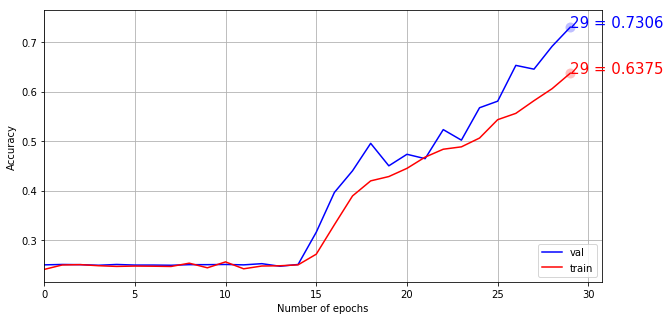

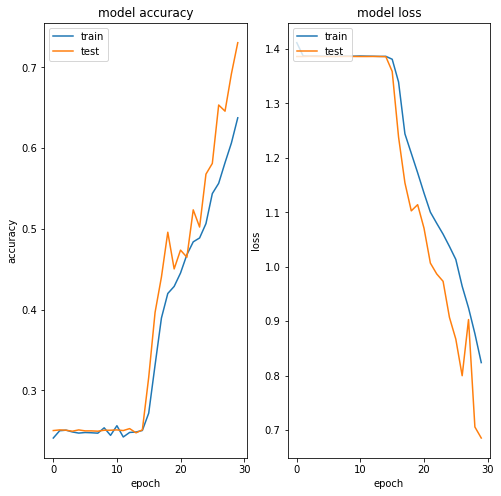

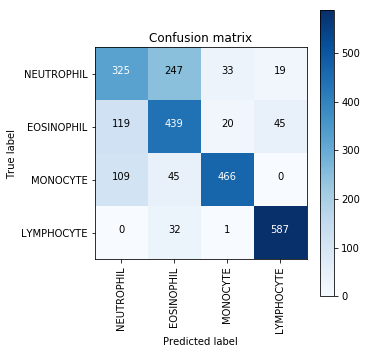

In [37]:
def runLenet5Model2(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_lenet5_2'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_lenet5_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runLenet5Model2(X_train_2, y_trainHot_2, X_test_2, y_testHot_2)

Epoch 1/30
312/311 [==============================] - ETA: 2:55 - loss: 1.4929 - acc: 0.312 - ETA: 48s - loss: 1.6471 - acc: 0.328 - ETA: 30s - loss: 1.6741 - acc: 0.31 - ETA: 22s - loss: 1.6239 - acc: 0.30 - ETA: 20s - loss: 1.5982 - acc: 0.32 - ETA: 18s - loss: 1.5759 - acc: 0.32 - ETA: 16s - loss: 1.5474 - acc: 0.34 - ETA: 14s - loss: 1.5145 - acc: 0.34 - ETA: 13s - loss: 1.4817 - acc: 0.35 - ETA: 12s - loss: 1.4721 - acc: 0.36 - ETA: 12s - loss: 1.4581 - acc: 0.36 - ETA: 12s - loss: 1.4465 - acc: 0.37 - ETA: 12s - loss: 1.4365 - acc: 0.37 - ETA: 11s - loss: 1.4293 - acc: 0.37 - ETA: 11s - loss: 1.4155 - acc: 0.38 - ETA: 11s - loss: 1.4079 - acc: 0.38 - ETA: 10s - loss: 1.4010 - acc: 0.38 - ETA: 10s - loss: 1.3852 - acc: 0.39 - ETA: 10s - loss: 1.3774 - acc: 0.40 - ETA: 9s - loss: 1.3713 - acc: 0.4069 - ETA: 9s - loss: 1.3682 - acc: 0.408 - ETA: 9s - loss: 1.3585 - acc: 0.413 - ETA: 9s - loss: 1.3522 - acc: 0.415 - ETA: 9s - loss: 1.3479 - acc: 0.415 - ETA: 9s - loss: 1.3451 - acc: 

312/311 [==============================] - ETA: 9s - loss: 0.9289 - acc: 0.625 - ETA: 7s - loss: 0.8737 - acc: 0.687 - ETA: 6s - loss: 0.8593 - acc: 0.683 - ETA: 6s - loss: 0.8107 - acc: 0.693 - ETA: 6s - loss: 0.8147 - acc: 0.687 - ETA: 6s - loss: 0.8095 - acc: 0.689 - ETA: 6s - loss: 0.8296 - acc: 0.678 - ETA: 6s - loss: 0.8444 - acc: 0.664 - ETA: 6s - loss: 0.8501 - acc: 0.659 - ETA: 6s - loss: 0.8592 - acc: 0.654 - ETA: 6s - loss: 0.8564 - acc: 0.656 - ETA: 6s - loss: 0.8544 - acc: 0.658 - ETA: 7s - loss: 0.8561 - acc: 0.654 - ETA: 6s - loss: 0.8555 - acc: 0.654 - ETA: 6s - loss: 0.8502 - acc: 0.660 - ETA: 6s - loss: 0.8634 - acc: 0.652 - ETA: 7s - loss: 0.8600 - acc: 0.653 - ETA: 7s - loss: 0.8612 - acc: 0.652 - ETA: 7s - loss: 0.8537 - acc: 0.657 - ETA: 7s - loss: 0.8540 - acc: 0.654 - ETA: 6s - loss: 0.8480 - acc: 0.656 - ETA: 6s - loss: 0.8491 - acc: 0.653 - ETA: 6s - loss: 0.8528 - acc: 0.652 - ETA: 6s - loss: 0.8486 - acc: 0.654 - ETA: 7s - loss: 0.8539 - acc: 0.654 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 0.5817 - acc: 0.750 - ETA: 8s - loss: 0.7646 - acc: 0.687 - ETA: 6s - loss: 0.8010 - acc: 0.666 - ETA: 7s - loss: 0.7821 - acc: 0.677 - ETA: 7s - loss: 0.8012 - acc: 0.670 - ETA: 6s - loss: 0.7996 - acc: 0.678 - ETA: 6s - loss: 0.8003 - acc: 0.678 - ETA: 6s - loss: 0.7926 - acc: 0.670 - ETA: 6s - loss: 0.7847 - acc: 0.679 - ETA: 6s - loss: 0.7954 - acc: 0.675 - ETA: 6s - loss: 0.7949 - acc: 0.674 - ETA: 6s - loss: 0.8001 - acc: 0.673 - ETA: 6s - loss: 0.7907 - acc: 0.677 - ETA: 6s - loss: 0.7977 - acc: 0.669 - ETA: 6s - loss: 0.8009 - acc: 0.670 - ETA: 6s - loss: 0.8019 - acc: 0.667 - ETA: 6s - loss: 0.7974 - acc: 0.670 - ETA: 6s - loss: 0.7930 - acc: 0.675 - ETA: 6s - loss: 0.7939 - acc: 0.677 - ETA: 6s - loss: 0.7842 - acc: 0.682 - ETA: 6s - loss: 0.7858 - acc: 0.680 - ETA: 6s - loss: 0.7903 - acc: 0.677 - ETA: 6s - loss: 0.7854 - acc: 0.679 - ETA: 6s - loss: 0.7868 - acc: 0.679 - ETA: 6s - loss: 0.7809 - acc: 0.681 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.7380 - acc: 0.718 - ETA: 6s - loss: 0.6622 - acc: 0.757 - ETA: 6s - loss: 0.6747 - acc: 0.736 - ETA: 6s - loss: 0.6651 - acc: 0.737 - ETA: 6s - loss: 0.6631 - acc: 0.726 - ETA: 6s - loss: 0.6472 - acc: 0.738 - ETA: 5s - loss: 0.6480 - acc: 0.738 - ETA: 5s - loss: 0.6412 - acc: 0.738 - ETA: 5s - loss: 0.6490 - acc: 0.732 - ETA: 5s - loss: 0.6632 - acc: 0.722 - ETA: 6s - loss: 0.6713 - acc: 0.715 - ETA: 6s - loss: 0.6793 - acc: 0.709 - ETA: 6s - loss: 0.6883 - acc: 0.704 - ETA: 6s - loss: 0.6823 - acc: 0.709 - ETA: 6s - loss: 0.6830 - acc: 0.709 - ETA: 6s - loss: 0.6836 - acc: 0.706 - ETA: 6s - loss: 0.6860 - acc: 0.703 - ETA: 6s - loss: 0.6872 - acc: 0.702 - ETA: 6s - loss: 0.6910 - acc: 0.701 - ETA: 6s - loss: 0.6878 - acc: 0.702 - ETA: 6s - loss: 0.6874 - acc: 0.701 - ETA: 6s - loss: 0.6824 - acc: 0.703 - ETA: 6s - loss: 0.6878 - acc: 0.700 - ETA: 6s - loss: 0.6882 - acc: 0.702 - ETA: 6s - loss: 0.6886 - acc: 0.702 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.7405 - acc: 0.687 - ETA: 6s - loss: 0.5834 - acc: 0.781 - ETA: 6s - loss: 0.5366 - acc: 0.794 - ETA: 6s - loss: 0.5771 - acc: 0.768 - ETA: 6s - loss: 0.5946 - acc: 0.766 - ETA: 6s - loss: 0.6013 - acc: 0.763 - ETA: 6s - loss: 0.5858 - acc: 0.769 - ETA: 5s - loss: 0.5896 - acc: 0.769 - ETA: 5s - loss: 0.5935 - acc: 0.763 - ETA: 6s - loss: 0.5973 - acc: 0.762 - ETA: 6s - loss: 0.6172 - acc: 0.751 - ETA: 6s - loss: 0.6154 - acc: 0.752 - ETA: 6s - loss: 0.6027 - acc: 0.757 - ETA: 6s - loss: 0.6031 - acc: 0.757 - ETA: 6s - loss: 0.5987 - acc: 0.760 - ETA: 6s - loss: 0.6008 - acc: 0.757 - ETA: 6s - loss: 0.6097 - acc: 0.755 - ETA: 6s - loss: 0.6161 - acc: 0.752 - ETA: 6s - loss: 0.6120 - acc: 0.752 - ETA: 6s - loss: 0.6138 - acc: 0.754 - ETA: 6s - loss: 0.6154 - acc: 0.751 - ETA: 6s - loss: 0.6155 - acc: 0.750 - ETA: 6s - loss: 0.6188 - acc: 0.747 - ETA: 6s - loss: 0.6162 - acc: 0.747 - ETA: 6s - loss: 0.6154 - acc: 0.747 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.8637 - acc: 0.600 - ETA: 5s - loss: 0.6715 - acc: 0.689 - ETA: 5s - loss: 0.6683 - acc: 0.692 - ETA: 5s - loss: 0.6947 - acc: 0.700 - ETA: 5s - loss: 0.6626 - acc: 0.719 - ETA: 5s - loss: 0.6304 - acc: 0.740 - ETA: 5s - loss: 0.6110 - acc: 0.738 - ETA: 5s - loss: 0.5971 - acc: 0.751 - ETA: 5s - loss: 0.5943 - acc: 0.756 - ETA: 5s - loss: 0.5990 - acc: 0.751 - ETA: 6s - loss: 0.5950 - acc: 0.754 - ETA: 6s - loss: 0.5954 - acc: 0.753 - ETA: 6s - loss: 0.5904 - acc: 0.752 - ETA: 6s - loss: 0.5806 - acc: 0.758 - ETA: 6s - loss: 0.5770 - acc: 0.762 - ETA: 6s - loss: 0.5962 - acc: 0.756 - ETA: 6s - loss: 0.5968 - acc: 0.754 - ETA: 6s - loss: 0.5989 - acc: 0.752 - ETA: 6s - loss: 0.5967 - acc: 0.755 - ETA: 6s - loss: 0.5977 - acc: 0.752 - ETA: 6s - loss: 0.6000 - acc: 0.750 - ETA: 6s - loss: 0.6078 - acc: 0.747 - ETA: 6s - loss: 0.5981 - acc: 0.750 - ETA: 6s - loss: 0.5967 - acc: 0.751 - ETA: 6s - loss: 0.6013 - acc: 0.750 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5471 - acc: 0.750 - ETA: 6s - loss: 0.4932 - acc: 0.820 - ETA: 6s - loss: 0.6105 - acc: 0.763 - ETA: 6s - loss: 0.5757 - acc: 0.765 - ETA: 6s - loss: 0.5694 - acc: 0.764 - ETA: 5s - loss: 0.5636 - acc: 0.763 - ETA: 5s - loss: 0.5682 - acc: 0.761 - ETA: 5s - loss: 0.5664 - acc: 0.762 - ETA: 5s - loss: 0.5590 - acc: 0.766 - ETA: 6s - loss: 0.5590 - acc: 0.764 - ETA: 6s - loss: 0.5570 - acc: 0.766 - ETA: 6s - loss: 0.5501 - acc: 0.770 - ETA: 6s - loss: 0.5578 - acc: 0.762 - ETA: 6s - loss: 0.5556 - acc: 0.763 - ETA: 6s - loss: 0.5597 - acc: 0.762 - ETA: 6s - loss: 0.5625 - acc: 0.757 - ETA: 6s - loss: 0.5602 - acc: 0.758 - ETA: 6s - loss: 0.5658 - acc: 0.757 - ETA: 6s - loss: 0.5687 - acc: 0.752 - ETA: 6s - loss: 0.5685 - acc: 0.753 - ETA: 6s - loss: 0.5613 - acc: 0.756 - ETA: 6s - loss: 0.5601 - acc: 0.756 - ETA: 6s - loss: 0.5619 - acc: 0.759 - ETA: 6s - loss: 0.5564 - acc: 0.762 - ETA: 6s - loss: 0.5587 - acc: 0.762 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.4913 - acc: 0.812 - ETA: 6s - loss: 0.4474 - acc: 0.820 - ETA: 6s - loss: 0.4457 - acc: 0.838 - ETA: 6s - loss: 0.4945 - acc: 0.812 - ETA: 6s - loss: 0.4959 - acc: 0.804 - ETA: 6s - loss: 0.5086 - acc: 0.797 - ETA: 6s - loss: 0.5189 - acc: 0.796 - ETA: 6s - loss: 0.5369 - acc: 0.785 - ETA: 6s - loss: 0.5257 - acc: 0.790 - ETA: 5s - loss: 0.5508 - acc: 0.780 - ETA: 5s - loss: 0.5454 - acc: 0.778 - ETA: 6s - loss: 0.5476 - acc: 0.776 - ETA: 6s - loss: 0.5367 - acc: 0.784 - ETA: 6s - loss: 0.5261 - acc: 0.788 - ETA: 6s - loss: 0.5278 - acc: 0.788 - ETA: 6s - loss: 0.5313 - acc: 0.784 - ETA: 6s - loss: 0.5362 - acc: 0.784 - ETA: 6s - loss: 0.5330 - acc: 0.786 - ETA: 6s - loss: 0.5345 - acc: 0.786 - ETA: 6s - loss: 0.5346 - acc: 0.789 - ETA: 6s - loss: 0.5355 - acc: 0.789 - ETA: 6s - loss: 0.5371 - acc: 0.789 - ETA: 6s - loss: 0.5422 - acc: 0.788 - ETA: 6s - loss: 0.5392 - acc: 0.787 - ETA: 6s - loss: 0.5359 - acc: 0.790 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.5709 - acc: 0.718 - ETA: 6s - loss: 0.5953 - acc: 0.750 - ETA: 6s - loss: 0.5808 - acc: 0.772 - ETA: 5s - loss: 0.5434 - acc: 0.793 - ETA: 5s - loss: 0.5176 - acc: 0.790 - ETA: 5s - loss: 0.5074 - acc: 0.787 - ETA: 5s - loss: 0.5077 - acc: 0.792 - ETA: 5s - loss: 0.5143 - acc: 0.789 - ETA: 5s - loss: 0.5052 - acc: 0.791 - ETA: 5s - loss: 0.4945 - acc: 0.796 - ETA: 6s - loss: 0.4889 - acc: 0.799 - ETA: 6s - loss: 0.4890 - acc: 0.797 - ETA: 6s - loss: 0.4957 - acc: 0.791 - ETA: 6s - loss: 0.4948 - acc: 0.793 - ETA: 6s - loss: 0.4876 - acc: 0.797 - ETA: 6s - loss: 0.4938 - acc: 0.798 - ETA: 6s - loss: 0.4900 - acc: 0.799 - ETA: 6s - loss: 0.4883 - acc: 0.800 - ETA: 6s - loss: 0.4884 - acc: 0.801 - ETA: 6s - loss: 0.4890 - acc: 0.800 - ETA: 6s - loss: 0.4911 - acc: 0.798 - ETA: 6s - loss: 0.4895 - acc: 0.801 - ETA: 6s - loss: 0.4886 - acc: 0.800 - ETA: 6s - loss: 0.4935 - acc: 0.798 - ETA: 6s - loss: 0.4985 - acc: 0.795 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.3290 - acc: 0.875 - ETA: 6s - loss: 0.4329 - acc: 0.812 - ETA: 6s - loss: 0.4816 - acc: 0.790 - ETA: 6s - loss: 0.4904 - acc: 0.784 - ETA: 6s - loss: 0.4881 - acc: 0.795 - ETA: 5s - loss: 0.4919 - acc: 0.794 - ETA: 5s - loss: 0.4834 - acc: 0.801 - ETA: 5s - loss: 0.4829 - acc: 0.805 - ETA: 5s - loss: 0.4926 - acc: 0.808 - ETA: 6s - loss: 0.4959 - acc: 0.806 - ETA: 6s - loss: 0.5016 - acc: 0.803 - ETA: 6s - loss: 0.4961 - acc: 0.807 - ETA: 6s - loss: 0.4885 - acc: 0.813 - ETA: 6s - loss: 0.4873 - acc: 0.816 - ETA: 6s - loss: 0.4993 - acc: 0.809 - ETA: 6s - loss: 0.5009 - acc: 0.806 - ETA: 6s - loss: 0.5077 - acc: 0.802 - ETA: 6s - loss: 0.5102 - acc: 0.801 - ETA: 6s - loss: 0.5172 - acc: 0.799 - ETA: 6s - loss: 0.5156 - acc: 0.801 - ETA: 6s - loss: 0.5156 - acc: 0.800 - ETA: 6s - loss: 0.5151 - acc: 0.799 - ETA: 6s - loss: 0.5182 - acc: 0.796 - ETA: 6s - loss: 0.5114 - acc: 0.799 - ETA: 6s - loss: 0.5128 - acc: 0.796 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.6526 - acc: 0.718 - ETA: 6s - loss: 0.4975 - acc: 0.773 - ETA: 6s - loss: 0.5027 - acc: 0.772 - ETA: 6s - loss: 0.4741 - acc: 0.800 - ETA: 6s - loss: 0.4887 - acc: 0.798 - ETA: 6s - loss: 0.4818 - acc: 0.796 - ETA: 6s - loss: 0.4968 - acc: 0.791 - ETA: 6s - loss: 0.4976 - acc: 0.790 - ETA: 6s - loss: 0.4831 - acc: 0.798 - ETA: 6s - loss: 0.4880 - acc: 0.797 - ETA: 6s - loss: 0.4792 - acc: 0.799 - ETA: 6s - loss: 0.4643 - acc: 0.810 - ETA: 6s - loss: 0.4690 - acc: 0.806 - ETA: 6s - loss: 0.4724 - acc: 0.804 - ETA: 6s - loss: 0.4718 - acc: 0.808 - ETA: 6s - loss: 0.4781 - acc: 0.799 - ETA: 6s - loss: 0.4794 - acc: 0.800 - ETA: 6s - loss: 0.4684 - acc: 0.807 - ETA: 6s - loss: 0.4600 - acc: 0.810 - ETA: 6s - loss: 0.4588 - acc: 0.812 - ETA: 6s - loss: 0.4593 - acc: 0.812 - ETA: 6s - loss: 0.4577 - acc: 0.815 - ETA: 6s - loss: 0.4556 - acc: 0.813 - ETA: 6s - loss: 0.4566 - acc: 0.813 - ETA: 6s - loss: 0.4543 - acc: 0.813 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5347 - acc: 0.812 - ETA: 6s - loss: 0.4415 - acc: 0.835 - ETA: 6s - loss: 0.4472 - acc: 0.843 - ETA: 6s - loss: 0.4340 - acc: 0.846 - ETA: 6s - loss: 0.4520 - acc: 0.834 - ETA: 5s - loss: 0.4440 - acc: 0.839 - ETA: 5s - loss: 0.4424 - acc: 0.842 - ETA: 5s - loss: 0.4156 - acc: 0.849 - ETA: 5s - loss: 0.4129 - acc: 0.848 - ETA: 5s - loss: 0.4232 - acc: 0.843 - ETA: 5s - loss: 0.4289 - acc: 0.845 - ETA: 6s - loss: 0.4335 - acc: 0.843 - ETA: 6s - loss: 0.4373 - acc: 0.841 - ETA: 6s - loss: 0.4460 - acc: 0.837 - ETA: 6s - loss: 0.4464 - acc: 0.838 - ETA: 6s - loss: 0.4541 - acc: 0.833 - ETA: 6s - loss: 0.4546 - acc: 0.833 - ETA: 6s - loss: 0.4584 - acc: 0.832 - ETA: 6s - loss: 0.4612 - acc: 0.828 - ETA: 6s - loss: 0.4656 - acc: 0.824 - ETA: 6s - loss: 0.4679 - acc: 0.823 - ETA: 6s - loss: 0.4705 - acc: 0.822 - ETA: 6s - loss: 0.4620 - acc: 0.826 - ETA: 6s - loss: 0.4645 - acc: 0.827 - ETA: 6s - loss: 0.4632 - acc: 0.826 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.4571 - acc: 0.781 - ETA: 6s - loss: 0.3841 - acc: 0.835 - ETA: 6s - loss: 0.3579 - acc: 0.852 - ETA: 6s - loss: 0.4051 - acc: 0.809 - ETA: 6s - loss: 0.4278 - acc: 0.805 - ETA: 6s - loss: 0.4323 - acc: 0.798 - ETA: 5s - loss: 0.4578 - acc: 0.787 - ETA: 5s - loss: 0.4518 - acc: 0.791 - ETA: 5s - loss: 0.4309 - acc: 0.800 - ETA: 5s - loss: 0.4288 - acc: 0.808 - ETA: 6s - loss: 0.4264 - acc: 0.807 - ETA: 6s - loss: 0.4208 - acc: 0.811 - ETA: 6s - loss: 0.4352 - acc: 0.807 - ETA: 6s - loss: 0.4265 - acc: 0.812 - ETA: 6s - loss: 0.4259 - acc: 0.814 - ETA: 6s - loss: 0.4356 - acc: 0.810 - ETA: 6s - loss: 0.4396 - acc: 0.811 - ETA: 6s - loss: 0.4357 - acc: 0.813 - ETA: 6s - loss: 0.4470 - acc: 0.809 - ETA: 6s - loss: 0.4476 - acc: 0.810 - ETA: 6s - loss: 0.4444 - acc: 0.811 - ETA: 6s - loss: 0.4420 - acc: 0.813 - ETA: 6s - loss: 0.4458 - acc: 0.812 - ETA: 6s - loss: 0.4464 - acc: 0.812 - ETA: 6s - loss: 0.4508 - acc: 0.812 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5154 - acc: 0.781 - ETA: 6s - loss: 0.3676 - acc: 0.851 - ETA: 6s - loss: 0.4438 - acc: 0.812 - ETA: 6s - loss: 0.4927 - acc: 0.809 - ETA: 6s - loss: 0.4564 - acc: 0.819 - ETA: 6s - loss: 0.4313 - acc: 0.834 - ETA: 6s - loss: 0.4301 - acc: 0.830 - ETA: 6s - loss: 0.4431 - acc: 0.832 - ETA: 6s - loss: 0.4374 - acc: 0.840 - ETA: 6s - loss: 0.4388 - acc: 0.837 - ETA: 6s - loss: 0.4398 - acc: 0.836 - ETA: 6s - loss: 0.4443 - acc: 0.830 - ETA: 6s - loss: 0.4408 - acc: 0.829 - ETA: 6s - loss: 0.4426 - acc: 0.826 - ETA: 6s - loss: 0.4412 - acc: 0.824 - ETA: 6s - loss: 0.4345 - acc: 0.828 - ETA: 6s - loss: 0.4333 - acc: 0.827 - ETA: 6s - loss: 0.4281 - acc: 0.828 - ETA: 6s - loss: 0.4312 - acc: 0.825 - ETA: 6s - loss: 0.4331 - acc: 0.825 - ETA: 6s - loss: 0.4278 - acc: 0.827 - ETA: 6s - loss: 0.4337 - acc: 0.824 - ETA: 6s - loss: 0.4348 - acc: 0.824 - ETA: 6s - loss: 0.4348 - acc: 0.824 - ETA: 6s - loss: 0.4336 - acc: 0.825 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.6416 - acc: 0.750 - ETA: 6s - loss: 0.4378 - acc: 0.796 - ETA: 6s - loss: 0.3666 - acc: 0.839 - ETA: 6s - loss: 0.3900 - acc: 0.831 - ETA: 6s - loss: 0.4246 - acc: 0.819 - ETA: 5s - loss: 0.4161 - acc: 0.824 - ETA: 5s - loss: 0.4161 - acc: 0.828 - ETA: 5s - loss: 0.4153 - acc: 0.832 - ETA: 5s - loss: 0.4148 - acc: 0.830 - ETA: 5s - loss: 0.4064 - acc: 0.833 - ETA: 6s - loss: 0.4126 - acc: 0.833 - ETA: 6s - loss: 0.4162 - acc: 0.829 - ETA: 6s - loss: 0.4146 - acc: 0.832 - ETA: 6s - loss: 0.4157 - acc: 0.831 - ETA: 6s - loss: 0.4119 - acc: 0.832 - ETA: 6s - loss: 0.4157 - acc: 0.829 - ETA: 6s - loss: 0.4189 - acc: 0.829 - ETA: 6s - loss: 0.4161 - acc: 0.830 - ETA: 6s - loss: 0.4071 - acc: 0.837 - ETA: 6s - loss: 0.4133 - acc: 0.834 - ETA: 6s - loss: 0.4167 - acc: 0.834 - ETA: 6s - loss: 0.4188 - acc: 0.831 - ETA: 6s - loss: 0.4192 - acc: 0.830 - ETA: 6s - loss: 0.4179 - acc: 0.830 - ETA: 6s - loss: 0.4208 - acc: 0.829 - ETA: 6s

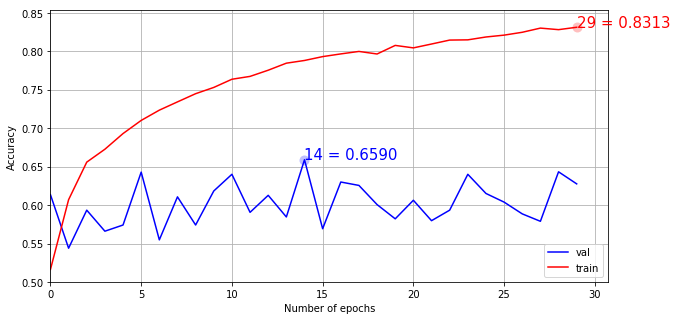

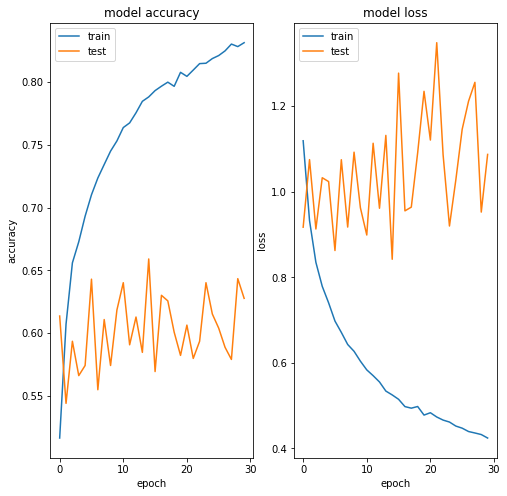

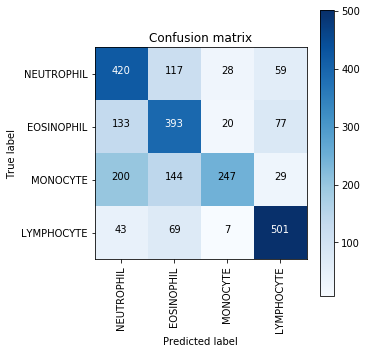

In [38]:
def runVgg16(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_vgg16'):
    
    num_classes = len(y_train[0])
    model_name = 'vgg16'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_keras_model(model_name, num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runVgg16(X_train, y_trainHot, X_test, y_testHot)

Epoch 1/30
312/311 [==============================] - ETA: 2:51 - loss: 1.4230 - acc: 0.312 - ETA: 47s - loss: 1.7679 - acc: 0.281 - ETA: 29s - loss: 1.6953 - acc: 0.29 - ETA: 22s - loss: 1.6526 - acc: 0.31 - ETA: 18s - loss: 1.6371 - acc: 0.29 - ETA: 16s - loss: 1.6108 - acc: 0.29 - ETA: 14s - loss: 1.5941 - acc: 0.29 - ETA: 13s - loss: 1.5786 - acc: 0.29 - ETA: 12s - loss: 1.5507 - acc: 0.30 - ETA: 11s - loss: 1.5447 - acc: 0.30 - ETA: 11s - loss: 1.5243 - acc: 0.31 - ETA: 10s - loss: 1.5140 - acc: 0.31 - ETA: 10s - loss: 1.5050 - acc: 0.31 - ETA: 10s - loss: 1.5049 - acc: 0.31 - ETA: 10s - loss: 1.4910 - acc: 0.31 - ETA: 10s - loss: 1.4875 - acc: 0.31 - ETA: 10s - loss: 1.4764 - acc: 0.32 - ETA: 9s - loss: 1.4649 - acc: 0.3267 - ETA: 9s - loss: 1.4592 - acc: 0.326 - ETA: 9s - loss: 1.4506 - acc: 0.330 - ETA: 9s - loss: 1.4448 - acc: 0.328 - ETA: 9s - loss: 1.4425 - acc: 0.331 - ETA: 9s - loss: 1.4390 - acc: 0.332 - ETA: 9s - loss: 1.4309 - acc: 0.334 - ETA: 9s - loss: 1.4242 - acc: 

312/311 [==============================] - ETA: 9s - loss: 1.2582 - acc: 0.406 - ETA: 9s - loss: 1.0401 - acc: 0.552 - ETA: 7s - loss: 1.0002 - acc: 0.567 - ETA: 7s - loss: 1.0132 - acc: 0.541 - ETA: 7s - loss: 0.9925 - acc: 0.565 - ETA: 7s - loss: 0.9998 - acc: 0.560 - ETA: 8s - loss: 0.9861 - acc: 0.577 - ETA: 8s - loss: 0.9900 - acc: 0.574 - ETA: 7s - loss: 1.0094 - acc: 0.563 - ETA: 7s - loss: 1.0101 - acc: 0.561 - ETA: 8s - loss: 1.0076 - acc: 0.563 - ETA: 7s - loss: 1.0082 - acc: 0.563 - ETA: 7s - loss: 1.0035 - acc: 0.565 - ETA: 8s - loss: 1.0060 - acc: 0.564 - ETA: 8s - loss: 1.0123 - acc: 0.562 - ETA: 7s - loss: 1.0129 - acc: 0.565 - ETA: 7s - loss: 1.0140 - acc: 0.562 - ETA: 7s - loss: 1.0165 - acc: 0.562 - ETA: 7s - loss: 1.0147 - acc: 0.563 - ETA: 7s - loss: 1.0143 - acc: 0.560 - ETA: 7s - loss: 1.0113 - acc: 0.561 - ETA: 7s - loss: 1.0045 - acc: 0.566 - ETA: 7s - loss: 1.0039 - acc: 0.570 - ETA: 7s - loss: 1.0106 - acc: 0.567 - ETA: 7s - loss: 1.0048 - acc: 0.571 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.9309 - acc: 0.656 - ETA: 7s - loss: 0.9429 - acc: 0.593 - ETA: 7s - loss: 0.9415 - acc: 0.606 - ETA: 8s - loss: 0.9096 - acc: 0.598 - ETA: 7s - loss: 0.9084 - acc: 0.618 - ETA: 7s - loss: 0.8890 - acc: 0.629 - ETA: 6s - loss: 0.8976 - acc: 0.617 - ETA: 6s - loss: 0.9041 - acc: 0.610 - ETA: 6s - loss: 0.8998 - acc: 0.613 - ETA: 6s - loss: 0.9123 - acc: 0.607 - ETA: 6s - loss: 0.8922 - acc: 0.622 - ETA: 6s - loss: 0.8826 - acc: 0.624 - ETA: 6s - loss: 0.8798 - acc: 0.622 - ETA: 6s - loss: 0.8859 - acc: 0.624 - ETA: 6s - loss: 0.8804 - acc: 0.626 - ETA: 6s - loss: 0.8810 - acc: 0.628 - ETA: 6s - loss: 0.8862 - acc: 0.626 - ETA: 6s - loss: 0.8908 - acc: 0.625 - ETA: 6s - loss: 0.8976 - acc: 0.622 - ETA: 6s - loss: 0.8964 - acc: 0.626 - ETA: 6s - loss: 0.8941 - acc: 0.626 - ETA: 6s - loss: 0.8917 - acc: 0.628 - ETA: 6s - loss: 0.8907 - acc: 0.630 - ETA: 6s - loss: 0.8884 - acc: 0.628 - ETA: 6s - loss: 0.8855 - acc: 0.629 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.8297 - acc: 0.656 - ETA: 6s - loss: 0.7890 - acc: 0.671 - ETA: 6s - loss: 0.8357 - acc: 0.647 - ETA: 6s - loss: 0.8592 - acc: 0.650 - ETA: 6s - loss: 0.8672 - acc: 0.644 - ETA: 6s - loss: 0.8453 - acc: 0.648 - ETA: 6s - loss: 0.8519 - acc: 0.649 - ETA: 6s - loss: 0.8419 - acc: 0.649 - ETA: 5s - loss: 0.8476 - acc: 0.647 - ETA: 5s - loss: 0.8503 - acc: 0.646 - ETA: 6s - loss: 0.8492 - acc: 0.646 - ETA: 6s - loss: 0.8423 - acc: 0.651 - ETA: 6s - loss: 0.8421 - acc: 0.652 - ETA: 6s - loss: 0.8433 - acc: 0.650 - ETA: 6s - loss: 0.8425 - acc: 0.651 - ETA: 6s - loss: 0.8516 - acc: 0.645 - ETA: 6s - loss: 0.8515 - acc: 0.646 - ETA: 6s - loss: 0.8450 - acc: 0.652 - ETA: 6s - loss: 0.8411 - acc: 0.653 - ETA: 6s - loss: 0.8454 - acc: 0.651 - ETA: 6s - loss: 0.8472 - acc: 0.651 - ETA: 6s - loss: 0.8508 - acc: 0.650 - ETA: 6s - loss: 0.8543 - acc: 0.646 - ETA: 6s - loss: 0.8540 - acc: 0.648 - ETA: 6s - loss: 0.8574 - acc: 0.647 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.0530 - acc: 0.656 - ETA: 6s - loss: 0.9573 - acc: 0.640 - ETA: 6s - loss: 0.8975 - acc: 0.629 - ETA: 6s - loss: 0.8935 - acc: 0.618 - ETA: 5s - loss: 0.9149 - acc: 0.608 - ETA: 5s - loss: 0.8863 - acc: 0.630 - ETA: 6s - loss: 0.8633 - acc: 0.640 - ETA: 6s - loss: 0.8596 - acc: 0.639 - ETA: 5s - loss: 0.8499 - acc: 0.645 - ETA: 5s - loss: 0.8493 - acc: 0.644 - ETA: 6s - loss: 0.8453 - acc: 0.648 - ETA: 6s - loss: 0.8331 - acc: 0.653 - ETA: 6s - loss: 0.8350 - acc: 0.651 - ETA: 6s - loss: 0.8375 - acc: 0.652 - ETA: 6s - loss: 0.8296 - acc: 0.657 - ETA: 6s - loss: 0.8252 - acc: 0.658 - ETA: 6s - loss: 0.8235 - acc: 0.657 - ETA: 6s - loss: 0.8265 - acc: 0.656 - ETA: 6s - loss: 0.8264 - acc: 0.655 - ETA: 6s - loss: 0.8218 - acc: 0.658 - ETA: 6s - loss: 0.8158 - acc: 0.661 - ETA: 6s - loss: 0.8149 - acc: 0.661 - ETA: 6s - loss: 0.8140 - acc: 0.661 - ETA: 6s - loss: 0.8164 - acc: 0.661 - ETA: 6s - loss: 0.8117 - acc: 0.662 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.0002 - acc: 0.500 - ETA: 5s - loss: 0.8655 - acc: 0.632 - ETA: 6s - loss: 0.7530 - acc: 0.683 - ETA: 6s - loss: 0.7784 - acc: 0.670 - ETA: 6s - loss: 0.7759 - acc: 0.666 - ETA: 6s - loss: 0.7660 - acc: 0.677 - ETA: 6s - loss: 0.7691 - acc: 0.677 - ETA: 5s - loss: 0.7882 - acc: 0.673 - ETA: 5s - loss: 0.7950 - acc: 0.672 - ETA: 5s - loss: 0.8097 - acc: 0.673 - ETA: 6s - loss: 0.8239 - acc: 0.665 - ETA: 6s - loss: 0.8163 - acc: 0.663 - ETA: 6s - loss: 0.8325 - acc: 0.657 - ETA: 6s - loss: 0.8328 - acc: 0.656 - ETA: 6s - loss: 0.8332 - acc: 0.658 - ETA: 6s - loss: 0.8454 - acc: 0.656 - ETA: 6s - loss: 0.8512 - acc: 0.654 - ETA: 6s - loss: 0.8425 - acc: 0.656 - ETA: 6s - loss: 0.8394 - acc: 0.658 - ETA: 6s - loss: 0.8394 - acc: 0.657 - ETA: 6s - loss: 0.8319 - acc: 0.662 - ETA: 6s - loss: 0.8285 - acc: 0.662 - ETA: 6s - loss: 0.8282 - acc: 0.660 - ETA: 6s - loss: 0.8284 - acc: 0.659 - ETA: 6s - loss: 0.8275 - acc: 0.661 - ETA: 6s

312/311 [==============================] - ETA: 9s - loss: 0.8778 - acc: 0.656 - ETA: 9s - loss: 0.9021 - acc: 0.614 - ETA: 7s - loss: 0.8148 - acc: 0.656 - ETA: 8s - loss: 0.8617 - acc: 0.625 - ETA: 9s - loss: 0.8206 - acc: 0.650 - ETA: 8s - loss: 0.7962 - acc: 0.661 - ETA: 8s - loss: 0.8167 - acc: 0.654 - ETA: 8s - loss: 0.8119 - acc: 0.658 - ETA: 8s - loss: 0.8103 - acc: 0.659 - ETA: 8s - loss: 0.8091 - acc: 0.653 - ETA: 8s - loss: 0.7885 - acc: 0.661 - ETA: 8s - loss: 0.7923 - acc: 0.662 - ETA: 8s - loss: 0.7887 - acc: 0.671 - ETA: 7s - loss: 0.7935 - acc: 0.667 - ETA: 7s - loss: 0.7836 - acc: 0.672 - ETA: 7s - loss: 0.7785 - acc: 0.676 - ETA: 7s - loss: 0.7843 - acc: 0.670 - ETA: 7s - loss: 0.7783 - acc: 0.675 - ETA: 7s - loss: 0.7692 - acc: 0.682 - ETA: 7s - loss: 0.7669 - acc: 0.683 - ETA: 7s - loss: 0.7671 - acc: 0.681 - ETA: 7s - loss: 0.7688 - acc: 0.680 - ETA: 7s - loss: 0.7689 - acc: 0.677 - ETA: 7s - loss: 0.7761 - acc: 0.676 - ETA: 7s - loss: 0.7738 - acc: 0.677 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.5440 - acc: 0.781 - ETA: 6s - loss: 0.6864 - acc: 0.695 - ETA: 8s - loss: 0.7530 - acc: 0.645 - ETA: 9s - loss: 0.7499 - acc: 0.660 - ETA: 9s - loss: 0.7411 - acc: 0.659 - ETA: 9s - loss: 0.7426 - acc: 0.666 - ETA: 9s - loss: 0.7318 - acc: 0.674 - ETA: 9s - loss: 0.7367 - acc: 0.676 - ETA: 8s - loss: 0.7384 - acc: 0.676 - ETA: 8s - loss: 0.7492 - acc: 0.671 - ETA: 8s - loss: 0.7604 - acc: 0.664 - ETA: 8s - loss: 0.7637 - acc: 0.660 - ETA: 8s - loss: 0.7573 - acc: 0.660 - ETA: 8s - loss: 0.7623 - acc: 0.660 - ETA: 8s - loss: 0.7611 - acc: 0.663 - ETA: 8s - loss: 0.7692 - acc: 0.664 - ETA: 8s - loss: 0.7676 - acc: 0.664 - ETA: 8s - loss: 0.7704 - acc: 0.664 - ETA: 7s - loss: 0.7685 - acc: 0.665 - ETA: 7s - loss: 0.7656 - acc: 0.666 - ETA: 7s - loss: 0.7594 - acc: 0.672 - ETA: 7s - loss: 0.7616 - acc: 0.671 - ETA: 7s - loss: 0.7615 - acc: 0.674 - ETA: 7s - loss: 0.7585 - acc: 0.676 - ETA: 7s - loss: 0.7570 - acc: 0.677 - ETA: 7s

312/311 [==============================] - ETA: 10s - loss: 0.8977 - acc: 0.53 - ETA: 10s - loss: 0.8327 - acc: 0.61 - ETA: 9s - loss: 0.8169 - acc: 0.6438 - ETA: 9s - loss: 0.8101 - acc: 0.678 - ETA: 8s - loss: 0.7587 - acc: 0.706 - ETA: 8s - loss: 0.7240 - acc: 0.721 - ETA: 8s - loss: 0.7278 - acc: 0.714 - ETA: 8s - loss: 0.7281 - acc: 0.715 - ETA: 7s - loss: 0.7368 - acc: 0.703 - ETA: 7s - loss: 0.7344 - acc: 0.697 - ETA: 7s - loss: 0.7254 - acc: 0.697 - ETA: 7s - loss: 0.7139 - acc: 0.705 - ETA: 7s - loss: 0.7128 - acc: 0.705 - ETA: 7s - loss: 0.7188 - acc: 0.705 - ETA: 7s - loss: 0.7312 - acc: 0.702 - ETA: 7s - loss: 0.7317 - acc: 0.703 - ETA: 7s - loss: 0.7311 - acc: 0.701 - ETA: 7s - loss: 0.7296 - acc: 0.704 - ETA: 6s - loss: 0.7383 - acc: 0.702 - ETA: 7s - loss: 0.7372 - acc: 0.698 - ETA: 7s - loss: 0.7366 - acc: 0.699 - ETA: 7s - loss: 0.7362 - acc: 0.698 - ETA: 6s - loss: 0.7394 - acc: 0.697 - ETA: 6s - loss: 0.7474 - acc: 0.694 - ETA: 6s - loss: 0.7467 - acc: 0.696 - ETA: 6

312/311 [==============================] - ETA: 7s - loss: 0.7699 - acc: 0.687 - ETA: 7s - loss: 0.8251 - acc: 0.664 - ETA: 7s - loss: 0.7973 - acc: 0.687 - ETA: 8s - loss: 0.8165 - acc: 0.684 - ETA: 8s - loss: 0.8131 - acc: 0.679 - ETA: 8s - loss: 0.8031 - acc: 0.676 - ETA: 8s - loss: 0.7967 - acc: 0.677 - ETA: 7s - loss: 0.7879 - acc: 0.672 - ETA: 7s - loss: 0.8135 - acc: 0.658 - ETA: 7s - loss: 0.7967 - acc: 0.665 - ETA: 7s - loss: 0.7870 - acc: 0.669 - ETA: 7s - loss: 0.7719 - acc: 0.677 - ETA: 7s - loss: 0.7707 - acc: 0.681 - ETA: 7s - loss: 0.7635 - acc: 0.686 - ETA: 7s - loss: 0.7524 - acc: 0.689 - ETA: 7s - loss: 0.7433 - acc: 0.694 - ETA: 7s - loss: 0.7479 - acc: 0.695 - ETA: 6s - loss: 0.7424 - acc: 0.698 - ETA: 6s - loss: 0.7440 - acc: 0.698 - ETA: 6s - loss: 0.7525 - acc: 0.692 - ETA: 6s - loss: 0.7467 - acc: 0.695 - ETA: 6s - loss: 0.7534 - acc: 0.694 - ETA: 6s - loss: 0.7500 - acc: 0.696 - ETA: 6s - loss: 0.7471 - acc: 0.699 - ETA: 6s - loss: 0.7433 - acc: 0.700 - ETA: 6s

312/311 [==============================] - ETA: 9s - loss: 0.6325 - acc: 0.687 - ETA: 9s - loss: 0.9449 - acc: 0.562 - ETA: 8s - loss: 0.8145 - acc: 0.640 - ETA: 8s - loss: 0.7210 - acc: 0.691 - ETA: 9s - loss: 0.7307 - acc: 0.671 - ETA: 9s - loss: 0.7186 - acc: 0.682 - ETA: 8s - loss: 0.6988 - acc: 0.695 - ETA: 8s - loss: 0.7057 - acc: 0.691 - ETA: 7s - loss: 0.7159 - acc: 0.694 - ETA: 7s - loss: 0.7029 - acc: 0.696 - ETA: 7s - loss: 0.7029 - acc: 0.696 - ETA: 7s - loss: 0.7059 - acc: 0.693 - ETA: 6s - loss: 0.7112 - acc: 0.691 - ETA: 6s - loss: 0.6995 - acc: 0.697 - ETA: 6s - loss: 0.6971 - acc: 0.698 - ETA: 6s - loss: 0.7034 - acc: 0.697 - ETA: 6s - loss: 0.7078 - acc: 0.697 - ETA: 6s - loss: 0.7039 - acc: 0.700 - ETA: 6s - loss: 0.7101 - acc: 0.698 - ETA: 6s - loss: 0.7117 - acc: 0.696 - ETA: 6s - loss: 0.7062 - acc: 0.698 - ETA: 6s - loss: 0.7054 - acc: 0.699 - ETA: 6s - loss: 0.7031 - acc: 0.700 - ETA: 6s - loss: 0.7118 - acc: 0.695 - ETA: 6s - loss: 0.7173 - acc: 0.693 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.6984 - acc: 0.812 - ETA: 6s - loss: 0.6173 - acc: 0.757 - ETA: 6s - loss: 0.6416 - acc: 0.741 - ETA: 6s - loss: 0.6686 - acc: 0.728 - ETA: 6s - loss: 0.6507 - acc: 0.738 - ETA: 6s - loss: 0.6712 - acc: 0.736 - ETA: 6s - loss: 0.7008 - acc: 0.725 - ETA: 6s - loss: 0.6797 - acc: 0.731 - ETA: 6s - loss: 0.6974 - acc: 0.718 - ETA: 6s - loss: 0.6965 - acc: 0.716 - ETA: 6s - loss: 0.6965 - acc: 0.714 - ETA: 6s - loss: 0.6980 - acc: 0.712 - ETA: 6s - loss: 0.6885 - acc: 0.714 - ETA: 6s - loss: 0.6917 - acc: 0.712 - ETA: 6s - loss: 0.6886 - acc: 0.715 - ETA: 6s - loss: 0.6897 - acc: 0.715 - ETA: 6s - loss: 0.6909 - acc: 0.712 - ETA: 6s - loss: 0.6934 - acc: 0.711 - ETA: 6s - loss: 0.6965 - acc: 0.710 - ETA: 6s - loss: 0.6957 - acc: 0.709 - ETA: 6s - loss: 0.6922 - acc: 0.710 - ETA: 6s - loss: 0.6890 - acc: 0.711 - ETA: 6s - loss: 0.6883 - acc: 0.712 - ETA: 6s - loss: 0.6933 - acc: 0.709 - ETA: 6s - loss: 0.6936 - acc: 0.710 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.6706 - acc: 0.656 - ETA: 6s - loss: 0.6114 - acc: 0.742 - ETA: 6s - loss: 0.6464 - acc: 0.732 - ETA: 6s - loss: 0.6417 - acc: 0.725 - ETA: 6s - loss: 0.6457 - acc: 0.728 - ETA: 6s - loss: 0.6569 - acc: 0.726 - ETA: 6s - loss: 0.6558 - acc: 0.730 - ETA: 6s - loss: 0.6477 - acc: 0.735 - ETA: 6s - loss: 0.6671 - acc: 0.732 - ETA: 6s - loss: 0.6788 - acc: 0.733 - ETA: 6s - loss: 0.6824 - acc: 0.730 - ETA: 6s - loss: 0.6890 - acc: 0.728 - ETA: 6s - loss: 0.6829 - acc: 0.731 - ETA: 6s - loss: 0.6862 - acc: 0.726 - ETA: 6s - loss: 0.6831 - acc: 0.725 - ETA: 6s - loss: 0.6840 - acc: 0.724 - ETA: 6s - loss: 0.6786 - acc: 0.727 - ETA: 6s - loss: 0.6716 - acc: 0.731 - ETA: 6s - loss: 0.6724 - acc: 0.727 - ETA: 6s - loss: 0.6739 - acc: 0.725 - ETA: 6s - loss: 0.6780 - acc: 0.724 - ETA: 6s - loss: 0.6716 - acc: 0.726 - ETA: 6s - loss: 0.6779 - acc: 0.724 - ETA: 6s - loss: 0.6769 - acc: 0.725 - ETA: 6s - loss: 0.6711 - acc: 0.728 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5782 - acc: 0.750 - ETA: 6s - loss: 0.6064 - acc: 0.757 - ETA: 6s - loss: 0.6128 - acc: 0.767 - ETA: 6s - loss: 0.6085 - acc: 0.762 - ETA: 6s - loss: 0.5820 - acc: 0.762 - ETA: 6s - loss: 0.5802 - acc: 0.765 - ETA: 6s - loss: 0.5932 - acc: 0.764 - ETA: 6s - loss: 0.6053 - acc: 0.761 - ETA: 6s - loss: 0.6296 - acc: 0.752 - ETA: 6s - loss: 0.6563 - acc: 0.741 - ETA: 6s - loss: 0.6560 - acc: 0.739 - ETA: 6s - loss: 0.6610 - acc: 0.735 - ETA: 6s - loss: 0.6530 - acc: 0.739 - ETA: 6s - loss: 0.6535 - acc: 0.736 - ETA: 6s - loss: 0.6501 - acc: 0.738 - ETA: 6s - loss: 0.6537 - acc: 0.739 - ETA: 6s - loss: 0.6543 - acc: 0.739 - ETA: 6s - loss: 0.6586 - acc: 0.738 - ETA: 6s - loss: 0.6546 - acc: 0.742 - ETA: 6s - loss: 0.6501 - acc: 0.741 - ETA: 6s - loss: 0.6552 - acc: 0.740 - ETA: 6s - loss: 0.6569 - acc: 0.739 - ETA: 6s - loss: 0.6653 - acc: 0.738 - ETA: 6s - loss: 0.6681 - acc: 0.737 - ETA: 6s - loss: 0.6723 - acc: 0.734 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.5799 - acc: 0.718 - ETA: 5s - loss: 0.6938 - acc: 0.718 - ETA: 6s - loss: 0.7344 - acc: 0.705 - ETA: 6s - loss: 0.7180 - acc: 0.712 - ETA: 6s - loss: 0.7182 - acc: 0.709 - ETA: 6s - loss: 0.7065 - acc: 0.716 - ETA: 6s - loss: 0.6967 - acc: 0.715 - ETA: 6s - loss: 0.6791 - acc: 0.721 - ETA: 6s - loss: 0.6637 - acc: 0.725 - ETA: 5s - loss: 0.6560 - acc: 0.727 - ETA: 6s - loss: 0.6668 - acc: 0.718 - ETA: 6s - loss: 0.6685 - acc: 0.716 - ETA: 6s - loss: 0.6706 - acc: 0.719 - ETA: 6s - loss: 0.6782 - acc: 0.715 - ETA: 6s - loss: 0.6840 - acc: 0.715 - ETA: 6s - loss: 0.6859 - acc: 0.713 - ETA: 6s - loss: 0.6749 - acc: 0.721 - ETA: 6s - loss: 0.6735 - acc: 0.722 - ETA: 6s - loss: 0.6693 - acc: 0.722 - ETA: 6s - loss: 0.6611 - acc: 0.727 - ETA: 6s - loss: 0.6644 - acc: 0.723 - ETA: 6s - loss: 0.6668 - acc: 0.721 - ETA: 6s - loss: 0.6654 - acc: 0.722 - ETA: 6s - loss: 0.6621 - acc: 0.726 - ETA: 6s - loss: 0.6639 - acc: 0.724 - ETA: 6s

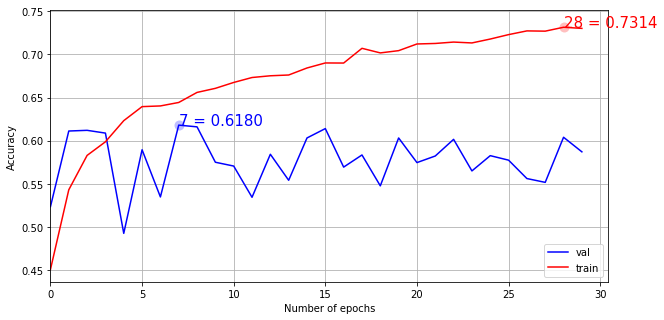

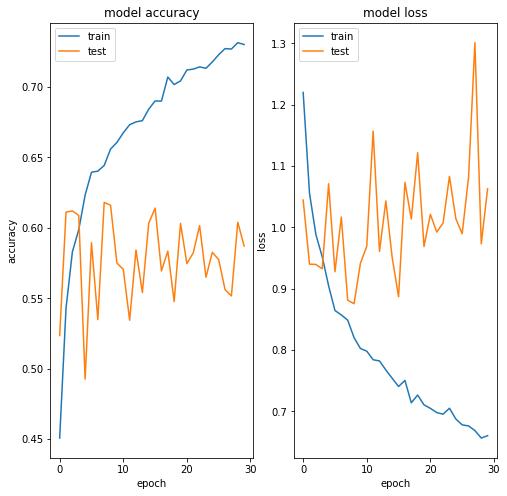

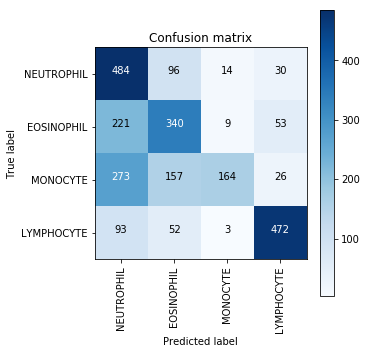

In [39]:
def runVgg162(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_vgg16'):
    
    num_classes = len(y_train[0])
    model_name = 'vgg16'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_keras_model(model_name, num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runVgg162(X_train_2, y_trainHot_2, X_test_2, y_testHot_2)

In [40]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [ ]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss= 'categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

In [ ]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Test'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Test'], loc='lower right')

Y_pred = model.predict(test_dataset, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(test_label,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(test_label,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

In [ ]:
def build_grid_model(num_classes, input_shape):
   
    activation='relu' # or linear
    dropout_rate=0.2 # or 0.2
    weight_constraint=0 # or  4
    optimizer='adam' # or SGD
    lr = 0.01
    momemntum=0




    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(256, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation= activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    return model

def train_model(model, x_train, y_train, x_test, y_test, learning_rate=0.001, lr_decay=0.9,
                metrics=['accuracy'], batch_size=100, epochs=30, shift_fraction=0.1, save_dir='./result'):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """

    # callbacks
    checkpoint = ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    # lr_decay_callback = LearningRateScheduler(schedule=lambda epoch: learning_rate * (lr_decay ** epoch))

    # compile the model
    model.compile(optimizer= Adadelta(), loss=['categorical_crossentropy'], metrics=['accuracy'])

    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size), 
        steps_per_epoch=len(x_train) / batch_size, 
        epochs=epochs, 
        validation_data = [x_test, y_test],
        # callbacks = [checkpoint, lr_decay_callback]
        callbacks = [checkpoint]
    )
    
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)

    return history

def test_model(model, x_test, y_test, history):
    score = model.evaluate(x_test, y_test, verbose=True)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(x_test)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(y_test,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

In [ ]:



model = KerasClassifier(build_fn=build_grid_model, batch_size=32, epochs=50) 
# use verbose=0 if you do not want to see progress

########################################################
# Use scikit-learn to grid search 
activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
##############################################################
# grid search epochs, batch size
epochs = [40, 50, 80, 100] # add 50, 100, 150 etc
batch_size = [32, 40, 50, 64] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)
##############################################################
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y) 
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
##############################################################